In [3]:
import os.path as osp
import GPUtil
import torch.nn as nn
import torch
from focal_loss.focal_loss import FocalLoss

from torch.nn import TransformerEncoder, TransformerEncoderLayer
import os
from torch_geometric.data import Dataset, download_url
from torch_geometric.loader import DataLoader
import pandas as pd
from performance import performances_val
from PIL import Image
from torch.nn import Linear
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool, global_max_pool
from torch_geometric.nn.norm import BatchNorm
from torch_geometric.data import Data
from sklearn import metrics
import numpy as np
from tqdm import tqdm
from torch_geometric.nn import ChebConv, GraphSAGE,GraphUNet ,TransformerConv

# os.environ["CUDA_VISIBLE_DEVICES"] = "1"
# os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
seed = 1378
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
landmark_colors = np.load("landmark_colors.npy")
from sklearn.preprocessing import OneHotEncoder
one_hot_list=[]
enc = OneHotEncoder()
enc.fit(np.expand_dims(landmark_colors,axis=1))  
for x in landmark_colors:
    one_hot_list.append(enc.transform([[x]]).toarray()[0])
one_hot_arr  = np.array(one_hot_list)
one_hot_arr = torch.FloatTensor(one_hot_arr)

m = torch.nn.Softmax(dim=-1)

class landmark_dataset(Dataset):
    def __init__(self, info_list, transform=None, pre_transform=None, pre_filter=None):
        super().__init__(None, transform, pre_transform, pre_filter)
        
        self.graphs = pd.read_csv(info_list, delimiter=",", header=None)


    def len(self):
        return len(self.graphs)

    def get(self, idx):
        
        graph_path = self.graphs.iloc[idx]
        graph_path = graph_path[0]
        
        
        data = torch.load(graph_path)
        #data.x =data.x.t()
        return data 
class landmark_dataset_train(Dataset):
    def __init__(self, info_list, transform=None, pre_transform=None, pre_filter=None):
        super().__init__(None, transform, pre_transform, pre_filter)
        
        self.graphs = pd.read_csv(info_list, delimiter=",", header=None)


    def len(self):
        return len(self.graphs)

    def get(self, idx):
        
        graph_path = self.graphs.iloc[idx]
        graph_path = graph_path[0]
        
        data = torch.load(graph_path)
        
 
        
        domain_name = graph_path.split("/")[-4]
        
            
        if domain_name == "MSU_MFSD" :
            
            domain_label = 0
            
        elif domain_name == "Replay_attack_dataset" :
            
            domain_label = 1
            
        elif domain_name == "oulu" :
            
            domain_label = 2
        else :
            print(graph_path,domain_name )
            raise "error"
            
        
        data = Data(x=data.x, edge_index=data.edge_index,y =data.y,data = domain_label,y_node = one_hot_arr)

        #data.x =data.x.t()
        return data 
train_dataset = landmark_dataset_train("/home/hassan-hossein/single_image_graph_face_anti_spoofing/train/graph_train_O_M_I.txt")
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True,num_workers=16,pin_memory=True)

test_dataset = landmark_dataset("/home/hassan-hossein/single_image_graph_face_anti_spoofing/train/graph_test_C.txt")
test_loader = DataLoader(test_dataset, batch_size=64,num_workers=16)
import torch
import torch.nn as nn
from torch.nn import TransformerEncoder, TransformerEncoderLayer

# فرض کنید که داده‌های ورودی شما یک توالی از ۶۸۰ ویژگی دارد.
#sequence_length = 128
#feature_dim = 4  # هر ویژگی تک‌بعدی است

# نمونه داده ورودی (تعداد نمونه‌ها × طول توالی × بعد ویژگی)
#inputs = torch.rand(32, sequence_length, feature_dim)  # 32 نمونه با 680 ویژگی تک‌بعدی

# تعریف یک لایه ترنسفورمر انکودر
class SimpleTransformer(nn.Module):
    def __init__(self, embed_dim, num_layers, nhead,n_out):
        super(SimpleTransformer, self).__init__()
        self.linear = nn.Linear(4, embed_dim)  # افزایش بعد ویژگی‌ها
        self.encoder_layer = TransformerEncoderLayer(d_model=embed_dim, nhead=nhead)
        self.transformer_encoder = TransformerEncoder(self.encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(128 * embed_dim, n_out)  # فرضا 10 کلاس خروجی داریم

    def forward(self, x):
        x = self.linear(x)  # تغییر بعد ویژگی‌ها
        x = self.transformer_encoder(x)
        x = x.view(x.size(0), -1)  # فشرده‌سازی به یک بردار برای طبقه‌بندی
        x = self.fc(x)
        return x

# # ایجاد مدل و ارسال ورودی
# # model = SimpleTransformer(embed_dim=embed_dim, num_layers=2, nhead=4)
# # output = model(inputs)

# #print(output.shape)
import torch
import torch.nn as nn
from torch.nn import TransformerEncoder, TransformerEncoderLayer

# فرض کنید که داده‌های ورودی شما یک توالی از ۶۸۰ ویژگی دارد.
sequence_length = 128
feature_dim = 1  # هر ویژگی تک‌بعدی است

# نمونه داده ورودی (تعداد نمونه‌ها × طول توالی × بعد ویژگی)
#inputs = torch.rand(32, sequence_length, feature_dim)  # 32 نمونه با 680 ویژگی تک‌بعدی

# تعریف یک لایه ترنسفورمر انکودر
class SimpleTransformer_2(nn.Module):
    def __init__(self, embed_dim, num_layers, nhead):
        super(SimpleTransformer_2, self).__init__()
        self.linear = nn.Linear(feature_dim, embed_dim)  # افزایش بعد ویژگی‌ها
        self.encoder_layer = TransformerEncoderLayer(d_model=embed_dim, nhead=nhead)
        self.transformer_encoder = TransformerEncoder(self.encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(sequence_length * embed_dim, 7)  # فرضا 10 کلاس خروجی داریم

    def forward(self, x):
        x = self.linear(x)  # تغییر بعد ویژگی‌ها
        x = self.transformer_encoder(x)
        x = x.view(x.size(0), -1)  # فشرده‌سازی به یک بردار برای طبقه‌بندی
        x = self.fc(x)
        return x

# # ایجاد مدل و ارسال ورودی
# # model = SimpleTransformer(embed_dim=embed_dim, num_layers=2, nhead=4)
# # output = model(inputs)

# #print(output.shape)


In [2]:
class RandomNodeDropout(nn.Module):
    def __init__(self, drop_prob=0.3):
        super(RandomNodeDropout, self).__init__()
        self.drop_prob = drop_prob

    def forward(self, x, enabled=True):
        if not self.training or not enabled:
            return x
        
        num_rows = x.size(0)
        mask = torch.rand(num_rows, device=x.device) > self.drop_prob
        mask = mask.float().unsqueeze(1).expand_as(x)
        x = x * mask
        
        return x

soft = torch.nn.Softmax(dim=1)

num_domain = 3
class GRL(nn.Module):

    def __init__(self, max_iter):
        super(GRL, self).__init__()
        self.iter_num = 0
        self.alpha = 10
        self.low = 0.0
        self.high = 1.0
        self.max_iter = max_iter

    def forward(self, input):
        self.iter_num += 1
        return input * 1.0

    def backward(self, gradOutput):
        coeff = np.float(2.0 * (self.high - self.low) / (1.0 + np.exp(-self.alpha * self.iter_num / self.max_iter))
                         - (self.high - self.low) + self.low)
        return -coeff*10* gradOutput

num_node  =train_dataset.num_node_features
class Discriminator(torch.nn.Module):
    def __init__(self,hidden_channels ,max_iter):
        super(Discriminator, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GraphSAGE(hidden_channels, hidden_channels,2,dropout=0.5)
        self.conv2 = GraphSAGE(hidden_channels, hidden_channels,2,dropout=0.5)
        self.conv3 = GraphSAGE(hidden_channels, hidden_channels,2,dropout=0.5)
        self.conv4 = GraphSAGE(hidden_channels, hidden_channels,2,dropout=0.5)
        self.drop_1 = RandomNodeDropout(drop_prob=0.3)
        self.drop_2 = RandomNodeDropout(drop_prob=0.3)
        self.grl_layer = GRL(max_iter)
        self.fc2 = nn.Linear(hidden_channels, num_domain)
        
    def forward(self, x, edge_index, batch,drop_en):
        #print("graph fea :",graph_level_feature.shape ,edge_index.shape )
        
        x = self.grl_layer(x)
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.drop_1(x,drop_en)
        
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.drop_2(x,drop_en)
        
        x = self.conv3(x, edge_index)
        x = x.relu()
        x = self.conv4(x, edge_index)
        x = x.relu()
        
        x = global_mean_pool(x, batch)
        
        x = self.fc2(x)
        x = m(x)
         
        return x 



class GCN(torch.nn.Module):
    def __init__(self, hidden_channels,max_iter=4000):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = ChebConv(num_node, hidden_channels,2)
        self.conv2 = ChebConv(hidden_channels, hidden_channels,2)
        self.conv3 = ChebConv(hidden_channels, hidden_channels,2)
        self.conv4 = ChebConv(hidden_channels, hidden_channels,2)
        self.conv5 = ChebConv(hidden_channels*2, hidden_channels,2)
        self.conv6 = ChebConv(hidden_channels, hidden_channels,2)
        self.conv7 = ChebConv(hidden_channels, hidden_channels,2)
        self.conv8 = ChebConv(hidden_channels, hidden_channels,2)
        self.lin = SimpleTransformer(8,5,8,1)
        
        self.drop_1 = RandomNodeDropout(drop_prob=0.3)
        self.drop_2 = RandomNodeDropout(drop_prob=0.3)
        self.drop_3 = RandomNodeDropout(drop_prob=0.3)
        self.drop_4 = RandomNodeDropout(drop_prob=0.3)
        self.drop_5 = RandomNodeDropout(drop_prob=0.3)
        self.drop_6 = RandomNodeDropout(drop_prob=0.3)
        
        
        self.b1 = BatchNorm(hidden_channels)
        self.b2 = BatchNorm(hidden_channels)
        self.b3 = BatchNorm(hidden_channels)
        self.b4 = BatchNorm(hidden_channels)
        self.b5 = BatchNorm(hidden_channels)
        self.b6 = BatchNorm(hidden_channels)
        self.b7 = BatchNorm(hidden_channels)
        
        self.dis = Discriminator(hidden_channels,max_iter)
        
        self.conv1_node_class = GraphSAGE(hidden_channels, hidden_channels,2,dropout=0.5)
        
        self.conv2_node_class = GraphSAGE(hidden_channels, hidden_channels,2,dropout=0.5)
        
        self.lin_node_class = SimpleTransformer_2(64,10,8)
        

        
        #self.tcn = Simple1DCNN()
        
    def forward(self, x, edge_index, batch,drop_en,index_arr):
        #print("graph fea :",graph_level_feature.shape ,edge_index.shape )
        

        x = self.conv1(x, edge_index)
        x  = self.b1(x)
        x = x.relu()
        
        x = self.drop_1(x,drop_en)
        
        

        x = self.conv2(x, edge_index)
        x  = self.b2(x)
        x = x.relu()
        
        x = self.drop_2(x,drop_en)
                
        dicriminator = x
        
        x_1 = global_mean_pool(x, batch)
        
        x = self.conv3(x, edge_index)
        x  = self.b3(x)
        x = x.relu()
        
        x = self.drop_3(x,drop_en)
        
        x_3 = global_mean_pool(x, batch)
        
        
        x = self.conv4(x, edge_index)
        x  = self.b4(x)
        x = x.relu()
        
        x = self.drop_4(x,drop_en)
        
        
        x = torch.cat((x,dicriminator),dim=1) #skip connection
        
        x = self.conv5(x, edge_index)
        x  = self.b5(x)
        x = x.relu()
        
        x = self.drop_5(x,drop_en)
        
        x_5 = global_mean_pool(x, batch)
        
        x = self.conv6(x, edge_index)
        x  = self.b6(x)
        x = x.relu()
        
        x = self.drop_6(x,drop_en)
        
        x = self.conv7(x, edge_index)
        x  = self.b7(x)
        x = x.relu()
        
        
        x = self.conv8(x, edge_index)
        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]
        
        x = torch.stack([x,x_1,x_5,x_3],dim=2)
        
        x = F.dropout(x, p=0.5, training=self.training)
        
        #x = torch.unsqueeze(x,2)
        #print(x.shape)
        
        x = self.lin(x)
        
        x= x.sigmoid()
        
        
        node_class_hidden = self.conv1_node_class(dicriminator,edge_index)
        node_class_hidden = node_class_hidden.relu()
        
        node_class_hidden = self.conv2_node_class(node_class_hidden,edge_index)
        node_class_hidden = node_class_hidden.relu()
        
        #print(index_arr.shape , node_class_hidden.shape)
        
        node_class_hidden = node_class_hidden[index_arr]
        
        #print(node_class_hidden.shape)
        node_class_hidden = torch.unsqueeze(node_class_hidden, dim=2)
        
        node_pre = self.lin_node_class(node_class_hidden)
        
            
        #print("hiiii :" , dicriminator.shape)
        dis_invariant = self.dis(dicriminator,edge_index,batch,drop_en)
        
        return x ,dis_invariant ,node_pre

model = GCN(hidden_channels=128).to(device)
print(model)

def check_folder(log_dir):
    if not os.path.exists(log_dir):
        os.makedirs(log_dir)
    return log_dir

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
#criterion = torch.nn.CrossEntropyLoss()
criterion= nn.BCELoss()
criterion_node_class=  torch.nn.CrossEntropyLoss()
criterion_2 = FocalLoss(gamma=2)
def train(epoch):
    model.train()
    losses_adv_loss=0
    losses_loss_cls=0
    total_loss = 0
    losses_node_cls_loss = 0
    progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}', unit='batch')
    for graph in progress_bar:  # Iterate in batches over the training dataset.
        graph = graph.to(device)  # Move data to the device
        
        drop_en = bool(np.random.binomial(1, 0.5))
        
        if graph.x.shape[0] < 29952 :
            
            if graph.x.shape[0] < 64:
            
                index_arr = torch.randint(0, int(graph.x.shape[0]), (int(graph.x.shape[0]),)).to(device)
            else :
                
                index_arr = torch.randint(0, int(graph.x.shape[0]), (64,)).to(device)
        else :
                
            index_arr = torch.randint(0, 29952, (64,)).to(device)
        
        
        
        out,domain_invariant,node_pre = model(graph.x, graph.edge_index, graph.batch,drop_en,index_arr)  # Perform a single forward pass.
        
        adv_loss = criterion_2(domain_invariant, graph.data)
        
        node_cls_loss = criterion_node_class(node_pre.squeeze(),graph.y_node.float()[index_arr])
        #print(out.shape , graph.y.long().shape)
        loss_cls = criterion(out.squeeze(), graph.y.float())  # Compute the loss.
        
        loss_all = adv_loss + loss_cls + node_cls_loss
        loss_all.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.
        optimizer.zero_grad()  # Clear gradients.
        total_loss = loss_all + total_loss
        losses_adv_loss = adv_loss + losses_adv_loss
        losses_loss_cls = loss_cls + losses_loss_cls
        losses_node_cls_loss = node_cls_loss + losses_node_cls_loss


    print("/////////////////////////")
    print("adverserial loss : " ,losses_adv_loss/len(train_loader.dataset))  
    print("classification loss : " , losses_loss_cls/len(train_loader.dataset))
    print("classification node loss : " , losses_node_cls_loss/len(train_loader.dataset))
    print("total loss : " ,total_loss/len(train_loader.dataset) )
    print("////////////////////////////////////")
def test(loader,epoch):
    score_path = os.path.join("/home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores", "epoch_{}".format(epoch+1))
    check_folder(score_path)
    model.eval()
    with torch.no_grad():
        scores_list = []

        correct = 0
        s= 0
        progress_bar = tqdm(loader, desc=f'Epoch {epoch+1}', unit='batch')
        for graph in progress_bar:  # Iterate in batches over the training/test dataset.
            if graph.x.shape[0] < 29952 :

                if graph.x.shape[0] < 64:

                    index_arr = torch.randint(0, int(graph.x.shape[0]), (int(graph.x.shape[0]),)).to(device)
                else :

                    index_arr = torch.randint(0, int(graph.x.shape[0]), (64,)).to(device)
            else :

                index_arr = torch.randint(0, 29952, (64,)).to(device)
                
            graph = graph.to(device)  # Move data to the device
            logit,_ ,_= model(graph.x, graph.edge_index, graph.batch,False,index_arr)
            live_label = graph.y.float()
            for i in range(len(logit)):
                        scores_list.append("{} {}\n".format(logit[i].item(), live_label[i].item()))
  # Check against ground-truth labels.
    map_score_val_filename = os.path.join(score_path, "score.txt")
    with open(map_score_val_filename, 'w') as file:
                file.writelines(scores_list)
    print("score: write test scores to {}".format(map_score_val_filename))
    test_ACC, fpr, FRR, HTER, auc_test, test_err, tpr = performances_val(map_score_val_filename)
    print("epoch:{:d}, test:  val_ACC={:.4f}, HTER={:.4f}, AUC={:.4f}, val_err={:.4f}, ACC={:.4f}, TPR={:.4f}".format(
        epoch + 1, test_ACC, HTER, auc_test, test_err, test_ACC, tpr))  
    return auc_test




GCN(
  (conv1): ChebConv(640, 128, K=2, normalization=sym)
  (conv2): ChebConv(128, 128, K=2, normalization=sym)
  (conv3): ChebConv(128, 128, K=2, normalization=sym)
  (conv4): ChebConv(128, 128, K=2, normalization=sym)
  (conv5): ChebConv(256, 128, K=2, normalization=sym)
  (conv6): ChebConv(128, 128, K=2, normalization=sym)
  (conv7): ChebConv(128, 128, K=2, normalization=sym)
  (conv8): ChebConv(128, 128, K=2, normalization=sym)
  (lin): SimpleTransformer(
    (linear): Linear(in_features=4, out_features=8, bias=True)
    (encoder_layer): TransformerEncoderLayer(
      (self_attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=8, out_features=8, bias=True)
      )
      (linear1): Linear(in_features=8, out_features=2048, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (linear2): Linear(in_features=2048, out_features=8, bias=True)
      (norm1): LayerNorm((8,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((8,), ep

In [3]:
best_auc = 0
for epoch in range(0, 1000):
    train(epoch)
    print("***************************")
    #print("train : ")
    #train_auc = test(train_loader,epoch)
    print("test : ")
    test_auc = test(test_loader,epoch)
    if test_auc > best_auc:
        print("improve acc .. .. ..")
        torch.save(model.state_dict(), 'Focal_without_pipline_domain_generalization_tuning.pth')
        best_auc = test_auc
        continue  

Epoch 1: 100%|███████████████████████████| 3342/3342 [07:59<00:00,  6.97batch/s]


/////////////////////////
adverserial loss :  tensor(0.0004, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(0.0005, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(0.0086, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(0.0095, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 1: 100%|█████████████████████████████| 349/349 [00:51<00:00,  6.82batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_1/score.txt
epoch:1, test:  val_ACC=0.8095, HTER=0.1906, AUC=0.8941, val_err=0.1906, ACC=0.8095, TPR=0.5686
improve acc .. .. ..


Epoch 2: 100%|███████████████████████████| 3342/3342 [07:56<00:00,  7.01batch/s]


/////////////////////////
adverserial loss :  tensor(1.7170e-05, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(7.1886e-05, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(0.0038, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(0.0039, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 2: 100%|█████████████████████████████| 349/349 [00:47<00:00,  7.28batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_2/score.txt
epoch:2, test:  val_ACC=0.8367, HTER=0.1633, AUC=0.9232, val_err=0.1633, ACC=0.8367, TPR=0.7170
improve acc .. .. ..


Epoch 3: 100%|███████████████████████████| 3342/3342 [08:00<00:00,  6.96batch/s]


/////////////////////////
adverserial loss :  tensor(9.7081e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(6.4368e-05, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(0.0029, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(0.0030, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 3: 100%|█████████████████████████████| 349/349 [00:50<00:00,  6.94batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_3/score.txt
epoch:3, test:  val_ACC=0.8676, HTER=0.1323, AUC=0.9417, val_err=0.1324, ACC=0.8676, TPR=0.8020
improve acc .. .. ..


Epoch 4: 100%|███████████████████████████| 3342/3342 [08:00<00:00,  6.96batch/s]


/////////////////////////
adverserial loss :  tensor(9.1246e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(5.0666e-05, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(0.0024, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(0.0025, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 4: 100%|█████████████████████████████| 349/349 [00:49<00:00,  7.08batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_4/score.txt
epoch:4, test:  val_ACC=0.7773, HTER=0.2227, AUC=0.8599, val_err=0.2227, ACC=0.7773, TPR=0.5441


Epoch 5: 100%|███████████████████████████| 3342/3342 [07:59<00:00,  6.97batch/s]


/////////////////////////
adverserial loss :  tensor(6.3355e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(3.7713e-05, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(0.0020, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(0.0021, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 5: 100%|█████████████████████████████| 349/349 [00:50<00:00,  6.96batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_5/score.txt
epoch:5, test:  val_ACC=0.7558, HTER=0.2443, AUC=0.8295, val_err=0.2443, ACC=0.7558, TPR=0.0000


Epoch 6: 100%|███████████████████████████| 3342/3342 [08:00<00:00,  6.95batch/s]


/////////////////////////
adverserial loss :  tensor(6.0569e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(3.1457e-05, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(0.0017, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(0.0018, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 6: 100%|█████████████████████████████| 349/349 [00:48<00:00,  7.16batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_6/score.txt
epoch:6, test:  val_ACC=0.8131, HTER=0.1876, AUC=0.8734, val_err=0.1880, ACC=0.8131, TPR=0.0000


Epoch 7: 100%|███████████████████████████| 3342/3342 [07:59<00:00,  6.96batch/s]


/////////////////////////
adverserial loss :  tensor(4.0377e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(3.0694e-05, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(0.0015, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(0.0015, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 7: 100%|█████████████████████████████| 349/349 [00:47<00:00,  7.29batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_7/score.txt
epoch:7, test:  val_ACC=0.8423, HTER=0.1577, AUC=0.9234, val_err=0.1577, ACC=0.8423, TPR=0.7178


Epoch 8: 100%|███████████████████████████| 3342/3342 [08:00<00:00,  6.95batch/s]


/////////////////////////
adverserial loss :  tensor(3.9479e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(3.0679e-05, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(0.0013, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(0.0013, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 8: 100%|█████████████████████████████| 349/349 [00:48<00:00,  7.21batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_8/score.txt
epoch:8, test:  val_ACC=0.9076, HTER=0.0924, AUC=0.9523, val_err=0.0924, ACC=0.9076, TPR=0.8612
improve acc .. .. ..


Epoch 9: 100%|███████████████████████████| 3342/3342 [08:00<00:00,  6.96batch/s]


/////////////////////////
adverserial loss :  tensor(3.7493e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(2.1684e-05, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(0.0011, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(0.0011, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 9: 100%|█████████████████████████████| 349/349 [00:47<00:00,  7.29batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_9/score.txt
epoch:9, test:  val_ACC=0.8431, HTER=0.1570, AUC=0.9181, val_err=0.1570, ACC=0.8431, TPR=0.6942


Epoch 10: 100%|██████████████████████████| 3342/3342 [08:01<00:00,  6.95batch/s]


/////////////////////////
adverserial loss :  tensor(5.6673e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(2.5480e-05, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 10: 100%|████████████████████████████| 349/349 [00:48<00:00,  7.18batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_10/score.txt
epoch:10, test:  val_ACC=0.7747, HTER=0.2255, AUC=0.8575, val_err=0.2256, ACC=0.7747, TPR=0.0000


Epoch 11: 100%|██████████████████████████| 3342/3342 [08:01<00:00,  6.94batch/s]


/////////////////////////
adverserial loss :  tensor(2.5647e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(2.0502e-05, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(0.0009, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 11: 100%|████████████████████████████| 349/349 [00:48<00:00,  7.18batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_11/score.txt
epoch:11, test:  val_ACC=0.8173, HTER=0.1828, AUC=0.9060, val_err=0.1828, ACC=0.8173, TPR=0.6359


Epoch 12: 100%|██████████████████████████| 3342/3342 [08:00<00:00,  6.96batch/s]


/////////////////////////
adverserial loss :  tensor(2.8341e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.8703e-05, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 12: 100%|████████████████████████████| 349/349 [00:47<00:00,  7.32batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_12/score.txt
epoch:12, test:  val_ACC=0.8622, HTER=0.1379, AUC=0.9230, val_err=0.1379, ACC=0.8622, TPR=0.7287


Epoch 13: 100%|██████████████████████████| 3342/3342 [07:59<00:00,  6.97batch/s]


/////////////////////////
adverserial loss :  tensor(3.6219e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(2.2065e-05, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(0.0007, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(0.0007, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 13: 100%|████████████████████████████| 349/349 [00:48<00:00,  7.16batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_13/score.txt
epoch:13, test:  val_ACC=0.9082, HTER=0.0919, AUC=0.9588, val_err=0.0919, ACC=0.9082, TPR=0.8662
improve acc .. .. ..


Epoch 14: 100%|██████████████████████████| 3342/3342 [08:00<00:00,  6.95batch/s]


/////////////////////////
adverserial loss :  tensor(3.2839e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.5666e-05, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(0.0006, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(0.0007, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 14: 100%|████████████████████████████| 349/349 [00:47<00:00,  7.32batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_14/score.txt
epoch:14, test:  val_ACC=0.9167, HTER=0.0833, AUC=0.9592, val_err=0.0833, ACC=0.9167, TPR=0.8773
improve acc .. .. ..


Epoch 15: 100%|██████████████████████████| 3342/3342 [07:57<00:00,  7.00batch/s]


/////////////////////////
adverserial loss :  tensor(1.5679e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.5094e-05, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(0.0006, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(0.0006, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 15: 100%|████████████████████████████| 349/349 [00:47<00:00,  7.30batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_15/score.txt
epoch:15, test:  val_ACC=0.8958, HTER=0.1043, AUC=0.9583, val_err=0.1043, ACC=0.8958, TPR=0.8415


Epoch 16: 100%|██████████████████████████| 3342/3342 [07:58<00:00,  6.98batch/s]


/////////////////////////
adverserial loss :  tensor(4.0468e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.3907e-05, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(0.0006, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(0.0006, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 16: 100%|████████████████████████████| 349/349 [00:47<00:00,  7.39batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_16/score.txt
epoch:16, test:  val_ACC=0.8048, HTER=0.2019, AUC=0.8470, val_err=0.2053, ACC=0.8048, TPR=0.0000


Epoch 17: 100%|██████████████████████████| 3342/3342 [07:56<00:00,  7.02batch/s]


/////////////////////////
adverserial loss :  tensor(1.6723e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.7261e-05, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(0.0005, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(0.0006, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 17: 100%|████████████████████████████| 349/349 [00:48<00:00,  7.19batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_17/score.txt
epoch:17, test:  val_ACC=0.8336, HTER=0.1744, AUC=0.8757, val_err=0.1766, ACC=0.8336, TPR=0.0000


Epoch 18: 100%|██████████████████████████| 3342/3342 [07:52<00:00,  7.07batch/s]


/////////////////////////
adverserial loss :  tensor(4.2156e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.4066e-05, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(0.0005, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(0.0005, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 18: 100%|████████████████████████████| 349/349 [00:49<00:00,  7.10batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_18/score.txt
epoch:18, test:  val_ACC=0.8484, HTER=0.1516, AUC=0.9231, val_err=0.1517, ACC=0.8484, TPR=0.7213


Epoch 19: 100%|██████████████████████████| 3342/3342 [07:55<00:00,  7.03batch/s]


/////////////////////////
adverserial loss :  tensor(1.3383e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.6196e-05, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(0.0005, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(0.0005, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 19: 100%|████████████████████████████| 349/349 [00:48<00:00,  7.25batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_19/score.txt
epoch:19, test:  val_ACC=0.8694, HTER=0.1306, AUC=0.9491, val_err=0.1307, ACC=0.8694, TPR=0.7821


Epoch 20: 100%|██████████████████████████| 3342/3342 [07:55<00:00,  7.03batch/s]


/////////////////////////
adverserial loss :  tensor(1.8010e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.2143e-05, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(0.0004, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(0.0004, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 20: 100%|████████████████████████████| 349/349 [00:48<00:00,  7.13batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_20/score.txt
epoch:20, test:  val_ACC=0.8545, HTER=0.1455, AUC=0.9242, val_err=0.1455, ACC=0.8545, TPR=0.7111


Epoch 21: 100%|██████████████████████████| 3342/3342 [07:51<00:00,  7.08batch/s]


/////////////////////////
adverserial loss :  tensor(2.7003e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.7101e-05, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(0.0004, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(0.0004, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 21: 100%|████████████████████████████| 349/349 [00:50<00:00,  6.91batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_21/score.txt
epoch:21, test:  val_ACC=0.8680, HTER=0.1319, AUC=0.9401, val_err=0.1320, ACC=0.8680, TPR=0.7810


Epoch 22: 100%|██████████████████████████| 3342/3342 [07:57<00:00,  7.00batch/s]


/////////////////////////
adverserial loss :  tensor(3.9100e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.5074e-05, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(0.0004, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(0.0004, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 22: 100%|████████████████████████████| 349/349 [00:48<00:00,  7.27batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_22/score.txt
epoch:22, test:  val_ACC=0.8887, HTER=0.1113, AUC=0.9454, val_err=0.1113, ACC=0.8887, TPR=0.7816


Epoch 23: 100%|██████████████████████████| 3342/3342 [07:56<00:00,  7.01batch/s]


/////////////////////////
adverserial loss :  tensor(1.8120e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(9.1914e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(0.0004, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(0.0004, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 23: 100%|████████████████████████████| 349/349 [00:48<00:00,  7.27batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_23/score.txt
epoch:23, test:  val_ACC=0.8555, HTER=0.1446, AUC=0.9208, val_err=0.1446, ACC=0.8555, TPR=0.7200


Epoch 24: 100%|██████████████████████████| 3342/3342 [07:57<00:00,  6.99batch/s]


/////////////////////////
adverserial loss :  tensor(6.2606e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.0453e-05, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(0.0004, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(0.0004, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 24: 100%|████████████████████████████| 349/349 [00:48<00:00,  7.14batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_24/score.txt
epoch:24, test:  val_ACC=0.8790, HTER=0.1210, AUC=0.9374, val_err=0.1210, ACC=0.8790, TPR=0.7747


Epoch 25: 100%|██████████████████████████| 3342/3342 [07:57<00:00,  7.00batch/s]


/////////////////////////
adverserial loss :  tensor(3.5826e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(9.6282e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(0.0003, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(0.0003, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 25: 100%|████████████████████████████| 349/349 [00:49<00:00,  7.12batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_25/score.txt
epoch:25, test:  val_ACC=0.8577, HTER=0.1423, AUC=0.9330, val_err=0.1423, ACC=0.8577, TPR=0.7276


Epoch 26: 100%|██████████████████████████| 3342/3342 [07:57<00:00,  6.99batch/s]


/////////////////////////
adverserial loss :  tensor(2.9035e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(9.6163e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(0.0003, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(0.0003, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 26: 100%|████████████████████████████| 349/349 [00:49<00:00,  7.11batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_26/score.txt
epoch:26, test:  val_ACC=0.8742, HTER=0.1260, AUC=0.9249, val_err=0.1259, ACC=0.8742, TPR=0.8311


Epoch 27: 100%|██████████████████████████| 3342/3342 [07:56<00:00,  7.02batch/s]


/////////////////////////
adverserial loss :  tensor(1.9714e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.0836e-05, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(0.0003, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(0.0003, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 27: 100%|████████████████████████████| 349/349 [00:48<00:00,  7.17batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_27/score.txt
epoch:27, test:  val_ACC=0.8535, HTER=0.1466, AUC=0.9187, val_err=0.1466, ACC=0.8535, TPR=0.7573


Epoch 28: 100%|██████████████████████████| 3342/3342 [07:56<00:00,  7.01batch/s]


/////////////////////////
adverserial loss :  tensor(1.8741e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.2646e-05, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(0.0003, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(0.0003, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 28: 100%|████████████████████████████| 349/349 [00:47<00:00,  7.31batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_28/score.txt
epoch:28, test:  val_ACC=0.8809, HTER=0.1191, AUC=0.9402, val_err=0.1191, ACC=0.8809, TPR=0.7814


Epoch 29: 100%|██████████████████████████| 3342/3342 [07:57<00:00,  7.00batch/s]


/////////////////////////
adverserial loss :  tensor(4.7342e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(3.2164e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(0.0003, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(0.0003, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 29: 100%|████████████████████████████| 349/349 [00:47<00:00,  7.29batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_29/score.txt
epoch:29, test:  val_ACC=0.9013, HTER=0.0987, AUC=0.9547, val_err=0.0987, ACC=0.9013, TPR=0.8493


Epoch 30: 100%|██████████████████████████| 3342/3342 [07:57<00:00,  7.00batch/s]


/////////////////////////
adverserial loss :  tensor(2.5041e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.0457e-05, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(0.0003, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(0.0003, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 30: 100%|████████████████████████████| 349/349 [00:47<00:00,  7.29batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_30/score.txt
epoch:30, test:  val_ACC=0.8848, HTER=0.1152, AUC=0.9454, val_err=0.1152, ACC=0.8848, TPR=0.8042


Epoch 31: 100%|██████████████████████████| 3342/3342 [07:57<00:00,  7.00batch/s]


/////////////////////////
adverserial loss :  tensor(8.3552e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.5197e-05, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(0.0003, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(0.0003, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 31: 100%|████████████████████████████| 349/349 [00:47<00:00,  7.32batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_31/score.txt
epoch:31, test:  val_ACC=0.9748, HTER=0.1482, AUC=0.8694, val_err=0.1922, ACC=0.9748, TPR=0.0000


Epoch 32: 100%|██████████████████████████| 3342/3342 [07:58<00:00,  6.98batch/s]


/////////////////////////
adverserial loss :  tensor(8.1492e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(7.0914e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(0.0003, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(0.0003, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 32: 100%|████████████████████████████| 349/349 [00:48<00:00,  7.25batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_32/score.txt
epoch:32, test:  val_ACC=0.8598, HTER=0.1401, AUC=0.9307, val_err=0.1402, ACC=0.8598, TPR=0.7194


Epoch 33: 100%|██████████████████████████| 3342/3342 [07:54<00:00,  7.04batch/s]


/////////////////////////
adverserial loss :  tensor(1.8403e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(5.6991e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(0.0003, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(0.0003, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 33: 100%|████████████████████████████| 349/349 [00:48<00:00,  7.24batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_33/score.txt
epoch:33, test:  val_ACC=0.8672, HTER=0.1329, AUC=0.9190, val_err=0.1328, ACC=0.8672, TPR=0.7686


Epoch 34: 100%|██████████████████████████| 3342/3342 [07:58<00:00,  6.99batch/s]


/////////////////////////
adverserial loss :  tensor(4.0684e-08, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(9.8539e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(0.0003, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(0.0003, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 34: 100%|████████████████████████████| 349/349 [00:50<00:00,  6.91batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_34/score.txt
epoch:34, test:  val_ACC=0.8538, HTER=0.1462, AUC=0.9223, val_err=0.1462, ACC=0.8538, TPR=0.7122


Epoch 35: 100%|██████████████████████████| 3342/3342 [07:57<00:00,  7.00batch/s]


/////////////////////////
adverserial loss :  tensor(1.4849e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(4.3105e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(0.0002, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(0.0002, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 35: 100%|████████████████████████████| 349/349 [00:48<00:00,  7.19batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_35/score.txt
epoch:35, test:  val_ACC=0.8321, HTER=0.1679, AUC=0.9020, val_err=0.1679, ACC=0.8321, TPR=0.6372


Epoch 36: 100%|██████████████████████████| 3342/3342 [07:57<00:00,  7.00batch/s]


/////////////////////////
adverserial loss :  tensor(2.8921e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(7.6541e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(0.0002, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(0.0003, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 36: 100%|████████████████████████████| 349/349 [00:49<00:00,  7.10batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_36/score.txt
epoch:36, test:  val_ACC=0.8214, HTER=0.1787, AUC=0.9093, val_err=0.1787, ACC=0.8214, TPR=0.7022


Epoch 37: 100%|██████████████████████████| 3342/3342 [07:56<00:00,  7.01batch/s]


/////////////////////////
adverserial loss :  tensor(3.7822e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(8.3066e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(0.0002, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(0.0002, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 37: 100%|████████████████████████████| 349/349 [00:48<00:00,  7.19batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_37/score.txt
epoch:37, test:  val_ACC=0.8584, HTER=0.1416, AUC=0.9246, val_err=0.1416, ACC=0.8584, TPR=0.7684


Epoch 38: 100%|██████████████████████████| 3342/3342 [07:56<00:00,  7.01batch/s]


/////////////////////////
adverserial loss :  tensor(2.3826e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(6.9682e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(0.0002, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(0.0002, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 38: 100%|████████████████████████████| 349/349 [00:48<00:00,  7.13batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_38/score.txt
epoch:38, test:  val_ACC=0.8911, HTER=0.1089, AUC=0.9489, val_err=0.1089, ACC=0.8911, TPR=0.8250


Epoch 39: 100%|██████████████████████████| 3342/3342 [07:56<00:00,  7.01batch/s]


/////////////////////////
adverserial loss :  tensor(1.7948e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(6.0328e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(0.0002, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(0.0002, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 39: 100%|████████████████████████████| 349/349 [00:48<00:00,  7.16batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_39/score.txt
epoch:39, test:  val_ACC=0.8761, HTER=0.1239, AUC=0.9284, val_err=0.1239, ACC=0.8761, TPR=0.7758


Epoch 40: 100%|██████████████████████████| 3342/3342 [07:56<00:00,  7.01batch/s]


/////////////////////////
adverserial loss :  tensor(2.9841e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(6.1961e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(0.0002, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(0.0002, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 40: 100%|████████████████████████████| 349/349 [00:48<00:00,  7.23batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_40/score.txt
epoch:40, test:  val_ACC=0.8298, HTER=0.1702, AUC=0.9068, val_err=0.1702, ACC=0.8298, TPR=0.6888


Epoch 41: 100%|██████████████████████████| 3342/3342 [07:57<00:00,  7.00batch/s]


/////////////////////////
adverserial loss :  tensor(4.9905e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(8.5406e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(0.0002, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(0.0002, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 41: 100%|████████████████████████████| 349/349 [00:47<00:00,  7.36batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_41/score.txt
epoch:41, test:  val_ACC=0.8512, HTER=0.1488, AUC=0.9224, val_err=0.1488, ACC=0.8512, TPR=0.7415


Epoch 42: 100%|██████████████████████████| 3342/3342 [07:56<00:00,  7.01batch/s]


/////////////////////////
adverserial loss :  tensor(2.4763e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(5.1481e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(0.0002, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(0.0002, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 42: 100%|████████████████████████████| 349/349 [00:47<00:00,  7.35batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_42/score.txt
epoch:42, test:  val_ACC=0.8637, HTER=0.1364, AUC=0.9298, val_err=0.1364, ACC=0.8637, TPR=0.7209


Epoch 43: 100%|██████████████████████████| 3342/3342 [07:58<00:00,  6.98batch/s]


/////////////////////////
adverserial loss :  tensor(8.4222e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(7.0858e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(0.0002, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(0.0002, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 43: 100%|████████████████████████████| 349/349 [00:47<00:00,  7.30batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_43/score.txt
epoch:43, test:  val_ACC=0.8822, HTER=0.1178, AUC=0.9441, val_err=0.1178, ACC=0.8822, TPR=0.8014


Epoch 44: 100%|██████████████████████████| 3342/3342 [07:57<00:00,  7.01batch/s]


/////////////////////////
adverserial loss :  tensor(9.5191e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(6.5585e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(0.0002, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(0.0002, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 44: 100%|████████████████████████████| 349/349 [00:48<00:00,  7.21batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_44/score.txt
epoch:44, test:  val_ACC=0.8938, HTER=0.1062, AUC=0.9544, val_err=0.1062, ACC=0.8938, TPR=0.8313


Epoch 45: 100%|██████████████████████████| 3342/3342 [07:57<00:00,  7.00batch/s]


/////////////////////////
adverserial loss :  tensor(2.9814e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(7.9600e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(0.0002, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(0.0002, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 45: 100%|████████████████████████████| 349/349 [00:47<00:00,  7.37batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_45/score.txt
epoch:45, test:  val_ACC=0.9624, HTER=0.2140, AUC=0.8072, val_err=0.2723, ACC=0.9624, TPR=0.0000


Epoch 46: 100%|██████████████████████████| 3342/3342 [07:58<00:00,  6.99batch/s]


/////////////////////////
adverserial loss :  tensor(2.6710e-08, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(5.9326e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(0.0002, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(0.0002, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 46: 100%|████████████████████████████| 349/349 [00:48<00:00,  7.25batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_46/score.txt
epoch:46, test:  val_ACC=0.8537, HTER=0.1462, AUC=0.9329, val_err=0.1463, ACC=0.8537, TPR=0.7244


Epoch 47: 100%|██████████████████████████| 3342/3342 [07:56<00:00,  7.01batch/s]


/////////////////////////
adverserial loss :  tensor(1.7511e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(4.8993e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(0.0002, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(0.0002, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 47: 100%|████████████████████████████| 349/349 [00:49<00:00,  7.03batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_47/score.txt
epoch:47, test:  val_ACC=0.8492, HTER=0.1509, AUC=0.9248, val_err=0.1509, ACC=0.8492, TPR=0.6968


Epoch 48: 100%|██████████████████████████| 3342/3342 [07:56<00:00,  7.01batch/s]


/////////////////////////
adverserial loss :  tensor(7.3792e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(4.0096e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(0.0002, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(0.0002, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 48: 100%|████████████████████████████| 349/349 [00:49<00:00,  7.05batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_48/score.txt
epoch:48, test:  val_ACC=0.8737, HTER=0.1264, AUC=0.9345, val_err=0.1264, ACC=0.8737, TPR=0.7697


Epoch 49: 100%|██████████████████████████| 3342/3342 [07:57<00:00,  7.00batch/s]


/////////////////////////
adverserial loss :  tensor(4.4883e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(7.6979e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(0.0002, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(0.0002, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 49: 100%|████████████████████████████| 349/349 [00:48<00:00,  7.25batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_49/score.txt
epoch:49, test:  val_ACC=0.9054, HTER=0.0946, AUC=0.9570, val_err=0.0946, ACC=0.9054, TPR=0.8503


Epoch 50: 100%|██████████████████████████| 3342/3342 [07:59<00:00,  6.97batch/s]


/////////////////////////
adverserial loss :  tensor(6.0074e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(4.7225e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(0.0002, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(0.0002, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 50: 100%|████████████████████████████| 349/349 [00:48<00:00,  7.18batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_50/score.txt
epoch:50, test:  val_ACC=0.8668, HTER=0.1332, AUC=0.9433, val_err=0.1333, ACC=0.8668, TPR=0.7788


Epoch 51: 100%|██████████████████████████| 3342/3342 [07:58<00:00,  6.99batch/s]


/////////////////////////
adverserial loss :  tensor(4.6795e-08, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(3.2375e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(0.0002, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(0.0002, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 51: 100%|████████████████████████████| 349/349 [00:48<00:00,  7.25batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_51/score.txt
epoch:51, test:  val_ACC=0.8739, HTER=0.1262, AUC=0.9382, val_err=0.1262, ACC=0.8739, TPR=0.7632


Epoch 52: 100%|██████████████████████████| 3342/3342 [07:56<00:00,  7.01batch/s]


/////////////////////////
adverserial loss :  tensor(4.4949e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(8.4513e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(0.0002, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(0.0002, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 52: 100%|████████████████████████████| 349/349 [00:48<00:00,  7.22batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_52/score.txt
epoch:52, test:  val_ACC=0.9105, HTER=0.0895, AUC=0.9629, val_err=0.0895, ACC=0.9105, TPR=0.8536
improve acc .. .. ..


Epoch 53: 100%|██████████████████████████| 3342/3342 [07:56<00:00,  7.02batch/s]


/////////////////////////
adverserial loss :  tensor(2.3558e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(8.7578e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(0.0002, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(0.0002, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 53: 100%|████████████████████████████| 349/349 [00:49<00:00,  7.03batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_53/score.txt
epoch:53, test:  val_ACC=0.8417, HTER=0.1583, AUC=0.9218, val_err=0.1583, ACC=0.8417, TPR=0.6847


Epoch 54: 100%|██████████████████████████| 3342/3342 [07:55<00:00,  7.03batch/s]


/////////////////////////
adverserial loss :  tensor(8.0834e-08, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.9586e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(0.0002, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(0.0002, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 54: 100%|████████████████████████████| 349/349 [00:48<00:00,  7.18batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_54/score.txt
epoch:54, test:  val_ACC=0.8648, HTER=0.1353, AUC=0.9212, val_err=0.1353, ACC=0.8648, TPR=0.7003


Epoch 55: 100%|██████████████████████████| 3342/3342 [07:56<00:00,  7.01batch/s]


/////////////////////////
adverserial loss :  tensor(8.2374e-09, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(7.3104e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(0.0001, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(0.0001, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 55: 100%|████████████████████████████| 349/349 [00:48<00:00,  7.21batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_55/score.txt
epoch:55, test:  val_ACC=0.9033, HTER=0.0967, AUC=0.9557, val_err=0.0968, ACC=0.9033, TPR=0.8452


Epoch 56: 100%|██████████████████████████| 3342/3342 [07:57<00:00,  6.99batch/s]


/////////////////////////
adverserial loss :  tensor(1.6639e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(6.0955e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(0.0002, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(0.0002, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 56: 100%|████████████████████████████| 349/349 [00:48<00:00,  7.15batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_56/score.txt
epoch:56, test:  val_ACC=0.8484, HTER=0.1516, AUC=0.9250, val_err=0.1516, ACC=0.8484, TPR=0.6589


Epoch 57: 100%|██████████████████████████| 3342/3342 [07:56<00:00,  7.02batch/s]


/////////////////////////
adverserial loss :  tensor(1.4847e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(4.1090e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(0.0001, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(0.0002, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 57: 100%|████████████████████████████| 349/349 [00:48<00:00,  7.20batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_57/score.txt
epoch:57, test:  val_ACC=0.9119, HTER=0.0881, AUC=0.9530, val_err=0.0881, ACC=0.9119, TPR=0.8571


Epoch 58: 100%|██████████████████████████| 3342/3342 [07:55<00:00,  7.02batch/s]


/////////////////////////
adverserial loss :  tensor(6.2406e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(4.5677e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(0.0001, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(0.0002, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 58: 100%|████████████████████████████| 349/349 [00:47<00:00,  7.28batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_58/score.txt
epoch:58, test:  val_ACC=0.8568, HTER=0.1433, AUC=0.9152, val_err=0.1433, ACC=0.8568, TPR=0.6905


Epoch 59: 100%|██████████████████████████| 3342/3342 [07:57<00:00,  7.00batch/s]


/////////////////////////
adverserial loss :  tensor(4.1857e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(3.3588e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(0.0002, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(0.0002, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 59: 100%|████████████████████████████| 349/349 [00:47<00:00,  7.28batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_59/score.txt
epoch:59, test:  val_ACC=0.9186, HTER=0.0815, AUC=0.9646, val_err=0.0814, ACC=0.9186, TPR=0.8857
improve acc .. .. ..


Epoch 60: 100%|██████████████████████████| 3342/3342 [07:57<00:00,  7.00batch/s]


/////////////////////////
adverserial loss :  tensor(6.6633e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(6.0611e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(0.0001, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(0.0002, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 60: 100%|████████████████████████████| 349/349 [00:48<00:00,  7.24batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_60/score.txt
epoch:60, test:  val_ACC=0.8443, HTER=0.1557, AUC=0.9269, val_err=0.1557, ACC=0.8443, TPR=0.6382


Epoch 61: 100%|██████████████████████████| 3342/3342 [07:57<00:00,  7.00batch/s]


/////////////////////////
adverserial loss :  tensor(9.8590e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.4342e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(0.0001, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(0.0001, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 61: 100%|████████████████████████████| 349/349 [00:49<00:00,  7.05batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_61/score.txt
epoch:61, test:  val_ACC=0.9192, HTER=0.0808, AUC=0.9605, val_err=0.0808, ACC=0.9192, TPR=0.8573


Epoch 62: 100%|██████████████████████████| 3342/3342 [07:58<00:00,  6.99batch/s]


/////////////////////////
adverserial loss :  tensor(7.7342e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(7.1651e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(0.0001, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(0.0002, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 62: 100%|████████████████████████████| 349/349 [00:48<00:00,  7.19batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_62/score.txt
epoch:62, test:  val_ACC=0.8215, HTER=0.1785, AUC=0.9101, val_err=0.1785, ACC=0.8215, TPR=0.6289


Epoch 63: 100%|██████████████████████████| 3342/3342 [07:57<00:00,  7.00batch/s]


/////////////////////////
adverserial loss :  tensor(5.1734e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(4.2322e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(0.0001, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(0.0001, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 63: 100%|████████████████████████████| 349/349 [00:49<00:00,  7.07batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_63/score.txt
epoch:63, test:  val_ACC=0.8632, HTER=0.1368, AUC=0.9388, val_err=0.1368, ACC=0.8632, TPR=0.7530


Epoch 64: 100%|██████████████████████████| 3342/3342 [07:57<00:00,  6.99batch/s]


/////////////////////////
adverserial loss :  tensor(1.1571e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(5.9071e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(0.0001, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(0.0001, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 64: 100%|████████████████████████████| 349/349 [00:48<00:00,  7.17batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_64/score.txt
epoch:64, test:  val_ACC=0.8293, HTER=0.1707, AUC=0.9201, val_err=0.1707, ACC=0.8293, TPR=0.7038


Epoch 65: 100%|██████████████████████████| 3342/3342 [07:58<00:00,  6.99batch/s]


/////////////////////////
adverserial loss :  tensor(1.8560e-08, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(3.1829e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(0.0001, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(0.0001, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 65: 100%|████████████████████████████| 349/349 [00:48<00:00,  7.20batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_65/score.txt
epoch:65, test:  val_ACC=0.8874, HTER=0.1126, AUC=0.9471, val_err=0.1126, ACC=0.8874, TPR=0.7862


Epoch 66: 100%|██████████████████████████| 3342/3342 [08:00<00:00,  6.96batch/s]


/////////////////////////
adverserial loss :  tensor(4.1030e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(3.5090e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(0.0001, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(0.0001, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 66: 100%|████████████████████████████| 349/349 [00:49<00:00,  7.12batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_66/score.txt
epoch:66, test:  val_ACC=0.8525, HTER=0.1475, AUC=0.9253, val_err=0.1475, ACC=0.8525, TPR=0.7395


Epoch 67: 100%|██████████████████████████| 3342/3342 [07:57<00:00,  7.00batch/s]


/////////////////////////
adverserial loss :  tensor(9.6482e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(3.1684e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(0.0001, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(0.0001, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 67: 100%|████████████████████████████| 349/349 [00:49<00:00,  7.05batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_67/score.txt
epoch:67, test:  val_ACC=0.8814, HTER=0.1186, AUC=0.9472, val_err=0.1186, ACC=0.8814, TPR=0.8044


Epoch 68: 100%|██████████████████████████| 3342/3342 [07:57<00:00,  7.00batch/s]


/////////////////////////
adverserial loss :  tensor(8.4836e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(4.1459e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(0.0001, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(0.0001, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 68: 100%|████████████████████████████| 349/349 [00:49<00:00,  7.10batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_68/score.txt
epoch:68, test:  val_ACC=0.8668, HTER=0.1332, AUC=0.9389, val_err=0.1333, ACC=0.8668, TPR=0.7732


Epoch 69: 100%|██████████████████████████| 3342/3342 [07:56<00:00,  7.01batch/s]


/////////////////////////
adverserial loss :  tensor(8.9730e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(2.2529e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(0.0001, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(0.0001, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 69: 100%|████████████████████████████| 349/349 [00:48<00:00,  7.14batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_69/score.txt
epoch:69, test:  val_ACC=0.8496, HTER=0.1505, AUC=0.9215, val_err=0.1505, ACC=0.8496, TPR=0.7137


Epoch 70: 100%|██████████████████████████| 3342/3342 [07:57<00:00,  6.99batch/s]


/////////////////////////
adverserial loss :  tensor(1.8718e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(2.7614e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(0.0001, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(0.0001, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 70: 100%|████████████████████████████| 349/349 [00:49<00:00,  7.09batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_70/score.txt
epoch:70, test:  val_ACC=0.8681, HTER=0.1319, AUC=0.9447, val_err=0.1320, ACC=0.8681, TPR=0.7551


Epoch 71: 100%|██████████████████████████| 3342/3342 [07:56<00:00,  7.01batch/s]


/////////////////////////
adverserial loss :  tensor(4.1181e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(6.0754e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(0.0001, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(0.0001, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 71: 100%|████████████████████████████| 349/349 [00:49<00:00,  7.09batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_71/score.txt
epoch:71, test:  val_ACC=0.8594, HTER=0.1407, AUC=0.9327, val_err=0.1407, ACC=0.8594, TPR=0.7231


Epoch 72: 100%|██████████████████████████| 3342/3342 [07:59<00:00,  6.97batch/s]


/////////////////////////
adverserial loss :  tensor(1.3070e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(6.1623e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(0.0001, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(0.0001, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 72: 100%|████████████████████████████| 349/349 [00:49<00:00,  7.11batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_72/score.txt
epoch:72, test:  val_ACC=0.9011, HTER=0.0989, AUC=0.9626, val_err=0.0989, ACC=0.9011, TPR=0.8157


Epoch 73: 100%|██████████████████████████| 3342/3342 [07:59<00:00,  6.98batch/s]


/////////////////////////
adverserial loss :  tensor(2.1602e-08, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.0556e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(0.0001, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(0.0001, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 73: 100%|████████████████████████████| 349/349 [00:49<00:00,  7.06batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_73/score.txt
epoch:73, test:  val_ACC=0.8630, HTER=0.1381, AUC=0.9190, val_err=0.1378, ACC=0.8630, TPR=0.7680


Epoch 74: 100%|██████████████████████████| 3342/3342 [07:56<00:00,  7.01batch/s]


/////////////////////////
adverserial loss :  tensor(2.0534e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(5.8519e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(0.0001, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(0.0001, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 74: 100%|████████████████████████████| 349/349 [00:49<00:00,  6.99batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_74/score.txt
epoch:74, test:  val_ACC=0.8553, HTER=0.1447, AUC=0.9298, val_err=0.1447, ACC=0.8553, TPR=0.6576


Epoch 75: 100%|██████████████████████████| 3342/3342 [07:56<00:00,  7.02batch/s]


/////////////////////////
adverserial loss :  tensor(2.0339e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(5.7230e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(0.0001, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(0.0001, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 75: 100%|████████████████████████████| 349/349 [00:49<00:00,  7.12batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_75/score.txt
epoch:75, test:  val_ACC=0.8449, HTER=0.1551, AUC=0.9274, val_err=0.1551, ACC=0.8449, TPR=0.6764


Epoch 76: 100%|██████████████████████████| 3342/3342 [07:55<00:00,  7.03batch/s]


/////////////////////////
adverserial loss :  tensor(1.7285e-08, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(2.0156e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(0.0001, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(0.0001, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 76: 100%|████████████████████████████| 349/349 [00:48<00:00,  7.22batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_76/score.txt
epoch:76, test:  val_ACC=0.8447, HTER=0.1554, AUC=0.9037, val_err=0.1553, ACC=0.8447, TPR=0.6827


Epoch 77: 100%|██████████████████████████| 3342/3342 [07:57<00:00,  7.00batch/s]


/////////////////////////
adverserial loss :  tensor(7.9145e-08, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(3.1565e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(0.0001, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(0.0001, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 77: 100%|████████████████████████████| 349/349 [00:49<00:00,  7.04batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_77/score.txt
epoch:77, test:  val_ACC=0.8201, HTER=0.1800, AUC=0.9049, val_err=0.1800, ACC=0.8201, TPR=0.5383


Epoch 78: 100%|██████████████████████████| 3342/3342 [07:57<00:00,  7.00batch/s]


/////////////////////////
adverserial loss :  tensor(3.9351e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(3.3869e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(0.0001, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(0.0001, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 78: 100%|████████████████████████████| 349/349 [00:50<00:00,  6.90batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_78/score.txt
epoch:78, test:  val_ACC=0.8597, HTER=0.1403, AUC=0.9398, val_err=0.1403, ACC=0.8597, TPR=0.7454


Epoch 79: 100%|██████████████████████████| 3342/3342 [07:57<00:00,  7.01batch/s]


/////////////////////////
adverserial loss :  tensor(6.5411e-08, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(3.3529e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(0.0001, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(0.0001, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 79: 100%|████████████████████████████| 349/349 [00:49<00:00,  7.01batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_79/score.txt
epoch:79, test:  val_ACC=0.8419, HTER=0.1581, AUC=0.9256, val_err=0.1582, ACC=0.8419, TPR=0.6710


Epoch 80: 100%|██████████████████████████| 3342/3342 [07:57<00:00,  7.00batch/s]


/////////////////////////
adverserial loss :  tensor(1.0523e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(4.9498e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(0.0001, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(0.0001, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 80: 100%|████████████████████████████| 349/349 [00:49<00:00,  6.99batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_80/score.txt
epoch:80, test:  val_ACC=0.8563, HTER=0.1438, AUC=0.9276, val_err=0.1438, ACC=0.8563, TPR=0.7066


Epoch 81: 100%|██████████████████████████| 3342/3342 [07:55<00:00,  7.03batch/s]


/////////////////////////
adverserial loss :  tensor(2.4592e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(3.5202e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(0.0001, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(0.0001, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 81: 100%|████████████████████████████| 349/349 [00:48<00:00,  7.24batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_81/score.txt
epoch:81, test:  val_ACC=0.8592, HTER=0.1408, AUC=0.9236, val_err=0.1408, ACC=0.8592, TPR=0.7074


Epoch 82: 100%|██████████████████████████| 3342/3342 [07:58<00:00,  6.98batch/s]


/////////////////////////
adverserial loss :  tensor(2.0934e-08, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(2.2961e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(0.0001, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(0.0001, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 82: 100%|████████████████████████████| 349/349 [00:49<00:00,  7.12batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_82/score.txt
epoch:82, test:  val_ACC=0.8234, HTER=0.1766, AUC=0.8988, val_err=0.1766, ACC=0.8234, TPR=0.6081


Epoch 83: 100%|██████████████████████████| 3342/3342 [07:58<00:00,  6.98batch/s]


/////////////////////////
adverserial loss :  tensor(2.0370e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(2.0469e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(0.0001, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(0.0001, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 83: 100%|████████████████████████████| 349/349 [00:49<00:00,  7.07batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_83/score.txt
epoch:83, test:  val_ACC=0.8502, HTER=0.1498, AUC=0.9193, val_err=0.1498, ACC=0.8502, TPR=0.6994


Epoch 84: 100%|██████████████████████████| 3342/3342 [07:57<00:00,  7.00batch/s]


/////////////////////////
adverserial loss :  tensor(1.3222e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(3.0438e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(0.0001, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(0.0001, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 84: 100%|████████████████████████████| 349/349 [00:48<00:00,  7.18batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_84/score.txt
epoch:84, test:  val_ACC=0.7945, HTER=0.2069, AUC=0.8660, val_err=0.2064, ACC=0.7945, TPR=0.0000


Epoch 85: 100%|██████████████████████████| 3342/3342 [07:57<00:00,  7.00batch/s]


/////////////////////////
adverserial loss :  tensor(6.3875e-09, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(4.8278e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(0.0001, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(0.0001, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 85: 100%|████████████████████████████| 349/349 [00:48<00:00,  7.19batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_85/score.txt
epoch:85, test:  val_ACC=0.8955, HTER=0.1045, AUC=0.9551, val_err=0.1045, ACC=0.8955, TPR=0.7269


Epoch 86: 100%|██████████████████████████| 3342/3342 [07:57<00:00,  7.01batch/s]


/////////////////////////
adverserial loss :  tensor(1.7132e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(4.0698e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(0.0001, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(0.0001, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 86: 100%|████████████████████████████| 349/349 [00:47<00:00,  7.30batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_86/score.txt
epoch:86, test:  val_ACC=0.8784, HTER=0.1216, AUC=0.9357, val_err=0.1216, ACC=0.8784, TPR=0.6901


Epoch 87: 100%|██████████████████████████| 3342/3342 [07:55<00:00,  7.02batch/s]


/////////////////////////
adverserial loss :  tensor(7.7553e-08, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(3.3922e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(0.0001, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(0.0001, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 87: 100%|████████████████████████████| 349/349 [00:48<00:00,  7.22batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_87/score.txt
epoch:87, test:  val_ACC=0.8207, HTER=0.1793, AUC=0.9002, val_err=0.1793, ACC=0.8207, TPR=0.5031


Epoch 88: 100%|██████████████████████████| 3342/3342 [07:55<00:00,  7.02batch/s]


/////////////////////////
adverserial loss :  tensor(5.0752e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(5.0667e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(0.0001, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(0.0001, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 88: 100%|████████████████████████████| 349/349 [00:48<00:00,  7.25batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_88/score.txt
epoch:88, test:  val_ACC=0.8558, HTER=0.1442, AUC=0.9224, val_err=0.1442, ACC=0.8558, TPR=0.5621


Epoch 89: 100%|██████████████████████████| 3342/3342 [07:57<00:00,  7.00batch/s]


/////////////////////////
adverserial loss :  tensor(1.0517e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(4.4429e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(0.0001, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(0.0001, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 89: 100%|████████████████████████████| 349/349 [00:48<00:00,  7.25batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_89/score.txt
epoch:89, test:  val_ACC=0.8774, HTER=0.1226, AUC=0.9477, val_err=0.1226, ACC=0.8774, TPR=0.7441


Epoch 90: 100%|██████████████████████████| 3342/3342 [07:56<00:00,  7.02batch/s]


/////////////////////////
adverserial loss :  tensor(5.1976e-09, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(2.1854e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(9.9564e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(0.0001, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 90: 100%|████████████████████████████| 349/349 [00:49<00:00,  7.11batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_90/score.txt
epoch:90, test:  val_ACC=0.8655, HTER=0.1345, AUC=0.9275, val_err=0.1345, ACC=0.8655, TPR=0.6875


Epoch 91: 100%|██████████████████████████| 3342/3342 [07:56<00:00,  7.01batch/s]


/////////////////////////
adverserial loss :  tensor(8.0520e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(2.1836e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(9.2867e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(9.5856e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 91: 100%|████████████████████████████| 349/349 [00:47<00:00,  7.33batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_91/score.txt
epoch:91, test:  val_ACC=0.8463, HTER=0.1538, AUC=0.9135, val_err=0.1538, ACC=0.8463, TPR=0.7243


Epoch 92: 100%|██████████████████████████| 3342/3342 [07:57<00:00,  7.00batch/s]


/////////////////////////
adverserial loss :  tensor(3.9247e-08, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(3.9035e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(9.4740e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(9.8683e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 92: 100%|████████████████████████████| 349/349 [00:50<00:00,  6.95batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_92/score.txt
epoch:92, test:  val_ACC=0.8893, HTER=0.1108, AUC=0.9526, val_err=0.1108, ACC=0.8893, TPR=0.8068


Epoch 93: 100%|██████████████████████████| 3342/3342 [07:56<00:00,  7.02batch/s]


/////////////////////////
adverserial loss :  tensor(8.5221e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(4.3985e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(9.2861e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(9.8112e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 93: 100%|████████████████████████████| 349/349 [00:48<00:00,  7.17batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_93/score.txt
epoch:93, test:  val_ACC=0.9175, HTER=0.0826, AUC=0.9658, val_err=0.0826, ACC=0.9175, TPR=0.8714
improve acc .. .. ..


Epoch 94: 100%|██████████████████████████| 3342/3342 [07:56<00:00,  7.01batch/s]


/////////////////////////
adverserial loss :  tensor(2.2104e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(3.6883e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(9.6239e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(0.0001, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 94: 100%|████████████████████████████| 349/349 [00:47<00:00,  7.27batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_94/score.txt
epoch:94, test:  val_ACC=0.8197, HTER=0.1803, AUC=0.9061, val_err=0.1803, ACC=0.8197, TPR=0.6337


Epoch 95: 100%|██████████████████████████| 3342/3342 [07:56<00:00,  7.01batch/s]


/////////////////////////
adverserial loss :  tensor(3.7376e-08, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(5.2096e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(9.2682e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(9.7929e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 95: 100%|████████████████████████████| 349/349 [00:48<00:00,  7.21batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_95/score.txt
epoch:95, test:  val_ACC=0.8518, HTER=0.1482, AUC=0.9379, val_err=0.1482, ACC=0.8518, TPR=0.7053


Epoch 96: 100%|██████████████████████████| 3342/3342 [07:57<00:00,  7.01batch/s]


/////////////////////////
adverserial loss :  tensor(6.3535e-10, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(9.7425e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(9.3293e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(9.4268e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 96: 100%|████████████████████████████| 349/349 [00:48<00:00,  7.19batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_96/score.txt
epoch:96, test:  val_ACC=0.8370, HTER=0.1635, AUC=0.9000, val_err=0.1634, ACC=0.8370, TPR=0.7690


Epoch 97: 100%|██████████████████████████| 3342/3342 [07:57<00:00,  7.01batch/s]


/////////////////////////
adverserial loss :  tensor(1.6026e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(3.7756e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(9.4899e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(0.0001, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 97: 100%|████████████████████████████| 349/349 [00:48<00:00,  7.21batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_97/score.txt
epoch:97, test:  val_ACC=0.8675, HTER=0.1325, AUC=0.9468, val_err=0.1325, ACC=0.8675, TPR=0.7365


Epoch 98: 100%|██████████████████████████| 3342/3342 [07:56<00:00,  7.01batch/s]


/////////////////////////
adverserial loss :  tensor(1.3566e-09, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(2.9485e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(9.2490e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(9.5440e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 98: 100%|████████████████████████████| 349/349 [00:47<00:00,  7.30batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_98/score.txt
epoch:98, test:  val_ACC=0.8684, HTER=0.1316, AUC=0.9452, val_err=0.1316, ACC=0.8684, TPR=0.7428


Epoch 99: 100%|██████████████████████████| 3342/3342 [07:57<00:00,  7.00batch/s]


/////////////////////////
adverserial loss :  tensor(1.2939e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(8.5849e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(9.2464e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(9.4616e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 99: 100%|████████████████████████████| 349/349 [00:49<00:00,  7.09batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_99/score.txt
epoch:99, test:  val_ACC=0.8900, HTER=0.1100, AUC=0.9486, val_err=0.1100, ACC=0.8900, TPR=0.8027


Epoch 100: 100%|█████████████████████████| 3342/3342 [07:58<00:00,  6.98batch/s]


/////////////////////////
adverserial loss :  tensor(4.0062e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(4.0245e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(9.2629e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(9.7054e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 100: 100%|███████████████████████████| 349/349 [00:50<00:00,  6.96batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_100/score.txt
epoch:100, test:  val_ACC=0.8392, HTER=0.1609, AUC=0.9236, val_err=0.1609, ACC=0.8392, TPR=0.6599


Epoch 101: 100%|█████████████████████████| 3342/3342 [07:57<00:00,  7.00batch/s]


/////////////////////////
adverserial loss :  tensor(2.9178e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(4.8439e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(7.7234e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(8.2370e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 101: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.02batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_101/score.txt
epoch:101, test:  val_ACC=0.8822, HTER=0.1178, AUC=0.9508, val_err=0.1178, ACC=0.8822, TPR=0.7825


Epoch 102: 100%|█████████████████████████| 3342/3342 [07:58<00:00,  6.99batch/s]


/////////////////////////
adverserial loss :  tensor(2.9347e-09, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(2.7768e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(8.5202e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(8.7981e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 102: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.12batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_102/score.txt
epoch:102, test:  val_ACC=0.8874, HTER=0.1126, AUC=0.9587, val_err=0.1126, ACC=0.8874, TPR=0.8035


Epoch 103: 100%|█████████████████████████| 3342/3342 [07:56<00:00,  7.01batch/s]


/////////////////////////
adverserial loss :  tensor(1.7666e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(2.7446e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(9.0117e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(9.4628e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 103: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.05batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_103/score.txt
epoch:103, test:  val_ACC=0.8399, HTER=0.1602, AUC=0.9210, val_err=0.1602, ACC=0.8399, TPR=0.6730


Epoch 104: 100%|█████████████████████████| 3342/3342 [07:56<00:00,  7.01batch/s]


/////////////////////////
adverserial loss :  tensor(3.0874e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.9635e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(8.3031e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(8.5304e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 104: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.06batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_104/score.txt
epoch:104, test:  val_ACC=0.8564, HTER=0.1436, AUC=0.9381, val_err=0.1436, ACC=0.8564, TPR=0.7586


Epoch 105: 100%|█████████████████████████| 3342/3342 [07:57<00:00,  6.99batch/s]


/////////////////////////
adverserial loss :  tensor(2.4566e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(3.7761e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(8.2247e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(8.6269e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 105: 100%|███████████████████████████| 349/349 [00:48<00:00,  7.14batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_105/score.txt
epoch:105, test:  val_ACC=0.8497, HTER=0.1503, AUC=0.9385, val_err=0.1503, ACC=0.8497, TPR=0.7237


Epoch 106: 100%|█████████████████████████| 3342/3342 [07:56<00:00,  7.01batch/s]


/////////////////////////
adverserial loss :  tensor(2.2629e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(2.7000e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(8.6989e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(9.1952e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 106: 100%|███████████████████████████| 349/349 [00:48<00:00,  7.16batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_106/score.txt
epoch:106, test:  val_ACC=0.8825, HTER=0.1175, AUC=0.9540, val_err=0.1175, ACC=0.8825, TPR=0.8185


Epoch 107: 100%|█████████████████████████| 3342/3342 [07:54<00:00,  7.04batch/s]


/////////////////////////
adverserial loss :  tensor(6.8261e-08, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(2.9594e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(8.7324e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(9.0352e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 107: 100%|███████████████████████████| 349/349 [00:50<00:00,  6.98batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_107/score.txt
epoch:107, test:  val_ACC=0.8666, HTER=0.1334, AUC=0.9458, val_err=0.1334, ACC=0.8666, TPR=0.7873


Epoch 108: 100%|█████████████████████████| 3342/3342 [07:56<00:00,  7.02batch/s]


/////////////////////////
adverserial loss :  tensor(1.3586e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(3.4715e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(8.2928e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(8.7758e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 108: 100%|███████████████████████████| 349/349 [00:48<00:00,  7.24batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_108/score.txt
epoch:108, test:  val_ACC=0.8280, HTER=0.1720, AUC=0.9183, val_err=0.1721, ACC=0.8280, TPR=0.7211


Epoch 109: 100%|█████████████████████████| 3342/3342 [07:58<00:00,  6.99batch/s]


/////////////////////////
adverserial loss :  tensor(6.0488e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(3.7695e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(8.2021e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(8.6396e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 109: 100%|███████████████████████████| 349/349 [00:51<00:00,  6.83batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_109/score.txt
epoch:109, test:  val_ACC=0.8430, HTER=0.1570, AUC=0.9154, val_err=0.1570, ACC=0.8430, TPR=0.6871


Epoch 110: 100%|█████████████████████████| 3342/3342 [07:57<00:00,  6.99batch/s]


/////////////////////////
adverserial loss :  tensor(2.6877e-08, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(2.8420e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(8.0785e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(8.3654e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 110: 100%|███████████████████████████| 349/349 [00:48<00:00,  7.14batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_110/score.txt
epoch:110, test:  val_ACC=0.8632, HTER=0.1369, AUC=0.9417, val_err=0.1369, ACC=0.8632, TPR=0.7623


Epoch 111: 100%|█████████████████████████| 3342/3342 [07:56<00:00,  7.02batch/s]


/////////////////////////
adverserial loss :  tensor(2.1369e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.8979e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(8.4485e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(8.8520e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 111: 100%|███████████████████████████| 349/349 [00:48<00:00,  7.13batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_111/score.txt
epoch:111, test:  val_ACC=0.8481, HTER=0.1520, AUC=0.9203, val_err=0.1519, ACC=0.8481, TPR=0.7397


Epoch 112: 100%|█████████████████████████| 3342/3342 [07:57<00:00,  7.00batch/s]


/////////////////////////
adverserial loss :  tensor(3.5010e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(8.0219e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(8.0551e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(8.1703e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 112: 100%|███████████████████████████| 349/349 [00:48<00:00,  7.15batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_112/score.txt
epoch:112, test:  val_ACC=0.8603, HTER=0.1397, AUC=0.9320, val_err=0.1397, ACC=0.8603, TPR=0.7124


Epoch 113: 100%|█████████████████████████| 3342/3342 [07:54<00:00,  7.05batch/s]


/////////////////////////
adverserial loss :  tensor(7.1971e-09, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.6279e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(8.7992e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(8.9627e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 113: 100%|███████████████████████████| 349/349 [00:48<00:00,  7.15batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_113/score.txt
epoch:113, test:  val_ACC=0.8410, HTER=0.1683, AUC=0.8911, val_err=0.1666, ACC=0.8410, TPR=0.0000


Epoch 114: 100%|█████████████████████████| 3342/3342 [07:56<00:00,  7.01batch/s]


/////////////////////////
adverserial loss :  tensor(2.6412e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(2.7037e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(8.0368e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(8.5712e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 114: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.12batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_114/score.txt
epoch:114, test:  val_ACC=0.8771, HTER=0.1231, AUC=0.9360, val_err=0.1231, ACC=0.8771, TPR=0.7597


Epoch 115: 100%|█████████████████████████| 3342/3342 [07:58<00:00,  6.98batch/s]


/////////////////////////
adverserial loss :  tensor(4.9390e-08, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(2.2711e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(7.3242e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(7.5562e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 115: 100%|███████████████████████████| 349/349 [00:48<00:00,  7.19batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_115/score.txt
epoch:115, test:  val_ACC=0.8567, HTER=0.1433, AUC=0.9329, val_err=0.1433, ACC=0.8567, TPR=0.7161


Epoch 116: 100%|█████████████████████████| 3342/3342 [07:59<00:00,  6.98batch/s]


/////////////////////////
adverserial loss :  tensor(1.2665e-08, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(5.0062e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(8.1864e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(8.6883e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 116: 100%|███████████████████████████| 349/349 [00:48<00:00,  7.13batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_116/score.txt
epoch:116, test:  val_ACC=0.8613, HTER=0.1387, AUC=0.9346, val_err=0.1387, ACC=0.8613, TPR=0.6632


Epoch 117: 100%|█████████████████████████| 3342/3342 [07:56<00:00,  7.01batch/s]


/////////////////////////
adverserial loss :  tensor(7.3120e-10, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(3.9523e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(7.3165e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(7.7118e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 117: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.03batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_117/score.txt
epoch:117, test:  val_ACC=0.8105, HTER=0.1895, AUC=0.8938, val_err=0.1894, ACC=0.8105, TPR=0.5066


Epoch 118: 100%|█████████████████████████| 3342/3342 [07:54<00:00,  7.04batch/s]


/////////////////////////
adverserial loss :  tensor(5.3385e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.6604e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(8.1364e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(8.3558e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 118: 100%|███████████████████████████| 349/349 [00:48<00:00,  7.17batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_118/score.txt
epoch:118, test:  val_ACC=0.8545, HTER=0.1455, AUC=0.9334, val_err=0.1455, ACC=0.8545, TPR=0.7313


Epoch 119: 100%|█████████████████████████| 3342/3342 [07:51<00:00,  7.09batch/s]


/////////////////////////
adverserial loss :  tensor(3.9096e-09, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(4.0785e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(7.7879e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(7.8291e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 119: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.11batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_119/score.txt
epoch:119, test:  val_ACC=0.9077, HTER=0.0924, AUC=0.9638, val_err=0.0924, ACC=0.9077, TPR=0.8284


Epoch 120: 100%|█████████████████████████| 3342/3342 [07:53<00:00,  7.06batch/s]


/////////////////////////
adverserial loss :  tensor(1.4123e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(7.2577e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(6.8838e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(7.7509e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 120: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.01batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_120/score.txt
epoch:120, test:  val_ACC=0.7998, HTER=0.2002, AUC=0.8944, val_err=0.2002, ACC=0.7998, TPR=0.6257


Epoch 121: 100%|█████████████████████████| 3342/3342 [07:53<00:00,  7.05batch/s]


/////////////////////////
adverserial loss :  tensor(1.5909e-08, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(4.7456e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(7.3040e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(7.7802e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 121: 100%|███████████████████████████| 349/349 [00:48<00:00,  7.21batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_121/score.txt
epoch:121, test:  val_ACC=0.8445, HTER=0.1555, AUC=0.9311, val_err=0.1555, ACC=0.8445, TPR=0.6914


Epoch 122: 100%|█████████████████████████| 3342/3342 [08:00<00:00,  6.95batch/s]


/////////////////////////
adverserial loss :  tensor(6.6020e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(8.5344e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(7.6035e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(7.7548e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 122: 100%|███████████████████████████| 349/349 [00:47<00:00,  7.31batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_122/score.txt
epoch:122, test:  val_ACC=0.8435, HTER=0.1566, AUC=0.9171, val_err=0.1566, ACC=0.8435, TPR=0.6847


Epoch 123: 100%|█████████████████████████| 3342/3342 [07:53<00:00,  7.06batch/s]


/////////////////////////
adverserial loss :  tensor(1.5310e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(2.1834e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(7.4936e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(7.8650e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 123: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.00batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_123/score.txt
epoch:123, test:  val_ACC=0.8961, HTER=0.1039, AUC=0.9494, val_err=0.1039, ACC=0.8961, TPR=0.8193


Epoch 124: 100%|█████████████████████████| 3342/3342 [07:54<00:00,  7.04batch/s]


/////////////////////////
adverserial loss :  tensor(7.0514e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.4260e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(7.3888e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(7.6019e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 124: 100%|███████████████████████████| 349/349 [00:48<00:00,  7.18batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_124/score.txt
epoch:124, test:  val_ACC=0.8806, HTER=0.1195, AUC=0.9426, val_err=0.1195, ACC=0.8806, TPR=0.8046


Epoch 125: 100%|█████████████████████████| 3342/3342 [07:54<00:00,  7.04batch/s]


/////////////////////////
adverserial loss :  tensor(5.7393e-08, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(4.9452e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(6.5981e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(7.0983e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 125: 100%|███████████████████████████| 349/349 [00:48<00:00,  7.13batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_125/score.txt
epoch:125, test:  val_ACC=0.8088, HTER=0.1911, AUC=0.9073, val_err=0.1912, ACC=0.8088, TPR=0.5483


Epoch 126: 100%|█████████████████████████| 3342/3342 [07:53<00:00,  7.06batch/s]


/////////////////////////
adverserial loss :  tensor(2.3958e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.6745e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(7.3984e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(7.4391e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 126: 100%|███████████████████████████| 349/349 [00:47<00:00,  7.27batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_126/score.txt
epoch:126, test:  val_ACC=0.8544, HTER=0.1456, AUC=0.9365, val_err=0.1456, ACC=0.8544, TPR=0.7311


Epoch 127: 100%|█████████████████████████| 3342/3342 [07:52<00:00,  7.07batch/s]


/////////////////////////
adverserial loss :  tensor(3.0722e-09, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(3.0206e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(7.0186e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(7.3209e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 127: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.04batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_127/score.txt
epoch:127, test:  val_ACC=0.9080, HTER=0.0920, AUC=0.9692, val_err=0.0920, ACC=0.9080, TPR=0.8733
improve acc .. .. ..


Epoch 128: 100%|█████████████████████████| 3342/3342 [07:55<00:00,  7.02batch/s]


/////////////////////////
adverserial loss :  tensor(4.7096e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(2.2465e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(6.7912e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(7.0630e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 128: 100%|███████████████████████████| 349/349 [00:48<00:00,  7.24batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_128/score.txt
epoch:128, test:  val_ACC=0.8191, HTER=0.1809, AUC=0.9067, val_err=0.1809, ACC=0.8191, TPR=0.4999


Epoch 129: 100%|█████████████████████████| 3342/3342 [07:49<00:00,  7.11batch/s]


/////////////////////////
adverserial loss :  tensor(2.0351e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.0797e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(7.9297e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(8.2412e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 129: 100%|███████████████████████████| 349/349 [00:47<00:00,  7.39batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_129/score.txt
epoch:129, test:  val_ACC=0.9006, HTER=0.0994, AUC=0.9574, val_err=0.0994, ACC=0.9006, TPR=0.8432


Epoch 130: 100%|█████████████████████████| 3342/3342 [07:51<00:00,  7.09batch/s]


/////////////////////////
adverserial loss :  tensor(9.8268e-09, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(2.7474e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(7.0573e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(7.3331e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 130: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.02batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_130/score.txt
epoch:130, test:  val_ACC=0.9305, HTER=0.0696, AUC=0.9721, val_err=0.0696, ACC=0.9305, TPR=0.9158
improve acc .. .. ..


Epoch 131: 100%|█████████████████████████| 3342/3342 [07:54<00:00,  7.05batch/s]


/////////////////////////
adverserial loss :  tensor(2.4216e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(3.9926e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(6.1713e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(6.8127e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 131: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.06batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_131/score.txt
epoch:131, test:  val_ACC=0.8528, HTER=0.1472, AUC=0.9315, val_err=0.1472, ACC=0.8528, TPR=0.7586


Epoch 132: 100%|█████████████████████████| 3342/3342 [07:55<00:00,  7.04batch/s]


/////////////////////////
adverserial loss :  tensor(3.2502e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(3.8581e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(7.3732e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(7.4443e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 132: 100%|███████████████████████████| 349/349 [00:48<00:00,  7.19batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_132/score.txt
epoch:132, test:  val_ACC=0.8924, HTER=0.1076, AUC=0.9634, val_err=0.1076, ACC=0.8924, TPR=0.8534


Epoch 133: 100%|█████████████████████████| 3342/3342 [07:47<00:00,  7.14batch/s]


/////////////////////////
adverserial loss :  tensor(8.3165e-09, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(3.1892e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(7.1876e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(7.5073e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 133: 100%|███████████████████████████| 349/349 [00:48<00:00,  7.17batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_133/score.txt
epoch:133, test:  val_ACC=0.8820, HTER=0.1180, AUC=0.9566, val_err=0.1180, ACC=0.8820, TPR=0.8300


Epoch 134: 100%|█████████████████████████| 3342/3342 [07:52<00:00,  7.07batch/s]


/////////////////////////
adverserial loss :  tensor(3.3602e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(2.6269e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(7.2004e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(7.7991e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 134: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.02batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_134/score.txt
epoch:134, test:  val_ACC=0.9219, HTER=0.0781, AUC=0.9704, val_err=0.0781, ACC=0.9219, TPR=0.8608


Epoch 135: 100%|█████████████████████████| 3342/3342 [07:54<00:00,  7.04batch/s]


/////////////////////////
adverserial loss :  tensor(1.9891e-08, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(2.1932e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(6.8441e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(7.0654e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 135: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.02batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_135/score.txt
epoch:135, test:  val_ACC=0.9095, HTER=0.0906, AUC=0.9663, val_err=0.0906, ACC=0.9095, TPR=0.8352


Epoch 136: 100%|█████████████████████████| 3342/3342 [07:52<00:00,  7.07batch/s]


/////////////////////////
adverserial loss :  tensor(6.8608e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.1566e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(6.8295e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(7.0138e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 136: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.10batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_136/score.txt
epoch:136, test:  val_ACC=0.8822, HTER=0.1178, AUC=0.9523, val_err=0.1178, ACC=0.8822, TPR=0.7578


Epoch 137: 100%|█████████████████████████| 3342/3342 [07:54<00:00,  7.05batch/s]


/////////////////////////
adverserial loss :  tensor(1.3246e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.9217e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(7.1969e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(7.5215e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 137: 100%|███████████████████████████| 349/349 [00:48<00:00,  7.13batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_137/score.txt
epoch:137, test:  val_ACC=0.8772, HTER=0.1228, AUC=0.9528, val_err=0.1228, ACC=0.8772, TPR=0.7972


Epoch 138: 100%|█████████████████████████| 3342/3342 [07:50<00:00,  7.10batch/s]


/////////////////////////
adverserial loss :  tensor(2.8092e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.3035e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(6.9218e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(6.9629e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 138: 100%|███████████████████████████| 349/349 [00:51<00:00,  6.82batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_138/score.txt
epoch:138, test:  val_ACC=0.8336, HTER=0.1664, AUC=0.9274, val_err=0.1664, ACC=0.8336, TPR=0.7166


Epoch 139: 100%|█████████████████████████| 3342/3342 [07:54<00:00,  7.05batch/s]


/////////////////////////
adverserial loss :  tensor(3.3620e-08, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.5395e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(6.6556e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(6.8129e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 139: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.04batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_139/score.txt
epoch:139, test:  val_ACC=0.8745, HTER=0.1255, AUC=0.9469, val_err=0.1255, ACC=0.8745, TPR=0.7526


Epoch 140: 100%|█████████████████████████| 3342/3342 [07:53<00:00,  7.06batch/s]


/////////////////////////
adverserial loss :  tensor(8.3692e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(8.4383e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(7.1422e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(7.3102e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 140: 100%|███████████████████████████| 349/349 [00:48<00:00,  7.18batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_140/score.txt
epoch:140, test:  val_ACC=0.8522, HTER=0.1479, AUC=0.9257, val_err=0.1479, ACC=0.8522, TPR=0.6990


Epoch 141: 100%|█████████████████████████| 3342/3342 [07:51<00:00,  7.08batch/s]


/////////////////////////
adverserial loss :  tensor(5.5127e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(5.0526e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(6.4064e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(6.9668e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 141: 100%|███████████████████████████| 349/349 [00:48<00:00,  7.20batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_141/score.txt
epoch:141, test:  val_ACC=0.8568, HTER=0.1432, AUC=0.9349, val_err=0.1432, ACC=0.8568, TPR=0.7630


Epoch 142: 100%|█████████████████████████| 3342/3342 [07:54<00:00,  7.05batch/s]


/////////////////////////
adverserial loss :  tensor(3.8768e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(4.6121e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(6.2958e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(6.7958e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 142: 100%|███████████████████████████| 349/349 [00:48<00:00,  7.13batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_142/score.txt
epoch:142, test:  val_ACC=0.8729, HTER=0.1271, AUC=0.9471, val_err=0.1271, ACC=0.8729, TPR=0.7569


Epoch 143: 100%|█████████████████████████| 3342/3342 [07:54<00:00,  7.04batch/s]


/////////////////////////
adverserial loss :  tensor(9.1170e-08, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.7329e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(6.9352e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(7.1176e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 143: 100%|███████████████████████████| 349/349 [00:48<00:00,  7.16batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_143/score.txt
epoch:143, test:  val_ACC=0.8794, HTER=0.1206, AUC=0.9385, val_err=0.1206, ACC=0.8794, TPR=0.7708


Epoch 144: 100%|█████████████████████████| 3342/3342 [07:55<00:00,  7.03batch/s]


/////////////////////////
adverserial loss :  tensor(1.3348e-10, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(3.8808e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(6.5820e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(6.9701e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 144: 100%|███████████████████████████| 349/349 [00:48<00:00,  7.25batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_144/score.txt
epoch:144, test:  val_ACC=0.8950, HTER=0.1050, AUC=0.9549, val_err=0.1050, ACC=0.8950, TPR=0.8354


Epoch 145: 100%|█████████████████████████| 3342/3342 [07:48<00:00,  7.13batch/s]


/////////////////////////
adverserial loss :  tensor(8.1638e-08, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.9601e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(6.0874e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(6.2916e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 145: 100%|███████████████████████████| 349/349 [00:48<00:00,  7.26batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_145/score.txt
epoch:145, test:  val_ACC=0.8742, HTER=0.1258, AUC=0.9531, val_err=0.1258, ACC=0.8742, TPR=0.8035


Epoch 146: 100%|█████████████████████████| 3342/3342 [07:56<00:00,  7.02batch/s]


/////////////////////////
adverserial loss :  tensor(1.3845e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(2.1212e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(7.0106e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(7.3612e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 146: 100%|███████████████████████████| 349/349 [00:47<00:00,  7.30batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_146/score.txt
epoch:146, test:  val_ACC=0.9015, HTER=0.0985, AUC=0.9615, val_err=0.0985, ACC=0.9015, TPR=0.8382


Epoch 147: 100%|█████████████████████████| 3342/3342 [07:53<00:00,  7.05batch/s]


/////////////////////////
adverserial loss :  tensor(3.0333e-08, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(7.3980e-08, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(5.7276e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(5.7380e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 147: 100%|███████████████████████████| 349/349 [00:50<00:00,  6.94batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_147/score.txt
epoch:147, test:  val_ACC=0.9132, HTER=0.0868, AUC=0.9613, val_err=0.0868, ACC=0.9132, TPR=0.8690


Epoch 148: 100%|█████████████████████████| 3342/3342 [07:56<00:00,  7.02batch/s]


/////////////////////////
adverserial loss :  tensor(8.7053e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.5078e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(6.2966e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(6.5344e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 148: 100%|███████████████████████████| 349/349 [00:48<00:00,  7.15batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_148/score.txt
epoch:148, test:  val_ACC=0.8917, HTER=0.1084, AUC=0.9504, val_err=0.1084, ACC=0.8917, TPR=0.8317


Epoch 149: 100%|█████████████████████████| 3342/3342 [07:56<00:00,  7.02batch/s]


/////////////////////////
adverserial loss :  tensor(2.0016e-09, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(4.2233e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(5.9204e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(6.3429e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 149: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.12batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_149/score.txt
epoch:149, test:  val_ACC=0.8910, HTER=0.1090, AUC=0.9541, val_err=0.1090, ACC=0.8910, TPR=0.8254


Epoch 150: 100%|█████████████████████████| 3342/3342 [07:50<00:00,  7.10batch/s]


/////////////////////////
adverserial loss :  tensor(1.4411e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(2.0630e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(6.5681e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(6.7329e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 150: 100%|███████████████████████████| 349/349 [00:48<00:00,  7.20batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_150/score.txt
epoch:150, test:  val_ACC=0.9037, HTER=0.0963, AUC=0.9546, val_err=0.0963, ACC=0.9037, TPR=0.8679


Epoch 151: 100%|█████████████████████████| 3342/3342 [07:55<00:00,  7.03batch/s]


/////////////////////////
adverserial loss :  tensor(2.7189e-08, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(3.2402e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(8.1888e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(8.5155e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 151: 100%|███████████████████████████| 349/349 [00:48<00:00,  7.14batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_151/score.txt
epoch:151, test:  val_ACC=0.8819, HTER=0.1182, AUC=0.9542, val_err=0.1182, ACC=0.8819, TPR=0.8289


Epoch 152: 100%|█████████████████████████| 3342/3342 [07:55<00:00,  7.03batch/s]


/////////////////////////
adverserial loss :  tensor(1.6765e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.9622e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(9.1556e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(9.3686e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 152: 100%|███████████████████████████| 349/349 [00:50<00:00,  6.88batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_152/score.txt
epoch:152, test:  val_ACC=0.8502, HTER=0.1498, AUC=0.9209, val_err=0.1498, ACC=0.8502, TPR=0.7484


Epoch 153: 100%|█████████████████████████| 3342/3342 [07:52<00:00,  7.07batch/s]


/////////////////////////
adverserial loss :  tensor(1.2200e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(2.6096e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(6.2684e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(6.5415e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 153: 100%|███████████████████████████| 349/349 [00:48<00:00,  7.16batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_153/score.txt
epoch:153, test:  val_ACC=0.8775, HTER=0.1225, AUC=0.9509, val_err=0.1226, ACC=0.8775, TPR=0.8263


Epoch 154: 100%|█████████████████████████| 3342/3342 [07:50<00:00,  7.11batch/s]


/////////////////////////
adverserial loss :  tensor(7.1921e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(5.0930e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(6.3379e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(6.9192e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 154: 100%|███████████████████████████| 349/349 [00:48<00:00,  7.13batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_154/score.txt
epoch:154, test:  val_ACC=0.8313, HTER=0.1687, AUC=0.9116, val_err=0.1687, ACC=0.8313, TPR=0.5719


Epoch 155: 100%|█████████████████████████| 3342/3342 [07:53<00:00,  7.06batch/s]


/////////////////////////
adverserial loss :  tensor(4.9277e-08, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.7873e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(6.3830e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(6.5666e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 155: 100%|███████████████████████████| 349/349 [00:48<00:00,  7.23batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_155/score.txt
epoch:155, test:  val_ACC=0.8754, HTER=0.1247, AUC=0.9406, val_err=0.1247, ACC=0.8754, TPR=0.8176


Epoch 156: 100%|█████████████████████████| 3342/3342 [07:54<00:00,  7.04batch/s]


/////////////////////////
adverserial loss :  tensor(4.9396e-10, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(4.0310e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(5.9059e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(6.3090e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 156: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.05batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_156/score.txt
epoch:156, test:  val_ACC=0.8972, HTER=0.1028, AUC=0.9623, val_err=0.1027, ACC=0.8972, TPR=0.8031


Epoch 157: 100%|█████████████████████████| 3342/3342 [07:51<00:00,  7.09batch/s]


/////////////////////////
adverserial loss :  tensor(5.7747e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.7274e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(6.4367e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(6.6672e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 157: 100%|███████████████████████████| 349/349 [00:50<00:00,  6.96batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_157/score.txt
epoch:157, test:  val_ACC=0.9012, HTER=0.0987, AUC=0.9652, val_err=0.0988, ACC=0.9012, TPR=0.8200


Epoch 158: 100%|█████████████████████████| 3342/3342 [07:52<00:00,  7.08batch/s]


/////////////////////////
adverserial loss :  tensor(1.9883e-08, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.2392e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(6.1234e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(6.2493e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 158: 100%|███████████████████████████| 349/349 [00:48<00:00,  7.19batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_158/score.txt
epoch:158, test:  val_ACC=0.8672, HTER=0.1329, AUC=0.9366, val_err=0.1328, ACC=0.8672, TPR=0.7699


Epoch 159: 100%|█████████████████████████| 3342/3342 [07:55<00:00,  7.03batch/s]


/////////////////////////
adverserial loss :  tensor(4.2013e-09, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(9.8001e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(5.8452e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(5.9436e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 159: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.12batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_159/score.txt
epoch:159, test:  val_ACC=0.9156, HTER=0.0844, AUC=0.9664, val_err=0.0844, ACC=0.9156, TPR=0.8712


Epoch 160: 100%|█████████████████████████| 3342/3342 [07:57<00:00,  7.00batch/s]


/////////////////////////
adverserial loss :  tensor(2.1094e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(3.4630e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(6.4238e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(6.6694e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 160: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.08batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_160/score.txt
epoch:160, test:  val_ACC=0.8651, HTER=0.1349, AUC=0.9311, val_err=0.1349, ACC=0.8651, TPR=0.7525


Epoch 161: 100%|█████████████████████████| 3342/3342 [07:55<00:00,  7.02batch/s]


/////////////////////////
adverserial loss :  tensor(3.3752e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.2715e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(6.3184e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(6.4793e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 161: 100%|███████████████████████████| 349/349 [00:48<00:00,  7.13batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_161/score.txt
epoch:161, test:  val_ACC=0.8459, HTER=0.1540, AUC=0.9270, val_err=0.1541, ACC=0.8459, TPR=0.6838


Epoch 162: 100%|█████████████████████████| 3342/3342 [07:52<00:00,  7.07batch/s]


/////////////////////////
adverserial loss :  tensor(5.3127e-11, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(4.6540e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(5.8939e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(6.3593e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 162: 100%|███████████████████████████| 349/349 [00:48<00:00,  7.18batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_162/score.txt
epoch:162, test:  val_ACC=0.9152, HTER=0.0848, AUC=0.9689, val_err=0.0848, ACC=0.9152, TPR=0.8822


Epoch 163: 100%|█████████████████████████| 3342/3342 [07:52<00:00,  7.07batch/s]


/////////////////////////
adverserial loss :  tensor(1.8702e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(3.8184e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(5.6680e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(5.8932e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 163: 100%|███████████████████████████| 349/349 [00:48<00:00,  7.26batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_163/score.txt
epoch:163, test:  val_ACC=0.9137, HTER=0.0863, AUC=0.9702, val_err=0.0863, ACC=0.9137, TPR=0.8540


Epoch 164: 100%|█████████████████████████| 3342/3342 [07:53<00:00,  7.05batch/s]


/////////////////////////
adverserial loss :  tensor(4.6278e-08, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(2.2355e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(5.6243e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(5.8525e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 164: 100%|███████████████████████████| 349/349 [00:48<00:00,  7.14batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_164/score.txt
epoch:164, test:  val_ACC=0.8861, HTER=0.1139, AUC=0.9456, val_err=0.1139, ACC=0.8861, TPR=0.7484


Epoch 165: 100%|█████████████████████████| 3342/3342 [07:54<00:00,  7.05batch/s]


/////////////////////////
adverserial loss :  tensor(3.7157e-09, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.3122e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(5.4884e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(5.6200e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 165: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.00batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_165/score.txt
epoch:165, test:  val_ACC=0.8896, HTER=0.1104, AUC=0.9555, val_err=0.1104, ACC=0.8896, TPR=0.8222


Epoch 166: 100%|█████████████████████████| 3342/3342 [07:54<00:00,  7.04batch/s]


/////////////////////////
adverserial loss :  tensor(3.6177e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(2.5331e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(5.9725e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(6.2620e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 166: 100%|███████████████████████████| 349/349 [00:48<00:00,  7.22batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_166/score.txt
epoch:166, test:  val_ACC=0.9067, HTER=0.0933, AUC=0.9662, val_err=0.0933, ACC=0.9067, TPR=0.8432


Epoch 167: 100%|█████████████████████████| 3342/3342 [07:58<00:00,  6.98batch/s]


/////////////////////////
adverserial loss :  tensor(1.0667e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(2.6140e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(5.3612e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(5.7293e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 167: 100%|███████████████████████████| 349/349 [00:48<00:00,  7.19batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_167/score.txt
epoch:167, test:  val_ACC=0.8820, HTER=0.1180, AUC=0.9510, val_err=0.1181, ACC=0.8820, TPR=0.7669


Epoch 168: 100%|█████████████████████████| 3342/3342 [07:57<00:00,  7.00batch/s]


/////////////////////////
adverserial loss :  tensor(1.2391e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(3.7570e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(6.3010e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(6.6891e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 168: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.05batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_168/score.txt
epoch:168, test:  val_ACC=0.8731, HTER=0.1269, AUC=0.9481, val_err=0.1269, ACC=0.8731, TPR=0.8193


Epoch 169: 100%|█████████████████████████| 3342/3342 [07:56<00:00,  7.02batch/s]


/////////////////////////
adverserial loss :  tensor(5.4711e-08, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.0212e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(5.8765e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(5.8922e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 169: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.11batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_169/score.txt
epoch:169, test:  val_ACC=0.8212, HTER=0.1789, AUC=0.9020, val_err=0.1789, ACC=0.8212, TPR=0.6003


Epoch 170: 100%|█████████████████████████| 3342/3342 [07:51<00:00,  7.09batch/s]


/////////////////////////
adverserial loss :  tensor(7.3463e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(2.4416e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(5.7396e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(6.0572e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 170: 100%|███████████████████████████| 349/349 [00:48<00:00,  7.24batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_170/score.txt
epoch:170, test:  val_ACC=0.8131, HTER=0.1870, AUC=0.8995, val_err=0.1870, ACC=0.8131, TPR=0.5845


Epoch 171: 100%|█████████████████████████| 3342/3342 [07:52<00:00,  7.07batch/s]


/////////////////////////
adverserial loss :  tensor(1.5474e-10, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(2.7444e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(6.2293e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(6.5037e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 171: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.11batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_171/score.txt
epoch:171, test:  val_ACC=0.8811, HTER=0.1189, AUC=0.9459, val_err=0.1189, ACC=0.8811, TPR=0.7747


Epoch 172: 100%|█████████████████████████| 3342/3342 [07:50<00:00,  7.10batch/s]


/////////////////////////
adverserial loss :  tensor(1.2493e-09, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(5.4014e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(5.5330e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(6.0733e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 172: 100%|███████████████████████████| 349/349 [00:48<00:00,  7.17batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_172/score.txt
epoch:172, test:  val_ACC=0.8566, HTER=0.1434, AUC=0.9305, val_err=0.1434, ACC=0.8566, TPR=0.6942


Epoch 173: 100%|█████████████████████████| 3342/3342 [07:53<00:00,  7.06batch/s]


/////////////////////////
adverserial loss :  tensor(4.2521e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.7051e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(5.5551e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(6.1508e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 173: 100%|███████████████████████████| 349/349 [00:48<00:00,  7.26batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_173/score.txt
epoch:173, test:  val_ACC=0.7905, HTER=0.2095, AUC=0.8779, val_err=0.2095, ACC=0.7905, TPR=0.4370


Epoch 174: 100%|█████████████████████████| 3342/3342 [07:53<00:00,  7.06batch/s]


/////////////////////////
adverserial loss :  tensor(5.6047e-08, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.6934e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(5.4872e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(5.6622e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 174: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.10batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_174/score.txt
epoch:174, test:  val_ACC=0.8577, HTER=0.1423, AUC=0.9286, val_err=0.1423, ACC=0.8577, TPR=0.6868


Epoch 175: 100%|█████████████████████████| 3342/3342 [07:52<00:00,  7.07batch/s]


/////////////////////////
adverserial loss :  tensor(1.4727e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.0693e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(5.2935e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(5.5478e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 175: 100%|███████████████████████████| 349/349 [00:48<00:00,  7.13batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_175/score.txt
epoch:175, test:  val_ACC=0.8972, HTER=0.1028, AUC=0.9635, val_err=0.1028, ACC=0.8972, TPR=0.8215


Epoch 176: 100%|█████████████████████████| 3342/3342 [08:01<00:00,  6.94batch/s]


/////////////////////////
adverserial loss :  tensor(1.3551e-08, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(2.1723e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(5.1335e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(5.3521e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 176: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.00batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_176/score.txt
epoch:176, test:  val_ACC=0.9042, HTER=0.0959, AUC=0.9640, val_err=0.0959, ACC=0.9042, TPR=0.8178


Epoch 177: 100%|█████████████████████████| 3342/3342 [07:55<00:00,  7.02batch/s]


/////////////////////////
adverserial loss :  tensor(1.1752e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(3.6704e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(5.2613e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(5.7459e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 177: 100%|███████████████████████████| 349/349 [00:48<00:00,  7.18batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_177/score.txt
epoch:177, test:  val_ACC=0.8646, HTER=0.1355, AUC=0.9320, val_err=0.1354, ACC=0.8646, TPR=0.7599


Epoch 178: 100%|█████████████████████████| 3342/3342 [07:58<00:00,  6.98batch/s]


/////////////////////////
adverserial loss :  tensor(2.2205e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(2.2486e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(4.5984e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(4.8455e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 178: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.02batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_178/score.txt
epoch:178, test:  val_ACC=0.8883, HTER=0.1117, AUC=0.9513, val_err=0.1117, ACC=0.8883, TPR=0.7942


Epoch 179: 100%|█████████████████████████| 3342/3342 [07:58<00:00,  6.98batch/s]


/////////////////////////
adverserial loss :  tensor(1.5193e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(3.5771e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(5.6970e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(5.8847e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 179: 100%|███████████████████████████| 349/349 [00:50<00:00,  6.91batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_179/score.txt
epoch:179, test:  val_ACC=0.8728, HTER=0.1273, AUC=0.9384, val_err=0.1273, ACC=0.8728, TPR=0.8044


Epoch 180: 100%|█████████████████████████| 3342/3342 [07:59<00:00,  6.98batch/s]


/////////////////////////
adverserial loss :  tensor(2.5569e-09, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(2.2863e-08, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(5.1168e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(5.1194e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 180: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.02batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_180/score.txt
epoch:180, test:  val_ACC=0.8481, HTER=0.1520, AUC=0.9130, val_err=0.1519, ACC=0.8481, TPR=0.7274


Epoch 181: 100%|█████████████████████████| 3342/3342 [07:57<00:00,  6.99batch/s]


/////////////////////////
adverserial loss :  tensor(1.1637e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(3.7750e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(5.1198e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(5.6136e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 181: 100%|███████████████████████████| 349/349 [00:50<00:00,  6.97batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_181/score.txt
epoch:181, test:  val_ACC=0.8903, HTER=0.1097, AUC=0.9568, val_err=0.1097, ACC=0.8903, TPR=0.7872


Epoch 182: 100%|█████████████████████████| 3342/3342 [07:58<00:00,  6.98batch/s]


/////////////////////////
adverserial loss :  tensor(2.4691e-09, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(2.3880e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(5.3141e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(5.3383e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 182: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.05batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_182/score.txt
epoch:182, test:  val_ACC=0.9052, HTER=0.0948, AUC=0.9677, val_err=0.0948, ACC=0.9052, TPR=0.8809


Epoch 183: 100%|█████████████████████████| 3342/3342 [07:58<00:00,  6.99batch/s]


/////////////////////////
adverserial loss :  tensor(2.6598e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(3.1383e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(5.4334e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(5.7738e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 183: 100%|███████████████████████████| 349/349 [00:47<00:00,  7.28batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_183/score.txt
epoch:183, test:  val_ACC=0.8768, HTER=0.1232, AUC=0.9558, val_err=0.1232, ACC=0.8768, TPR=0.7775


Epoch 184: 100%|█████████████████████████| 3342/3342 [07:58<00:00,  6.98batch/s]


/////////////////////////
adverserial loss :  tensor(2.6725e-09, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(3.2871e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(4.4908e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(4.8198e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 184: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.05batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_184/score.txt
epoch:184, test:  val_ACC=0.9128, HTER=0.0872, AUC=0.9742, val_err=0.0872, ACC=0.9128, TPR=0.8775
improve acc .. .. ..


Epoch 185: 100%|█████████████████████████| 3342/3342 [07:59<00:00,  6.97batch/s]


/////////////////////////
adverserial loss :  tensor(8.2478e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.0677e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(5.1353e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(5.2285e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 185: 100%|███████████████████████████| 349/349 [00:48<00:00,  7.14batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_185/score.txt
epoch:185, test:  val_ACC=0.9151, HTER=0.0850, AUC=0.9735, val_err=0.0850, ACC=0.9151, TPR=0.8948


Epoch 186: 100%|█████████████████████████| 3342/3342 [07:57<00:00,  7.00batch/s]


/////////////////////////
adverserial loss :  tensor(7.6091e-08, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(2.7772e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(5.2053e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(5.4906e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 186: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.03batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_186/score.txt
epoch:186, test:  val_ACC=0.8672, HTER=0.1329, AUC=0.9485, val_err=0.1328, ACC=0.8672, TPR=0.7833


Epoch 187: 100%|█████████████████████████| 3342/3342 [07:58<00:00,  6.98batch/s]


/////////////////////////
adverserial loss :  tensor(1.7795e-09, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(2.4562e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(4.3183e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(4.3430e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 187: 100%|███████████████████████████| 349/349 [00:49<00:00,  6.98batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_187/score.txt
epoch:187, test:  val_ACC=0.8781, HTER=0.1219, AUC=0.9538, val_err=0.1219, ACC=0.8781, TPR=0.8057


Epoch 188: 100%|█████████████████████████| 3342/3342 [07:58<00:00,  6.98batch/s]


/////////////////////////
adverserial loss :  tensor(8.4990e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(2.5003e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(4.7751e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(5.1102e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 188: 100%|███████████████████████████| 349/349 [00:50<00:00,  6.89batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_188/score.txt
epoch:188, test:  val_ACC=0.8618, HTER=0.1382, AUC=0.9300, val_err=0.1382, ACC=0.8618, TPR=0.7679


Epoch 189: 100%|█████████████████████████| 3342/3342 [07:58<00:00,  6.99batch/s]


/////////////////////////
adverserial loss :  tensor(2.1660e-09, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(9.6225e-08, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(5.2943e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(5.3041e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 189: 100%|███████████████████████████| 349/349 [00:48<00:00,  7.24batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_189/score.txt
epoch:189, test:  val_ACC=0.8536, HTER=0.1464, AUC=0.9266, val_err=0.1464, ACC=0.8536, TPR=0.6411


Epoch 190: 100%|█████████████████████████| 3342/3342 [07:58<00:00,  6.98batch/s]


/////////////////////////
adverserial loss :  tensor(5.8319e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(6.3377e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(4.7317e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(5.4238e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 190: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.04batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_190/score.txt
epoch:190, test:  val_ACC=0.8185, HTER=0.1815, AUC=0.9032, val_err=0.1815, ACC=0.8185, TPR=0.5361


Epoch 191: 100%|█████████████████████████| 3342/3342 [07:58<00:00,  6.98batch/s]


/////////////////////////
adverserial loss :  tensor(5.7467e-09, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(7.3752e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(4.9583e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(5.0326e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 191: 100%|███████████████████████████| 349/349 [00:48<00:00,  7.14batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_191/score.txt
epoch:191, test:  val_ACC=0.8590, HTER=0.1410, AUC=0.9350, val_err=0.1410, ACC=0.8590, TPR=0.6745


Epoch 192: 100%|█████████████████████████| 3342/3342 [07:58<00:00,  6.98batch/s]


/////////////////////////
adverserial loss :  tensor(6.5187e-08, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(9.5434e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(5.0572e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(5.1591e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 192: 100%|███████████████████████████| 349/349 [00:49<00:00,  6.99batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_192/score.txt
epoch:192, test:  val_ACC=0.8740, HTER=0.1260, AUC=0.9457, val_err=0.1260, ACC=0.8740, TPR=0.7183


Epoch 193: 100%|█████████████████████████| 3342/3342 [07:59<00:00,  6.98batch/s]


/////////////////////////
adverserial loss :  tensor(8.1486e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.6982e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(5.0538e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(5.3051e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 193: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.12batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_193/score.txt
epoch:193, test:  val_ACC=0.8542, HTER=0.1459, AUC=0.9196, val_err=0.1459, ACC=0.8542, TPR=0.7181


Epoch 194: 100%|█████████████████████████| 3342/3342 [07:58<00:00,  6.98batch/s]


/////////////////////////
adverserial loss :  tensor(2.2018e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.7346e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(4.5032e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(4.6987e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 194: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.08batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_194/score.txt
epoch:194, test:  val_ACC=0.8377, HTER=0.1624, AUC=0.9155, val_err=0.1624, ACC=0.8377, TPR=0.6068


Epoch 195: 100%|█████████████████████████| 3342/3342 [07:58<00:00,  6.98batch/s]


/////////////////////////
adverserial loss :  tensor(2.0806e-08, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(2.2408e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(4.6861e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(4.9122e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 195: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.01batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_195/score.txt
epoch:195, test:  val_ACC=0.8349, HTER=0.1651, AUC=0.9334, val_err=0.1651, ACC=0.8349, TPR=0.7280


Epoch 196: 100%|█████████████████████████| 3342/3342 [07:59<00:00,  6.97batch/s]


/////////////////////////
adverserial loss :  tensor(1.2940e-10, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.9716e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(4.3012e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(4.3209e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 196: 100%|███████████████████████████| 349/349 [00:48<00:00,  7.14batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_196/score.txt
epoch:196, test:  val_ACC=0.8049, HTER=0.1952, AUC=0.8710, val_err=0.1951, ACC=0.8049, TPR=0.3216


Epoch 197: 100%|█████████████████████████| 3342/3342 [07:58<00:00,  6.99batch/s]


/////////////////////////
adverserial loss :  tensor(1.0525e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(2.9097e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(5.9461e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(6.3424e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 197: 100%|███████████████████████████| 349/349 [00:47<00:00,  7.31batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_197/score.txt
epoch:197, test:  val_ACC=0.8034, HTER=0.1967, AUC=0.8924, val_err=0.1967, ACC=0.8034, TPR=0.5211


Epoch 198: 100%|█████████████████████████| 3342/3342 [07:55<00:00,  7.03batch/s]


/////////////////////////
adverserial loss :  tensor(6.5266e-09, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(2.8723e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(4.5627e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(4.5921e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 198: 100%|███████████████████████████| 349/349 [00:48<00:00,  7.19batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_198/score.txt
epoch:198, test:  val_ACC=0.8275, HTER=0.1726, AUC=0.9212, val_err=0.1725, ACC=0.8275, TPR=0.6576


Epoch 199: 100%|█████████████████████████| 3342/3342 [07:58<00:00,  6.98batch/s]


/////////////////////////
adverserial loss :  tensor(1.1098e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.5931e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(5.4020e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(5.5724e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 199: 100%|███████████████████████████| 349/349 [00:48<00:00,  7.12batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_199/score.txt
epoch:199, test:  val_ACC=0.9073, HTER=0.0928, AUC=0.9679, val_err=0.0927, ACC=0.9073, TPR=0.8239


Epoch 200: 100%|█████████████████████████| 3342/3342 [07:58<00:00,  6.99batch/s]


/////////////////////////
adverserial loss :  tensor(1.4260e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.2200e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(5.0175e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(5.2821e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 200: 100%|███████████████████████████| 349/349 [00:50<00:00,  6.93batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_200/score.txt
epoch:200, test:  val_ACC=0.8841, HTER=0.1160, AUC=0.9611, val_err=0.1160, ACC=0.8841, TPR=0.8198


Epoch 201: 100%|█████████████████████████| 3342/3342 [07:58<00:00,  6.99batch/s]


/////////////////////////
adverserial loss :  tensor(1.1873e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.9813e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(4.7380e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(5.0548e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 201: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.11batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_201/score.txt
epoch:201, test:  val_ACC=0.8824, HTER=0.1176, AUC=0.9508, val_err=0.1176, ACC=0.8824, TPR=0.7643


Epoch 202: 100%|█████████████████████████| 3342/3342 [07:57<00:00,  6.99batch/s]


/////////////////////////
adverserial loss :  tensor(8.0039e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.8327e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(4.4286e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(4.6919e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 202: 100%|███████████████████████████| 349/349 [00:48<00:00,  7.12batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_202/score.txt
epoch:202, test:  val_ACC=0.8414, HTER=0.1586, AUC=0.9297, val_err=0.1586, ACC=0.8414, TPR=0.6558


Epoch 203: 100%|█████████████████████████| 3342/3342 [07:58<00:00,  6.99batch/s]


/////////////////////////
adverserial loss :  tensor(7.1773e-09, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(3.6420e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(4.9299e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(5.2949e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 203: 100%|███████████████████████████| 349/349 [00:50<00:00,  6.92batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_203/score.txt
epoch:203, test:  val_ACC=0.8471, HTER=0.1529, AUC=0.9343, val_err=0.1530, ACC=0.8471, TPR=0.7107


Epoch 204: 100%|█████████████████████████| 3342/3342 [08:05<00:00,  6.89batch/s]


/////////////////////////
adverserial loss :  tensor(7.1381e-11, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(2.1203e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(4.7704e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(4.9825e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 204: 100%|███████████████████████████| 349/349 [00:48<00:00,  7.19batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_204/score.txt
epoch:204, test:  val_ACC=0.8581, HTER=0.1419, AUC=0.9314, val_err=0.1419, ACC=0.8581, TPR=0.6825


Epoch 205: 100%|█████████████████████████| 3342/3342 [07:55<00:00,  7.02batch/s]


/////////////////////////
adverserial loss :  tensor(3.6641e-11, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(9.9156e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(4.9843e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(5.0835e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 205: 100%|███████████████████████████| 349/349 [00:50<00:00,  6.98batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_205/score.txt
epoch:205, test:  val_ACC=0.8061, HTER=0.1939, AUC=0.8820, val_err=0.1939, ACC=0.8061, TPR=0.6300


Epoch 206: 100%|█████████████████████████| 3342/3342 [07:58<00:00,  6.99batch/s]


/////////////////////////
adverserial loss :  tensor(7.9142e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(4.5672e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(5.1587e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(5.6946e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 206: 100%|███████████████████████████| 349/349 [00:48<00:00,  7.17batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_206/score.txt
epoch:206, test:  val_ACC=0.8245, HTER=0.1755, AUC=0.9185, val_err=0.1755, ACC=0.8245, TPR=0.6524


Epoch 207: 100%|█████████████████████████| 3342/3342 [07:58<00:00,  6.99batch/s]


/////////////////////////
adverserial loss :  tensor(8.7571e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(3.7561e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(4.1616e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(4.6248e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 207: 100%|███████████████████████████| 349/349 [00:48<00:00,  7.23batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_207/score.txt
epoch:207, test:  val_ACC=0.8870, HTER=0.1130, AUC=0.9558, val_err=0.1130, ACC=0.8870, TPR=0.8480


Epoch 208: 100%|█████████████████████████| 3342/3342 [07:58<00:00,  6.98batch/s]


/////////////////////////
adverserial loss :  tensor(1.1355e-08, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(4.5282e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(4.8646e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(4.9110e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 208: 100%|███████████████████████████| 349/349 [00:48<00:00,  7.17batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_208/score.txt
epoch:208, test:  val_ACC=0.9089, HTER=0.0911, AUC=0.9689, val_err=0.0911, ACC=0.9089, TPR=0.8230


Epoch 209: 100%|█████████████████████████| 3342/3342 [07:58<00:00,  6.99batch/s]


/////////////////////////
adverserial loss :  tensor(2.0600e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.7951e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(4.6941e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(4.8942e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 209: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.07batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_209/score.txt
epoch:209, test:  val_ACC=0.8767, HTER=0.1234, AUC=0.9481, val_err=0.1234, ACC=0.8767, TPR=0.8263


Epoch 210: 100%|█████████████████████████| 3342/3342 [07:59<00:00,  6.97batch/s]


/////////////////////////
adverserial loss :  tensor(3.8962e-08, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(3.9040e-08, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(5.6126e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(5.6204e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 210: 100%|███████████████████████████| 349/349 [00:48<00:00,  7.17batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_210/score.txt
epoch:210, test:  val_ACC=0.8872, HTER=0.1128, AUC=0.9533, val_err=0.1128, ACC=0.8872, TPR=0.8517


Epoch 211: 100%|█████████████████████████| 3342/3342 [07:52<00:00,  7.07batch/s]


/////////////////////////
adverserial loss :  tensor(4.7044e-09, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.7263e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(4.4355e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(4.6086e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 211: 100%|███████████████████████████| 349/349 [00:48<00:00,  7.18batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_211/score.txt
epoch:211, test:  val_ACC=0.9131, HTER=0.0870, AUC=0.9660, val_err=0.0869, ACC=0.9131, TPR=0.8536


Epoch 212: 100%|█████████████████████████| 3342/3342 [07:58<00:00,  6.98batch/s]


/////////////////////////
adverserial loss :  tensor(1.8273e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(2.6627e-08, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(4.5449e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(4.5659e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 212: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.11batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_212/score.txt
epoch:212, test:  val_ACC=0.9152, HTER=0.0848, AUC=0.9664, val_err=0.0848, ACC=0.9152, TPR=0.8506


Epoch 213: 100%|█████████████████████████| 3342/3342 [07:54<00:00,  7.05batch/s]


/////////////////////////
adverserial loss :  tensor(2.2779e-09, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.7860e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(4.1162e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(4.2951e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 213: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.12batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_213/score.txt
epoch:213, test:  val_ACC=0.9238, HTER=0.0763, AUC=0.9704, val_err=0.0762, ACC=0.9238, TPR=0.8712


Epoch 214: 100%|█████████████████████████| 3342/3342 [07:59<00:00,  6.97batch/s]


/////////////////////////
adverserial loss :  tensor(1.0682e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(6.8562e-09, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(4.6536e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(4.7611e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 214: 100%|███████████████████████████| 349/349 [00:48<00:00,  7.18batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_214/score.txt
epoch:214, test:  val_ACC=0.8895, HTER=0.1104, AUC=0.9621, val_err=0.1105, ACC=0.8895, TPR=0.8096


Epoch 215: 100%|█████████████████████████| 3342/3342 [07:58<00:00,  6.98batch/s]


/////////////////////////
adverserial loss :  tensor(3.2118e-08, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.4371e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(4.2493e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(4.3963e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 215: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.07batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_215/score.txt
epoch:215, test:  val_ACC=0.9159, HTER=0.0841, AUC=0.9753, val_err=0.0841, ACC=0.9159, TPR=0.8896
improve acc .. .. ..


Epoch 216: 100%|█████████████████████████| 3342/3342 [07:59<00:00,  6.97batch/s]


/////////////////////////
adverserial loss :  tensor(1.5746e-09, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(2.6158e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(4.5379e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(4.5643e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 216: 100%|███████████████████████████| 349/349 [00:48<00:00,  7.21batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_216/score.txt
epoch:216, test:  val_ACC=0.9069, HTER=0.0932, AUC=0.9690, val_err=0.0932, ACC=0.9069, TPR=0.8751


Epoch 217: 100%|█████████████████████████| 3342/3342 [07:57<00:00,  7.00batch/s]


/////////////////////////
adverserial loss :  tensor(6.1890e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.6461e-08, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(4.4174e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(4.4809e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 217: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.10batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_217/score.txt
epoch:217, test:  val_ACC=0.9151, HTER=0.0850, AUC=0.9633, val_err=0.0850, ACC=0.9151, TPR=0.8410


Epoch 218: 100%|█████████████████████████| 3342/3342 [07:58<00:00,  6.98batch/s]


/////////////////////////
adverserial loss :  tensor(9.6720e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(3.6210e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(4.4619e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(4.9207e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 218: 100%|███████████████████████████| 349/349 [00:49<00:00,  6.99batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_218/score.txt
epoch:218, test:  val_ACC=0.9196, HTER=0.0804, AUC=0.9691, val_err=0.0804, ACC=0.9196, TPR=0.9005


Epoch 219: 100%|█████████████████████████| 3342/3342 [07:58<00:00,  6.98batch/s]


/////////////////////////
adverserial loss :  tensor(6.1218e-11, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(6.2857e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(4.1551e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(4.2179e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 219: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.10batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_219/score.txt
epoch:219, test:  val_ACC=0.9205, HTER=0.0795, AUC=0.9664, val_err=0.0795, ACC=0.9205, TPR=0.8697


Epoch 220: 100%|█████████████████████████| 3342/3342 [07:57<00:00,  7.00batch/s]


/////////////////////////
adverserial loss :  tensor(5.9249e-12, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(4.4440e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(4.8591e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(5.3035e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 220: 100%|███████████████████████████| 349/349 [00:48<00:00,  7.21batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_220/score.txt
epoch:220, test:  val_ACC=0.8932, HTER=0.1069, AUC=0.9678, val_err=0.1069, ACC=0.8932, TPR=0.8347


Epoch 221: 100%|█████████████████████████| 3342/3342 [07:59<00:00,  6.98batch/s]


/////////////////////////
adverserial loss :  tensor(1.4383e-10, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(7.8314e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(4.2447e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(4.3230e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 221: 100%|███████████████████████████| 349/349 [00:48<00:00,  7.12batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_221/score.txt
epoch:221, test:  val_ACC=0.8710, HTER=0.1290, AUC=0.9541, val_err=0.1291, ACC=0.8710, TPR=0.7846


Epoch 222: 100%|█████████████████████████| 3342/3342 [07:58<00:00,  6.98batch/s]


/////////////////////////
adverserial loss :  tensor(1.1016e-11, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(3.2387e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(4.1339e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(4.4578e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 222: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.09batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_222/score.txt
epoch:222, test:  val_ACC=0.8773, HTER=0.1227, AUC=0.9587, val_err=0.1227, ACC=0.8773, TPR=0.7955


Epoch 223: 100%|█████████████████████████| 3342/3342 [07:58<00:00,  6.98batch/s]


/////////////////////////
adverserial loss :  tensor(2.3241e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(2.1362e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(4.6010e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(4.6456e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 223: 100%|███████████████████████████| 349/349 [00:48<00:00,  7.21batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_223/score.txt
epoch:223, test:  val_ACC=0.8567, HTER=0.1434, AUC=0.9380, val_err=0.1434, ACC=0.8567, TPR=0.8078


Epoch 224: 100%|█████████████████████████| 3342/3342 [07:59<00:00,  6.97batch/s]


/////////////////////////
adverserial loss :  tensor(1.6612e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.7687e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(4.0729e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(4.4159e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 224: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.05batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_224/score.txt
epoch:224, test:  val_ACC=0.9016, HTER=0.0985, AUC=0.9590, val_err=0.0985, ACC=0.9016, TPR=0.8484


Epoch 225: 100%|█████████████████████████| 3342/3342 [07:59<00:00,  6.97batch/s]


/////////////////////////
adverserial loss :  tensor(9.3456e-09, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(5.1533e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(4.9684e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(5.0209e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 225: 100%|███████████████████████████| 349/349 [00:48<00:00,  7.15batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_225/score.txt
epoch:225, test:  val_ACC=0.8633, HTER=0.1368, AUC=0.9271, val_err=0.1369, ACC=0.8633, TPR=0.7734


Epoch 226: 100%|█████████████████████████| 3342/3342 [07:57<00:00,  7.00batch/s]


/////////////////////////
adverserial loss :  tensor(1.2702e-10, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(2.0641e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(4.0795e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(4.2860e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 226: 100%|███████████████████████████| 349/349 [00:48<00:00,  7.26batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_226/score.txt
epoch:226, test:  val_ACC=0.8707, HTER=0.1293, AUC=0.9457, val_err=0.1294, ACC=0.8707, TPR=0.7590


Epoch 227: 100%|█████████████████████████| 3342/3342 [07:57<00:00,  7.00batch/s]


/////////////////////////
adverserial loss :  tensor(1.7175e-10, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(5.9626e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(4.4059e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(4.4655e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 227: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.11batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_227/score.txt
epoch:227, test:  val_ACC=0.8558, HTER=0.1442, AUC=0.9248, val_err=0.1442, ACC=0.8558, TPR=0.7016


Epoch 228: 100%|█████████████████████████| 3342/3342 [07:58<00:00,  6.98batch/s]


/////////////////////////
adverserial loss :  tensor(1.9057e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(2.8196e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(4.5497e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(4.7685e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 228: 100%|███████████████████████████| 349/349 [00:48<00:00,  7.15batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_228/score.txt
epoch:228, test:  val_ACC=0.8627, HTER=0.1373, AUC=0.9370, val_err=0.1373, ACC=0.8627, TPR=0.7447


Epoch 229: 100%|█████████████████████████| 3342/3342 [07:57<00:00,  7.00batch/s]


/////////////////////////
adverserial loss :  tensor(2.4861e-09, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(7.7755e-08, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(4.0323e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(4.0404e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 229: 100%|███████████████████████████| 349/349 [00:48<00:00,  7.18batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_229/score.txt
epoch:229, test:  val_ACC=0.8340, HTER=0.1661, AUC=0.9108, val_err=0.1661, ACC=0.8340, TPR=0.7738


Epoch 230: 100%|█████████████████████████| 3342/3342 [07:59<00:00,  6.97batch/s]


/////////////////////////
adverserial loss :  tensor(6.7987e-08, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(3.0812e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(4.3355e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(4.6505e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 230: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.12batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_230/score.txt
epoch:230, test:  val_ACC=0.8808, HTER=0.1192, AUC=0.9493, val_err=0.1192, ACC=0.8808, TPR=0.7959


Epoch 231: 100%|█████████████████████████| 3342/3342 [07:58<00:00,  6.98batch/s]


/////////////////////////
adverserial loss :  tensor(2.9088e-08, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(9.3149e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(4.6191e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(4.7152e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 231: 100%|███████████████████████████| 349/349 [00:48<00:00,  7.20batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_231/score.txt
epoch:231, test:  val_ACC=0.9046, HTER=0.0954, AUC=0.9726, val_err=0.0955, ACC=0.9046, TPR=0.8738


Epoch 232: 100%|█████████████████████████| 3342/3342 [07:57<00:00,  7.00batch/s]


/////////////////////////
adverserial loss :  tensor(1.4992e-10, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(7.9893e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(4.0311e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(4.1110e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 232: 100%|███████████████████████████| 349/349 [00:48<00:00,  7.23batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_232/score.txt
epoch:232, test:  val_ACC=0.8468, HTER=0.1533, AUC=0.9273, val_err=0.1533, ACC=0.8468, TPR=0.6753


Epoch 233: 100%|█████████████████████████| 3342/3342 [07:59<00:00,  6.98batch/s]


/////////////////////////
adverserial loss :  tensor(3.4312e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(2.0260e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(3.5985e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(4.1442e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 233: 100%|███████████████████████████| 349/349 [00:48<00:00,  7.16batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_233/score.txt
epoch:233, test:  val_ACC=0.8311, HTER=0.1690, AUC=0.9173, val_err=0.1690, ACC=0.8311, TPR=0.7179


Epoch 234: 100%|█████████████████████████| 3342/3342 [07:58<00:00,  6.99batch/s]


/////////////////////////
adverserial loss :  tensor(1.4759e-08, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(5.1376e-08, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(4.5455e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(4.5521e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 234: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.07batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_234/score.txt
epoch:234, test:  val_ACC=0.8471, HTER=0.1529, AUC=0.9239, val_err=0.1530, ACC=0.8471, TPR=0.7283


Epoch 235: 100%|█████████████████████████| 3342/3342 [07:58<00:00,  6.99batch/s]


/////////////////////////
adverserial loss :  tensor(3.4484e-09, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.0806e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(4.1297e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(4.2381e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 235: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.05batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_235/score.txt
epoch:235, test:  val_ACC=0.8644, HTER=0.1356, AUC=0.9438, val_err=0.1356, ACC=0.8644, TPR=0.7562


Epoch 236: 100%|█████████████████████████| 3342/3342 [07:57<00:00,  6.99batch/s]


/////////////////////////
adverserial loss :  tensor(2.3827e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(2.3903e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(4.1923e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(4.6696e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 236: 100%|███████████████████████████| 349/349 [00:48<00:00,  7.21batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_236/score.txt
epoch:236, test:  val_ACC=0.8793, HTER=0.1208, AUC=0.9497, val_err=0.1208, ACC=0.8793, TPR=0.8040


Epoch 237: 100%|█████████████████████████| 3342/3342 [07:56<00:00,  7.01batch/s]


/////////////////////////
adverserial loss :  tensor(1.2498e-08, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.2464e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(4.6619e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(4.7878e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 237: 100%|███████████████████████████| 349/349 [00:48<00:00,  7.18batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_237/score.txt
epoch:237, test:  val_ACC=0.8826, HTER=0.1174, AUC=0.9550, val_err=0.1174, ACC=0.8826, TPR=0.8235


Epoch 238: 100%|█████████████████████████| 3342/3342 [07:54<00:00,  7.05batch/s]


/////////////////////////
adverserial loss :  tensor(1.2463e-09, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(4.2365e-08, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(4.5980e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(4.6023e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 238: 100%|███████████████████████████| 349/349 [00:48<00:00,  7.16batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_238/score.txt
epoch:238, test:  val_ACC=0.8503, HTER=0.1511, AUC=0.9032, val_err=0.1513, ACC=0.8503, TPR=0.0000


Epoch 239: 100%|█████████████████████████| 3342/3342 [07:58<00:00,  6.98batch/s]


/////////////////////////
adverserial loss :  tensor(9.5395e-10, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.3626e-08, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(4.2952e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(4.2967e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 239: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.11batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_239/score.txt
epoch:239, test:  val_ACC=0.8664, HTER=0.1336, AUC=0.9249, val_err=0.1336, ACC=0.8664, TPR=0.7825


Epoch 240: 100%|█████████████████████████| 3342/3342 [08:01<00:00,  6.94batch/s]


/////////////////////////
adverserial loss :  tensor(2.2153e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(4.8193e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(4.4423e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(4.7120e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 240: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.03batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_240/score.txt
epoch:240, test:  val_ACC=0.8817, HTER=0.1182, AUC=0.9351, val_err=0.1183, ACC=0.8817, TPR=0.7649


Epoch 241: 100%|█████████████████████████| 3342/3342 [07:58<00:00,  6.98batch/s]


/////////////////////////
adverserial loss :  tensor(2.2353e-08, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.7758e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(4.2200e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(4.3998e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 241: 100%|███████████████████████████| 349/349 [00:48<00:00,  7.18batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_241/score.txt
epoch:241, test:  val_ACC=0.8994, HTER=0.1006, AUC=0.9542, val_err=0.1006, ACC=0.8994, TPR=0.8156


Epoch 242: 100%|█████████████████████████| 3342/3342 [07:58<00:00,  6.99batch/s]


/////////////////////////
adverserial loss :  tensor(1.8292e-08, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(2.2111e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(4.2689e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(4.4919e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 242: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.05batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_242/score.txt
epoch:242, test:  val_ACC=0.8532, HTER=0.1468, AUC=0.9280, val_err=0.1468, ACC=0.8532, TPR=0.7139


Epoch 243: 100%|█████████████████████████| 3342/3342 [07:57<00:00,  7.00batch/s]


/////////////////////////
adverserial loss :  tensor(1.7556e-10, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.5610e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(4.0761e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(4.2322e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 243: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.12batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_243/score.txt
epoch:243, test:  val_ACC=0.8644, HTER=0.1356, AUC=0.9286, val_err=0.1356, ACC=0.8644, TPR=0.7454


Epoch 244: 100%|█████████████████████████| 3342/3342 [07:58<00:00,  6.98batch/s]


/////////////////////////
adverserial loss :  tensor(6.1415e-11, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(2.1104e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(4.0052e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(4.2163e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 244: 100%|███████████████████████████| 349/349 [00:48<00:00,  7.16batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_244/score.txt
epoch:244, test:  val_ACC=0.8644, HTER=0.1356, AUC=0.9357, val_err=0.1356, ACC=0.8644, TPR=0.6823


Epoch 245: 100%|█████████████████████████| 3342/3342 [07:52<00:00,  7.08batch/s]


/////////////////////////
adverserial loss :  tensor(5.1141e-11, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(5.9488e-08, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(3.8989e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(3.9048e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 245: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.05batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_245/score.txt
epoch:245, test:  val_ACC=0.8968, HTER=0.1033, AUC=0.9603, val_err=0.1033, ACC=0.8968, TPR=0.8120


Epoch 246: 100%|█████████████████████████| 3342/3342 [07:58<00:00,  6.98batch/s]


/////////////////////////
adverserial loss :  tensor(2.8411e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(2.4483e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(3.7354e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(4.0087e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 246: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.03batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_246/score.txt
epoch:246, test:  val_ACC=0.8479, HTER=0.1522, AUC=0.9139, val_err=0.1522, ACC=0.8479, TPR=0.6283


Epoch 247: 100%|█████████████████████████| 3342/3342 [07:58<00:00,  6.98batch/s]


/////////////////////////
adverserial loss :  tensor(3.5822e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(3.6823e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(3.8112e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(4.2152e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 247: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.02batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_247/score.txt
epoch:247, test:  val_ACC=0.8672, HTER=0.1328, AUC=0.9366, val_err=0.1328, ACC=0.8672, TPR=0.6801


Epoch 248: 100%|█████████████████████████| 3342/3342 [07:58<00:00,  6.99batch/s]


/////////////////////////
adverserial loss :  tensor(1.4500e-10, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(7.9840e-08, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(3.8123e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(3.8203e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 248: 100%|███████████████████████████| 349/349 [00:48<00:00,  7.25batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_248/score.txt
epoch:248, test:  val_ACC=0.8576, HTER=0.1425, AUC=0.9366, val_err=0.1425, ACC=0.8576, TPR=0.6749


Epoch 249: 100%|█████████████████████████| 3342/3342 [07:57<00:00,  7.00batch/s]


/////////////////////////
adverserial loss :  tensor(5.0855e-10, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.0659e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(4.2570e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(4.3637e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 249: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.07batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_249/score.txt
epoch:249, test:  val_ACC=0.8824, HTER=0.1176, AUC=0.9542, val_err=0.1176, ACC=0.8824, TPR=0.7716


Epoch 250: 100%|█████████████████████████| 3342/3342 [07:58<00:00,  6.99batch/s]


/////////////////////////
adverserial loss :  tensor(4.3185e-10, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(3.3117e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(4.3968e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(4.7280e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 250: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.10batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_250/score.txt
epoch:250, test:  val_ACC=0.8781, HTER=0.1219, AUC=0.9572, val_err=0.1219, ACC=0.8781, TPR=0.8209


Epoch 251: 100%|█████████████████████████| 3342/3342 [07:54<00:00,  7.05batch/s]


/////////////////////////
adverserial loss :  tensor(2.0511e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.2209e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(3.3093e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(3.6365e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 251: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.06batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_251/score.txt
epoch:251, test:  val_ACC=0.9136, HTER=0.0865, AUC=0.9721, val_err=0.0865, ACC=0.9136, TPR=0.8601


Epoch 252: 100%|█████████████████████████| 3342/3342 [07:58<00:00,  6.98batch/s]


/////////////////////////
adverserial loss :  tensor(2.7319e-08, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(6.0152e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(3.7771e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(3.8399e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 252: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.05batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_252/score.txt
epoch:252, test:  val_ACC=0.9222, HTER=0.0778, AUC=0.9785, val_err=0.0778, ACC=0.9222, TPR=0.8920
improve acc .. .. ..


Epoch 253: 100%|█████████████████████████| 3342/3342 [07:57<00:00,  7.00batch/s]


/////////////////////////
adverserial loss :  tensor(5.9245e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(9.5780e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(4.2383e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(4.3933e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 253: 100%|███████████████████████████| 349/349 [00:48<00:00,  7.18batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_253/score.txt
epoch:253, test:  val_ACC=0.8750, HTER=0.1251, AUC=0.9451, val_err=0.1251, ACC=0.8750, TPR=0.7567


Epoch 254: 100%|█████████████████████████| 3342/3342 [07:58<00:00,  6.98batch/s]


/////////////////////////
adverserial loss :  tensor(7.2042e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(3.1270e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(3.9706e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(4.3554e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 254: 100%|███████████████████████████| 349/349 [00:48<00:00,  7.15batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_254/score.txt
epoch:254, test:  val_ACC=0.9051, HTER=0.0950, AUC=0.9704, val_err=0.0950, ACC=0.9051, TPR=0.8488


Epoch 255: 100%|█████████████████████████| 3342/3342 [07:51<00:00,  7.08batch/s]


/////////////////////////
adverserial loss :  tensor(4.3867e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.3112e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(3.5885e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(3.7635e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 255: 100%|███████████████████████████| 349/349 [00:48<00:00,  7.13batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_255/score.txt
epoch:255, test:  val_ACC=0.8326, HTER=0.1674, AUC=0.9219, val_err=0.1674, ACC=0.8326, TPR=0.6925


Epoch 256: 100%|█████████████████████████| 3342/3342 [07:58<00:00,  6.98batch/s]


/////////////////////////
adverserial loss :  tensor(6.4401e-09, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.7262e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(3.7496e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(3.9228e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 256: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.07batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_256/score.txt
epoch:256, test:  val_ACC=0.8846, HTER=0.1154, AUC=0.9528, val_err=0.1155, ACC=0.8846, TPR=0.8204


Epoch 257: 100%|█████████████████████████| 3342/3342 [07:57<00:00,  6.99batch/s]


/////////////////////////
adverserial loss :  tensor(7.5098e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(2.0910e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(3.7503e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(4.0345e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 257: 100%|███████████████████████████| 349/349 [00:48<00:00,  7.24batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_257/score.txt
epoch:257, test:  val_ACC=0.8711, HTER=0.1289, AUC=0.9403, val_err=0.1289, ACC=0.8711, TPR=0.7272


Epoch 258: 100%|█████████████████████████| 3342/3342 [07:58<00:00,  6.98batch/s]


/////////////////////////
adverserial loss :  tensor(1.2443e-08, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.4447e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(3.7835e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(3.9292e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 258: 100%|███████████████████████████| 349/349 [00:47<00:00,  7.31batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_258/score.txt
epoch:258, test:  val_ACC=0.9065, HTER=0.0935, AUC=0.9705, val_err=0.0935, ACC=0.9065, TPR=0.8788


Epoch 259: 100%|█████████████████████████| 3342/3342 [07:58<00:00,  6.98batch/s]


/////////////////////////
adverserial loss :  tensor(7.4673e-11, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(3.5621e-08, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(3.9823e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(3.9859e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 259: 100%|███████████████████████████| 349/349 [00:48<00:00,  7.18batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_259/score.txt
epoch:259, test:  val_ACC=0.8935, HTER=0.1065, AUC=0.9590, val_err=0.1065, ACC=0.8935, TPR=0.8117


Epoch 260: 100%|█████████████████████████| 3342/3342 [07:58<00:00,  6.99batch/s]


/////////////////////////
adverserial loss :  tensor(6.6914e-08, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(6.1649e-08, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(3.3263e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(3.3392e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 260: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.03batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_260/score.txt
epoch:260, test:  val_ACC=0.8769, HTER=0.1232, AUC=0.9463, val_err=0.1231, ACC=0.8769, TPR=0.7979


Epoch 261: 100%|█████████████████████████| 3342/3342 [07:58<00:00,  6.98batch/s]


/////////////////////////
adverserial loss :  tensor(1.6092e-08, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(2.5781e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(3.6985e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(3.9579e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 261: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.10batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_261/score.txt
epoch:261, test:  val_ACC=0.8589, HTER=0.1412, AUC=0.9300, val_err=0.1412, ACC=0.8589, TPR=0.7051


Epoch 262: 100%|█████████████████████████| 3342/3342 [07:59<00:00,  6.97batch/s]


/////////////////////////
adverserial loss :  tensor(3.7118e-11, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(8.1754e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(3.8871e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(3.9689e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 262: 100%|███████████████████████████| 349/349 [00:48<00:00,  7.18batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_262/score.txt
epoch:262, test:  val_ACC=0.8946, HTER=0.1054, AUC=0.9562, val_err=0.1054, ACC=0.8946, TPR=0.8488


Epoch 263: 100%|█████████████████████████| 3342/3342 [07:57<00:00,  7.00batch/s]


/////////////////////////
adverserial loss :  tensor(2.5488e-11, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.4634e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(4.1947e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(4.3411e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 263: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.10batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_263/score.txt
epoch:263, test:  val_ACC=0.9041, HTER=0.0959, AUC=0.9655, val_err=0.0959, ACC=0.9041, TPR=0.8406


Epoch 264: 100%|█████████████████████████| 3342/3342 [07:58<00:00,  6.99batch/s]


/////////////////////////
adverserial loss :  tensor(1.0581e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.8036e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(4.2998e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(4.5859e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 264: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.00batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_264/score.txt
epoch:264, test:  val_ACC=0.8142, HTER=0.1933, AUC=0.8585, val_err=0.2009, ACC=0.8142, TPR=0.0000


Epoch 265: 100%|█████████████████████████| 3342/3342 [07:58<00:00,  6.98batch/s]


/////////////////////////
adverserial loss :  tensor(2.0370e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.4414e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(3.5478e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(3.8957e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 265: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.06batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_265/score.txt
epoch:265, test:  val_ACC=0.8314, HTER=0.1690, AUC=0.8846, val_err=0.1689, ACC=0.8314, TPR=0.0000


Epoch 266: 100%|█████████████████████████| 3342/3342 [07:57<00:00,  7.00batch/s]


/////////////////////////
adverserial loss :  tensor(2.1212e-10, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.5391e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(3.7021e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(3.8560e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 266: 100%|███████████████████████████| 349/349 [00:48<00:00,  7.21batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_266/score.txt
epoch:266, test:  val_ACC=0.8717, HTER=0.1283, AUC=0.9547, val_err=0.1283, ACC=0.8717, TPR=0.7886


Epoch 267: 100%|█████████████████████████| 3342/3342 [07:58<00:00,  6.99batch/s]


/////////////////////////
adverserial loss :  tensor(7.0985e-10, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(5.0848e-08, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(4.0307e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(4.0358e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 267: 100%|███████████████████████████| 349/349 [00:48<00:00,  7.13batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_267/score.txt
epoch:267, test:  val_ACC=0.8785, HTER=0.1215, AUC=0.9518, val_err=0.1215, ACC=0.8785, TPR=0.8215


Epoch 268: 100%|█████████████████████████| 3342/3342 [07:58<00:00,  6.99batch/s]


/////////////////////////
adverserial loss :  tensor(8.7193e-11, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.1299e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(3.7119e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(3.8249e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 268: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.05batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_268/score.txt
epoch:268, test:  val_ACC=0.8788, HTER=0.1212, AUC=0.9436, val_err=0.1213, ACC=0.8788, TPR=0.7977


Epoch 269: 100%|█████████████████████████| 3342/3342 [07:57<00:00,  6.99batch/s]


/////////////////////////
adverserial loss :  tensor(7.5374e-12, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(2.1146e-08, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(3.8660e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(3.8681e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 269: 100%|███████████████████████████| 349/349 [00:50<00:00,  6.95batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_269/score.txt
epoch:269, test:  val_ACC=0.8801, HTER=0.1199, AUC=0.9477, val_err=0.1199, ACC=0.8801, TPR=0.8109


Epoch 270: 100%|█████████████████████████| 3342/3342 [07:55<00:00,  7.03batch/s]


/////////////////////////
adverserial loss :  tensor(3.3569e-11, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(2.9260e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(4.0749e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(4.3675e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 270: 100%|███████████████████████████| 349/349 [00:52<00:00,  6.71batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_270/score.txt
epoch:270, test:  val_ACC=0.9260, HTER=0.0740, AUC=0.9719, val_err=0.0741, ACC=0.9260, TPR=0.8981


Epoch 271: 100%|█████████████████████████| 3342/3342 [07:57<00:00,  7.00batch/s]


/////////////////////////
adverserial loss :  tensor(1.7604e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.1630e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(4.0461e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(4.3385e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 271: 100%|███████████████████████████| 349/349 [00:48<00:00,  7.14batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_271/score.txt
epoch:271, test:  val_ACC=0.8809, HTER=0.1191, AUC=0.9545, val_err=0.1191, ACC=0.8809, TPR=0.7898


Epoch 272: 100%|█████████████████████████| 3342/3342 [07:58<00:00,  6.98batch/s]


/////////////////////////
adverserial loss :  tensor(2.0056e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.9356e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(3.6118e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(4.0059e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 272: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.08batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_272/score.txt
epoch:272, test:  val_ACC=0.8807, HTER=0.1193, AUC=0.9555, val_err=0.1193, ACC=0.8807, TPR=0.8226


Epoch 273: 100%|█████████████████████████| 3342/3342 [07:57<00:00,  6.99batch/s]


/////////////////////////
adverserial loss :  tensor(1.4129e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.4700e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(3.8243e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(4.1126e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 273: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.12batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_273/score.txt
epoch:273, test:  val_ACC=0.8967, HTER=0.1033, AUC=0.9523, val_err=0.1033, ACC=0.8967, TPR=0.8514


Epoch 274: 100%|█████████████████████████| 3342/3342 [07:58<00:00,  6.99batch/s]


/////////////////////////
adverserial loss :  tensor(2.4723e-09, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(2.3886e-08, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(3.5687e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(3.5714e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 274: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.10batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_274/score.txt
epoch:274, test:  val_ACC=0.8948, HTER=0.1052, AUC=0.9541, val_err=0.1052, ACC=0.8948, TPR=0.8562


Epoch 275: 100%|█████████████████████████| 3342/3342 [07:57<00:00,  7.00batch/s]


/////////////////////////
adverserial loss :  tensor(2.4774e-10, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(3.5560e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(4.1234e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(4.4790e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 275: 100%|███████████████████████████| 349/349 [00:48<00:00,  7.17batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_275/score.txt
epoch:275, test:  val_ACC=0.8314, HTER=0.1687, AUC=0.9205, val_err=0.1687, ACC=0.8314, TPR=0.7092


Epoch 276: 100%|█████████████████████████| 3342/3342 [07:57<00:00,  7.00batch/s]


/////////////////////////
adverserial loss :  tensor(1.1726e-10, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(8.8998e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(3.5882e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(3.6772e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 276: 100%|███████████████████████████| 349/349 [00:48<00:00,  7.17batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_276/score.txt
epoch:276, test:  val_ACC=0.8590, HTER=0.1410, AUC=0.9356, val_err=0.1410, ACC=0.8590, TPR=0.7764


Epoch 277: 100%|█████████████████████████| 3342/3342 [07:56<00:00,  7.02batch/s]


/////////////////////////
adverserial loss :  tensor(8.1600e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(3.8883e-08, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(4.1257e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(4.2112e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 277: 100%|███████████████████████████| 349/349 [00:50<00:00,  6.97batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_277/score.txt
epoch:277, test:  val_ACC=0.8675, HTER=0.1325, AUC=0.9432, val_err=0.1325, ACC=0.8675, TPR=0.7942


Epoch 278: 100%|█████████████████████████| 3342/3342 [07:57<00:00,  7.00batch/s]


/////////////////////////
adverserial loss :  tensor(9.6381e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.4466e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(3.5140e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(3.7550e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 278: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.10batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_278/score.txt
epoch:278, test:  val_ACC=0.8380, HTER=0.1620, AUC=0.9063, val_err=0.1620, ACC=0.8380, TPR=0.6877


Epoch 279: 100%|█████████████████████████| 3342/3342 [07:59<00:00,  6.97batch/s]


/////////////////////////
adverserial loss :  tensor(1.1769e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(6.1169e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(3.5427e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(3.7215e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 279: 100%|███████████████████████████| 349/349 [00:51<00:00,  6.77batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_279/score.txt
epoch:279, test:  val_ACC=0.9032, HTER=0.0969, AUC=0.9516, val_err=0.0969, ACC=0.9032, TPR=0.8612


Epoch 280: 100%|█████████████████████████| 3342/3342 [07:58<00:00,  6.98batch/s]


/////////////////////////
adverserial loss :  tensor(1.0690e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(5.6039e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(3.4377e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(3.5044e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 280: 100%|███████████████████████████| 349/349 [00:48<00:00,  7.25batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_280/score.txt
epoch:280, test:  val_ACC=0.8853, HTER=0.1147, AUC=0.9520, val_err=0.1147, ACC=0.8853, TPR=0.7901


Epoch 281: 100%|█████████████████████████| 3342/3342 [07:58<00:00,  6.98batch/s]


/////////////////////////
adverserial loss :  tensor(8.6826e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(9.8042e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(3.5989e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(3.7837e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 281: 100%|███████████████████████████| 349/349 [00:50<00:00,  6.93batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_281/score.txt
epoch:281, test:  val_ACC=0.8811, HTER=0.1189, AUC=0.9423, val_err=0.1189, ACC=0.8811, TPR=0.7641


Epoch 282: 100%|█████████████████████████| 3342/3342 [07:58<00:00,  6.98batch/s]


/////////////////////////
adverserial loss :  tensor(1.2182e-08, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(3.7006e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(3.3405e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(3.7118e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 282: 100%|███████████████████████████| 349/349 [00:50<00:00,  6.95batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_282/score.txt
epoch:282, test:  val_ACC=0.8798, HTER=0.1202, AUC=0.9486, val_err=0.1202, ACC=0.8798, TPR=0.8031


Epoch 283: 100%|█████████████████████████| 3342/3342 [07:59<00:00,  6.98batch/s]


/////////////////////////
adverserial loss :  tensor(9.9336e-10, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(2.0925e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(3.7090e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(3.9184e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 283: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.12batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_283/score.txt
epoch:283, test:  val_ACC=0.8123, HTER=0.1878, AUC=0.8904, val_err=0.1878, ACC=0.8123, TPR=0.5049


Epoch 284: 100%|█████████████████████████| 3342/3342 [07:57<00:00,  7.01batch/s]


/////////////////////////
adverserial loss :  tensor(4.3623e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(9.5002e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(3.1073e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(3.2459e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 284: 100%|███████████████████████████| 349/349 [00:50<00:00,  6.88batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_284/score.txt
epoch:284, test:  val_ACC=0.8175, HTER=0.1824, AUC=0.9046, val_err=0.1825, ACC=0.8175, TPR=0.5873


Epoch 285: 100%|█████████████████████████| 3342/3342 [07:59<00:00,  6.97batch/s]


/////////////////////////
adverserial loss :  tensor(1.5310e-08, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.3613e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(3.4965e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(3.6342e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 285: 100%|███████████████████████████| 349/349 [00:50<00:00,  6.93batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_285/score.txt
epoch:285, test:  val_ACC=0.8479, HTER=0.1522, AUC=0.9239, val_err=0.1522, ACC=0.8479, TPR=0.7068


Epoch 286: 100%|█████████████████████████| 3342/3342 [07:58<00:00,  6.98batch/s]


/////////////////////////
adverserial loss :  tensor(2.7564e-09, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(4.3253e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(4.1159e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(4.1594e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 286: 100%|███████████████████████████| 349/349 [00:48<00:00,  7.14batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_286/score.txt
epoch:286, test:  val_ACC=0.7985, HTER=0.2015, AUC=0.8870, val_err=0.2015, ACC=0.7985, TPR=0.6198


Epoch 287: 100%|█████████████████████████| 3342/3342 [07:57<00:00,  7.00batch/s]


/////////////////////////
adverserial loss :  tensor(9.9959e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(2.9103e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(3.2929e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(3.6839e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 287: 100%|███████████████████████████| 349/349 [00:48<00:00,  7.22batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_287/score.txt
epoch:287, test:  val_ACC=0.8596, HTER=0.1404, AUC=0.9363, val_err=0.1404, ACC=0.8596, TPR=0.7988


Epoch 288: 100%|█████████████████████████| 3342/3342 [07:57<00:00,  7.00batch/s]


/////////////////////////
adverserial loss :  tensor(2.6193e-08, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.0088e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(3.3726e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(3.3853e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 288: 100%|███████████████████████████| 349/349 [00:48<00:00,  7.17batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_288/score.txt
epoch:288, test:  val_ACC=0.8689, HTER=0.1312, AUC=0.9488, val_err=0.1312, ACC=0.8689, TPR=0.8118


Epoch 289: 100%|█████████████████████████| 3342/3342 [07:57<00:00,  7.00batch/s]


/////////////////////////
adverserial loss :  tensor(8.1521e-09, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(5.3081e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(3.9813e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(4.0352e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 289: 100%|███████████████████████████| 349/349 [00:50<00:00,  6.88batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_289/score.txt
epoch:289, test:  val_ACC=0.8994, HTER=0.1006, AUC=0.9593, val_err=0.1006, ACC=0.8994, TPR=0.8415


Epoch 290: 100%|█████████████████████████| 3342/3342 [07:57<00:00,  6.99batch/s]


/////////////////////////
adverserial loss :  tensor(5.6708e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.6705e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(3.2725e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(3.4963e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 290: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.05batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_290/score.txt
epoch:290, test:  val_ACC=0.8571, HTER=0.1429, AUC=0.9296, val_err=0.1429, ACC=0.8571, TPR=0.7614


Epoch 291: 100%|█████████████████████████| 3342/3342 [07:57<00:00,  6.99batch/s]


/////////////////////////
adverserial loss :  tensor(1.0746e-10, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.2034e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(3.4338e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(3.5541e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 291: 100%|███████████████████████████| 349/349 [00:50<00:00,  6.92batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_291/score.txt
epoch:291, test:  val_ACC=0.8881, HTER=0.1119, AUC=0.9495, val_err=0.1119, ACC=0.8881, TPR=0.8397


Epoch 292: 100%|█████████████████████████| 3342/3342 [07:59<00:00,  6.98batch/s]


/////////////////////////
adverserial loss :  tensor(7.1288e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(2.7937e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(3.4134e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(3.7640e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 292: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.10batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_292/score.txt
epoch:292, test:  val_ACC=0.8557, HTER=0.1444, AUC=0.9353, val_err=0.1444, ACC=0.8557, TPR=0.7671


Epoch 293: 100%|█████████████████████████| 3342/3342 [07:57<00:00,  6.99batch/s]


/////////////////////////
adverserial loss :  tensor(1.4094e-08, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(2.1872e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(3.1461e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(3.3662e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 293: 100%|███████████████████████████| 349/349 [00:48<00:00,  7.18batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_293/score.txt
epoch:293, test:  val_ACC=0.8341, HTER=0.1659, AUC=0.9029, val_err=0.1659, ACC=0.8341, TPR=0.5840


Epoch 294: 100%|█████████████████████████| 3342/3342 [07:58<00:00,  6.99batch/s]


/////////////////////////
adverserial loss :  tensor(1.0272e-09, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(6.8716e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(3.1961e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(3.2649e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 294: 100%|███████████████████████████| 349/349 [00:48<00:00,  7.19batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_294/score.txt
epoch:294, test:  val_ACC=0.8638, HTER=0.1362, AUC=0.9261, val_err=0.1362, ACC=0.8638, TPR=0.7320


Epoch 295: 100%|█████████████████████████| 3342/3342 [07:58<00:00,  6.98batch/s]


/////////////////////////
adverserial loss :  tensor(7.3017e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(2.0520e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(3.2008e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(3.4791e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 295: 100%|███████████████████████████| 349/349 [00:48<00:00,  7.20batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_295/score.txt
epoch:295, test:  val_ACC=0.8641, HTER=0.1358, AUC=0.9162, val_err=0.1359, ACC=0.8641, TPR=0.7057


Epoch 296: 100%|█████████████████████████| 3342/3342 [07:57<00:00,  7.00batch/s]


/////////////////////////
adverserial loss :  tensor(8.2237e-10, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(9.5151e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(3.4365e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(3.5317e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 296: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.04batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_296/score.txt
epoch:296, test:  val_ACC=0.8645, HTER=0.1356, AUC=0.9115, val_err=0.1356, ACC=0.8645, TPR=0.7582


Epoch 297: 100%|█████████████████████████| 3342/3342 [07:59<00:00,  6.97batch/s]


/////////////////////////
adverserial loss :  tensor(7.1056e-11, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(2.2210e-08, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(3.8605e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(3.8628e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 297: 100%|███████████████████████████| 349/349 [00:47<00:00,  7.27batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_297/score.txt
epoch:297, test:  val_ACC=0.9640, HTER=0.1608, AUC=0.8712, val_err=0.1725, ACC=0.9640, TPR=0.0000


Epoch 298: 100%|█████████████████████████| 3342/3342 [07:58<00:00,  6.99batch/s]


/////////////////////////
adverserial loss :  tensor(4.5139e-11, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(2.1497e-09, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(3.3783e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(3.3785e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 298: 100%|███████████████████████████| 349/349 [00:48<00:00,  7.20batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_298/score.txt
epoch:298, test:  val_ACC=0.8858, HTER=0.1195, AUC=0.9151, val_err=0.1184, ACC=0.8858, TPR=0.0000


Epoch 299: 100%|█████████████████████████| 3342/3342 [07:58<00:00,  6.98batch/s]


/////////////////////////
adverserial loss :  tensor(3.4513e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.8527e-08, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(3.7550e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(4.1019e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 299: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.08batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_299/score.txt
epoch:299, test:  val_ACC=0.8831, HTER=0.1277, AUC=0.9074, val_err=0.1301, ACC=0.8831, TPR=0.0000


Epoch 300: 100%|█████████████████████████| 3342/3342 [07:57<00:00,  6.99batch/s]


/////////////////////////
adverserial loss :  tensor(1.7641e-09, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(3.6854e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(3.7044e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(4.0731e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 300: 100%|███████████████████████████| 349/349 [00:50<00:00,  6.92batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_300/score.txt
epoch:300, test:  val_ACC=0.8870, HTER=0.1130, AUC=0.9482, val_err=0.1130, ACC=0.8870, TPR=0.8291


Epoch 301: 100%|█████████████████████████| 3342/3342 [07:57<00:00,  6.99batch/s]


/////////////////////////
adverserial loss :  tensor(3.4887e-10, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.6090e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(3.3314e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(3.4924e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 301: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.11batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_301/score.txt
epoch:301, test:  val_ACC=0.8877, HTER=0.1123, AUC=0.9515, val_err=0.1123, ACC=0.8877, TPR=0.8387


Epoch 302: 100%|█████████████████████████| 3342/3342 [07:58<00:00,  6.99batch/s]


/////////////////////////
adverserial loss :  tensor(1.6200e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.0727e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(3.5179e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(3.7872e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 302: 100%|███████████████████████████| 349/349 [00:48<00:00,  7.22batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_302/score.txt
epoch:302, test:  val_ACC=0.8981, HTER=0.1019, AUC=0.9589, val_err=0.1019, ACC=0.8981, TPR=0.8603


Epoch 303: 100%|█████████████████████████| 3342/3342 [07:57<00:00,  7.00batch/s]


/////////////////////////
adverserial loss :  tensor(7.8055e-09, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.9351e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(3.7430e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(3.7631e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 303: 100%|███████████████████████████| 349/349 [00:48<00:00,  7.13batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_303/score.txt
epoch:303, test:  val_ACC=0.9139, HTER=0.0861, AUC=0.9698, val_err=0.0861, ACC=0.9139, TPR=0.8983


Epoch 304: 100%|█████████████████████████| 3342/3342 [07:58<00:00,  6.98batch/s]


/////////////////////////
adverserial loss :  tensor(3.1107e-09, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(3.1461e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(4.0711e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(4.3860e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 304: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.04batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_304/score.txt
epoch:304, test:  val_ACC=0.8948, HTER=0.1052, AUC=0.9587, val_err=0.1052, ACC=0.8948, TPR=0.8460


Epoch 305: 100%|█████████████████████████| 3342/3342 [07:58<00:00,  6.98batch/s]


/////////////////////////
adverserial loss :  tensor(8.6709e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(2.8004e-08, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(3.5170e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(3.6065e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 305: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.10batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_305/score.txt
epoch:305, test:  val_ACC=0.8920, HTER=0.1080, AUC=0.9578, val_err=0.1080, ACC=0.8920, TPR=0.8276


Epoch 306: 100%|█████████████████████████| 3342/3342 [07:57<00:00,  7.00batch/s]


/////////////////////////
adverserial loss :  tensor(1.5436e-09, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.2701e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(3.6626e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(3.7898e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 306: 100%|███████████████████████████| 349/349 [00:47<00:00,  7.27batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_306/score.txt
epoch:306, test:  val_ACC=0.8906, HTER=0.1095, AUC=0.9525, val_err=0.1095, ACC=0.8906, TPR=0.8254


Epoch 307: 100%|█████████████████████████| 3342/3342 [07:58<00:00,  6.98batch/s]


/////////////////////////
adverserial loss :  tensor(2.7190e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(6.7134e-08, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(3.5734e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(3.6073e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 307: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.04batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_307/score.txt
epoch:307, test:  val_ACC=0.8825, HTER=0.1175, AUC=0.9422, val_err=0.1175, ACC=0.8825, TPR=0.7859


Epoch 308: 100%|█████████████████████████| 3342/3342 [07:58<00:00,  6.98batch/s]


/////////////////////////
adverserial loss :  tensor(4.2255e-08, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(5.1075e-09, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(3.3344e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(3.3391e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 308: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.10batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_308/score.txt
epoch:308, test:  val_ACC=0.8971, HTER=0.1030, AUC=0.9535, val_err=0.1030, ACC=0.8971, TPR=0.8337


Epoch 309: 100%|█████████████████████████| 3342/3342 [07:57<00:00,  6.99batch/s]


/////////////////////////
adverserial loss :  tensor(6.4272e-08, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(6.3662e-10, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(3.1013e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(3.1078e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 309: 100%|███████████████████████████| 349/349 [00:48<00:00,  7.16batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_309/score.txt
epoch:309, test:  val_ACC=0.8828, HTER=0.1173, AUC=0.9335, val_err=0.1173, ACC=0.8828, TPR=0.6979


Epoch 310: 100%|█████████████████████████| 3342/3342 [07:59<00:00,  6.97batch/s]


/////////////////////////
adverserial loss :  tensor(3.1290e-10, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(3.7646e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(3.8444e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(4.2209e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 310: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.09batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_310/score.txt
epoch:310, test:  val_ACC=0.8753, HTER=0.1247, AUC=0.9486, val_err=0.1247, ACC=0.8753, TPR=0.8018


Epoch 311: 100%|█████████████████████████| 3342/3342 [07:59<00:00,  6.97batch/s]


/////////////////////////
adverserial loss :  tensor(3.4605e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.3623e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(3.5113e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(3.8710e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 311: 100%|███████████████████████████| 349/349 [00:47<00:00,  7.32batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_311/score.txt
epoch:311, test:  val_ACC=0.8825, HTER=0.1175, AUC=0.9428, val_err=0.1175, ACC=0.8825, TPR=0.7786


Epoch 312: 100%|█████████████████████████| 3342/3342 [07:58<00:00,  6.98batch/s]


/////////////////////////
adverserial loss :  tensor(1.2097e-08, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.9814e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(3.8573e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(4.0567e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 312: 100%|███████████████████████████| 349/349 [00:48<00:00,  7.21batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_312/score.txt
epoch:312, test:  val_ACC=0.8761, HTER=0.1240, AUC=0.9425, val_err=0.1240, ACC=0.8761, TPR=0.7525


Epoch 313: 100%|█████████████████████████| 3342/3342 [07:59<00:00,  6.97batch/s]


/////////////////////////
adverserial loss :  tensor(3.2135e-09, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(3.3075e-08, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(3.8911e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(3.8947e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 313: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.06batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_313/score.txt
epoch:313, test:  val_ACC=0.8976, HTER=0.1024, AUC=0.9484, val_err=0.1024, ACC=0.8976, TPR=0.8003


Epoch 314: 100%|█████████████████████████| 3342/3342 [07:58<00:00,  6.98batch/s]


/////////////////////////
adverserial loss :  tensor(7.6031e-11, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.2355e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(3.8059e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(3.9294e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 314: 100%|███████████████████████████| 349/349 [00:54<00:00,  6.36batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_314/score.txt
epoch:314, test:  val_ACC=0.8738, HTER=0.1264, AUC=0.9254, val_err=0.1264, ACC=0.8738, TPR=0.8091


Epoch 315: 100%|█████████████████████████| 3342/3342 [07:56<00:00,  7.01batch/s]


/////////////////////////
adverserial loss :  tensor(1.5646e-08, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.2024e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(3.0121e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(3.1339e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 315: 100%|███████████████████████████| 349/349 [00:48<00:00,  7.24batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_315/score.txt
epoch:315, test:  val_ACC=0.8820, HTER=0.1180, AUC=0.9428, val_err=0.1180, ACC=0.8820, TPR=0.7491


Epoch 316: 100%|█████████████████████████| 3342/3342 [07:58<00:00,  6.98batch/s]


/////////////////////////
adverserial loss :  tensor(9.7864e-11, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(6.5732e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.7146e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.7804e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 316: 100%|███████████████████████████| 349/349 [00:51<00:00,  6.80batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_316/score.txt
epoch:316, test:  val_ACC=0.8445, HTER=0.1555, AUC=0.9252, val_err=0.1555, ACC=0.8445, TPR=0.7320


Epoch 317: 100%|█████████████████████████| 3342/3342 [07:58<00:00,  6.99batch/s]


/////////////////////////
adverserial loss :  tensor(1.5080e-11, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.4896e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(3.5975e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(3.7464e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 317: 100%|███████████████████████████| 349/349 [00:50<00:00,  6.91batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_317/score.txt
epoch:317, test:  val_ACC=0.8829, HTER=0.1171, AUC=0.9520, val_err=0.1171, ACC=0.8829, TPR=0.8213


Epoch 318: 100%|█████████████████████████| 3342/3342 [07:58<00:00,  6.98batch/s]


/////////////////////////
adverserial loss :  tensor(5.0311e-12, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.4311e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(3.5791e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(3.7222e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 318: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.09batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_318/score.txt
epoch:318, test:  val_ACC=0.9175, HTER=0.0826, AUC=0.9653, val_err=0.0826, ACC=0.9175, TPR=0.8625


Epoch 319: 100%|█████████████████████████| 3342/3342 [07:57<00:00,  6.99batch/s]


/////////////////////////
adverserial loss :  tensor(3.6061e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.1309e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(3.4414e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(3.4888e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 319: 100%|███████████████████████████| 349/349 [00:50<00:00,  6.85batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_319/score.txt
epoch:319, test:  val_ACC=0.9000, HTER=0.1000, AUC=0.9504, val_err=0.1000, ACC=0.9000, TPR=0.8399


Epoch 320: 100%|█████████████████████████| 3342/3342 [07:59<00:00,  6.97batch/s]


/////////////////////////
adverserial loss :  tensor(4.4164e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.8460e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(3.3340e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(3.9603e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 320: 100%|███████████████████████████| 349/349 [00:48<00:00,  7.21batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_320/score.txt
epoch:320, test:  val_ACC=0.8835, HTER=0.1165, AUC=0.9391, val_err=0.1165, ACC=0.8835, TPR=0.7328


Epoch 321: 100%|█████████████████████████| 3342/3342 [07:58<00:00,  6.99batch/s]


/////////////////////////
adverserial loss :  tensor(4.6881e-10, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.8706e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(3.1749e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(3.1936e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 321: 100%|███████████████████████████| 349/349 [00:48<00:00,  7.22batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_321/score.txt
epoch:321, test:  val_ACC=0.8633, HTER=0.1368, AUC=0.9179, val_err=0.1367, ACC=0.8633, TPR=0.6636


Epoch 322: 100%|█████████████████████████| 3342/3342 [07:58<00:00,  6.99batch/s]


/////////////////////////
adverserial loss :  tensor(2.8081e-09, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(2.5132e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(3.2997e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(3.5513e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 322: 100%|███████████████████████████| 349/349 [00:48<00:00,  7.23batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_322/score.txt
epoch:322, test:  val_ACC=0.8854, HTER=0.1147, AUC=0.9444, val_err=0.1147, ACC=0.8854, TPR=0.8074


Epoch 323: 100%|█████████████████████████| 3342/3342 [07:58<00:00,  6.98batch/s]


/////////////////////////
adverserial loss :  tensor(8.0989e-09, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(4.3391e-08, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(3.1761e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(3.1812e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 323: 100%|███████████████████████████| 349/349 [00:48<00:00,  7.14batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_323/score.txt
epoch:323, test:  val_ACC=0.8864, HTER=0.1136, AUC=0.9295, val_err=0.1136, ACC=0.8864, TPR=0.7981


Epoch 324: 100%|█████████████████████████| 3342/3342 [07:56<00:00,  7.01batch/s]


/////////////////////////
adverserial loss :  tensor(2.0902e-09, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.3694e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(3.2005e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(3.3376e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 324: 100%|███████████████████████████| 349/349 [00:50<00:00,  6.96batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_324/score.txt
epoch:324, test:  val_ACC=0.7748, HTER=0.2251, AUC=0.8362, val_err=0.2252, ACC=0.7748, TPR=0.4344


Epoch 325: 100%|█████████████████████████| 3342/3342 [07:57<00:00,  6.99batch/s]


/////////////////////////
adverserial loss :  tensor(7.0477e-11, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(2.0111e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(3.4242e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(3.6253e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 325: 100%|███████████████████████████| 349/349 [00:50<00:00,  6.86batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_325/score.txt
epoch:325, test:  val_ACC=0.8657, HTER=0.1343, AUC=0.9214, val_err=0.1343, ACC=0.8657, TPR=0.7918


Epoch 326: 100%|█████████████████████████| 3342/3342 [07:59<00:00,  6.97batch/s]


/////////////////////////
adverserial loss :  tensor(4.1993e-12, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(3.8883e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(3.4064e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(3.4453e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 326: 100%|███████████████████████████| 349/349 [00:48<00:00,  7.23batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_326/score.txt
epoch:326, test:  val_ACC=0.8531, HTER=0.1470, AUC=0.9001, val_err=0.1470, ACC=0.8531, TPR=0.7281


Epoch 327: 100%|█████████████████████████| 3342/3342 [07:59<00:00,  6.97batch/s]


/////////////////////////
adverserial loss :  tensor(1.9383e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(2.3282e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(3.5044e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(3.7215e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 327: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.11batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_327/score.txt
epoch:327, test:  val_ACC=0.8768, HTER=0.1232, AUC=0.9189, val_err=0.1232, ACC=0.8768, TPR=0.7089


Epoch 328: 100%|█████████████████████████| 3342/3342 [07:53<00:00,  7.06batch/s]


/////////////////////////
adverserial loss :  tensor(4.7566e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.2147e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(3.4924e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(3.6615e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 328: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.09batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_328/score.txt
epoch:328, test:  val_ACC=0.8870, HTER=0.1130, AUC=0.9282, val_err=0.1130, ACC=0.8870, TPR=0.7994


Epoch 329: 100%|█████████████████████████| 3342/3342 [07:58<00:00,  6.99batch/s]


/////////////////////////
adverserial loss :  tensor(5.6096e-11, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.3412e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(3.0968e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(3.2309e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 329: 100%|███████████████████████████| 349/349 [00:48<00:00,  7.20batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_329/score.txt
epoch:329, test:  val_ACC=0.8345, HTER=0.1655, AUC=0.8900, val_err=0.1655, ACC=0.8345, TPR=0.6806


Epoch 330: 100%|█████████████████████████| 3342/3342 [07:58<00:00,  6.98batch/s]


/////////////////////////
adverserial loss :  tensor(3.9678e-12, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(2.4178e-08, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(3.2935e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(3.2959e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 330: 100%|███████████████████████████| 349/349 [00:48<00:00,  7.21batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_330/score.txt
epoch:330, test:  val_ACC=0.8351, HTER=0.1650, AUC=0.8825, val_err=0.1650, ACC=0.8351, TPR=0.6424


Epoch 331: 100%|█████████████████████████| 3342/3342 [07:58<00:00,  6.99batch/s]


/////////////////////////
adverserial loss :  tensor(1.1466e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(6.5072e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(3.2649e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(3.4446e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 331: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.07batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_331/score.txt
epoch:331, test:  val_ACC=0.8625, HTER=0.1375, AUC=0.8923, val_err=0.1375, ACC=0.8625, TPR=0.7040


Epoch 332: 100%|█████████████████████████| 3342/3342 [07:58<00:00,  6.99batch/s]


/////////////////////////
adverserial loss :  tensor(9.9854e-08, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.3038e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(3.0997e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(3.2401e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 332: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.10batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_332/score.txt
epoch:332, test:  val_ACC=0.8145, HTER=0.1856, AUC=0.8472, val_err=0.1855, ACC=0.8145, TPR=0.6222


Epoch 333: 100%|█████████████████████████| 3342/3342 [07:59<00:00,  6.97batch/s]


/////////////////////////
adverserial loss :  tensor(2.7659e-09, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(7.0526e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(3.6267e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(3.6975e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 333: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.08batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_333/score.txt
epoch:333, test:  val_ACC=0.7760, HTER=0.2240, AUC=0.8368, val_err=0.2240, ACC=0.7760, TPR=0.4661


Epoch 334: 100%|█████████████████████████| 3342/3342 [07:59<00:00,  6.97batch/s]


/////////////////////////
adverserial loss :  tensor(1.7401e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.6315e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(3.1877e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(3.5249e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 334: 100%|███████████████████████████| 349/349 [00:48<00:00,  7.14batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_334/score.txt
epoch:334, test:  val_ACC=0.8618, HTER=0.1382, AUC=0.9105, val_err=0.1382, ACC=0.8618, TPR=0.7037


Epoch 335: 100%|█████████████████████████| 3342/3342 [07:59<00:00,  6.98batch/s]


/////////////////////////
adverserial loss :  tensor(3.1174e-10, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(7.0472e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(3.1013e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(3.1718e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 335: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.10batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_335/score.txt
epoch:335, test:  val_ACC=0.8566, HTER=0.1434, AUC=0.9169, val_err=0.1434, ACC=0.8566, TPR=0.6716


Epoch 336: 100%|█████████████████████████| 3342/3342 [07:57<00:00,  7.00batch/s]


/////////////////////////
adverserial loss :  tensor(1.3260e-08, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(6.3932e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(3.3885e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(3.4537e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 336: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.09batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_336/score.txt
epoch:336, test:  val_ACC=0.8840, HTER=0.1160, AUC=0.9267, val_err=0.1160, ACC=0.8840, TPR=0.7686


Epoch 337: 100%|█████████████████████████| 3342/3342 [07:59<00:00,  6.97batch/s]


/////////////////////////
adverserial loss :  tensor(4.4223e-11, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(8.6921e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.8241e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.9110e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 337: 100%|███████████████████████████| 349/349 [00:48<00:00,  7.14batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_337/score.txt
epoch:337, test:  val_ACC=0.8885, HTER=0.1115, AUC=0.9548, val_err=0.1116, ACC=0.8885, TPR=0.8029


Epoch 338: 100%|█████████████████████████| 3342/3342 [07:57<00:00,  6.99batch/s]


/////////////////////////
adverserial loss :  tensor(5.2870e-12, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(6.6008e-08, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(3.3109e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(3.3175e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 338: 100%|███████████████████████████| 349/349 [00:50<00:00,  6.94batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_338/score.txt
epoch:338, test:  val_ACC=0.8511, HTER=0.1488, AUC=0.9112, val_err=0.1489, ACC=0.8511, TPR=0.6495


Epoch 339: 100%|█████████████████████████| 3342/3342 [07:58<00:00,  6.98batch/s]


/////////////////////////
adverserial loss :  tensor(1.5744e-12, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(2.6586e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(3.2382e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(3.5040e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 339: 100%|███████████████████████████| 349/349 [00:48<00:00,  7.20batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_339/score.txt
epoch:339, test:  val_ACC=0.7937, HTER=0.2064, AUC=0.8549, val_err=0.2064, ACC=0.7937, TPR=0.4108


Epoch 340: 100%|█████████████████████████| 3342/3342 [07:57<00:00,  7.00batch/s]


/////////////////////////
adverserial loss :  tensor(1.8359e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.0946e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.8797e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(3.1727e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 340: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.10batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_340/score.txt
epoch:340, test:  val_ACC=0.8173, HTER=0.1828, AUC=0.8965, val_err=0.1828, ACC=0.8173, TPR=0.5454


Epoch 341: 100%|█████████████████████████| 3342/3342 [07:57<00:00,  7.00batch/s]


/////////////////////////
adverserial loss :  tensor(6.9303e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(2.1269e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(3.1189e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(3.4009e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 341: 100%|███████████████████████████| 349/349 [00:48<00:00,  7.18batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_341/score.txt
epoch:341, test:  val_ACC=0.8618, HTER=0.1382, AUC=0.9451, val_err=0.1382, ACC=0.8618, TPR=0.7977


Epoch 342: 100%|█████████████████████████| 3342/3342 [07:59<00:00,  6.97batch/s]


/////////////////////////
adverserial loss :  tensor(3.4528e-09, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(2.2099e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(3.2009e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(3.4223e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 342: 100%|███████████████████████████| 349/349 [00:48<00:00,  7.24batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_342/score.txt
epoch:342, test:  val_ACC=0.8819, HTER=0.1182, AUC=0.9525, val_err=0.1182, ACC=0.8819, TPR=0.8319


Epoch 343: 100%|█████████████████████████| 3342/3342 [07:59<00:00,  6.97batch/s]


/////////////////////////
adverserial loss :  tensor(5.1413e-10, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.2490e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(3.4073e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(3.4199e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 343: 100%|███████████████████████████| 349/349 [00:48<00:00,  7.14batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_343/score.txt
epoch:343, test:  val_ACC=0.8618, HTER=0.1382, AUC=0.9391, val_err=0.1382, ACC=0.8618, TPR=0.7888


Epoch 344: 100%|█████████████████████████| 3342/3342 [07:59<00:00,  6.97batch/s]


/////////////////////////
adverserial loss :  tensor(1.7915e-09, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(6.5252e-09, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(3.2819e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(3.2827e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 344: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.12batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_344/score.txt
epoch:344, test:  val_ACC=0.8746, HTER=0.1254, AUC=0.9337, val_err=0.1254, ACC=0.8746, TPR=0.8072


Epoch 345: 100%|█████████████████████████| 3342/3342 [07:58<00:00,  6.98batch/s]


/////////////////////////
adverserial loss :  tensor(1.6811e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(4.0277e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(3.4176e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(3.9885e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 345: 100%|███████████████████████████| 349/349 [00:48<00:00,  7.20batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_345/score.txt
epoch:345, test:  val_ACC=0.8609, HTER=0.1391, AUC=0.9371, val_err=0.1391, ACC=0.8609, TPR=0.7638


Epoch 346: 100%|█████████████████████████| 3342/3342 [07:58<00:00,  6.98batch/s]


/////////////////////////
adverserial loss :  tensor(4.1684e-08, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.5290e-08, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.6412e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.6469e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 346: 100%|███████████████████████████| 349/349 [00:48<00:00,  7.16batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_346/score.txt
epoch:346, test:  val_ACC=0.8681, HTER=0.1319, AUC=0.9433, val_err=0.1320, ACC=0.8681, TPR=0.7959


Epoch 347: 100%|█████████████████████████| 3342/3342 [07:57<00:00,  6.99batch/s]


/////////////////////////
adverserial loss :  tensor(2.9383e-11, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.7595e-08, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.9255e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.9272e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 347: 100%|███████████████████████████| 349/349 [00:49<00:00,  6.99batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_347/score.txt
epoch:347, test:  val_ACC=0.8640, HTER=0.1360, AUC=0.9370, val_err=0.1360, ACC=0.8640, TPR=0.8083


Epoch 348: 100%|█████████████████████████| 3342/3342 [07:58<00:00,  6.98batch/s]


/////////////////////////
adverserial loss :  tensor(2.0847e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(3.0513e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(3.2318e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(3.5578e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 348: 100%|███████████████████████████| 349/349 [00:50<00:00,  6.89batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_348/score.txt
epoch:348, test:  val_ACC=0.8066, HTER=0.1934, AUC=0.8948, val_err=0.1934, ACC=0.8066, TPR=0.6420


Epoch 349: 100%|█████████████████████████| 3342/3342 [07:58<00:00,  6.98batch/s]


/////////////////////////
adverserial loss :  tensor(1.0177e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.0759e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(3.2565e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(3.4658e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 349: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.12batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_349/score.txt
epoch:349, test:  val_ACC=0.8431, HTER=0.1570, AUC=0.9277, val_err=0.1570, ACC=0.8431, TPR=0.6756


Epoch 350: 100%|█████████████████████████| 3342/3342 [07:57<00:00,  7.00batch/s]


/////////////////////////
adverserial loss :  tensor(1.7764e-09, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.7931e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.9625e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(3.1420e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 350: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.09batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_350/score.txt
epoch:350, test:  val_ACC=0.8728, HTER=0.1273, AUC=0.9387, val_err=0.1273, ACC=0.8728, TPR=0.7903


Epoch 351: 100%|█████████████████████████| 3342/3342 [07:58<00:00,  6.99batch/s]


/////////////////////////
adverserial loss :  tensor(3.3643e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(3.1491e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.8727e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(3.2406e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 351: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.05batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_351/score.txt
epoch:351, test:  val_ACC=0.8599, HTER=0.1401, AUC=0.9293, val_err=0.1401, ACC=0.8599, TPR=0.7790


Epoch 352: 100%|█████████████████████████| 3342/3342 [07:58<00:00,  6.98batch/s]


/////////////////////////
adverserial loss :  tensor(4.6876e-08, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.6771e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(3.0830e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(3.2554e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 352: 100%|███████████████████████████| 349/349 [00:48<00:00,  7.20batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_352/score.txt
epoch:352, test:  val_ACC=0.7831, HTER=0.2169, AUC=0.8713, val_err=0.2170, ACC=0.7831, TPR=0.4880


Epoch 353: 100%|█████████████████████████| 3342/3342 [07:58<00:00,  6.99batch/s]


/////////////////////////
adverserial loss :  tensor(1.9781e-09, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.6485e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.8558e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(3.0209e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 353: 100%|███████████████████████████| 349/349 [00:51<00:00,  6.84batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_353/score.txt
epoch:353, test:  val_ACC=0.8434, HTER=0.1566, AUC=0.9159, val_err=0.1566, ACC=0.8434, TPR=0.5814


Epoch 354: 100%|█████████████████████████| 3342/3342 [07:56<00:00,  7.01batch/s]


/////////////////////////
adverserial loss :  tensor(4.7929e-11, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(4.1742e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(3.1558e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(3.1976e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 354: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.05batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_354/score.txt
epoch:354, test:  val_ACC=0.8720, HTER=0.1280, AUC=0.9431, val_err=0.1281, ACC=0.8720, TPR=0.7961


Epoch 355: 100%|█████████████████████████| 3342/3342 [07:59<00:00,  6.98batch/s]


/////////////////////////
adverserial loss :  tensor(3.0748e-11, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.7974e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.8288e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(3.0086e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 355: 100%|███████████████████████████| 349/349 [00:48<00:00,  7.21batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_355/score.txt
epoch:355, test:  val_ACC=0.8815, HTER=0.1186, AUC=0.9461, val_err=0.1186, ACC=0.8815, TPR=0.7487


Epoch 356: 100%|█████████████████████████| 3342/3342 [07:59<00:00,  6.97batch/s]


/////////////////////////
adverserial loss :  tensor(6.5244e-11, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(4.2237e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.9026e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.9449e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 356: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.05batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_356/score.txt
epoch:356, test:  val_ACC=0.8492, HTER=0.1509, AUC=0.9311, val_err=0.1509, ACC=0.8492, TPR=0.6860


Epoch 357: 100%|█████████████████████████| 3342/3342 [08:00<00:00,  6.96batch/s]


/////////////////////////
adverserial loss :  tensor(1.2656e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(5.2895e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(3.5572e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(3.7367e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 357: 100%|███████████████████████████| 349/349 [00:48<00:00,  7.12batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_357/score.txt
epoch:357, test:  val_ACC=0.8347, HTER=0.1654, AUC=0.9112, val_err=0.1654, ACC=0.8347, TPR=0.6287


Epoch 358: 100%|█████████████████████████| 3342/3342 [07:58<00:00,  6.99batch/s]


/////////////////////////
adverserial loss :  tensor(7.1208e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(9.5601e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(3.2076e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(3.3744e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 358: 100%|███████████████████████████| 349/349 [00:48<00:00,  7.26batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_358/score.txt
epoch:358, test:  val_ACC=0.8660, HTER=0.1340, AUC=0.9446, val_err=0.1340, ACC=0.8660, TPR=0.7417


Epoch 359: 100%|█████████████████████████| 3342/3342 [07:58<00:00,  6.99batch/s]


/////////////////////////
adverserial loss :  tensor(1.3488e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.0178e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.8555e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(3.0922e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 359: 100%|███████████████████████████| 349/349 [00:49<00:00,  6.99batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_359/score.txt
epoch:359, test:  val_ACC=0.8651, HTER=0.1349, AUC=0.9372, val_err=0.1349, ACC=0.8651, TPR=0.8068


Epoch 360: 100%|█████████████████████████| 3342/3342 [07:55<00:00,  7.02batch/s]


/////////////////////////
adverserial loss :  tensor(7.5310e-10, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.4627e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.9377e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.9524e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 360: 100%|███████████████████████████| 349/349 [00:48<00:00,  7.19batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_360/score.txt
epoch:360, test:  val_ACC=0.8496, HTER=0.1505, AUC=0.9065, val_err=0.1505, ACC=0.8496, TPR=0.6923


Epoch 361: 100%|█████████████████████████| 3342/3342 [07:59<00:00,  6.97batch/s]


/////////////////////////
adverserial loss :  tensor(8.1153e-09, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.5589e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.7843e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.9410e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 361: 100%|███████████████████████████| 349/349 [00:50<00:00,  6.96batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_361/score.txt
epoch:361, test:  val_ACC=0.9165, HTER=0.0835, AUC=0.9600, val_err=0.0835, ACC=0.9165, TPR=0.8924


Epoch 362: 100%|█████████████████████████| 3342/3342 [07:54<00:00,  7.04batch/s]


/////////////////////////
adverserial loss :  tensor(6.0327e-10, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.1014e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(3.5565e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(3.5675e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 362: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.07batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_362/score.txt
epoch:362, test:  val_ACC=0.8734, HTER=0.1266, AUC=0.9245, val_err=0.1266, ACC=0.8734, TPR=0.7842


Epoch 363: 100%|█████████████████████████| 3342/3342 [07:58<00:00,  6.98batch/s]


/////////////////////////
adverserial loss :  tensor(4.9518e-12, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.1492e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(3.0465e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(3.1615e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 363: 100%|███████████████████████████| 349/349 [00:48<00:00,  7.15batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_363/score.txt
epoch:363, test:  val_ACC=0.8582, HTER=0.1418, AUC=0.9039, val_err=0.1418, ACC=0.8582, TPR=0.7333


Epoch 364: 100%|█████████████████████████| 3342/3342 [07:59<00:00,  6.98batch/s]


/////////////////////////
adverserial loss :  tensor(1.6651e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(8.9008e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(3.2279e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(3.3335e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 364: 100%|███████████████████████████| 349/349 [00:48<00:00,  7.13batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_364/score.txt
epoch:364, test:  val_ACC=0.8288, HTER=0.1711, AUC=0.8969, val_err=0.1712, ACC=0.8288, TPR=0.5712


Epoch 365: 100%|█████████████████████████| 3342/3342 [07:59<00:00,  6.97batch/s]


/////////////////////////
adverserial loss :  tensor(8.3716e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(8.2322e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(3.0645e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(3.2305e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 365: 100%|███████████████████████████| 349/349 [00:48<00:00,  7.16batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_365/score.txt
epoch:365, test:  val_ACC=0.8906, HTER=0.1095, AUC=0.9517, val_err=0.1095, ACC=0.8906, TPR=0.7701


Epoch 366: 100%|█████████████████████████| 3342/3342 [07:59<00:00,  6.97batch/s]


/////////////////////////
adverserial loss :  tensor(1.6109e-09, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(6.1177e-09, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(3.2067e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(3.2075e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 366: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.10batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_366/score.txt
epoch:366, test:  val_ACC=0.8785, HTER=0.1215, AUC=0.9338, val_err=0.1215, ACC=0.8785, TPR=0.7194


Epoch 367: 100%|█████████████████████████| 3342/3342 [07:59<00:00,  6.97batch/s]


/////////////////////////
adverserial loss :  tensor(4.1663e-11, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.7811e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.8643e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(3.0425e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 367: 100%|███████████████████████████| 349/349 [00:49<00:00,  6.99batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_367/score.txt
epoch:367, test:  val_ACC=0.8251, HTER=0.1750, AUC=0.9119, val_err=0.1750, ACC=0.8251, TPR=0.6909


Epoch 368: 100%|█████████████████████████| 3342/3342 [07:57<00:00,  6.99batch/s]


/////////////////////////
adverserial loss :  tensor(6.0734e-12, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(4.1213e-08, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.7266e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.7307e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 368: 100%|███████████████████████████| 349/349 [00:49<00:00,  6.99batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_368/score.txt
epoch:368, test:  val_ACC=0.8505, HTER=0.1496, AUC=0.9312, val_err=0.1496, ACC=0.8505, TPR=0.7311


Epoch 369: 100%|█████████████████████████| 3342/3342 [07:58<00:00,  6.98batch/s]


/////////////////////////
adverserial loss :  tensor(1.4174e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(8.0777e-08, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.6456e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.6678e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 369: 100%|███████████████████████████| 349/349 [00:50<00:00,  6.95batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_369/score.txt
epoch:369, test:  val_ACC=0.8596, HTER=0.1405, AUC=0.9261, val_err=0.1405, ACC=0.8596, TPR=0.7261


Epoch 370: 100%|█████████████████████████| 3342/3342 [07:59<00:00,  6.97batch/s]


/////////////////////////
adverserial loss :  tensor(1.2145e-11, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(3.1119e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.7694e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(3.0806e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 370: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.07batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_370/score.txt
epoch:370, test:  val_ACC=0.8891, HTER=0.1109, AUC=0.9552, val_err=0.1109, ACC=0.8891, TPR=0.8183


Epoch 371: 100%|█████████████████████████| 3342/3342 [07:58<00:00,  6.98batch/s]


/////////////////////////
adverserial loss :  tensor(4.0957e-11, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.7607e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(3.7949e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(3.9710e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 371: 100%|███████████████████████████| 349/349 [00:48<00:00,  7.17batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_371/score.txt
epoch:371, test:  val_ACC=0.8841, HTER=0.1160, AUC=0.9553, val_err=0.1160, ACC=0.8841, TPR=0.7868


Epoch 372: 100%|█████████████████████████| 3342/3342 [07:58<00:00,  6.98batch/s]


/////////////////////////
adverserial loss :  tensor(3.9885e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(7.3441e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(3.2076e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(3.6799e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 372: 100%|███████████████████████████| 349/349 [00:51<00:00,  6.82batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_372/score.txt
epoch:372, test:  val_ACC=0.8611, HTER=0.1390, AUC=0.9109, val_err=0.1390, ACC=0.8611, TPR=0.5975


Epoch 373: 100%|█████████████████████████| 3342/3342 [07:56<00:00,  7.01batch/s]


/////////////////////////
adverserial loss :  tensor(4.6268e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.6103e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(3.3362e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(3.5435e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 373: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.07batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_373/score.txt
epoch:373, test:  val_ACC=0.8222, HTER=0.1778, AUC=0.8927, val_err=0.1779, ACC=0.8222, TPR=0.6567


Epoch 374: 100%|█████████████████████████| 3342/3342 [07:57<00:00,  7.00batch/s]


/////////////////////////
adverserial loss :  tensor(4.7624e-11, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.6356e-08, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(3.0507e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(3.0523e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 374: 100%|███████████████████████████| 349/349 [00:51<00:00,  6.83batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_374/score.txt
epoch:374, test:  val_ACC=0.8334, HTER=0.1666, AUC=0.9064, val_err=0.1666, ACC=0.8334, TPR=0.6909


Epoch 375: 100%|█████████████████████████| 3342/3342 [07:58<00:00,  6.98batch/s]


/////////////////////////
adverserial loss :  tensor(1.2522e-10, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(4.3524e-08, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(3.3174e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(3.3218e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 375: 100%|███████████████████████████| 349/349 [00:48<00:00,  7.15batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_375/score.txt
epoch:375, test:  val_ACC=0.8653, HTER=0.1347, AUC=0.9169, val_err=0.1347, ACC=0.8653, TPR=0.7133


Epoch 376: 100%|█████████████████████████| 3342/3342 [07:58<00:00,  6.99batch/s]


/////////////////////////
adverserial loss :  tensor(4.3739e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(3.6349e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.8715e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(3.2788e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 376: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.11batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_376/score.txt
epoch:376, test:  val_ACC=0.8933, HTER=0.1067, AUC=0.9456, val_err=0.1068, ACC=0.8933, TPR=0.8369


Epoch 377: 100%|█████████████████████████| 3342/3342 [07:55<00:00,  7.02batch/s]


/////////////////////////
adverserial loss :  tensor(7.4152e-10, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(9.6054e-08, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.6859e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.6956e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 377: 100%|███████████████████████████| 349/349 [00:48<00:00,  7.19batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_377/score.txt
epoch:377, test:  val_ACC=0.9229, HTER=0.0770, AUC=0.9663, val_err=0.0771, ACC=0.9229, TPR=0.8944


Epoch 378: 100%|█████████████████████████| 3342/3342 [07:58<00:00,  6.99batch/s]


/////////////////////////
adverserial loss :  tensor(3.6127e-10, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(2.1860e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.8513e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(3.0699e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 378: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.12batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_378/score.txt
epoch:378, test:  val_ACC=0.9005, HTER=0.0995, AUC=0.9602, val_err=0.0995, ACC=0.9005, TPR=0.8695


Epoch 379: 100%|█████████████████████████| 3342/3342 [07:58<00:00,  6.98batch/s]


/////////////////////////
adverserial loss :  tensor(1.6177e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.2733e-08, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.9794e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(3.1424e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 379: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.12batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_379/score.txt
epoch:379, test:  val_ACC=0.9027, HTER=0.0974, AUC=0.9619, val_err=0.0974, ACC=0.9027, TPR=0.8584


Epoch 380: 100%|█████████████████████████| 3342/3342 [07:56<00:00,  7.01batch/s]


/////////////////////////
adverserial loss :  tensor(1.4584e-09, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.2840e-08, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(3.4454e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(3.4468e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 380: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.10batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_380/score.txt
epoch:380, test:  val_ACC=0.8976, HTER=0.1024, AUC=0.9610, val_err=0.1024, ACC=0.8976, TPR=0.8323


Epoch 381: 100%|█████████████████████████| 3342/3342 [07:58<00:00,  6.98batch/s]


/////////////////////////
adverserial loss :  tensor(1.0844e-09, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(7.2527e-10, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.9634e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.9635e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 381: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.06batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_381/score.txt
epoch:381, test:  val_ACC=0.8965, HTER=0.1036, AUC=0.9555, val_err=0.1036, ACC=0.8965, TPR=0.8367


Epoch 382: 100%|█████████████████████████| 3342/3342 [07:57<00:00,  7.00batch/s]


/////////////////////////
adverserial loss :  tensor(3.5106e-09, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(4.6585e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.5461e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(3.0123e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 382: 100%|███████████████████████████| 349/349 [00:47<00:00,  7.31batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_382/score.txt
epoch:382, test:  val_ACC=0.8771, HTER=0.1230, AUC=0.9281, val_err=0.1230, ACC=0.8771, TPR=0.8163


Epoch 383: 100%|█████████████████████████| 3342/3342 [07:59<00:00,  6.97batch/s]


/////////////////////////
adverserial loss :  tensor(1.0254e-13, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.9615e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.9325e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.9521e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 383: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.08batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_383/score.txt
epoch:383, test:  val_ACC=0.9085, HTER=0.0915, AUC=0.9577, val_err=0.0915, ACC=0.9085, TPR=0.8317


Epoch 384: 100%|█████████████████████████| 3342/3342 [07:57<00:00,  7.00batch/s]


/////////////////////////
adverserial loss :  tensor(9.7288e-13, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(6.9433e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.9060e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.9754e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 384: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.02batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_384/score.txt
epoch:384, test:  val_ACC=0.8699, HTER=0.1337, AUC=0.9096, val_err=0.1370, ACC=0.8699, TPR=0.0000


Epoch 385: 100%|█████████████████████████| 3342/3342 [08:00<00:00,  6.95batch/s]


/////////////////////////
adverserial loss :  tensor(4.5187e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(2.0105e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(3.0361e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(3.6890e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 385: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.06batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_385/score.txt
epoch:385, test:  val_ACC=0.8830, HTER=0.1169, AUC=0.9550, val_err=0.1170, ACC=0.8830, TPR=0.8035


Epoch 386: 100%|█████████████████████████| 3342/3342 [08:00<00:00,  6.95batch/s]


/////////////////////////
adverserial loss :  tensor(3.1829e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.0170e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.9791e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(3.0211e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 386: 100%|███████████████████████████| 349/349 [00:50<00:00,  6.96batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_386/score.txt
epoch:386, test:  val_ACC=0.8583, HTER=0.1417, AUC=0.9278, val_err=0.1417, ACC=0.8583, TPR=0.7502


Epoch 387: 100%|█████████████████████████| 3342/3342 [07:59<00:00,  6.97batch/s]


/////////////////////////
adverserial loss :  tensor(1.0020e-09, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(9.7189e-09, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.5613e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.5624e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 387: 100%|███████████████████████████| 349/349 [00:50<00:00,  6.95batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_387/score.txt
epoch:387, test:  val_ACC=0.8819, HTER=0.1182, AUC=0.9493, val_err=0.1182, ACC=0.8819, TPR=0.8063


Epoch 388: 100%|█████████████████████████| 3342/3342 [07:59<00:00,  6.97batch/s]


/////////////////////////
adverserial loss :  tensor(3.3327e-11, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.8742e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.8592e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(3.0467e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 388: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.07batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_388/score.txt
epoch:388, test:  val_ACC=0.8764, HTER=0.1236, AUC=0.9377, val_err=0.1237, ACC=0.8764, TPR=0.7454


Epoch 389: 100%|█████████████████████████| 3342/3342 [08:00<00:00,  6.95batch/s]


/////////////////////////
adverserial loss :  tensor(2.2070e-12, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.6793e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.3069e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.3237e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 389: 100%|███████████████████████████| 349/349 [00:48<00:00,  7.24batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_389/score.txt
epoch:389, test:  val_ACC=0.8683, HTER=0.1317, AUC=0.9438, val_err=0.1317, ACC=0.8683, TPR=0.7439


Epoch 390: 100%|█████████████████████████| 3342/3342 [07:55<00:00,  7.03batch/s]


/////////////////////////
adverserial loss :  tensor(2.8290e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.0116e-05, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(3.1666e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(4.2066e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 390: 100%|███████████████████████████| 349/349 [00:47<00:00,  7.31batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_390/score.txt
epoch:390, test:  val_ACC=0.8831, HTER=0.1169, AUC=0.9576, val_err=0.1169, ACC=0.8831, TPR=0.8265


Epoch 391: 100%|█████████████████████████| 3342/3342 [07:59<00:00,  6.96batch/s]


/////////////////////////
adverserial loss :  tensor(3.8275e-10, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(9.2701e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.2486e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.3413e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 391: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.05batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_391/score.txt
epoch:391, test:  val_ACC=0.9739, HTER=0.1323, AUC=0.8973, val_err=0.1566, ACC=0.9739, TPR=0.0000


Epoch 392: 100%|█████████████████████████| 3342/3342 [07:58<00:00,  6.99batch/s]


/////////////////////////
adverserial loss :  tensor(8.3488e-11, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(2.8664e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.4699e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.7566e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 392: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.06batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_392/score.txt
epoch:392, test:  val_ACC=0.8909, HTER=0.1091, AUC=0.9506, val_err=0.1091, ACC=0.8909, TPR=0.7899


Epoch 393: 100%|█████████████████████████| 3342/3342 [07:59<00:00,  6.97batch/s]


/////////////////////////
adverserial loss :  tensor(2.7315e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.7484e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.8853e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(3.0874e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 393: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.09batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_393/score.txt
epoch:393, test:  val_ACC=0.9029, HTER=0.0971, AUC=0.9634, val_err=0.0971, ACC=0.9029, TPR=0.8664


Epoch 394: 100%|█████████████████████████| 3342/3342 [08:00<00:00,  6.96batch/s]


/////////////////////////
adverserial loss :  tensor(3.7844e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.3651e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(3.2175e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(3.6096e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 394: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.01batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_394/score.txt
epoch:394, test:  val_ACC=0.8913, HTER=0.1087, AUC=0.9549, val_err=0.1087, ACC=0.8913, TPR=0.7666


Epoch 395: 100%|█████████████████████████| 3342/3342 [07:57<00:00,  6.99batch/s]


/////////////////////////
adverserial loss :  tensor(1.5464e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.4998e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(3.2179e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(3.2483e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 395: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.06batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_395/score.txt
epoch:395, test:  val_ACC=0.8750, HTER=0.1251, AUC=0.9489, val_err=0.1251, ACC=0.8750, TPR=0.7684


Epoch 396: 100%|█████████████████████████| 3342/3342 [07:59<00:00,  6.96batch/s]


/////////////////////////
adverserial loss :  tensor(2.3265e-09, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.1899e-08, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.5631e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.5645e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 396: 100%|███████████████████████████| 349/349 [00:48<00:00,  7.22batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_396/score.txt
epoch:396, test:  val_ACC=0.9046, HTER=0.0981, AUC=0.9315, val_err=0.0992, ACC=0.9046, TPR=0.8888


Epoch 397: 100%|█████████████████████████| 3342/3342 [07:56<00:00,  7.01batch/s]


/////////////////////////
adverserial loss :  tensor(4.8081e-10, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(3.5759e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.9643e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(3.3219e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 397: 100%|███████████████████████████| 349/349 [00:48<00:00,  7.18batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_397/score.txt
epoch:397, test:  val_ACC=0.9081, HTER=0.0919, AUC=0.9661, val_err=0.0919, ACC=0.9081, TPR=0.8809


Epoch 398: 100%|█████████████████████████| 3342/3342 [08:00<00:00,  6.95batch/s]


/////////////////////////
adverserial loss :  tensor(2.5152e-11, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(8.8055e-08, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(3.1122e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(3.1210e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 398: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.06batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_398/score.txt
epoch:398, test:  val_ACC=0.9312, HTER=0.0688, AUC=0.9649, val_err=0.0688, ACC=0.9312, TPR=0.9180


Epoch 399: 100%|█████████████████████████| 3342/3342 [08:00<00:00,  6.95batch/s]


/////////////////////////
adverserial loss :  tensor(1.1534e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.4890e-08, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(3.1532e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(3.2701e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 399: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.10batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_399/score.txt
epoch:399, test:  val_ACC=0.9125, HTER=0.0876, AUC=0.9537, val_err=0.0876, ACC=0.9125, TPR=0.8623


Epoch 400: 100%|█████████████████████████| 3342/3342 [07:58<00:00,  6.99batch/s]


/////////////////////////
adverserial loss :  tensor(2.3758e-11, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.3382e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(3.0219e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(3.1557e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 400: 100%|███████████████████████████| 349/349 [00:48<00:00,  7.20batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_400/score.txt
epoch:400, test:  val_ACC=0.8715, HTER=0.1286, AUC=0.9359, val_err=0.1286, ACC=0.8715, TPR=0.7673


Epoch 401: 100%|█████████████████████████| 3342/3342 [07:56<00:00,  7.01batch/s]


/////////////////////////
adverserial loss :  tensor(2.7643e-10, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(2.1619e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.4256e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.6418e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 401: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.02batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_401/score.txt
epoch:401, test:  val_ACC=0.8490, HTER=0.1511, AUC=0.9206, val_err=0.1511, ACC=0.8490, TPR=0.6459


Epoch 402: 100%|█████████████████████████| 3342/3342 [07:57<00:00,  7.00batch/s]


/////////////////////////
adverserial loss :  tensor(7.1492e-11, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(4.5825e-08, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.5506e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.5551e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 402: 100%|███████████████████████████| 349/349 [00:50<00:00,  6.89batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_402/score.txt
epoch:402, test:  val_ACC=0.8435, HTER=0.1566, AUC=0.9231, val_err=0.1566, ACC=0.8435, TPR=0.6532


Epoch 403: 100%|█████████████████████████| 3342/3342 [07:58<00:00,  6.99batch/s]


/////////////////////////
adverserial loss :  tensor(7.3043e-13, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(6.0818e-08, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.5345e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.5406e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 403: 100%|███████████████████████████| 349/349 [00:50<00:00,  6.91batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_403/score.txt
epoch:403, test:  val_ACC=0.8622, HTER=0.1379, AUC=0.9255, val_err=0.1379, ACC=0.8622, TPR=0.6710


Epoch 404: 100%|█████████████████████████| 3342/3342 [07:58<00:00,  6.98batch/s]


/////////////////////////
adverserial loss :  tensor(9.8930e-13, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(7.1507e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.8049e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.8765e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 404: 100%|███████████████████████████| 349/349 [00:48<00:00,  7.13batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_404/score.txt
epoch:404, test:  val_ACC=0.9180, HTER=0.0820, AUC=0.9708, val_err=0.0820, ACC=0.9180, TPR=0.8831


Epoch 405: 100%|█████████████████████████| 3342/3342 [07:59<00:00,  6.97batch/s]


/////////////////////////
adverserial loss :  tensor(3.4918e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(5.0794e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.8899e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(3.2899e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 405: 100%|███████████████████████████| 349/349 [00:50<00:00,  6.90batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_405/score.txt
epoch:405, test:  val_ACC=0.9074, HTER=0.0926, AUC=0.9540, val_err=0.0926, ACC=0.9074, TPR=0.8115


Epoch 406: 100%|█████████████████████████| 3342/3342 [08:00<00:00,  6.96batch/s]


/////////////////////////
adverserial loss :  tensor(3.2156e-08, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.3616e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.6720e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.8114e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 406: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.00batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_406/score.txt
epoch:406, test:  val_ACC=0.8547, HTER=0.1453, AUC=0.9308, val_err=0.1453, ACC=0.8547, TPR=0.6239


Epoch 407: 100%|█████████████████████████| 3342/3342 [07:58<00:00,  6.98batch/s]


/////////////////////////
adverserial loss :  tensor(2.9223e-09, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(6.2671e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.5745e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.6375e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 407: 100%|███████████████████████████| 349/349 [00:48<00:00,  7.16batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_407/score.txt
epoch:407, test:  val_ACC=0.8939, HTER=0.1062, AUC=0.9606, val_err=0.1062, ACC=0.8939, TPR=0.8254


Epoch 408: 100%|█████████████████████████| 3342/3342 [07:59<00:00,  6.96batch/s]


/////////////////////////
adverserial loss :  tensor(4.0333e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(3.4432e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.8006e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(3.2384e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 408: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.03batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_408/score.txt
epoch:408, test:  val_ACC=0.9223, HTER=0.0777, AUC=0.9721, val_err=0.0777, ACC=0.9223, TPR=0.8877


Epoch 409: 100%|█████████████████████████| 3342/3342 [08:01<00:00,  6.94batch/s]


/////////////////////////
adverserial loss :  tensor(5.9098e-08, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(2.5278e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.3229e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.5816e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 409: 100%|███████████████████████████| 349/349 [00:50<00:00,  6.88batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_409/score.txt
epoch:409, test:  val_ACC=0.9537, HTER=0.0464, AUC=0.9855, val_err=0.0464, ACC=0.9537, TPR=0.9545
improve acc .. .. ..


Epoch 410: 100%|█████████████████████████| 3342/3342 [07:57<00:00,  7.00batch/s]


/////////////////////////
adverserial loss :  tensor(2.5045e-11, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.0526e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.5495e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.6547e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 410: 100%|███████████████████████████| 349/349 [00:48<00:00,  7.19batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_410/score.txt
epoch:410, test:  val_ACC=0.9240, HTER=0.0760, AUC=0.9735, val_err=0.0760, ACC=0.9240, TPR=0.9107


Epoch 411: 100%|█████████████████████████| 3342/3342 [07:55<00:00,  7.03batch/s]


/////////////////////////
adverserial loss :  tensor(1.0280e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.0194e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.6046e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.8093e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 411: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.00batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_411/score.txt
epoch:411, test:  val_ACC=0.8819, HTER=0.1182, AUC=0.9454, val_err=0.1182, ACC=0.8819, TPR=0.7508


Epoch 412: 100%|█████████████████████████| 3342/3342 [07:54<00:00,  7.04batch/s]


/////////////////////////
adverserial loss :  tensor(5.1894e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(6.1881e-08, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.7728e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.8309e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 412: 100%|███████████████████████████| 349/349 [00:48<00:00,  7.13batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_412/score.txt
epoch:412, test:  val_ACC=0.9052, HTER=0.0948, AUC=0.9579, val_err=0.0948, ACC=0.9052, TPR=0.8770


Epoch 413: 100%|█████████████████████████| 3342/3342 [07:57<00:00,  6.99batch/s]


/////////////////////////
adverserial loss :  tensor(7.7883e-08, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.6413e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(3.1535e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(3.3254e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 413: 100%|███████████████████████████| 349/349 [00:50<00:00,  6.95batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_413/score.txt
epoch:413, test:  val_ACC=0.9009, HTER=0.0991, AUC=0.9552, val_err=0.0991, ACC=0.9009, TPR=0.7799


Epoch 414: 100%|█████████████████████████| 3342/3342 [08:00<00:00,  6.96batch/s]


/////////////////////////
adverserial loss :  tensor(9.4555e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(2.1666e-08, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.7346e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.8313e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 414: 100%|███████████████████████████| 349/349 [00:50<00:00,  6.98batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_414/score.txt
epoch:414, test:  val_ACC=0.9216, HTER=0.0785, AUC=0.9661, val_err=0.0785, ACC=0.9216, TPR=0.8890


Epoch 415: 100%|█████████████████████████| 3342/3342 [07:59<00:00,  6.97batch/s]


/////////////////////////
adverserial loss :  tensor(1.2910e-08, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.8884e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.2734e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.4635e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 415: 100%|███████████████████████████| 349/349 [00:48<00:00,  7.19batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_415/score.txt
epoch:415, test:  val_ACC=0.9104, HTER=0.0896, AUC=0.9616, val_err=0.0896, ACC=0.9104, TPR=0.8621


Epoch 416: 100%|█████████████████████████| 3342/3342 [07:59<00:00,  6.97batch/s]


/////////////////////////
adverserial loss :  tensor(2.3929e-09, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(2.7361e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.6846e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.9584e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 416: 100%|███████████████████████████| 349/349 [00:49<00:00,  6.98batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_416/score.txt
epoch:416, test:  val_ACC=0.8913, HTER=0.1087, AUC=0.9498, val_err=0.1087, ACC=0.8913, TPR=0.7521


Epoch 417: 100%|█████████████████████████| 3342/3342 [07:56<00:00,  7.01batch/s]


/////////////////////////
adverserial loss :  tensor(1.4397e-11, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(9.4945e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.5873e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.6823e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 417: 100%|███████████████████████████| 349/349 [00:48<00:00,  7.12batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_417/score.txt
epoch:417, test:  val_ACC=0.8842, HTER=0.1158, AUC=0.9591, val_err=0.1158, ACC=0.8842, TPR=0.8165


Epoch 418: 100%|█████████████████████████| 3342/3342 [07:59<00:00,  6.97batch/s]


/////////////////////////
adverserial loss :  tensor(2.9384e-11, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(6.4814e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.8554e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.9202e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 418: 100%|███████████████████████████| 349/349 [00:50<00:00,  6.87batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_418/score.txt
epoch:418, test:  val_ACC=0.8969, HTER=0.1032, AUC=0.9574, val_err=0.1032, ACC=0.8969, TPR=0.8310


Epoch 419: 100%|█████████████████████████| 3342/3342 [07:56<00:00,  7.02batch/s]


/////////////////////////
adverserial loss :  tensor(1.2393e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.4557e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.6374e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.9069e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 419: 100%|███████████████████████████| 349/349 [00:50<00:00,  6.89batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_419/score.txt
epoch:419, test:  val_ACC=0.8930, HTER=0.1070, AUC=0.9566, val_err=0.1070, ACC=0.8930, TPR=0.8410


Epoch 420: 100%|█████████████████████████| 3342/3342 [07:59<00:00,  6.97batch/s]


/////////////////////////
adverserial loss :  tensor(7.5231e-09, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(5.9639e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.8364e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.8968e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 420: 100%|███████████████████████████| 349/349 [00:48<00:00,  7.15batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_420/score.txt
epoch:420, test:  val_ACC=0.9200, HTER=0.0800, AUC=0.9714, val_err=0.0800, ACC=0.9200, TPR=0.8838


Epoch 421: 100%|█████████████████████████| 3342/3342 [08:00<00:00,  6.95batch/s]


/////////////////////////
adverserial loss :  tensor(2.7896e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(2.1744e-09, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.8994e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(3.1786e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 421: 100%|███████████████████████████| 349/349 [00:49<00:00,  6.98batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_421/score.txt
epoch:421, test:  val_ACC=0.9319, HTER=0.0681, AUC=0.9745, val_err=0.0681, ACC=0.9319, TPR=0.8946


Epoch 422: 100%|█████████████████████████| 3342/3342 [07:59<00:00,  6.97batch/s]


/////////////////////////
adverserial loss :  tensor(6.3686e-10, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(4.1063e-08, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.1422e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.1463e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 422: 100%|███████████████████████████| 349/349 [00:51<00:00,  6.83batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_422/score.txt
epoch:422, test:  val_ACC=0.8987, HTER=0.1013, AUC=0.9592, val_err=0.1013, ACC=0.8987, TPR=0.8081


Epoch 423: 100%|█████████████████████████| 3342/3342 [08:01<00:00,  6.95batch/s]


/////////////////////////
adverserial loss :  tensor(9.7173e-11, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(8.1782e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(3.0193e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(3.1011e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 423: 100%|███████████████████████████| 349/349 [00:48<00:00,  7.18batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_423/score.txt
epoch:423, test:  val_ACC=0.9037, HTER=0.0963, AUC=0.9702, val_err=0.0963, ACC=0.9037, TPR=0.8744


Epoch 424: 100%|█████████████████████████| 3342/3342 [07:56<00:00,  7.01batch/s]


/////////////////////////
adverserial loss :  tensor(7.7160e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.4754e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.9976e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(3.2223e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 424: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.09batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_424/score.txt
epoch:424, test:  val_ACC=0.9111, HTER=0.0889, AUC=0.9695, val_err=0.0889, ACC=0.9111, TPR=0.8833


Epoch 425: 100%|█████████████████████████| 3342/3342 [07:59<00:00,  6.97batch/s]


/////////////////////////
adverserial loss :  tensor(4.6434e-09, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.8536e-08, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.4932e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.4956e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 425: 100%|███████████████████████████| 349/349 [00:50<00:00,  6.90batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_425/score.txt
epoch:425, test:  val_ACC=0.9045, HTER=0.0956, AUC=0.9601, val_err=0.0956, ACC=0.9045, TPR=0.8378


Epoch 426: 100%|█████████████████████████| 3342/3342 [07:55<00:00,  7.03batch/s]


/////////////////////////
adverserial loss :  tensor(5.5958e-10, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.3991e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.6023e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.7423e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 426: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.10batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_426/score.txt
epoch:426, test:  val_ACC=0.9355, HTER=0.0646, AUC=0.9771, val_err=0.0646, ACC=0.9355, TPR=0.9232


Epoch 427: 100%|█████████████████████████| 3342/3342 [07:55<00:00,  7.02batch/s]


/////////////////////////
adverserial loss :  tensor(9.5265e-11, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.6042e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.8087e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.9691e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 427: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.10batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_427/score.txt
epoch:427, test:  val_ACC=0.9067, HTER=0.0933, AUC=0.9663, val_err=0.0933, ACC=0.9067, TPR=0.8361


Epoch 428: 100%|█████████████████████████| 3342/3342 [08:00<00:00,  6.96batch/s]


/////////////////////////
adverserial loss :  tensor(2.3807e-11, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.6072e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.4171e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.4332e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 428: 100%|███████████████████████████| 349/349 [00:57<00:00,  6.05batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_428/score.txt
epoch:428, test:  val_ACC=0.8967, HTER=0.1033, AUC=0.9650, val_err=0.1033, ACC=0.8967, TPR=0.8361


Epoch 429: 100%|█████████████████████████| 3342/3342 [08:00<00:00,  6.95batch/s]


/////////////////////////
adverserial loss :  tensor(7.1106e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(3.3351e-08, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.9557e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(3.0301e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 429: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.00batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_429/score.txt
epoch:429, test:  val_ACC=0.9046, HTER=0.0954, AUC=0.9588, val_err=0.0955, ACC=0.9046, TPR=0.8443


Epoch 430: 100%|█████████████████████████| 3342/3342 [07:59<00:00,  6.97batch/s]


/////////////////////////
adverserial loss :  tensor(1.3819e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(3.0266e-05, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.7574e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(5.7978e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 430: 100%|███████████████████████████| 349/349 [00:50<00:00,  6.95batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_430/score.txt
epoch:430, test:  val_ACC=0.8734, HTER=0.1269, AUC=0.9350, val_err=0.1268, ACC=0.8734, TPR=0.8113


Epoch 431: 100%|█████████████████████████| 3342/3342 [07:57<00:00,  7.00batch/s]


/////////////////////////
adverserial loss :  tensor(3.4548e-11, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(4.8763e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.7811e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.8299e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 431: 100%|███████████████████████████| 349/349 [00:47<00:00,  7.31batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_431/score.txt
epoch:431, test:  val_ACC=0.9071, HTER=0.0930, AUC=0.9683, val_err=0.0930, ACC=0.9071, TPR=0.8348


Epoch 432: 100%|█████████████████████████| 3342/3342 [07:58<00:00,  6.99batch/s]


/////////////////////////
adverserial loss :  tensor(3.3879e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(3.0530e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.6109e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.9501e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 432: 100%|███████████████████████████| 349/349 [00:50<00:00,  6.92batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_432/score.txt
epoch:432, test:  val_ACC=0.9040, HTER=0.0960, AUC=0.9637, val_err=0.0960, ACC=0.9040, TPR=0.8206


Epoch 433: 100%|█████████████████████████| 3342/3342 [08:00<00:00,  6.96batch/s]


/////////////////////////
adverserial loss :  tensor(2.4030e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(6.0053e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.6956e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.7797e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 433: 100%|███████████████████████████| 349/349 [00:50<00:00,  6.97batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_433/score.txt
epoch:433, test:  val_ACC=0.8825, HTER=0.1175, AUC=0.9560, val_err=0.1175, ACC=0.8825, TPR=0.7927


Epoch 434: 100%|█████████████████████████| 3342/3342 [07:59<00:00,  6.96batch/s]


/////////////////////////
adverserial loss :  tensor(1.0155e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.6828e-08, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.6087e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.7119e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 434: 100%|███████████████████████████| 349/349 [00:50<00:00,  6.97batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_434/score.txt
epoch:434, test:  val_ACC=0.8903, HTER=0.1098, AUC=0.9458, val_err=0.1098, ACC=0.8903, TPR=0.7816


Epoch 435: 100%|█████████████████████████| 3342/3342 [07:57<00:00,  6.99batch/s]


/////////////////////////
adverserial loss :  tensor(1.5257e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.6585e-08, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.3772e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.5314e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 435: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.07batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_435/score.txt
epoch:435, test:  val_ACC=0.9225, HTER=0.0776, AUC=0.9716, val_err=0.0775, ACC=0.9225, TPR=0.9044


Epoch 436: 100%|█████████████████████████| 3342/3342 [07:59<00:00,  6.97batch/s]


/////////////////////////
adverserial loss :  tensor(2.4553e-09, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(2.1155e-09, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.4847e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.4851e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 436: 100%|███████████████████████████| 349/349 [00:50<00:00,  6.88batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_436/score.txt
epoch:436, test:  val_ACC=0.9040, HTER=0.0960, AUC=0.9632, val_err=0.0960, ACC=0.9040, TPR=0.8449


Epoch 437: 100%|█████████████████████████| 3342/3342 [07:57<00:00,  7.00batch/s]


/////////////////////////
adverserial loss :  tensor(2.0447e-09, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.7935e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.5103e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.6899e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 437: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.06batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_437/score.txt
epoch:437, test:  val_ACC=0.8900, HTER=0.1100, AUC=0.9552, val_err=0.1100, ACC=0.8900, TPR=0.8361


Epoch 438: 100%|█████████████████████████| 3342/3342 [07:55<00:00,  7.02batch/s]


/////////////////////////
adverserial loss :  tensor(2.9840e-10, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(2.1499e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.1992e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.4143e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 438: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.01batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_438/score.txt
epoch:438, test:  val_ACC=0.8931, HTER=0.1069, AUC=0.9605, val_err=0.1069, ACC=0.8931, TPR=0.8384


Epoch 439: 100%|█████████████████████████| 3342/3342 [08:00<00:00,  6.96batch/s]


/////////////////////////
adverserial loss :  tensor(1.3035e-11, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.4906e-08, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.7866e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.7881e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 439: 100%|███████████████████████████| 349/349 [00:52<00:00,  6.65batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_439/score.txt
epoch:439, test:  val_ACC=0.8855, HTER=0.1145, AUC=0.9606, val_err=0.1145, ACC=0.8855, TPR=0.8341


Epoch 440: 100%|█████████████████████████| 3342/3342 [07:59<00:00,  6.97batch/s]


/////////////////////////
adverserial loss :  tensor(1.0918e-11, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(9.3559e-09, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(3.0605e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(3.0614e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 440: 100%|███████████████████████████| 349/349 [00:50<00:00,  6.91batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_440/score.txt
epoch:440, test:  val_ACC=0.8895, HTER=0.1106, AUC=0.9371, val_err=0.1106, ACC=0.8895, TPR=0.8178


Epoch 441: 100%|█████████████████████████| 3342/3342 [08:00<00:00,  6.96batch/s]


/////////////////////////
adverserial loss :  tensor(7.9418e-08, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.8066e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.6789e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.8675e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 441: 100%|███████████████████████████| 349/349 [00:48<00:00,  7.20batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_441/score.txt
epoch:441, test:  val_ACC=0.9140, HTER=0.0861, AUC=0.9760, val_err=0.0861, ACC=0.9140, TPR=0.8528


Epoch 442: 100%|█████████████████████████| 3342/3342 [07:59<00:00,  6.97batch/s]


/////////////////////////
adverserial loss :  tensor(1.6542e-11, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.6597e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.6902e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.8561e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 442: 100%|███████████████████████████| 349/349 [00:48<00:00,  7.17batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_442/score.txt
epoch:442, test:  val_ACC=0.9136, HTER=0.0864, AUC=0.9715, val_err=0.0864, ACC=0.9136, TPR=0.8746


Epoch 443: 100%|█████████████████████████| 3342/3342 [08:01<00:00,  6.94batch/s]


/////////////////////////
adverserial loss :  tensor(1.9469e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(4.6228e-08, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.2554e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.4547e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 443: 100%|███████████████████████████| 349/349 [00:48<00:00,  7.18batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_443/score.txt
epoch:443, test:  val_ACC=0.8946, HTER=0.1054, AUC=0.9624, val_err=0.1054, ACC=0.8946, TPR=0.8233


Epoch 444: 100%|█████████████████████████| 3342/3342 [07:51<00:00,  7.08batch/s]


/////////////////////////
adverserial loss :  tensor(2.2596e-08, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.7979e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.3828e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.5649e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 444: 100%|███████████████████████████| 349/349 [00:48<00:00,  7.14batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_444/score.txt
epoch:444, test:  val_ACC=0.9095, HTER=0.0906, AUC=0.9689, val_err=0.0906, ACC=0.9095, TPR=0.8799


Epoch 445: 100%|█████████████████████████| 3342/3342 [07:59<00:00,  6.96batch/s]


/////////////////////////
adverserial loss :  tensor(1.7026e-10, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.6450e-08, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.9012e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.9028e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 445: 100%|███████████████████████████| 349/349 [00:50<00:00,  6.87batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_445/score.txt
epoch:445, test:  val_ACC=0.9245, HTER=0.0755, AUC=0.9752, val_err=0.0755, ACC=0.9245, TPR=0.9109


Epoch 446: 100%|█████████████████████████| 3342/3342 [07:59<00:00,  6.97batch/s]


/////////////////////////
adverserial loss :  tensor(1.4690e-10, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(3.4713e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.6198e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.6545e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 446: 100%|███████████████████████████| 349/349 [00:50<00:00,  6.88batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_446/score.txt
epoch:446, test:  val_ACC=0.8585, HTER=0.1416, AUC=0.9252, val_err=0.1415, ACC=0.8585, TPR=0.6550


Epoch 447: 100%|█████████████████████████| 3342/3342 [07:57<00:00,  7.00batch/s]


/////////////////////////
adverserial loss :  tensor(2.8399e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(8.7140e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.6119e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.9830e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 447: 100%|███████████████████████████| 349/349 [00:48<00:00,  7.16batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_447/score.txt
epoch:447, test:  val_ACC=0.9065, HTER=0.0935, AUC=0.9649, val_err=0.0935, ACC=0.9065, TPR=0.8857


Epoch 448: 100%|█████████████████████████| 3342/3342 [07:59<00:00,  6.98batch/s]


/////////////////////////
adverserial loss :  tensor(3.2180e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(6.0612e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.7718e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.8646e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 448: 100%|███████████████████████████| 349/349 [00:48<00:00,  7.24batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_448/score.txt
epoch:448, test:  val_ACC=0.9110, HTER=0.0891, AUC=0.9706, val_err=0.0891, ACC=0.9110, TPR=0.8811


Epoch 449: 100%|█████████████████████████| 3342/3342 [07:55<00:00,  7.02batch/s]


/////////////////////////
adverserial loss :  tensor(1.0324e-09, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.7021e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.6035e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.7738e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 449: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.10batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_449/score.txt
epoch:449, test:  val_ACC=0.8793, HTER=0.1208, AUC=0.9552, val_err=0.1208, ACC=0.8793, TPR=0.8193


Epoch 450: 100%|█████████████████████████| 3342/3342 [07:58<00:00,  6.98batch/s]


/////////////////////////
adverserial loss :  tensor(2.3293e-10, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(9.2883e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.4748e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.5677e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 450: 100%|███████████████████████████| 349/349 [00:48<00:00,  7.17batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_450/score.txt
epoch:450, test:  val_ACC=0.8972, HTER=0.1028, AUC=0.9626, val_err=0.1028, ACC=0.8972, TPR=0.8371


Epoch 451: 100%|█████████████████████████| 3342/3342 [08:00<00:00,  6.95batch/s]


/////////////////////////
adverserial loss :  tensor(6.8624e-11, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.9679e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.9200e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(3.1168e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 451: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.03batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_451/score.txt
epoch:451, test:  val_ACC=0.9038, HTER=0.0963, AUC=0.9684, val_err=0.0962, ACC=0.9038, TPR=0.8601


Epoch 452: 100%|█████████████████████████| 3342/3342 [07:58<00:00,  6.99batch/s]


/////////////////////////
adverserial loss :  tensor(2.2994e-11, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(3.0334e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.4978e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.8012e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 452: 100%|███████████████████████████| 349/349 [00:50<00:00,  6.95batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_452/score.txt
epoch:452, test:  val_ACC=0.9369, HTER=0.0631, AUC=0.9795, val_err=0.0631, ACC=0.9369, TPR=0.9024


Epoch 453: 100%|█████████████████████████| 3342/3342 [08:00<00:00,  6.95batch/s]


/////////////////////////
adverserial loss :  tensor(1.4272e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(2.3065e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.2154e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.3812e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 453: 100%|███████████████████████████| 349/349 [00:47<00:00,  7.28batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_453/score.txt
epoch:453, test:  val_ACC=0.9199, HTER=0.0802, AUC=0.9682, val_err=0.0801, ACC=0.9199, TPR=0.8864


Epoch 454: 100%|█████████████████████████| 3342/3342 [08:01<00:00,  6.94batch/s]


/////////////////////////
adverserial loss :  tensor(1.2079e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(6.9160e-09, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.8076e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.9291e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 454: 100%|███████████████████████████| 349/349 [00:48<00:00,  7.25batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_454/score.txt
epoch:454, test:  val_ACC=0.9397, HTER=0.0603, AUC=0.9736, val_err=0.0603, ACC=0.9397, TPR=0.9308


Epoch 455: 100%|█████████████████████████| 3342/3342 [07:56<00:00,  7.02batch/s]


/////////////////////////
adverserial loss :  tensor(3.1738e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(2.4375e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.4523e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.5084e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 455: 100%|███████████████████████████| 349/349 [00:48<00:00,  7.20batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_455/score.txt
epoch:455, test:  val_ACC=0.9258, HTER=0.0742, AUC=0.9679, val_err=0.0742, ACC=0.9258, TPR=0.8944


Epoch 456: 100%|█████████████████████████| 3342/3342 [08:00<00:00,  6.96batch/s]


/////////////////////////
adverserial loss :  tensor(3.2092e-09, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(2.1367e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.7355e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.9495e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 456: 100%|███████████████████████████| 349/349 [00:50<00:00,  6.91batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_456/score.txt
epoch:456, test:  val_ACC=0.9045, HTER=0.0956, AUC=0.9580, val_err=0.0956, ACC=0.9045, TPR=0.8397


Epoch 457: 100%|█████████████████████████| 3342/3342 [07:58<00:00,  6.98batch/s]


/////////////////////////
adverserial loss :  tensor(1.4835e-10, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.7705e-08, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.5750e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.5768e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 457: 100%|███████████████████████████| 349/349 [00:48<00:00,  7.13batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_457/score.txt
epoch:457, test:  val_ACC=0.8790, HTER=0.1210, AUC=0.9432, val_err=0.1210, ACC=0.8790, TPR=0.7963


Epoch 458: 100%|█████████████████████████| 3342/3342 [07:58<00:00,  6.99batch/s]


/////////////////////////
adverserial loss :  tensor(1.6170e-11, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.3484e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.5931e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.7280e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 458: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.09batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_458/score.txt
epoch:458, test:  val_ACC=0.8520, HTER=0.1496, AUC=0.9112, val_err=0.1504, ACC=0.8520, TPR=0.8152


Epoch 459: 100%|█████████████████████████| 3342/3342 [08:00<00:00,  6.96batch/s]


/////////////////////////
adverserial loss :  tensor(2.9892e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.3236e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.0095e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.1718e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 459: 100%|███████████████████████████| 349/349 [00:50<00:00,  6.84batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_459/score.txt
epoch:459, test:  val_ACC=0.8927, HTER=0.1074, AUC=0.9557, val_err=0.1073, ACC=0.8927, TPR=0.8434


Epoch 460: 100%|█████████████████████████| 3342/3342 [08:00<00:00,  6.95batch/s]


/////////////////////////
adverserial loss :  tensor(7.6517e-08, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(3.2841e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.5612e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.8972e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 460: 100%|███████████████████████████| 349/349 [00:50<00:00,  6.91batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_460/score.txt
epoch:460, test:  val_ACC=0.8894, HTER=0.1106, AUC=0.9616, val_err=0.1106, ACC=0.8894, TPR=0.8011


Epoch 461: 100%|█████████████████████████| 3342/3342 [07:56<00:00,  7.02batch/s]


/////////////////////////
adverserial loss :  tensor(1.3331e-09, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(2.5787e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.5085e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.5344e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 461: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.07batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_461/score.txt
epoch:461, test:  val_ACC=0.8644, HTER=0.1356, AUC=0.9380, val_err=0.1356, ACC=0.8644, TPR=0.7499


Epoch 462: 100%|█████████████████████████| 3342/3342 [08:01<00:00,  6.95batch/s]


/////////////////////////
adverserial loss :  tensor(1.6534e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(9.4109e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.3308e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.5902e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 462: 100%|███████████████████████████| 349/349 [00:50<00:00,  6.97batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_462/score.txt
epoch:462, test:  val_ACC=0.9269, HTER=0.0731, AUC=0.9691, val_err=0.0731, ACC=0.9269, TPR=0.9050


Epoch 463: 100%|█████████████████████████| 3342/3342 [07:57<00:00,  7.00batch/s]


/////////////////////////
adverserial loss :  tensor(6.2608e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.1492e-08, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.6805e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.7443e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 463: 100%|███████████████████████████| 349/349 [00:48<00:00,  7.16batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_463/score.txt
epoch:463, test:  val_ACC=0.9267, HTER=0.0733, AUC=0.9694, val_err=0.0733, ACC=0.9267, TPR=0.8816


Epoch 464: 100%|█████████████████████████| 3342/3342 [07:58<00:00,  6.99batch/s]


/////////////////////////
adverserial loss :  tensor(4.3741e-09, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.9098e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.6833e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.8747e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 464: 100%|███████████████████████████| 349/349 [00:50<00:00,  6.93batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_464/score.txt
epoch:464, test:  val_ACC=0.8180, HTER=0.1820, AUC=0.9094, val_err=0.1821, ACC=0.8180, TPR=0.6647


Epoch 465: 100%|█████████████████████████| 3342/3342 [07:58<00:00,  6.98batch/s]


/////////////////////////
adverserial loss :  tensor(4.9165e-08, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.4393e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.3106e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.4595e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 465: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.03batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_465/score.txt
epoch:465, test:  val_ACC=0.9018, HTER=0.0982, AUC=0.9625, val_err=0.0982, ACC=0.9018, TPR=0.8556


Epoch 466: 100%|█████████████████████████| 3342/3342 [07:59<00:00,  6.97batch/s]


/////////////////////////
adverserial loss :  tensor(1.4253e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.0023e-08, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.4967e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.6403e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 466: 100%|███████████████████████████| 349/349 [00:50<00:00,  6.91batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_466/score.txt
epoch:466, test:  val_ACC=0.8790, HTER=0.1210, AUC=0.9518, val_err=0.1210, ACC=0.8790, TPR=0.8078


Epoch 467: 100%|█████████████████████████| 3342/3342 [07:56<00:00,  7.01batch/s]


/////////////////////////
adverserial loss :  tensor(4.7293e-11, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.3358e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.7628e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.7762e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 467: 100%|███████████████████████████| 349/349 [00:48<00:00,  7.13batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_467/score.txt
epoch:467, test:  val_ACC=0.8999, HTER=0.1002, AUC=0.9573, val_err=0.1001, ACC=0.8999, TPR=0.8541


Epoch 468: 100%|█████████████████████████| 3342/3342 [07:58<00:00,  6.98batch/s]


/////////////////////////
adverserial loss :  tensor(8.5983e-10, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(6.3516e-09, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(1.9618e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(1.9625e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 468: 100%|███████████████████████████| 349/349 [00:50<00:00,  6.87batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_468/score.txt
epoch:468, test:  val_ACC=0.8873, HTER=0.1128, AUC=0.9474, val_err=0.1127, ACC=0.8873, TPR=0.7879


Epoch 469: 100%|█████████████████████████| 3342/3342 [07:58<00:00,  6.99batch/s]


/////////////////////////
adverserial loss :  tensor(3.1105e-10, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.1247e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.2665e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.3790e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 469: 100%|███████████████████████████| 349/349 [00:48<00:00,  7.15batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_469/score.txt
epoch:469, test:  val_ACC=0.8961, HTER=0.1039, AUC=0.9582, val_err=0.1039, ACC=0.8961, TPR=0.8157


Epoch 470: 100%|█████████████████████████| 3342/3342 [07:55<00:00,  7.03batch/s]


/////////////////////////
adverserial loss :  tensor(2.4055e-12, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(7.0532e-08, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.7705e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.7776e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 470: 100%|███████████████████████████| 349/349 [00:48<00:00,  7.18batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_470/score.txt
epoch:470, test:  val_ACC=0.9304, HTER=0.0696, AUC=0.9739, val_err=0.0696, ACC=0.9304, TPR=0.9068


Epoch 471: 100%|█████████████████████████| 3342/3342 [07:58<00:00,  6.98batch/s]


/////////////////////////
adverserial loss :  tensor(2.1997e-12, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(2.7502e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.4323e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.7073e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 471: 100%|███████████████████████████| 349/349 [00:48<00:00,  7.15batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_471/score.txt
epoch:471, test:  val_ACC=0.9082, HTER=0.0919, AUC=0.9716, val_err=0.0919, ACC=0.9082, TPR=0.8838


Epoch 472: 100%|█████████████████████████| 3342/3342 [07:58<00:00,  6.98batch/s]


/////////////////////////
adverserial loss :  tensor(5.5301e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(2.8680e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(1.8532e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.4349e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 472: 100%|███████████████████████████| 349/349 [00:48<00:00,  7.18batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_472/score.txt
epoch:472, test:  val_ACC=0.9360, HTER=0.0640, AUC=0.9786, val_err=0.0640, ACC=0.9360, TPR=0.9339


Epoch 473: 100%|█████████████████████████| 3342/3342 [07:57<00:00,  7.00batch/s]


/////////////////////////
adverserial loss :  tensor(3.4162e-13, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.6638e-09, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.4178e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.4180e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 473: 100%|███████████████████████████| 349/349 [00:51<00:00,  6.77batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_473/score.txt
epoch:473, test:  val_ACC=0.9342, HTER=0.0659, AUC=0.9776, val_err=0.0659, ACC=0.9342, TPR=0.9308


Epoch 474: 100%|█████████████████████████| 3342/3342 [07:59<00:00,  6.97batch/s]


/////////////////////////
adverserial loss :  tensor(1.7178e-12, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(2.1543e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.4239e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.6393e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 474: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.11batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_474/score.txt
epoch:474, test:  val_ACC=0.8819, HTER=0.1182, AUC=0.9505, val_err=0.1181, ACC=0.8819, TPR=0.7638


Epoch 475: 100%|█████████████████████████| 3342/3342 [08:00<00:00,  6.96batch/s]


/////////////////////////
adverserial loss :  tensor(3.6361e-10, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(7.8356e-08, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.7956e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.8034e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 475: 100%|███████████████████████████| 349/349 [00:50<00:00,  6.89batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_475/score.txt
epoch:475, test:  val_ACC=0.8917, HTER=0.1084, AUC=0.9543, val_err=0.1084, ACC=0.8917, TPR=0.7896


Epoch 476: 100%|█████████████████████████| 3342/3342 [08:02<00:00,  6.92batch/s]


/////////////////////////
adverserial loss :  tensor(1.9044e-10, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(9.0590e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.4442e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.5348e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 476: 100%|███████████████████████████| 349/349 [00:52<00:00,  6.65batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_476/score.txt
epoch:476, test:  val_ACC=0.9017, HTER=0.0983, AUC=0.9698, val_err=0.0983, ACC=0.9017, TPR=0.8514


Epoch 477: 100%|█████████████████████████| 3342/3342 [07:59<00:00,  6.97batch/s]


/////////////////////////
adverserial loss :  tensor(2.5119e-11, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.4627e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.2787e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.4250e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 477: 100%|███████████████████████████| 349/349 [00:52<00:00,  6.71batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_477/score.txt
epoch:477, test:  val_ACC=0.9027, HTER=0.0973, AUC=0.9688, val_err=0.0973, ACC=0.9027, TPR=0.8590


Epoch 478: 100%|█████████████████████████| 3342/3342 [08:01<00:00,  6.94batch/s]


/////////////////////////
adverserial loss :  tensor(5.3541e-14, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.7212e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.7178e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.7350e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 478: 100%|███████████████████████████| 349/349 [00:50<00:00,  6.93batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_478/score.txt
epoch:478, test:  val_ACC=0.9115, HTER=0.0885, AUC=0.9739, val_err=0.0885, ACC=0.9115, TPR=0.8766


Epoch 479: 100%|█████████████████████████| 3342/3342 [07:58<00:00,  6.98batch/s]


/////////////////////////
adverserial loss :  tensor(6.4432e-14, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(2.0040e-09, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.3982e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.3984e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 479: 100%|███████████████████████████| 349/349 [00:49<00:00,  6.99batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_479/score.txt
epoch:479, test:  val_ACC=0.9007, HTER=0.0993, AUC=0.9692, val_err=0.0994, ACC=0.9007, TPR=0.8490


Epoch 480: 100%|█████████████████████████| 3342/3342 [07:58<00:00,  6.98batch/s]


/////////////////////////
adverserial loss :  tensor(6.2057e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(3.5924e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.4626e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.5606e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 480: 100%|███████████████████████████| 349/349 [00:50<00:00,  6.93batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_480/score.txt
epoch:480, test:  val_ACC=0.8946, HTER=0.1054, AUC=0.9626, val_err=0.1054, ACC=0.8946, TPR=0.8597


Epoch 481: 100%|█████████████████████████| 3342/3342 [08:00<00:00,  6.95batch/s]


/////////////////////////
adverserial loss :  tensor(4.4030e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(3.1821e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.5621e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.9244e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 481: 100%|███████████████████████████| 349/349 [00:48<00:00,  7.13batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_481/score.txt
epoch:481, test:  val_ACC=0.8231, HTER=0.1771, AUC=0.8995, val_err=0.1770, ACC=0.8231, TPR=0.7857


Epoch 482: 100%|█████████████████████████| 3342/3342 [08:01<00:00,  6.95batch/s]


/////////////////////////
adverserial loss :  tensor(6.4871e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(5.7766e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.4409e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.5636e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 482: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.05batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_482/score.txt
epoch:482, test:  val_ACC=0.8815, HTER=0.1186, AUC=0.9543, val_err=0.1185, ACC=0.8815, TPR=0.7979


Epoch 483: 100%|█████████████████████████| 3342/3342 [08:02<00:00,  6.93batch/s]


/////////////////////////
adverserial loss :  tensor(1.1055e-18, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(5.2085e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.4248e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.4769e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 483: 100%|███████████████████████████| 349/349 [00:49<00:00,  6.99batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_483/score.txt
epoch:483, test:  val_ACC=0.8975, HTER=0.1025, AUC=0.9608, val_err=0.1025, ACC=0.8975, TPR=0.8382


Epoch 484: 100%|█████████████████████████| 3342/3342 [07:59<00:00,  6.97batch/s]


/////////////////////////
adverserial loss :  tensor(1.1004e-22, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.6988e-08, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.8437e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.8454e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 484: 100%|███████████████████████████| 349/349 [00:49<00:00,  6.99batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_484/score.txt
epoch:484, test:  val_ACC=0.8865, HTER=0.1136, AUC=0.9563, val_err=0.1136, ACC=0.8865, TPR=0.8219


Epoch 485: 100%|█████████████████████████| 3342/3342 [08:01<00:00,  6.94batch/s]


/////////////////////////
adverserial loss :  tensor(5.1998e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(3.7600e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.1168e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.5448e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 485: 100%|███████████████████████████| 349/349 [00:57<00:00,  6.12batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_485/score.txt
epoch:485, test:  val_ACC=0.8998, HTER=0.1002, AUC=0.9637, val_err=0.1002, ACC=0.8998, TPR=0.8122


Epoch 486: 100%|█████████████████████████| 3342/3342 [08:00<00:00,  6.96batch/s]


/////////////////////////
adverserial loss :  tensor(4.4866e-08, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(3.0981e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(1.8749e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(1.9103e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 486: 100%|███████████████████████████| 349/349 [00:51<00:00,  6.80batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_486/score.txt
epoch:486, test:  val_ACC=0.8726, HTER=0.1275, AUC=0.9527, val_err=0.1275, ACC=0.8726, TPR=0.7968


Epoch 487: 100%|█████████████████████████| 3342/3342 [07:58<00:00,  6.98batch/s]


/////////////////////////
adverserial loss :  tensor(2.9825e-16, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(9.5179e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.6784e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.7735e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 487: 100%|███████████████████████████| 349/349 [00:50<00:00,  6.95batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_487/score.txt
epoch:487, test:  val_ACC=0.8670, HTER=0.1330, AUC=0.9496, val_err=0.1330, ACC=0.8670, TPR=0.7998


Epoch 488: 100%|█████████████████████████| 3342/3342 [08:00<00:00,  6.95batch/s]


/////////////////////////
adverserial loss :  tensor(3.4430e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(8.0362e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.3824e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(3.5303e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 488: 100%|███████████████████████████| 349/349 [00:48<00:00,  7.14batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_488/score.txt
epoch:488, test:  val_ACC=0.8931, HTER=0.1069, AUC=0.9582, val_err=0.1069, ACC=0.8931, TPR=0.8143


Epoch 489: 100%|█████████████████████████| 3342/3342 [08:03<00:00,  6.92batch/s]


/////////////////////////
adverserial loss :  tensor(5.6581e-08, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.3166e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.2431e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.2619e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 489: 100%|███████████████████████████| 349/349 [00:50<00:00,  6.97batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_489/score.txt
epoch:489, test:  val_ACC=0.8892, HTER=0.1108, AUC=0.9551, val_err=0.1108, ACC=0.8892, TPR=0.8052


Epoch 490: 100%|█████████████████████████| 3342/3342 [07:58<00:00,  6.99batch/s]


/////////////////////////
adverserial loss :  tensor(1.2945e-10, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.1895e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.1725e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.2915e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 490: 100%|███████████████████████████| 349/349 [00:49<00:00,  6.99batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_490/score.txt
epoch:490, test:  val_ACC=0.9015, HTER=0.0985, AUC=0.9658, val_err=0.0985, ACC=0.9015, TPR=0.8478


Epoch 491: 100%|█████████████████████████| 3342/3342 [07:56<00:00,  7.02batch/s]


/////////////////////////
adverserial loss :  tensor(2.3212e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.8448e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.2263e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.4340e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 491: 100%|███████████████████████████| 349/349 [00:48<00:00,  7.19batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_491/score.txt
epoch:491, test:  val_ACC=0.9028, HTER=0.0972, AUC=0.9642, val_err=0.0972, ACC=0.9028, TPR=0.8347


Epoch 492: 100%|█████████████████████████| 3342/3342 [08:00<00:00,  6.96batch/s]


/////////////////////////
adverserial loss :  tensor(3.0655e-10, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(6.3433e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.2309e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.2944e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 492: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.00batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_492/score.txt
epoch:492, test:  val_ACC=0.8633, HTER=0.1368, AUC=0.9457, val_err=0.1367, ACC=0.8633, TPR=0.7538


Epoch 493: 100%|█████████████████████████| 3342/3342 [08:01<00:00,  6.95batch/s]


/////////////////////////
adverserial loss :  tensor(1.7274e-12, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(3.7209e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.4668e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.5040e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 493: 100%|███████████████████████████| 349/349 [00:50<00:00,  6.93batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_493/score.txt
epoch:493, test:  val_ACC=0.8706, HTER=0.1293, AUC=0.9547, val_err=0.1294, ACC=0.8706, TPR=0.8089


Epoch 494: 100%|█████████████████████████| 3342/3342 [07:59<00:00,  6.98batch/s]


/////////////////////////
adverserial loss :  tensor(8.7680e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(3.5054e-08, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.5132e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.6044e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 494: 100%|███████████████████████████| 349/349 [00:48<00:00,  7.14batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_494/score.txt
epoch:494, test:  val_ACC=0.8668, HTER=0.1332, AUC=0.9493, val_err=0.1333, ACC=0.8668, TPR=0.7957


Epoch 495: 100%|█████████████████████████| 3342/3342 [08:00<00:00,  6.96batch/s]


/////////////////////////
adverserial loss :  tensor(9.5673e-09, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.3291e-08, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.4202e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.4225e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 495: 100%|███████████████████████████| 349/349 [00:50<00:00,  6.85batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_495/score.txt
epoch:495, test:  val_ACC=0.8699, HTER=0.1301, AUC=0.9482, val_err=0.1301, ACC=0.8699, TPR=0.7352


Epoch 496: 100%|█████████████████████████| 3342/3342 [07:58<00:00,  6.98batch/s]


/////////////////////////
adverserial loss :  tensor(3.5022e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(7.6801e-09, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.2307e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.2665e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 496: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.09batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_496/score.txt
epoch:496, test:  val_ACC=0.8753, HTER=0.1247, AUC=0.9390, val_err=0.1247, ACC=0.8753, TPR=0.7950


Epoch 497: 100%|█████████████████████████| 3342/3342 [07:55<00:00,  7.04batch/s]


/////////////////////////
adverserial loss :  tensor(8.1564e-10, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(2.9378e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.6659e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.9597e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 497: 100%|███████████████████████████| 349/349 [00:50<00:00,  6.90batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_497/score.txt
epoch:497, test:  val_ACC=0.8553, HTER=0.1447, AUC=0.9315, val_err=0.1447, ACC=0.8553, TPR=0.7974


Epoch 498: 100%|█████████████████████████| 3342/3342 [07:59<00:00,  6.97batch/s]


/////////////////////////
adverserial loss :  tensor(1.2200e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(3.7858e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.7096e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(3.2102e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 498: 100%|███████████████████████████| 349/349 [00:48<00:00,  7.22batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_498/score.txt
epoch:498, test:  val_ACC=0.9072, HTER=0.0928, AUC=0.9731, val_err=0.0928, ACC=0.9072, TPR=0.8708


Epoch 499: 100%|█████████████████████████| 3342/3342 [08:00<00:00,  6.96batch/s]


/////////////////////////
adverserial loss :  tensor(1.6749e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(6.7514e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.6109e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.6951e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 499: 100%|███████████████████████████| 349/349 [00:50<00:00,  6.96batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_499/score.txt
epoch:499, test:  val_ACC=0.8695, HTER=0.1305, AUC=0.9519, val_err=0.1305, ACC=0.8695, TPR=0.8070


Epoch 500: 100%|█████████████████████████| 3342/3342 [07:59<00:00,  6.98batch/s]


/////////////////////////
adverserial loss :  tensor(2.9952e-09, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(3.5732e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.5754e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.6114e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 500: 100%|███████████████████████████| 349/349 [00:48<00:00,  7.12batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_500/score.txt
epoch:500, test:  val_ACC=0.8798, HTER=0.1202, AUC=0.9563, val_err=0.1202, ACC=0.8798, TPR=0.8354


Epoch 501: 100%|█████████████████████████| 3342/3342 [08:00<00:00,  6.96batch/s]


/////////////////////////
adverserial loss :  tensor(7.2247e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(6.5335e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.2793e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.4169e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 501: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.11batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_501/score.txt
epoch:501, test:  val_ACC=0.9229, HTER=0.0772, AUC=0.9721, val_err=0.0772, ACC=0.9229, TPR=0.8989


Epoch 502: 100%|█████████████████████████| 3342/3342 [08:00<00:00,  6.96batch/s]


/////////////////////////
adverserial loss :  tensor(4.6840e-10, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.7263e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.2758e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.2931e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 502: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.03batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_502/score.txt
epoch:502, test:  val_ACC=0.9173, HTER=0.0828, AUC=0.9709, val_err=0.0827, ACC=0.9173, TPR=0.8898


Epoch 503: 100%|█████████████████████████| 3342/3342 [07:55<00:00,  7.03batch/s]


/////////////////////////
adverserial loss :  tensor(6.9397e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.5716e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.1042e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.3308e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 503: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.11batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_503/score.txt
epoch:503, test:  val_ACC=0.9104, HTER=0.0896, AUC=0.9688, val_err=0.0896, ACC=0.9104, TPR=0.8181


Epoch 504: 100%|█████████████████████████| 3342/3342 [08:00<00:00,  6.95batch/s]


/////////////////////////
adverserial loss :  tensor(1.8039e-08, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.4174e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.4912e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.5072e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 504: 100%|███████████████████████████| 349/349 [00:48<00:00,  7.22batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_504/score.txt
epoch:504, test:  val_ACC=0.9125, HTER=0.0876, AUC=0.9664, val_err=0.0876, ACC=0.9125, TPR=0.8790


Epoch 505: 100%|█████████████████████████| 3342/3342 [08:00<00:00,  6.95batch/s]


/////////////////////////
adverserial loss :  tensor(7.0254e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(6.5571e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.3268e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.4627e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 505: 100%|███████████████████████████| 349/349 [00:50<00:00,  6.90batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_505/score.txt
epoch:505, test:  val_ACC=0.8766, HTER=0.1234, AUC=0.9554, val_err=0.1234, ACC=0.8766, TPR=0.7820


Epoch 506: 100%|█████████████████████████| 3342/3342 [07:59<00:00,  6.96batch/s]


/////////////////////////
adverserial loss :  tensor(2.3020e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(2.2870e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.3206e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.5737e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 506: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.04batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_506/score.txt
epoch:506, test:  val_ACC=0.9121, HTER=0.0879, AUC=0.9637, val_err=0.0879, ACC=0.9121, TPR=0.8872


Epoch 507: 100%|█████████████████████████| 3342/3342 [08:03<00:00,  6.92batch/s]


/////////////////////////
adverserial loss :  tensor(1.0672e-08, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.3514e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.6509e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.7871e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 507: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.00batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_507/score.txt
epoch:507, test:  val_ACC=0.8920, HTER=0.1080, AUC=0.9553, val_err=0.1080, ACC=0.8920, TPR=0.8265


Epoch 508: 100%|█████████████████████████| 3342/3342 [08:02<00:00,  6.92batch/s]


/////////////////////////
adverserial loss :  tensor(1.6317e-11, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.2524e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.2724e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.3976e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 508: 100%|███████████████████████████| 349/349 [00:50<00:00,  6.85batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_508/score.txt
epoch:508, test:  val_ACC=0.8694, HTER=0.1306, AUC=0.9391, val_err=0.1307, ACC=0.8694, TPR=0.8189


Epoch 509: 100%|█████████████████████████| 3342/3342 [07:59<00:00,  6.97batch/s]


/////////////////////////
adverserial loss :  tensor(2.0161e-10, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.2302e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.0740e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.1971e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 509: 100%|███████████████████████████| 349/349 [00:48<00:00,  7.23batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_509/score.txt
epoch:509, test:  val_ACC=0.8942, HTER=0.1058, AUC=0.9509, val_err=0.1058, ACC=0.8942, TPR=0.8345


Epoch 510: 100%|█████████████████████████| 3342/3342 [08:01<00:00,  6.94batch/s]


/////////////////////////
adverserial loss :  tensor(4.1572e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(8.1219e-08, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.4859e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.9098e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 510: 100%|███████████████████████████| 349/349 [00:51<00:00,  6.71batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_510/score.txt
epoch:510, test:  val_ACC=0.9085, HTER=0.0915, AUC=0.9594, val_err=0.0915, ACC=0.9085, TPR=0.8862


Epoch 511: 100%|█████████████████████████| 3342/3342 [08:01<00:00,  6.95batch/s]


/////////////////////////
adverserial loss :  tensor(2.8363e-09, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(3.8745e-08, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.2549e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.2590e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 511: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.03batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_511/score.txt
epoch:511, test:  val_ACC=0.8876, HTER=0.1124, AUC=0.9302, val_err=0.1124, ACC=0.8876, TPR=0.8014


Epoch 512: 100%|█████████████████████████| 3342/3342 [08:02<00:00,  6.93batch/s]


/////////////////////////
adverserial loss :  tensor(2.9058e-09, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.9500e-09, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.2538e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.2543e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 512: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.01batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_512/score.txt
epoch:512, test:  val_ACC=0.8793, HTER=0.1208, AUC=0.9383, val_err=0.1208, ACC=0.8793, TPR=0.8024


Epoch 513: 100%|█████████████████████████| 3342/3342 [07:57<00:00,  6.99batch/s]


/////////////////////////
adverserial loss :  tensor(9.0325e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(2.2500e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.3378e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.6531e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 513: 100%|███████████████████████████| 349/349 [00:48<00:00,  7.15batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_513/score.txt
epoch:513, test:  val_ACC=0.8279, HTER=0.1722, AUC=0.8770, val_err=0.1722, ACC=0.8279, TPR=0.7775


Epoch 514: 100%|█████████████████████████| 3342/3342 [07:59<00:00,  6.96batch/s]


/////////////////////////
adverserial loss :  tensor(9.0384e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(2.4510e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.2092e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.5447e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 514: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.00batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_514/score.txt
epoch:514, test:  val_ACC=0.8852, HTER=0.1149, AUC=0.9421, val_err=0.1149, ACC=0.8852, TPR=0.7990


Epoch 515: 100%|█████████████████████████| 3342/3342 [08:00<00:00,  6.96batch/s]


/////////////////////////
adverserial loss :  tensor(6.0729e-10, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.5838e-08, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.4174e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.4190e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 515: 100%|███████████████████████████| 349/349 [00:50<00:00,  6.88batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_515/score.txt
epoch:515, test:  val_ACC=0.8640, HTER=0.1360, AUC=0.9359, val_err=0.1360, ACC=0.8640, TPR=0.7094


Epoch 516: 100%|█████████████████████████| 3342/3342 [08:00<00:00,  6.96batch/s]


/////////////////////////
adverserial loss :  tensor(1.5204e-11, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.0638e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.5926e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.6990e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 516: 100%|███████████████████████████| 349/349 [00:51<00:00,  6.80batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_516/score.txt
epoch:516, test:  val_ACC=0.8703, HTER=0.1297, AUC=0.9373, val_err=0.1297, ACC=0.8703, TPR=0.8059


Epoch 517: 100%|█████████████████████████| 3342/3342 [08:01<00:00,  6.95batch/s]


/////////////////////////
adverserial loss :  tensor(1.6263e-12, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(3.3249e-08, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.3541e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.3575e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 517: 100%|███████████████████████████| 349/349 [00:51<00:00,  6.82batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_517/score.txt
epoch:517, test:  val_ACC=0.8514, HTER=0.1486, AUC=0.9183, val_err=0.1486, ACC=0.8514, TPR=0.7502


Epoch 518: 100%|█████████████████████████| 3342/3342 [08:00<00:00,  6.96batch/s]


/////////////////////////
adverserial loss :  tensor(1.2145e-10, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.5244e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.0234e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.1759e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 518: 100%|███████████████████████████| 349/349 [00:50<00:00,  6.88batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_518/score.txt
epoch:518, test:  val_ACC=0.8507, HTER=0.1494, AUC=0.9145, val_err=0.1493, ACC=0.8507, TPR=0.7337


Epoch 519: 100%|█████████████████████████| 3342/3342 [07:57<00:00,  6.99batch/s]


/////////////////////////
adverserial loss :  tensor(2.8203e-12, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.9418e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.2762e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.2956e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 519: 100%|███████████████████████████| 349/349 [00:48<00:00,  7.26batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_519/score.txt
epoch:519, test:  val_ACC=0.8240, HTER=0.1761, AUC=0.8978, val_err=0.1761, ACC=0.8240, TPR=0.6218


Epoch 520: 100%|█████████████████████████| 3342/3342 [07:59<00:00,  6.96batch/s]


/////////////////////////
adverserial loss :  tensor(2.6805e-10, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(5.6279e-08, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.5549e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.5606e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 520: 100%|███████████████████████████| 349/349 [00:50<00:00,  6.97batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_520/score.txt
epoch:520, test:  val_ACC=0.8457, HTER=0.1544, AUC=0.9242, val_err=0.1544, ACC=0.8457, TPR=0.7410


Epoch 521: 100%|█████████████████████████| 3342/3342 [07:56<00:00,  7.02batch/s]


/////////////////////////
adverserial loss :  tensor(1.0785e-10, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(4.8665e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(1.9563e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.0049e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 521: 100%|███████████████████████████| 349/349 [00:50<00:00,  6.96batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_521/score.txt
epoch:521, test:  val_ACC=0.8550, HTER=0.1451, AUC=0.9257, val_err=0.1451, ACC=0.8550, TPR=0.7905


Epoch 522: 100%|█████████████████████████| 3342/3342 [07:57<00:00,  6.99batch/s]


/////////////////////////
adverserial loss :  tensor(1.6084e-17, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.3873e-08, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.5254e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.5268e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 522: 100%|███████████████████████████| 349/349 [00:51<00:00,  6.80batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_522/score.txt
epoch:522, test:  val_ACC=0.8583, HTER=0.1418, AUC=0.9316, val_err=0.1418, ACC=0.8583, TPR=0.7612


Epoch 523: 100%|█████████████████████████| 3342/3342 [07:58<00:00,  6.99batch/s]


/////////////////////////
adverserial loss :  tensor(3.2954e-13, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.0316e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.1769e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.2800e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 523: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.07batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_523/score.txt
epoch:523, test:  val_ACC=0.8314, HTER=0.1687, AUC=0.8940, val_err=0.1687, ACC=0.8314, TPR=0.6767


Epoch 524: 100%|█████████████████████████| 3342/3342 [08:00<00:00,  6.96batch/s]


/////////////////////////
adverserial loss :  tensor(1.6145e-13, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.4403e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.2133e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.3573e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 524: 100%|███████████████████████████| 349/349 [00:49<00:00,  6.99batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_524/score.txt
epoch:524, test:  val_ACC=0.8510, HTER=0.1490, AUC=0.9025, val_err=0.1491, ACC=0.8510, TPR=0.6454


Epoch 525: 100%|█████████████████████████| 3342/3342 [08:01<00:00,  6.94batch/s]


/////////////////////////
adverserial loss :  tensor(1.5198e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.1949e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.7112e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.9827e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 525: 100%|███████████████████████████| 349/349 [00:50<00:00,  6.97batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_525/score.txt
epoch:525, test:  val_ACC=0.8338, HTER=0.1662, AUC=0.8739, val_err=0.1662, ACC=0.8338, TPR=0.5936


Epoch 526: 100%|█████████████████████████| 3342/3342 [08:00<00:00,  6.95batch/s]


/////////////////////////
adverserial loss :  tensor(1.7351e-13, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(8.0128e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.3333e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.4134e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 526: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.04batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_526/score.txt
epoch:526, test:  val_ACC=0.8763, HTER=0.1238, AUC=0.9408, val_err=0.1238, ACC=0.8763, TPR=0.7907


Epoch 527: 100%|█████████████████████████| 3342/3342 [08:01<00:00,  6.93batch/s]


/////////////////////////
adverserial loss :  tensor(1.5937e-13, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(4.5064e-08, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.3750e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.3795e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 527: 100%|███████████████████████████| 349/349 [00:51<00:00,  6.75batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_527/score.txt
epoch:527, test:  val_ACC=0.8891, HTER=0.1109, AUC=0.9467, val_err=0.1109, ACC=0.8891, TPR=0.8137


Epoch 528: 100%|█████████████████████████| 3342/3342 [08:02<00:00,  6.93batch/s]


/////////////////////////
adverserial loss :  tensor(3.4993e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.9693e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(1.6662e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.2131e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 528: 100%|███████████████████████████| 349/349 [00:50<00:00,  6.90batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_528/score.txt
epoch:528, test:  val_ACC=0.8685, HTER=0.1315, AUC=0.9387, val_err=0.1315, ACC=0.8685, TPR=0.7797


Epoch 529: 100%|█████████████████████████| 3342/3342 [07:55<00:00,  7.03batch/s]


/////////////////////////
adverserial loss :  tensor(4.1392e-10, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.0218e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.0366e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.1388e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 529: 100%|███████████████████████████| 349/349 [00:49<00:00,  6.99batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_529/score.txt
epoch:529, test:  val_ACC=0.8746, HTER=0.1254, AUC=0.9439, val_err=0.1255, ACC=0.8746, TPR=0.7977


Epoch 530: 100%|█████████████████████████| 3342/3342 [08:00<00:00,  6.95batch/s]


/////////////////////////
adverserial loss :  tensor(8.0086e-13, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.4285e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.5102e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.6530e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 530: 100%|███████████████████████████| 349/349 [00:51<00:00,  6.79batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_530/score.txt
epoch:530, test:  val_ACC=0.8733, HTER=0.1267, AUC=0.9437, val_err=0.1268, ACC=0.8733, TPR=0.7953


Epoch 531: 100%|█████████████████████████| 3342/3342 [08:00<00:00,  6.95batch/s]


/////////////////////////
adverserial loss :  tensor(8.6794e-13, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(4.0146e-08, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.6659e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.6699e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 531: 100%|███████████████████████████| 349/349 [00:48<00:00,  7.16batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_531/score.txt
epoch:531, test:  val_ACC=0.8674, HTER=0.1327, AUC=0.9386, val_err=0.1327, ACC=0.8674, TPR=0.7892


Epoch 532: 100%|█████████████████████████| 3342/3342 [07:57<00:00,  6.99batch/s]


/////////////////////////
adverserial loss :  tensor(1.3248e-12, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(4.1459e-09, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.5702e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.5706e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 532: 100%|███████████████████████████| 349/349 [00:48<00:00,  7.16batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_532/score.txt
epoch:532, test:  val_ACC=0.8513, HTER=0.1487, AUC=0.9250, val_err=0.1487, ACC=0.8513, TPR=0.7643


Epoch 533: 100%|█████████████████████████| 3342/3342 [08:00<00:00,  6.96batch/s]


/////////////////////////
adverserial loss :  tensor(6.5664e-13, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(2.2889e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.1176e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.3465e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 533: 100%|███████████████████████████| 349/349 [00:50<00:00,  6.97batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_533/score.txt
epoch:533, test:  val_ACC=0.8922, HTER=0.1078, AUC=0.9502, val_err=0.1078, ACC=0.8922, TPR=0.8402


Epoch 534: 100%|█████████████████████████| 3342/3342 [07:59<00:00,  6.96batch/s]


/////////////////////////
adverserial loss :  tensor(1.5395e-13, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(7.9917e-08, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.2877e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.2957e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 534: 100%|███████████████████████████| 349/349 [00:50<00:00,  6.98batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_534/score.txt
epoch:534, test:  val_ACC=0.8857, HTER=0.1143, AUC=0.9341, val_err=0.1143, ACC=0.8857, TPR=0.7821


Epoch 535: 100%|█████████████████████████| 3342/3342 [08:02<00:00,  6.93batch/s]


/////////////////////////
adverserial loss :  tensor(2.4121e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(2.4663e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.3080e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.7959e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 535: 100%|███████████████████████████| 349/349 [00:50<00:00,  6.94batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_535/score.txt
epoch:535, test:  val_ACC=0.8930, HTER=0.1071, AUC=0.9555, val_err=0.1071, ACC=0.8930, TPR=0.8315


Epoch 536: 100%|█████████████████████████| 3342/3342 [08:01<00:00,  6.93batch/s]


/////////////////////////
adverserial loss :  tensor(3.7393e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(3.0670e-08, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.1878e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.2283e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 536: 100%|███████████████████████████| 349/349 [00:50<00:00,  6.95batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_536/score.txt
epoch:536, test:  val_ACC=0.8973, HTER=0.1026, AUC=0.9576, val_err=0.1027, ACC=0.8973, TPR=0.8052


Epoch 537: 100%|█████████████████████████| 3342/3342 [07:55<00:00,  7.03batch/s]


/////////////////////////
adverserial loss :  tensor(1.8309e-08, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(3.2133e-08, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.3577e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.3628e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 537: 100%|███████████████████████████| 349/349 [00:50<00:00,  6.91batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_537/score.txt
epoch:537, test:  val_ACC=0.9140, HTER=0.0860, AUC=0.9659, val_err=0.0860, ACC=0.9140, TPR=0.8462


Epoch 538: 100%|█████████████████████████| 3342/3342 [08:00<00:00,  6.95batch/s]


/////////////////////////
adverserial loss :  tensor(8.7411e-10, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.4104e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.9235e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.9377e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 538: 100%|███████████████████████████| 349/349 [00:52<00:00,  6.66batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_538/score.txt
epoch:538, test:  val_ACC=0.9019, HTER=0.0981, AUC=0.9482, val_err=0.0982, ACC=0.9019, TPR=0.7404


Epoch 539: 100%|█████████████████████████| 3342/3342 [07:59<00:00,  6.97batch/s]


/////////////////////////
adverserial loss :  tensor(4.0095e-12, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(5.3253e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.1284e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.1816e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 539: 100%|███████████████████████████| 349/349 [00:50<00:00,  6.85batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_539/score.txt
epoch:539, test:  val_ACC=0.8864, HTER=0.1136, AUC=0.9568, val_err=0.1136, ACC=0.8864, TPR=0.7951


Epoch 540: 100%|█████████████████████████| 3342/3342 [07:58<00:00,  6.99batch/s]


/////////////////////////
adverserial loss :  tensor(5.8644e-12, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.8466e-09, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.3212e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.3214e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 540: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.09batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_540/score.txt
epoch:540, test:  val_ACC=0.8855, HTER=0.1145, AUC=0.9587, val_err=0.1145, ACC=0.8855, TPR=0.7853


Epoch 541: 100%|█████████████████████████| 3342/3342 [08:01<00:00,  6.94batch/s]


/////////////////////////
adverserial loss :  tensor(2.2209e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.2455e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.5474e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.6941e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 541: 100%|███████████████████████████| 349/349 [00:51<00:00,  6.84batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_541/score.txt
epoch:541, test:  val_ACC=0.8829, HTER=0.1171, AUC=0.9552, val_err=0.1171, ACC=0.8829, TPR=0.7747


Epoch 542: 100%|█████████████████████████| 3342/3342 [07:59<00:00,  6.96batch/s]


/////////////////////////
adverserial loss :  tensor(8.1093e-12, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(5.3544e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.1288e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.1824e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 542: 100%|███████████████████████████| 349/349 [00:51<00:00,  6.81batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_542/score.txt
epoch:542, test:  val_ACC=0.8401, HTER=0.1599, AUC=0.9360, val_err=0.1599, ACC=0.8401, TPR=0.6873


Epoch 543: 100%|█████████████████████████| 3342/3342 [07:59<00:00,  6.97batch/s]


/////////////////////////
adverserial loss :  tensor(2.4779e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(9.8965e-08, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.2089e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.4666e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 543: 100%|███████████████████████████| 349/349 [00:50<00:00,  6.95batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_543/score.txt
epoch:543, test:  val_ACC=0.8434, HTER=0.1566, AUC=0.9130, val_err=0.1566, ACC=0.8434, TPR=0.5352


Epoch 544: 100%|█████████████████████████| 3342/3342 [07:59<00:00,  6.98batch/s]


/////////////////////////
adverserial loss :  tensor(6.0058e-09, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(3.8686e-08, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.2385e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.2430e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 544: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.00batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_544/score.txt
epoch:544, test:  val_ACC=0.8460, HTER=0.1540, AUC=0.9196, val_err=0.1540, ACC=0.8460, TPR=0.6690


Epoch 545: 100%|█████████████████████████| 3342/3342 [08:00<00:00,  6.96batch/s]


/////////////////////////
adverserial loss :  tensor(1.4706e-08, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.5725e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(1.9037e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.0624e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 545: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.00batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_545/score.txt
epoch:545, test:  val_ACC=0.8214, HTER=0.1787, AUC=0.8778, val_err=0.1786, ACC=0.8214, TPR=0.3626


Epoch 546: 100%|█████████████████████████| 3342/3342 [08:01<00:00,  6.95batch/s]


/////////////////////////
adverserial loss :  tensor(5.8016e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(8.4999e-08, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(1.9585e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.0250e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 546: 100%|███████████████████████████| 349/349 [00:51<00:00,  6.82batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_546/score.txt
epoch:546, test:  val_ACC=0.8701, HTER=0.1299, AUC=0.9216, val_err=0.1299, ACC=0.8701, TPR=0.5918


Epoch 547: 100%|█████████████████████████| 3342/3342 [07:57<00:00,  6.99batch/s]


/////////////////////////
adverserial loss :  tensor(2.0638e-08, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.4663e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.3374e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.4861e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 547: 100%|███████████████████████████| 349/349 [00:52<00:00,  6.67batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_547/score.txt
epoch:547, test:  val_ACC=0.8850, HTER=0.1150, AUC=0.9533, val_err=0.1150, ACC=0.8850, TPR=0.7938


Epoch 548: 100%|█████████████████████████| 3342/3342 [07:59<00:00,  6.97batch/s]


/////////////////////////
adverserial loss :  tensor(1.0929e-10, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(3.6763e-08, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.1521e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.1558e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 548: 100%|███████████████████████████| 349/349 [00:48<00:00,  7.27batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_548/score.txt
epoch:548, test:  val_ACC=0.8599, HTER=0.1401, AUC=0.9388, val_err=0.1401, ACC=0.8599, TPR=0.6818


Epoch 549: 100%|█████████████████████████| 3342/3342 [08:02<00:00,  6.93batch/s]


/////////////////////////
adverserial loss :  tensor(7.0243e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(9.3608e-09, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.2878e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.3590e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 549: 100%|███████████████████████████| 349/349 [00:50<00:00,  6.90batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_549/score.txt
epoch:549, test:  val_ACC=0.8571, HTER=0.1429, AUC=0.9309, val_err=0.1428, ACC=0.8571, TPR=0.6717


Epoch 550: 100%|█████████████████████████| 3342/3342 [07:59<00:00,  6.97batch/s]


/////////////////////////
adverserial loss :  tensor(9.5233e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.4565e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(1.9738e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.2147e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 550: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.10batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_550/score.txt
epoch:550, test:  val_ACC=0.8576, HTER=0.1423, AUC=0.9316, val_err=0.1424, ACC=0.8576, TPR=0.6305


Epoch 551: 100%|█████████████████████████| 3342/3342 [07:57<00:00,  7.00batch/s]


/////////////////////////
adverserial loss :  tensor(2.3481e-08, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(2.0951e-08, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(1.9874e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(1.9919e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 551: 100%|███████████████████████████| 349/349 [00:48<00:00,  7.19batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_551/score.txt
epoch:551, test:  val_ACC=0.8754, HTER=0.1247, AUC=0.9463, val_err=0.1246, ACC=0.8754, TPR=0.7369


Epoch 552: 100%|█████████████████████████| 3342/3342 [08:00<00:00,  6.96batch/s]


/////////////////////////
adverserial loss :  tensor(9.7264e-11, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.4087e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.1048e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.2457e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 552: 100%|███████████████████████████| 349/349 [00:50<00:00,  6.91batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_552/score.txt
epoch:552, test:  val_ACC=0.8959, HTER=0.1041, AUC=0.9551, val_err=0.1040, ACC=0.8959, TPR=0.8098


Epoch 553: 100%|█████████████████████████| 3342/3342 [07:59<00:00,  6.97batch/s]


/////////////////////////
adverserial loss :  tensor(9.8343e-11, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(7.2664e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.4125e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.4851e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 553: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.10batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_553/score.txt
epoch:553, test:  val_ACC=0.8789, HTER=0.1212, AUC=0.9441, val_err=0.1212, ACC=0.8789, TPR=0.8020


Epoch 554: 100%|█████████████████████████| 3342/3342 [08:00<00:00,  6.96batch/s]


/////////////////////////
adverserial loss :  tensor(5.2822e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(9.4645e-09, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(1.7183e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(1.7721e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 554: 100%|███████████████████████████| 349/349 [00:49<00:00,  6.99batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_554/score.txt
epoch:554, test:  val_ACC=0.8527, HTER=0.1473, AUC=0.9225, val_err=0.1473, ACC=0.8527, TPR=0.7629


Epoch 555: 100%|█████████████████████████| 3342/3342 [07:57<00:00,  7.00batch/s]


/////////////////////////
adverserial loss :  tensor(5.8244e-10, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(8.2434e-09, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.5287e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.5296e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 555: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.03batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_555/score.txt
epoch:555, test:  val_ACC=0.8644, HTER=0.1356, AUC=0.9356, val_err=0.1356, ACC=0.8644, TPR=0.7842


Epoch 556: 100%|█████████████████████████| 3342/3342 [07:58<00:00,  6.98batch/s]


/////////////////////////
adverserial loss :  tensor(1.4746e-08, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(7.5363e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.6405e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.7174e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 556: 100%|███████████████████████████| 349/349 [00:48<00:00,  7.18batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_556/score.txt
epoch:556, test:  val_ACC=0.8920, HTER=0.1080, AUC=0.9523, val_err=0.1080, ACC=0.8920, TPR=0.8339


Epoch 557: 100%|█████████████████████████| 3342/3342 [08:01<00:00,  6.93batch/s]


/////////////////////////
adverserial loss :  tensor(6.8906e-09, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.2970e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.4429e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.5733e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 557: 100%|███████████████████████████| 349/349 [00:48<00:00,  7.24batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_557/score.txt
epoch:557, test:  val_ACC=0.8881, HTER=0.1119, AUC=0.9523, val_err=0.1119, ACC=0.8881, TPR=0.8191


Epoch 558: 100%|█████████████████████████| 3342/3342 [07:58<00:00,  6.98batch/s]


/////////////////////////
adverserial loss :  tensor(9.6044e-11, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(7.1788e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.7081e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.7799e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 558: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.05batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_558/score.txt
epoch:558, test:  val_ACC=0.8868, HTER=0.1132, AUC=0.9566, val_err=0.1132, ACC=0.8868, TPR=0.8387


Epoch 559: 100%|█████████████████████████| 3342/3342 [07:59<00:00,  6.96batch/s]


/////////////////////////
adverserial loss :  tensor(1.0974e-11, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(8.0529e-09, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.0161e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.0169e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 559: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.00batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_559/score.txt
epoch:559, test:  val_ACC=0.8741, HTER=0.1260, AUC=0.9446, val_err=0.1259, ACC=0.8741, TPR=0.8334


Epoch 560: 100%|█████████████████████████| 3342/3342 [07:56<00:00,  7.02batch/s]


/////////////////////////
adverserial loss :  tensor(2.4456e-11, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(9.5603e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.0641e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.1598e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 560: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.08batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_560/score.txt
epoch:560, test:  val_ACC=0.8541, HTER=0.1459, AUC=0.9251, val_err=0.1459, ACC=0.8541, TPR=0.7155


Epoch 561: 100%|█████████████████████████| 3342/3342 [07:58<00:00,  6.99batch/s]


/////////////////////////
adverserial loss :  tensor(2.0163e-11, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.1275e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.1242e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.2369e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 561: 100%|███████████████████████████| 349/349 [00:51<00:00,  6.77batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_561/score.txt
epoch:561, test:  val_ACC=0.9097, HTER=0.0903, AUC=0.9627, val_err=0.0903, ACC=0.9097, TPR=0.8395


Epoch 562: 100%|█████████████████████████| 3342/3342 [08:01<00:00,  6.95batch/s]


/////////////////////////
adverserial loss :  tensor(4.0932e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(2.2622e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.0734e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.3405e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 562: 100%|███████████████████████████| 349/349 [00:52<00:00,  6.68batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_562/score.txt
epoch:562, test:  val_ACC=0.8966, HTER=0.1034, AUC=0.9618, val_err=0.1034, ACC=0.8966, TPR=0.8462


Epoch 563: 100%|█████████████████████████| 3342/3342 [08:00<00:00,  6.96batch/s]


/////////////////////////
adverserial loss :  tensor(1.7095e-11, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(7.0805e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.1528e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.2237e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 563: 100%|███████████████████████████| 349/349 [00:50<00:00,  6.95batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_563/score.txt
epoch:563, test:  val_ACC=0.9244, HTER=0.0757, AUC=0.9745, val_err=0.0756, ACC=0.9244, TPR=0.9067


Epoch 564: 100%|█████████████████████████| 3342/3342 [08:00<00:00,  6.95batch/s]


/////////////////////////
adverserial loss :  tensor(3.0162e-09, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(2.0715e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.0653e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.2727e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 564: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.05batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_564/score.txt
epoch:564, test:  val_ACC=0.8861, HTER=0.1139, AUC=0.9595, val_err=0.1139, ACC=0.8861, TPR=0.8230


Epoch 565: 100%|█████████████████████████| 3342/3342 [08:00<00:00,  6.96batch/s]


/////////////////////////
adverserial loss :  tensor(4.3928e-14, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(8.2228e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.4606e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.5429e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 565: 100%|███████████████████████████| 349/349 [00:50<00:00,  6.92batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_565/score.txt
epoch:565, test:  val_ACC=0.9123, HTER=0.0878, AUC=0.9697, val_err=0.0878, ACC=0.9123, TPR=0.8766


Epoch 566: 100%|█████████████████████████| 3342/3342 [07:56<00:00,  7.02batch/s]


/////////////////////////
adverserial loss :  tensor(4.3635e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(9.6910e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(1.9550e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.0955e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 566: 100%|███████████████████████████| 349/349 [00:48<00:00,  7.16batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_566/score.txt
epoch:566, test:  val_ACC=0.8739, HTER=0.1261, AUC=0.9179, val_err=0.1261, ACC=0.8739, TPR=0.5457


Epoch 567: 100%|█████████████████████████| 3342/3342 [08:00<00:00,  6.96batch/s]


/////////////////////////
adverserial loss :  tensor(1.2346e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.4553e-08, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.1152e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.2401e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 567: 100%|███████████████████████████| 349/349 [00:50<00:00,  6.86batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_567/score.txt
epoch:567, test:  val_ACC=0.8705, HTER=0.1295, AUC=0.9128, val_err=0.1295, ACC=0.8705, TPR=0.5827


Epoch 568: 100%|█████████████████████████| 3342/3342 [07:56<00:00,  7.01batch/s]


/////////////////////////
adverserial loss :  tensor(9.0094e-09, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(2.2639e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.0515e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.2788e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 568: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.04batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_568/score.txt
epoch:568, test:  val_ACC=0.8418, HTER=0.1583, AUC=0.8965, val_err=0.1583, ACC=0.8418, TPR=0.4199


Epoch 569: 100%|█████████████████████████| 3342/3342 [07:59<00:00,  6.98batch/s]


/////////////////////////
adverserial loss :  tensor(3.2179e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.5746e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.2752e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.6128e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 569: 100%|███████████████████████████| 349/349 [00:50<00:00,  6.92batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_569/score.txt
epoch:569, test:  val_ACC=0.8661, HTER=0.1340, AUC=0.9271, val_err=0.1340, ACC=0.8661, TPR=0.7246


Epoch 570: 100%|█████████████████████████| 3342/3342 [07:58<00:00,  6.99batch/s]


/////////////////////////
adverserial loss :  tensor(1.2065e-08, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(2.9092e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.4881e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.5184e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 570: 100%|███████████████████████████| 349/349 [00:48<00:00,  7.13batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_570/score.txt
epoch:570, test:  val_ACC=0.7502, HTER=0.2498, AUC=0.8061, val_err=0.2498, ACC=0.7502, TPR=0.3600


Epoch 571: 100%|█████████████████████████| 3342/3342 [08:00<00:00,  6.95batch/s]


/////////////////////////
adverserial loss :  tensor(4.3225e-10, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(4.6022e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.3401e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.3862e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 571: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.09batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_571/score.txt
epoch:571, test:  val_ACC=0.8120, HTER=0.1880, AUC=0.8880, val_err=0.1880, ACC=0.8120, TPR=0.4491


Epoch 572: 100%|█████████████████████████| 3342/3342 [08:01<00:00,  6.94batch/s]


/////////////////////////
adverserial loss :  tensor(3.7682e-10, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(2.0895e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(1.8778e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.0868e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 572: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.05batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_572/score.txt
epoch:572, test:  val_ACC=0.8663, HTER=0.1336, AUC=0.9426, val_err=0.1337, ACC=0.8663, TPR=0.7322


Epoch 573: 100%|█████████████████████████| 3342/3342 [08:01<00:00,  6.93batch/s]


/////////////////////////
adverserial loss :  tensor(2.5095e-10, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(2.7430e-08, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.2573e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.2601e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 573: 100%|███████████████████████████| 349/349 [00:48<00:00,  7.14batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_573/score.txt
epoch:573, test:  val_ACC=0.7979, HTER=0.2021, AUC=0.8834, val_err=0.2021, ACC=0.7979, TPR=0.5298


Epoch 574: 100%|█████████████████████████| 3342/3342 [08:00<00:00,  6.95batch/s]


/////////////////////////
adverserial loss :  tensor(1.0319e-12, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(5.7576e-08, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.2920e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.2977e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 574: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.00batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_574/score.txt
epoch:574, test:  val_ACC=0.7970, HTER=0.2030, AUC=0.8750, val_err=0.2030, ACC=0.7970, TPR=0.3420


Epoch 575: 100%|█████████████████████████| 3342/3342 [07:58<00:00,  6.99batch/s]


/////////////////////////
adverserial loss :  tensor(3.2092e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.0813e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.0861e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.2263e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 575: 100%|███████████████████████████| 349/349 [00:48<00:00,  7.15batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_575/score.txt
epoch:575, test:  val_ACC=0.8537, HTER=0.1464, AUC=0.8922, val_err=0.1464, ACC=0.8537, TPR=0.5142


Epoch 576: 100%|█████████████████████████| 3342/3342 [07:58<00:00,  6.99batch/s]


/////////////////////////
adverserial loss :  tensor(8.2904e-10, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(2.0188e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.1932e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.3952e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 576: 100%|███████████████████████████| 349/349 [00:50<00:00,  6.93batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_576/score.txt
epoch:576, test:  val_ACC=0.8882, HTER=0.1119, AUC=0.9352, val_err=0.1118, ACC=0.8882, TPR=0.6404


Epoch 577: 100%|█████████████████████████| 3342/3342 [08:01<00:00,  6.94batch/s]


/////////////////////////
adverserial loss :  tensor(2.4474e-10, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(2.0356e-08, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.0430e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.0450e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 577: 100%|███████████████████████████| 349/349 [00:50<00:00,  6.93batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_577/score.txt
epoch:577, test:  val_ACC=0.8807, HTER=0.1193, AUC=0.9258, val_err=0.1193, ACC=0.8807, TPR=0.6942


Epoch 578: 100%|█████████████████████████| 3342/3342 [07:57<00:00,  7.00batch/s]


/////////////////////////
adverserial loss :  tensor(7.5854e-12, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(3.2771e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.2958e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.6235e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 578: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.10batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_578/score.txt
epoch:578, test:  val_ACC=0.8990, HTER=0.1011, AUC=0.9660, val_err=0.1011, ACC=0.8990, TPR=0.8480


Epoch 579: 100%|█████████████████████████| 3342/3342 [07:56<00:00,  7.02batch/s]


/////////////////////////
adverserial loss :  tensor(1.9645e-12, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(4.6532e-08, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.2731e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.2777e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 579: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.10batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_579/score.txt
epoch:579, test:  val_ACC=0.9061, HTER=0.0939, AUC=0.9627, val_err=0.0939, ACC=0.9061, TPR=0.8668


Epoch 580: 100%|█████████████████████████| 3342/3342 [08:00<00:00,  6.95batch/s]


/////////////////////////
adverserial loss :  tensor(6.2063e-12, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.3233e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.4253e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.5576e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 580: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.01batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_580/score.txt
epoch:580, test:  val_ACC=0.8748, HTER=0.1253, AUC=0.9423, val_err=0.1253, ACC=0.8748, TPR=0.7827


Epoch 581: 100%|█████████████████████████| 3342/3342 [08:00<00:00,  6.96batch/s]


/////////////////////////
adverserial loss :  tensor(4.4484e-14, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.1929e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.4559e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.4679e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 581: 100%|███████████████████████████| 349/349 [00:51<00:00,  6.83batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_581/score.txt
epoch:581, test:  val_ACC=0.8484, HTER=0.1516, AUC=0.9222, val_err=0.1516, ACC=0.8484, TPR=0.6845


Epoch 582: 100%|█████████████████████████| 3342/3342 [08:00<00:00,  6.95batch/s]


/////////////////////////
adverserial loss :  tensor(1.8099e-14, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(2.9696e-08, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.1834e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.1864e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 582: 100%|███████████████████████████| 349/349 [00:47<00:00,  7.27batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_582/score.txt
epoch:582, test:  val_ACC=0.8414, HTER=0.1586, AUC=0.9133, val_err=0.1586, ACC=0.8414, TPR=0.6042


Epoch 583: 100%|█████████████████████████| 3342/3342 [08:01<00:00,  6.94batch/s]


/////////////////////////
adverserial loss :  tensor(1.8292e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(7.4155e-09, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.3158e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.4994e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 583: 100%|███████████████████████████| 349/349 [00:50<00:00,  6.94batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_583/score.txt
epoch:583, test:  val_ACC=0.6321, HTER=0.3680, AUC=0.6755, val_err=0.3680, ACC=0.6321, TPR=0.2568


Epoch 584: 100%|█████████████████████████| 3342/3342 [08:00<00:00,  6.96batch/s]


/////////////////////////
adverserial loss :  tensor(2.2524e-10, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.3053e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(1.8643e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(1.9948e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 584: 100%|███████████████████████████| 349/349 [00:50<00:00,  6.97batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_584/score.txt
epoch:584, test:  val_ACC=0.8276, HTER=0.1724, AUC=0.8604, val_err=0.1724, ACC=0.8276, TPR=0.6604


Epoch 585: 100%|█████████████████████████| 3342/3342 [07:55<00:00,  7.02batch/s]


/////////////////////////
adverserial loss :  tensor(1.4983e-11, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(4.8445e-08, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(1.7932e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(1.7980e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 585: 100%|███████████████████████████| 349/349 [00:50<00:00,  6.93batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_585/score.txt
epoch:585, test:  val_ACC=0.8711, HTER=0.1290, AUC=0.9068, val_err=0.1289, ACC=0.8711, TPR=0.5641


Epoch 586: 100%|█████████████████████████| 3342/3342 [07:54<00:00,  7.04batch/s]


/////////////////////////
adverserial loss :  tensor(8.2954e-09, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.9401e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.2375e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.4323e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 586: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.09batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_586/score.txt
epoch:586, test:  val_ACC=0.8713, HTER=0.1288, AUC=0.9271, val_err=0.1288, ACC=0.8713, TPR=0.7762


Epoch 587: 100%|█████████████████████████| 3342/3342 [07:59<00:00,  6.97batch/s]


/////////////////////////
adverserial loss :  tensor(1.9418e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(5.2388e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.1507e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.3973e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 587: 100%|███████████████████████████| 349/349 [00:50<00:00,  6.89batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_587/score.txt
epoch:587, test:  val_ACC=0.8358, HTER=0.1642, AUC=0.9125, val_err=0.1643, ACC=0.8358, TPR=0.7389


Epoch 588: 100%|█████████████████████████| 3342/3342 [07:56<00:00,  7.02batch/s]


/////////////////////////
adverserial loss :  tensor(1.9448e-12, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(7.1508e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.1169e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.1884e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 588: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.01batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_588/score.txt
epoch:588, test:  val_ACC=0.9033, HTER=0.0967, AUC=0.9531, val_err=0.0967, ACC=0.9033, TPR=0.8256


Epoch 589: 100%|█████████████████████████| 3342/3342 [07:59<00:00,  6.97batch/s]


/////////////////////////
adverserial loss :  tensor(2.2598e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(5.9806e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.1371e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.4229e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 589: 100%|███████████████████████████| 349/349 [00:48<00:00,  7.25batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_589/score.txt
epoch:589, test:  val_ACC=0.8700, HTER=0.1301, AUC=0.9332, val_err=0.1301, ACC=0.8700, TPR=0.7339


Epoch 590: 100%|█████████████████████████| 3342/3342 [08:01<00:00,  6.94batch/s]


/////////////////////////
adverserial loss :  tensor(4.7108e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(9.9821e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.1338e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.2807e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 590: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.07batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_590/score.txt
epoch:590, test:  val_ACC=0.7947, HTER=0.2054, AUC=0.8565, val_err=0.2054, ACC=0.7947, TPR=0.3973


Epoch 591: 100%|█████████████████████████| 3342/3342 [08:01<00:00,  6.93batch/s]


/////////////////////////
adverserial loss :  tensor(6.4135e-12, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(3.2397e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(1.9130e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(1.9454e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 591: 100%|███████████████████████████| 349/349 [00:52<00:00,  6.67batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_591/score.txt
epoch:591, test:  val_ACC=0.8985, HTER=0.1015, AUC=0.9372, val_err=0.1016, ACC=0.8985, TPR=0.8022


Epoch 592: 100%|█████████████████████████| 3342/3342 [08:00<00:00,  6.95batch/s]


/////////////////////////
adverserial loss :  tensor(1.7997e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(6.7005e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(1.9672e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.0522e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 592: 100%|███████████████████████████| 349/349 [00:50<00:00,  6.95batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_592/score.txt
epoch:592, test:  val_ACC=0.8846, HTER=0.1154, AUC=0.9353, val_err=0.1154, ACC=0.8846, TPR=0.7901


Epoch 593: 100%|█████████████████████████| 3342/3342 [08:01<00:00,  6.94batch/s]


/////////////////////////
adverserial loss :  tensor(1.3477e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.6252e-08, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(1.9477e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.0841e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 593: 100%|███████████████████████████| 349/349 [00:49<00:00,  6.99batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_593/score.txt
epoch:593, test:  val_ACC=0.8829, HTER=0.1171, AUC=0.9261, val_err=0.1171, ACC=0.8829, TPR=0.7998


Epoch 594: 100%|█████████████████████████| 3342/3342 [07:56<00:00,  7.01batch/s]


/////////////////////////
adverserial loss :  tensor(2.5356e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(8.2265e-08, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.0270e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.2888e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 594: 100%|███████████████████████████| 349/349 [00:56<00:00,  6.16batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_594/score.txt
epoch:594, test:  val_ACC=0.8625, HTER=0.1375, AUC=0.9150, val_err=0.1375, ACC=0.8625, TPR=0.7449


Epoch 595: 100%|█████████████████████████| 3342/3342 [07:58<00:00,  6.98batch/s]


/////////////////////////
adverserial loss :  tensor(1.8402e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(4.3853e-08, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.0070e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.0298e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 595: 100%|███████████████████████████| 349/349 [00:48<00:00,  7.20batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_595/score.txt
epoch:595, test:  val_ACC=0.8758, HTER=0.1243, AUC=0.9298, val_err=0.1243, ACC=0.8758, TPR=0.7794


Epoch 596: 100%|█████████████████████████| 3342/3342 [08:00<00:00,  6.95batch/s]


/////////////////////////
adverserial loss :  tensor(2.6117e-09, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(3.4744e-09, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.1069e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.1075e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 596: 100%|███████████████████████████| 349/349 [00:49<00:00,  6.99batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_596/score.txt
epoch:596, test:  val_ACC=0.8709, HTER=0.1292, AUC=0.9209, val_err=0.1292, ACC=0.8709, TPR=0.7298


Epoch 597: 100%|█████████████████████████| 3342/3342 [08:02<00:00,  6.92batch/s]


/////////////////////////
adverserial loss :  tensor(2.0682e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.2663e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(1.9521e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.2855e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 597: 100%|███████████████████████████| 349/349 [00:50<00:00,  6.94batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_597/score.txt
epoch:597, test:  val_ACC=0.8719, HTER=0.1281, AUC=0.9220, val_err=0.1281, ACC=0.8719, TPR=0.4890


Epoch 598: 100%|█████████████████████████| 3342/3342 [08:02<00:00,  6.92batch/s]


/////////////////////////
adverserial loss :  tensor(3.3324e-10, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.0009e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.2249e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.2350e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 598: 100%|███████████████████████████| 349/349 [00:51<00:00,  6.77batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_598/score.txt
epoch:598, test:  val_ACC=0.8672, HTER=0.1329, AUC=0.9103, val_err=0.1328, ACC=0.8672, TPR=0.5032


Epoch 599: 100%|█████████████████████████| 3342/3342 [07:59<00:00,  6.97batch/s]


/////////////////////////
adverserial loss :  tensor(1.6364e-10, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.3938e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(1.9198e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.0592e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 599: 100%|███████████████████████████| 349/349 [00:50<00:00,  6.93batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_599/score.txt
epoch:599, test:  val_ACC=0.7873, HTER=0.2347, AUC=0.8375, val_err=0.2458, ACC=0.7873, TPR=0.0000


Epoch 600: 100%|█████████████████████████| 3342/3342 [08:00<00:00,  6.95batch/s]


/////////////////////////
adverserial loss :  tensor(1.0019e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(2.4005e-08, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(1.9965e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.0991e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 600: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.05batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_600/score.txt
epoch:600, test:  val_ACC=0.8524, HTER=0.1480, AUC=0.9097, val_err=0.1479, ACC=0.8524, TPR=0.5981


Epoch 601: 100%|█████████████████████████| 3342/3342 [08:03<00:00,  6.91batch/s]


/////////////////////////
adverserial loss :  tensor(2.8454e-11, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(6.3049e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.0296e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.6601e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 601: 100%|███████████████████████████| 349/349 [00:48<00:00,  7.15batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_601/score.txt
epoch:601, test:  val_ACC=0.8575, HTER=0.1425, AUC=0.9311, val_err=0.1425, ACC=0.8575, TPR=0.6170


Epoch 602: 100%|█████████████████████████| 3342/3342 [08:01<00:00,  6.95batch/s]


/////////////////////////
adverserial loss :  tensor(8.8178e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(8.9627e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(1.8781e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.0559e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 602: 100%|███████████████████████████| 349/349 [00:50<00:00,  6.95batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_602/score.txt
epoch:602, test:  val_ACC=0.8245, HTER=0.1755, AUC=0.9156, val_err=0.1755, ACC=0.8245, TPR=0.5617


Epoch 603: 100%|█████████████████████████| 3342/3342 [08:03<00:00,  6.92batch/s]


/////////////////////////
adverserial loss :  tensor(2.2652e-12, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.7963e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.1093e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.2889e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 603: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.08batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_603/score.txt
epoch:603, test:  val_ACC=0.8739, HTER=0.1261, AUC=0.9485, val_err=0.1261, ACC=0.8739, TPR=0.7821


Epoch 604: 100%|█████████████████████████| 3342/3342 [08:02<00:00,  6.93batch/s]


/////////////////////////
adverserial loss :  tensor(6.0375e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(5.1833e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(1.4492e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(1.5614e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 604: 100%|███████████████████████████| 349/349 [00:49<00:00,  6.99batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_604/score.txt
epoch:604, test:  val_ACC=0.8449, HTER=0.1551, AUC=0.9288, val_err=0.1551, ACC=0.8449, TPR=0.7092


Epoch 605: 100%|█████████████████████████| 3342/3342 [08:01<00:00,  6.94batch/s]


/////////////////////////
adverserial loss :  tensor(4.5066e-09, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(3.0941e-08, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.1623e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.1658e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 605: 100%|███████████████████████████| 349/349 [00:48<00:00,  7.16batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_605/score.txt
epoch:605, test:  val_ACC=0.8700, HTER=0.1301, AUC=0.9497, val_err=0.1301, ACC=0.8700, TPR=0.7729


Epoch 606: 100%|█████████████████████████| 3342/3342 [08:02<00:00,  6.93batch/s]


/////////////////////////
adverserial loss :  tensor(1.5492e-12, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(2.5203e-08, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.6123e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.6148e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 606: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.07batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_606/score.txt
epoch:606, test:  val_ACC=0.8812, HTER=0.1188, AUC=0.9485, val_err=0.1188, ACC=0.8812, TPR=0.8421


Epoch 607: 100%|█████████████████████████| 3342/3342 [08:01<00:00,  6.94batch/s]


/////////////////////////
adverserial loss :  tensor(2.1523e-11, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(2.9409e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.3864e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.6805e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 607: 100%|███████████████████████████| 349/349 [00:48<00:00,  7.21batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_607/score.txt
epoch:607, test:  val_ACC=0.8648, HTER=0.1353, AUC=0.9377, val_err=0.1353, ACC=0.8648, TPR=0.7178


Epoch 608: 100%|█████████████████████████| 3342/3342 [08:02<00:00,  6.93batch/s]


/////////////////////////
adverserial loss :  tensor(5.8319e-12, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.5596e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(1.9635e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.1194e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 608: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.09batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_608/score.txt
epoch:608, test:  val_ACC=0.9084, HTER=0.0916, AUC=0.9604, val_err=0.0916, ACC=0.9084, TPR=0.8091


Epoch 609: 100%|█████████████████████████| 3342/3342 [08:00<00:00,  6.95batch/s]


/////////////////////////
adverserial loss :  tensor(1.4690e-12, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(4.0252e-08, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.0719e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.0760e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 609: 100%|███████████████████████████| 349/349 [00:48<00:00,  7.15batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_609/score.txt
epoch:609, test:  val_ACC=0.9034, HTER=0.0966, AUC=0.9537, val_err=0.0966, ACC=0.9034, TPR=0.8677


Epoch 610: 100%|█████████████████████████| 3342/3342 [08:00<00:00,  6.95batch/s]


/////////////////////////
adverserial loss :  tensor(2.5673e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(2.6842e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.5930e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.8766e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 610: 100%|███████████████████████████| 349/349 [00:48<00:00,  7.15batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_610/score.txt
epoch:610, test:  val_ACC=0.8696, HTER=0.1304, AUC=0.9462, val_err=0.1304, ACC=0.8696, TPR=0.7966


Epoch 611: 100%|█████████████████████████| 3342/3342 [07:57<00:00,  7.00batch/s]


/////////////////////////
adverserial loss :  tensor(7.2917e-10, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(7.1971e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.2989e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.3709e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 611: 100%|███████████████████████████| 349/349 [00:50<00:00,  6.97batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_611/score.txt
epoch:611, test:  val_ACC=0.9818, HTER=0.0985, AUC=0.9214, val_err=0.1216, ACC=0.9818, TPR=0.0000


Epoch 612: 100%|█████████████████████████| 3342/3342 [08:03<00:00,  6.91batch/s]


/////////////////////////
adverserial loss :  tensor(4.5610e-11, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(5.4311e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.0044e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.5475e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 612: 100%|███████████████████████████| 349/349 [00:50<00:00,  6.86batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_612/score.txt
epoch:612, test:  val_ACC=0.8588, HTER=0.1423, AUC=0.9174, val_err=0.1427, ACC=0.8588, TPR=0.7630


Epoch 613: 100%|█████████████████████████| 3342/3342 [07:58<00:00,  6.98batch/s]


/////////////////////////
adverserial loss :  tensor(2.8846e-13, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(5.0296e-08, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.2150e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.2200e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 613: 100%|███████████████████████████| 349/349 [00:48<00:00,  7.18batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_613/score.txt
epoch:613, test:  val_ACC=0.8849, HTER=0.1157, AUC=0.9320, val_err=0.1155, ACC=0.8849, TPR=0.7686


Epoch 614: 100%|█████████████████████████| 3342/3342 [08:00<00:00,  6.95batch/s]


/////////////////////////
adverserial loss :  tensor(1.5410e-13, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(4.9680e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(1.6670e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.1638e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 614: 100%|███████████████████████████| 349/349 [00:50<00:00,  6.91batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_614/score.txt
epoch:614, test:  val_ACC=0.8322, HTER=0.1686, AUC=0.8891, val_err=0.1695, ACC=0.8322, TPR=0.0000


Epoch 615: 100%|█████████████████████████| 3342/3342 [07:58<00:00,  6.98batch/s]


/////////////////////////
adverserial loss :  tensor(5.9211e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(2.3679e-05, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.4675e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(4.8946e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 615: 100%|███████████████████████████| 349/349 [00:51<00:00,  6.79batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_615/score.txt
epoch:615, test:  val_ACC=0.8189, HTER=0.1811, AUC=0.9018, val_err=0.1811, ACC=0.8189, TPR=0.6098


Epoch 616: 100%|█████████████████████████| 3342/3342 [07:59<00:00,  6.97batch/s]


/////////////////////////
adverserial loss :  tensor(3.0308e-13, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(2.4598e-05, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(1.7845e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(4.2443e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 616: 100%|███████████████████████████| 349/349 [00:51<00:00,  6.82batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_616/score.txt
epoch:616, test:  val_ACC=0.8284, HTER=0.1716, AUC=0.9082, val_err=0.1716, ACC=0.8284, TPR=0.5983


Epoch 617: 100%|█████████████████████████| 3342/3342 [07:59<00:00,  6.97batch/s]


/////////////////////////
adverserial loss :  tensor(2.0421e-11, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(2.3788e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.4809e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.7188e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 617: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.04batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_617/score.txt
epoch:617, test:  val_ACC=0.8432, HTER=0.1568, AUC=0.9342, val_err=0.1568, ACC=0.8432, TPR=0.7020


Epoch 618: 100%|█████████████████████████| 3342/3342 [07:58<00:00,  6.98batch/s]


/////////////////////////
adverserial loss :  tensor(1.3511e-13, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(2.6119e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.0466e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.0727e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 618: 100%|███████████████████████████| 349/349 [00:50<00:00,  6.96batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_618/score.txt
epoch:618, test:  val_ACC=0.8550, HTER=0.1451, AUC=0.9299, val_err=0.1450, ACC=0.8550, TPR=0.7623


Epoch 619: 100%|█████████████████████████| 3342/3342 [07:59<00:00,  6.98batch/s]


/////////////////////////
adverserial loss :  tensor(2.1611e-11, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(5.9380e-09, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.5794e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.5800e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 619: 100%|███████████████████████████| 349/349 [00:51<00:00,  6.78batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_619/score.txt
epoch:619, test:  val_ACC=0.8544, HTER=0.1457, AUC=0.9301, val_err=0.1457, ACC=0.8544, TPR=0.6626


Epoch 620: 100%|█████████████████████████| 3342/3342 [07:58<00:00,  6.98batch/s]


/////////////////////////
adverserial loss :  tensor(2.1400e-11, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.0200e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.3576e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.4596e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 620: 100%|███████████████████████████| 349/349 [00:49<00:00,  6.98batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_620/score.txt
epoch:620, test:  val_ACC=0.8132, HTER=0.1869, AUC=0.8899, val_err=0.1869, ACC=0.8132, TPR=0.6665


Epoch 621: 100%|█████████████████████████| 3342/3342 [07:56<00:00,  7.01batch/s]


/////////////////////////
adverserial loss :  tensor(2.9342e-08, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(5.5868e-08, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(1.6511e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(1.6596e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 621: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.11batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_621/score.txt
epoch:621, test:  val_ACC=0.8328, HTER=0.1674, AUC=0.9087, val_err=0.1673, ACC=0.8328, TPR=0.7204


Epoch 622: 100%|█████████████████████████| 3342/3342 [07:56<00:00,  7.01batch/s]


/////////////////////////
adverserial loss :  tensor(3.1308e-10, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(5.7848e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.2910e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.3488e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 622: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.10batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_622/score.txt
epoch:622, test:  val_ACC=0.8494, HTER=0.1508, AUC=0.9071, val_err=0.1509, ACC=0.8494, TPR=0.0000


Epoch 623: 100%|█████████████████████████| 3342/3342 [07:59<00:00,  6.96batch/s]


/////////////////////////
adverserial loss :  tensor(4.6710e-11, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.7984e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.2043e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.3842e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 623: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.05batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_623/score.txt
epoch:623, test:  val_ACC=0.8683, HTER=0.1317, AUC=0.9487, val_err=0.1317, ACC=0.8683, TPR=0.7430


Epoch 624: 100%|█████████████████████████| 3342/3342 [08:10<00:00,  6.81batch/s]


/////////////////////////
adverserial loss :  tensor(5.1235e-12, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.4236e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.3917e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.4060e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 624: 100%|███████████████████████████| 349/349 [00:56<00:00,  6.22batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_624/score.txt
epoch:624, test:  val_ACC=0.8831, HTER=0.1169, AUC=0.9534, val_err=0.1169, ACC=0.8831, TPR=0.7654


Epoch 625: 100%|█████████████████████████| 3342/3342 [08:21<00:00,  6.66batch/s]


/////////////////////////
adverserial loss :  tensor(1.6720e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(2.1748e-08, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(1.8400e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.0094e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 625: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.01batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_625/score.txt
epoch:625, test:  val_ACC=0.8515, HTER=0.1485, AUC=0.9341, val_err=0.1485, ACC=0.8515, TPR=0.7135


Epoch 626: 100%|█████████████████████████| 3342/3342 [08:13<00:00,  6.77batch/s]


/////////////////////////
adverserial loss :  tensor(1.4660e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(8.5184e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.0943e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(3.0927e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 626: 100%|███████████████████████████| 349/349 [00:48<00:00,  7.17batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_626/score.txt
epoch:626, test:  val_ACC=0.8414, HTER=0.1586, AUC=0.9212, val_err=0.1586, ACC=0.8414, TPR=0.7315


Epoch 627: 100%|█████████████████████████| 3342/3342 [08:51<00:00,  6.29batch/s]


/////////////////////////
adverserial loss :  tensor(3.8344e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(3.0812e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(1.8218e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.2360e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 627: 100%|███████████████████████████| 349/349 [00:57<00:00,  6.06batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_627/score.txt
epoch:627, test:  val_ACC=0.8693, HTER=0.1338, AUC=0.9143, val_err=0.1328, ACC=0.8693, TPR=0.0000


Epoch 628: 100%|█████████████████████████| 3342/3342 [08:59<00:00,  6.20batch/s]


/////////////////////////
adverserial loss :  tensor(1.7858e-08, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(7.7108e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(1.8726e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(1.9515e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 628: 100%|███████████████████████████| 349/349 [00:56<00:00,  6.17batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_628/score.txt
epoch:628, test:  val_ACC=0.8778, HTER=0.1223, AUC=0.9403, val_err=0.1223, ACC=0.8778, TPR=0.7608


Epoch 629: 100%|█████████████████████████| 3342/3342 [08:14<00:00,  6.76batch/s]


/////////////////////////
adverserial loss :  tensor(2.6544e-10, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(3.7379e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.1685e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.2059e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 629: 100%|███████████████████████████| 349/349 [00:48<00:00,  7.20batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_629/score.txt
epoch:629, test:  val_ACC=0.8315, HTER=0.1685, AUC=0.9118, val_err=0.1685, ACC=0.8315, TPR=0.7359


Epoch 630: 100%|█████████████████████████| 3342/3342 [08:54<00:00,  6.25batch/s]


/////////////////////////
adverserial loss :  tensor(9.3055e-12, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.1804e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.0499e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.1679e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 630: 100%|███████████████████████████| 349/349 [00:56<00:00,  6.14batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_630/score.txt
epoch:630, test:  val_ACC=0.8460, HTER=0.1540, AUC=0.9166, val_err=0.1540, ACC=0.8460, TPR=0.6701


Epoch 631: 100%|█████████████████████████| 3342/3342 [09:00<00:00,  6.18batch/s]


/////////////////////////
adverserial loss :  tensor(6.3806e-13, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(2.5979e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(1.9501e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(1.9761e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 631: 100%|███████████████████████████| 349/349 [00:55<00:00,  6.31batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_631/score.txt
epoch:631, test:  val_ACC=0.8302, HTER=0.1700, AUC=0.8937, val_err=0.1700, ACC=0.8302, TPR=0.0000


Epoch 632: 100%|█████████████████████████| 3342/3342 [09:03<00:00,  6.15batch/s]


/////////////////////////
adverserial loss :  tensor(1.2582e-11, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(4.0607e-09, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.1191e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.1195e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 632: 100%|███████████████████████████| 349/349 [00:55<00:00,  6.31batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_632/score.txt
epoch:632, test:  val_ACC=0.8116, HTER=0.1904, AUC=0.8827, val_err=0.1918, ACC=0.8116, TPR=0.0000


Epoch 633: 100%|█████████████████████████| 3342/3342 [08:59<00:00,  6.19batch/s]


/////////////////////////
adverserial loss :  tensor(7.0644e-13, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.5221e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.0291e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.1813e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 633: 100%|███████████████████████████| 349/349 [00:56<00:00,  6.19batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_633/score.txt
epoch:633, test:  val_ACC=0.7355, HTER=0.2646, AUC=0.8567, val_err=0.2646, ACC=0.7355, TPR=0.4608


Epoch 634: 100%|█████████████████████████| 3342/3342 [09:01<00:00,  6.17batch/s]


/////////////////////////
adverserial loss :  tensor(6.4406e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(9.5143e-08, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(1.8333e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.4869e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 634: 100%|███████████████████████████| 349/349 [00:57<00:00,  6.11batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_634/score.txt
epoch:634, test:  val_ACC=0.7779, HTER=0.2452, AUC=0.8289, val_err=0.2398, ACC=0.7779, TPR=0.0000


Epoch 635: 100%|█████████████████████████| 3342/3342 [09:04<00:00,  6.14batch/s]


/////////////////////////
adverserial loss :  tensor(7.3412e-12, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.1877e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(1.9376e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.0564e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 635: 100%|███████████████████████████| 349/349 [00:55<00:00,  6.24batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_635/score.txt
epoch:635, test:  val_ACC=0.9795, HTER=0.1870, AUC=0.8349, val_err=0.2889, ACC=0.9795, TPR=0.0000


Epoch 636: 100%|█████████████████████████| 3342/3342 [09:05<00:00,  6.13batch/s]


/////////////////////////
adverserial loss :  tensor(1.4596e-09, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(9.8442e-09, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.3436e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.3447e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 636: 100%|███████████████████████████| 349/349 [00:55<00:00,  6.24batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_636/score.txt
epoch:636, test:  val_ACC=0.9650, HTER=0.2013, AUC=0.8381, val_err=0.2576, ACC=0.9650, TPR=0.0000


Epoch 637: 100%|█████████████████████████| 3342/3342 [09:01<00:00,  6.17batch/s]


/////////////////////////
adverserial loss :  tensor(6.6928e-14, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.9306e-09, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.0681e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.0683e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 637: 100%|███████████████████████████| 349/349 [00:56<00:00,  6.13batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_637/score.txt
epoch:637, test:  val_ACC=0.8329, HTER=0.1848, AUC=0.8799, val_err=0.1805, ACC=0.8329, TPR=0.0000


Epoch 638: 100%|█████████████████████████| 3342/3342 [08:57<00:00,  6.22batch/s]


/////////////////////////
adverserial loss :  tensor(2.3370e-13, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(2.0562e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(1.9662e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.1718e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 638: 100%|███████████████████████████| 349/349 [00:56<00:00,  6.20batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_638/score.txt
epoch:638, test:  val_ACC=0.7842, HTER=0.2158, AUC=0.8687, val_err=0.2158, ACC=0.7842, TPR=0.4481


Epoch 639: 100%|█████████████████████████| 3342/3342 [09:02<00:00,  6.17batch/s]


/////////////////////////
adverserial loss :  tensor(9.7633e-14, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(8.6153e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(1.8203e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(1.9065e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 639: 100%|███████████████████████████| 349/349 [00:55<00:00,  6.25batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_639/score.txt
epoch:639, test:  val_ACC=0.8155, HTER=0.1845, AUC=0.8998, val_err=0.1845, ACC=0.8155, TPR=0.6541


Epoch 640: 100%|█████████████████████████| 3342/3342 [09:00<00:00,  6.18batch/s]


/////////////////////////
adverserial loss :  tensor(6.8769e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.2388e-08, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(1.7390e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(1.8090e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 640: 100%|███████████████████████████| 349/349 [00:57<00:00,  6.11batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_640/score.txt
epoch:640, test:  val_ACC=0.8447, HTER=0.1553, AUC=0.9269, val_err=0.1553, ACC=0.8447, TPR=0.7536


Epoch 641: 100%|█████████████████████████| 3342/3342 [08:59<00:00,  6.19batch/s]


/////////////////////////
adverserial loss :  tensor(5.8980e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(2.7943e-10, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(1.8096e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(1.8686e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 641: 100%|███████████████████████████| 349/349 [00:55<00:00,  6.29batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_641/score.txt
epoch:641, test:  val_ACC=0.8574, HTER=0.1426, AUC=0.9365, val_err=0.1426, ACC=0.8574, TPR=0.7539


Epoch 642: 100%|█████████████████████████| 3342/3342 [09:01<00:00,  6.17batch/s]


/////////////////////////
adverserial loss :  tensor(1.4175e-10, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.9859e-08, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(1.9816e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(1.9836e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 642: 100%|███████████████████████████| 349/349 [00:55<00:00,  6.30batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_642/score.txt
epoch:642, test:  val_ACC=0.8515, HTER=0.1485, AUC=0.9271, val_err=0.1485, ACC=0.8515, TPR=0.6710


Epoch 643: 100%|█████████████████████████| 3342/3342 [09:03<00:00,  6.15batch/s]


/////////////////////////
adverserial loss :  tensor(2.3791e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(2.0999e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.2878e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.5215e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 643: 100%|███████████████████████████| 349/349 [00:56<00:00,  6.19batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_643/score.txt
epoch:643, test:  val_ACC=0.8778, HTER=0.1222, AUC=0.9380, val_err=0.1222, ACC=0.8778, TPR=0.7875


Epoch 644: 100%|█████████████████████████| 3342/3342 [08:59<00:00,  6.19batch/s]


/////////////////////////
adverserial loss :  tensor(9.3255e-10, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.2917e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(1.8307e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(1.8437e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 644: 100%|███████████████████████████| 349/349 [00:55<00:00,  6.32batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_644/score.txt
epoch:644, test:  val_ACC=0.8817, HTER=0.1182, AUC=0.9277, val_err=0.1183, ACC=0.8817, TPR=0.7068


Epoch 645: 100%|█████████████████████████| 3342/3342 [09:03<00:00,  6.15batch/s]


/////////////////////////
adverserial loss :  tensor(1.6819e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.7665e-08, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.0145e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.1845e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 645: 100%|███████████████████████████| 349/349 [00:55<00:00,  6.32batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_645/score.txt
epoch:645, test:  val_ACC=0.8336, HTER=0.1664, AUC=0.8972, val_err=0.1664, ACC=0.8336, TPR=0.5795


Epoch 646: 100%|█████████████████████████| 3342/3342 [09:03<00:00,  6.15batch/s]


/////////////////////////
adverserial loss :  tensor(5.8747e-09, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.3946e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(1.7871e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(1.9272e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 646: 100%|███████████████████████████| 349/349 [00:58<00:00,  5.92batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_646/score.txt
epoch:646, test:  val_ACC=0.8861, HTER=0.1139, AUC=0.9387, val_err=0.1139, ACC=0.8861, TPR=0.7903


Epoch 647: 100%|█████████████████████████| 3342/3342 [08:54<00:00,  6.25batch/s]


/////////////////////////
adverserial loss :  tensor(2.6268e-12, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.5284e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(1.8907e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.0435e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 647: 100%|███████████████████████████| 349/349 [00:57<00:00,  6.05batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_647/score.txt
epoch:647, test:  val_ACC=0.8589, HTER=0.1410, AUC=0.9321, val_err=0.1411, ACC=0.8589, TPR=0.6790


Epoch 648: 100%|█████████████████████████| 3342/3342 [09:03<00:00,  6.15batch/s]


/////////////////////////
adverserial loss :  tensor(7.5355e-12, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.3746e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.0090e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.0228e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 648: 100%|███████████████████████████| 349/349 [00:56<00:00,  6.20batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_648/score.txt
epoch:648, test:  val_ACC=0.8978, HTER=0.1022, AUC=0.9497, val_err=0.1022, ACC=0.8978, TPR=0.7569


Epoch 649: 100%|█████████████████████████| 3342/3342 [08:03<00:00,  6.92batch/s]


/////////////////////////
adverserial loss :  tensor(2.2543e-13, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(3.0645e-09, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(1.9295e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(1.9298e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 649: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.01batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_649/score.txt
epoch:649, test:  val_ACC=0.9079, HTER=0.0922, AUC=0.9488, val_err=0.0922, ACC=0.9079, TPR=0.8352


Epoch 650: 100%|█████████████████████████| 3342/3342 [08:00<00:00,  6.96batch/s]


/////////////////////////
adverserial loss :  tensor(5.4156e-14, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.3917e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.0409e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.1801e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 650: 100%|███████████████████████████| 349/349 [00:50<00:00,  6.85batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_650/score.txt
epoch:650, test:  val_ACC=0.7896, HTER=0.2108, AUC=0.8666, val_err=0.2108, ACC=0.7896, TPR=0.0000


Epoch 651: 100%|█████████████████████████| 3342/3342 [07:57<00:00,  7.00batch/s]


/////////////////////////
adverserial loss :  tensor(4.3844e-14, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.0777e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.1957e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.3034e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 651: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.05batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_651/score.txt
epoch:651, test:  val_ACC=0.9189, HTER=0.0811, AUC=0.9614, val_err=0.0811, ACC=0.9189, TPR=0.9031


Epoch 652: 100%|█████████████████████████| 3342/3342 [08:00<00:00,  6.96batch/s]


/////////////////////////
adverserial loss :  tensor(3.1785e-14, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.1132e-08, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.0633e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.0644e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 652: 100%|███████████████████████████| 349/349 [00:51<00:00,  6.76batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_652/score.txt
epoch:652, test:  val_ACC=0.8854, HTER=0.1147, AUC=0.9311, val_err=0.1147, ACC=0.8854, TPR=0.7278


Epoch 653: 100%|█████████████████████████| 3342/3342 [08:02<00:00,  6.92batch/s]


/////////////////////////
adverserial loss :  tensor(1.5787e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.1488e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(1.9586e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.2313e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 653: 100%|███████████████████████████| 349/349 [00:49<00:00,  6.99batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_653/score.txt
epoch:653, test:  val_ACC=0.7742, HTER=0.2258, AUC=0.8220, val_err=0.2258, ACC=0.7742, TPR=0.6224


Epoch 654: 100%|█████████████████████████| 3342/3342 [07:57<00:00,  7.00batch/s]


/////////////////////////
adverserial loss :  tensor(9.0730e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(4.5437e-08, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(1.9859e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.0812e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 654: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.06batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_654/score.txt
epoch:654, test:  val_ACC=0.8440, HTER=0.1560, AUC=0.8751, val_err=0.1560, ACC=0.8440, TPR=0.7987


Epoch 655: 100%|█████████████████████████| 3342/3342 [08:01<00:00,  6.94batch/s]


/////////////////////////
adverserial loss :  tensor(9.4496e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.2113e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(1.9983e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.2139e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 655: 100%|███████████████████████████| 349/349 [00:51<00:00,  6.83batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_655/score.txt
epoch:655, test:  val_ACC=0.6831, HTER=0.3170, AUC=0.7186, val_err=0.3170, ACC=0.6831, TPR=0.4548


Epoch 656: 100%|█████████████████████████| 3342/3342 [07:58<00:00,  6.99batch/s]


/////////////////////////
adverserial loss :  tensor(2.4935e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(3.8750e-08, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(1.8132e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.0664e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 656: 100%|███████████████████████████| 349/349 [00:50<00:00,  6.88batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_656/score.txt
epoch:656, test:  val_ACC=0.6666, HTER=0.3334, AUC=0.7007, val_err=0.3334, ACC=0.6666, TPR=0.4431


Epoch 657: 100%|█████████████████████████| 3342/3342 [07:57<00:00,  7.00batch/s]


/////////////////////////
adverserial loss :  tensor(1.4464e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(2.0843e-09, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(1.8643e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.0092e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 657: 100%|███████████████████████████| 349/349 [00:48<00:00,  7.18batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_657/score.txt
epoch:657, test:  val_ACC=0.6261, HTER=0.3739, AUC=0.6453, val_err=0.3739, ACC=0.6261, TPR=0.3464


Epoch 658: 100%|█████████████████████████| 3342/3342 [08:01<00:00,  6.93batch/s]


/////////////////////////
adverserial loss :  tensor(1.7644e-09, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(4.6353e-09, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.1320e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.1326e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 658: 100%|███████████████████████████| 349/349 [00:50<00:00,  6.94batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_658/score.txt
epoch:658, test:  val_ACC=0.6347, HTER=0.3654, AUC=0.6590, val_err=0.3654, ACC=0.6347, TPR=0.3095


Epoch 659: 100%|█████████████████████████| 3342/3342 [08:00<00:00,  6.96batch/s]


/////////////////////////
adverserial loss :  tensor(7.7120e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(2.5295e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(1.9563e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.2864e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 659: 100%|███████████████████████████| 349/349 [00:50<00:00,  6.94batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_659/score.txt
epoch:659, test:  val_ACC=0.5276, HTER=0.4725, AUC=0.5697, val_err=0.4725, ACC=0.5276, TPR=0.1507


Epoch 660: 100%|█████████████████████████| 3342/3342 [08:02<00:00,  6.93batch/s]


/////////////////////////
adverserial loss :  tensor(2.3635e-11, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(2.9439e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(1.9566e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(1.9860e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 660: 100%|███████████████████████████| 349/349 [00:50<00:00,  6.88batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_660/score.txt
epoch:660, test:  val_ACC=0.7961, HTER=0.2039, AUC=0.8392, val_err=0.2039, ACC=0.7961, TPR=0.7215


Epoch 661: 100%|█████████████████████████| 3342/3342 [07:59<00:00,  6.97batch/s]


/////////////////////////
adverserial loss :  tensor(1.9630e-09, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(5.1140e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.5009e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.5523e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 661: 100%|███████████████████████████| 349/349 [00:51<00:00,  6.80batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_661/score.txt
epoch:661, test:  val_ACC=0.7057, HTER=0.2943, AUC=0.7648, val_err=0.2943, ACC=0.7057, TPR=0.5090


Epoch 662: 100%|█████████████████████████| 3342/3342 [07:58<00:00,  6.98batch/s]


/////////////////////////
adverserial loss :  tensor(4.9097e-13, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.5927e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(1.6836e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(1.8428e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 662: 100%|███████████████████████████| 349/349 [00:50<00:00,  6.97batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_662/score.txt
epoch:662, test:  val_ACC=0.8584, HTER=0.1416, AUC=0.9266, val_err=0.1416, ACC=0.8584, TPR=0.6962


Epoch 663: 100%|█████████████████████████| 3342/3342 [08:01<00:00,  6.94batch/s]


/////////////////////////
adverserial loss :  tensor(4.1000e-14, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.7762e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(1.9644e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(1.9822e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 663: 100%|███████████████████████████| 349/349 [00:52<00:00,  6.71batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_663/score.txt
epoch:663, test:  val_ACC=0.9026, HTER=0.0974, AUC=0.9511, val_err=0.0974, ACC=0.9026, TPR=0.7914


Epoch 664: 100%|█████████████████████████| 3342/3342 [07:59<00:00,  6.97batch/s]


/////////////////////////
adverserial loss :  tensor(7.7675e-11, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(5.0866e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.0056e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.0565e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 664: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.06batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_664/score.txt
epoch:664, test:  val_ACC=0.8956, HTER=0.1045, AUC=0.9444, val_err=0.1045, ACC=0.8956, TPR=0.7131


Epoch 665: 100%|█████████████████████████| 3342/3342 [08:00<00:00,  6.96batch/s]


/////////////////////////
adverserial loss :  tensor(1.0366e-10, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.2396e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.2170e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.3410e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 665: 100%|███████████████████████████| 349/349 [00:50<00:00,  6.89batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_665/score.txt
epoch:665, test:  val_ACC=0.7797, HTER=0.2203, AUC=0.8611, val_err=0.2203, ACC=0.7797, TPR=0.5905


Epoch 666: 100%|█████████████████████████| 3342/3342 [07:57<00:00,  7.00batch/s]


/////////////////////////
adverserial loss :  tensor(4.5960e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(9.3313e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(1.8168e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(1.9560e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 666: 100%|███████████████████████████| 349/349 [00:50<00:00,  6.96batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_666/score.txt
epoch:666, test:  val_ACC=0.8402, HTER=0.1599, AUC=0.8836, val_err=0.1599, ACC=0.8402, TPR=0.7912


Epoch 667: 100%|█████████████████████████| 3342/3342 [07:58<00:00,  6.98batch/s]


/////////////////////////
adverserial loss :  tensor(6.3012e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(6.3269e-08, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(1.7923e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.4288e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 667: 100%|███████████████████████████| 349/349 [00:50<00:00,  6.93batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_667/score.txt
epoch:667, test:  val_ACC=0.8254, HTER=0.1746, AUC=0.8737, val_err=0.1746, ACC=0.8254, TPR=0.7437


Epoch 668: 100%|█████████████████████████| 3342/3342 [07:59<00:00,  6.98batch/s]


/////////////////////////
adverserial loss :  tensor(1.0405e-12, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(8.7688e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(1.7344e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(1.8221e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 668: 100%|███████████████████████████| 349/349 [00:49<00:00,  6.98batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_668/score.txt
epoch:668, test:  val_ACC=0.7048, HTER=0.2952, AUC=0.7782, val_err=0.2952, ACC=0.7048, TPR=0.3943


Epoch 669: 100%|█████████████████████████| 3342/3342 [08:01<00:00,  6.94batch/s]


/////////////////////////
adverserial loss :  tensor(8.4550e-12, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(4.2411e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.0969e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.1393e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 669: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.12batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_669/score.txt
epoch:669, test:  val_ACC=0.8347, HTER=0.1653, AUC=0.8981, val_err=0.1653, ACC=0.8347, TPR=0.7512


Epoch 670: 100%|█████████████████████████| 3342/3342 [07:58<00:00,  6.99batch/s]


/////////////////////////
adverserial loss :  tensor(3.0357e-11, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.2993e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.3230e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.4530e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 670: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.10batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_670/score.txt
epoch:670, test:  val_ACC=0.8891, HTER=0.1110, AUC=0.9583, val_err=0.1110, ACC=0.8891, TPR=0.8612


Epoch 671: 100%|█████████████████████████| 3342/3342 [07:58<00:00,  6.98batch/s]


/////////////////////////
adverserial loss :  tensor(1.3373e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(3.2562e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(1.9339e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.1002e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 671: 100%|███████████████████████████| 349/349 [00:51<00:00,  6.80batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_671/score.txt
epoch:671, test:  val_ACC=0.8872, HTER=0.1128, AUC=0.9475, val_err=0.1128, ACC=0.8872, TPR=0.7977


Epoch 672: 100%|█████████████████████████| 3342/3342 [07:58<00:00,  6.98batch/s]


/////////////////////////
adverserial loss :  tensor(2.8138e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.3554e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.0954e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.5123e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 672: 100%|███████████████████████████| 349/349 [00:50<00:00,  6.91batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_672/score.txt
epoch:672, test:  val_ACC=0.8897, HTER=0.1104, AUC=0.9432, val_err=0.1104, ACC=0.8897, TPR=0.8490


Epoch 673: 100%|█████████████████████████| 3342/3342 [07:56<00:00,  7.02batch/s]


/////////////////////////
adverserial loss :  tensor(8.6404e-09, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(5.8516e-08, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.0377e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.0445e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 673: 100%|███████████████████████████| 349/349 [00:50<00:00,  6.97batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_673/score.txt
epoch:673, test:  val_ACC=0.7909, HTER=0.2091, AUC=0.8570, val_err=0.2091, ACC=0.7909, TPR=0.7050


Epoch 674: 100%|█████████████████████████| 3342/3342 [07:59<00:00,  6.97batch/s]


/////////////////////////
adverserial loss :  tensor(5.4282e-10, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(7.0940e-10, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.0155e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.0157e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 674: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.02batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_674/score.txt
epoch:674, test:  val_ACC=0.7727, HTER=0.2273, AUC=0.8373, val_err=0.2273, ACC=0.7727, TPR=0.6166


Epoch 675: 100%|█████████████████████████| 3342/3342 [07:57<00:00,  7.00batch/s]


/////////////////////////
adverserial loss :  tensor(2.3083e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.4964e-08, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(1.9929e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.2252e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 675: 100%|███████████████████████████| 349/349 [00:50<00:00,  6.97batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_675/score.txt
epoch:675, test:  val_ACC=0.7424, HTER=0.2576, AUC=0.8315, val_err=0.2576, ACC=0.7424, TPR=0.5868


Epoch 676: 100%|█████████████████████████| 3342/3342 [07:59<00:00,  6.97batch/s]


/////////////////////////
adverserial loss :  tensor(5.4762e-09, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(5.9984e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(1.6787e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(1.7392e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 676: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.12batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_676/score.txt
epoch:676, test:  val_ACC=0.6351, HTER=0.3648, AUC=0.7030, val_err=0.3649, ACC=0.6351, TPR=0.2012


Epoch 677: 100%|█████████████████████████| 3342/3342 [08:02<00:00,  6.93batch/s]


/////////////////////////
adverserial loss :  tensor(2.3392e-09, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(7.4139e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.3421e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.4165e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 677: 100%|███████████████████████████| 349/349 [00:50<00:00,  6.85batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_677/score.txt
epoch:677, test:  val_ACC=0.6148, HTER=0.3852, AUC=0.6532, val_err=0.3852, ACC=0.6148, TPR=0.2101


Epoch 678: 100%|█████████████████████████| 3342/3342 [07:58<00:00,  6.98batch/s]


/////////////////////////
adverserial loss :  tensor(5.1288e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(3.3124e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(1.9614e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.0458e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 678: 100%|███████████████████████████| 349/349 [00:48<00:00,  7.23batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_678/score.txt
epoch:678, test:  val_ACC=0.8240, HTER=0.1761, AUC=0.8597, val_err=0.1761, ACC=0.8240, TPR=0.7515


Epoch 679: 100%|█████████████████████████| 3342/3342 [08:01<00:00,  6.95batch/s]


/////////////////////////
adverserial loss :  tensor(1.6028e-08, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(8.5310e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(1.9576e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.0445e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 679: 100%|███████████████████████████| 349/349 [00:50<00:00,  6.98batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_679/score.txt
epoch:679, test:  val_ACC=0.7024, HTER=0.2976, AUC=0.7148, val_err=0.2976, ACC=0.7024, TPR=0.2292


Epoch 680: 100%|█████████████████████████| 3342/3342 [07:58<00:00,  6.99batch/s]


/////////////////////////
adverserial loss :  tensor(2.2843e-13, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(4.7757e-08, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(1.8263e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(1.8311e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 680: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.00batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_680/score.txt
epoch:680, test:  val_ACC=0.7150, HTER=0.2850, AUC=0.7545, val_err=0.2850, ACC=0.7150, TPR=0.3572


Epoch 681: 100%|█████████████████████████| 3342/3342 [07:58<00:00,  6.98batch/s]


/////////////////////////
adverserial loss :  tensor(3.1850e-12, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(2.0865e-08, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.0208e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.0229e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 681: 100%|███████████████████████████| 349/349 [00:50<00:00,  6.93batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_681/score.txt
epoch:681, test:  val_ACC=0.7771, HTER=0.2229, AUC=0.8309, val_err=0.2229, ACC=0.7771, TPR=0.6484


Epoch 682: 100%|█████████████████████████| 3342/3342 [08:01<00:00,  6.94batch/s]


/////////////////////////
adverserial loss :  tensor(2.4219e-12, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(3.5266e-09, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(1.5155e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(1.5159e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 682: 100%|███████████████████████████| 349/349 [00:50<00:00,  6.88batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_682/score.txt
epoch:682, test:  val_ACC=0.7337, HTER=0.2663, AUC=0.7807, val_err=0.2663, ACC=0.7337, TPR=0.4912


Epoch 683: 100%|█████████████████████████| 3342/3342 [07:59<00:00,  6.97batch/s]


/////////////////////////
adverserial loss :  tensor(2.8254e-13, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.0674e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.3472e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.4540e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 683: 100%|███████████████████████████| 349/349 [00:50<00:00,  6.88batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_683/score.txt
epoch:683, test:  val_ACC=0.6592, HTER=0.3409, AUC=0.6351, val_err=0.3409, ACC=0.6592, TPR=0.1169


Epoch 684: 100%|█████████████████████████| 3342/3342 [08:00<00:00,  6.95batch/s]


/////////////////////////
adverserial loss :  tensor(6.1696e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(8.8662e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.1080e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(3.0563e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 684: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.04batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_684/score.txt
epoch:684, test:  val_ACC=0.8672, HTER=0.1329, AUC=0.8940, val_err=0.1328, ACC=0.8672, TPR=0.7810


Epoch 685: 100%|█████████████████████████| 3342/3342 [07:59<00:00,  6.97batch/s]


/////////////////////////
adverserial loss :  tensor(3.3202e-10, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(9.9089e-08, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.4875e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.4974e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 685: 100%|███████████████████████████| 349/349 [00:51<00:00,  6.83batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_685/score.txt
epoch:685, test:  val_ACC=0.8632, HTER=0.1368, AUC=0.9089, val_err=0.1368, ACC=0.8632, TPR=0.7471


Epoch 686: 100%|█████████████████████████| 3342/3342 [07:57<00:00,  7.00batch/s]


/////////////////////////
adverserial loss :  tensor(2.1315e-10, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.0750e-09, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.2938e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.2939e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 686: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.08batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_686/score.txt
epoch:686, test:  val_ACC=0.8573, HTER=0.1427, AUC=0.8985, val_err=0.1427, ACC=0.8573, TPR=0.7777


Epoch 687: 100%|█████████████████████████| 3342/3342 [07:55<00:00,  7.03batch/s]


/////////////////////////
adverserial loss :  tensor(2.0289e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(6.0195e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.1670e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.2474e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 687: 100%|███████████████████████████| 349/349 [00:52<00:00,  6.59batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_687/score.txt
epoch:687, test:  val_ACC=0.8625, HTER=0.1375, AUC=0.9067, val_err=0.1375, ACC=0.8625, TPR=0.7907


Epoch 688: 100%|█████████████████████████| 3342/3342 [08:00<00:00,  6.95batch/s]


/////////////////////////
adverserial loss :  tensor(8.6713e-10, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.8506e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(1.7966e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(1.9817e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 688: 100%|███████████████████████████| 349/349 [00:51<00:00,  6.82batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_688/score.txt
epoch:688, test:  val_ACC=0.8809, HTER=0.1191, AUC=0.9311, val_err=0.1191, ACC=0.8809, TPR=0.8016


Epoch 689: 100%|█████████████████████████| 3342/3342 [08:01<00:00,  6.94batch/s]


/////////////////////////
adverserial loss :  tensor(1.5046e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(2.9380e-08, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.1298e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.2832e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 689: 100%|███████████████████████████| 349/349 [00:51<00:00,  6.76batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_689/score.txt
epoch:689, test:  val_ACC=0.8744, HTER=0.1256, AUC=0.9185, val_err=0.1256, ACC=0.8744, TPR=0.7929


Epoch 690: 100%|█████████████████████████| 3342/3342 [08:01<00:00,  6.94batch/s]


/////////////////////////
adverserial loss :  tensor(3.0153e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(4.2697e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(1.9542e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.2984e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 690: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.12batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_690/score.txt
epoch:690, test:  val_ACC=0.8382, HTER=0.1618, AUC=0.9209, val_err=0.1618, ACC=0.8382, TPR=0.7487


Epoch 691: 100%|█████████████████████████| 3342/3342 [07:55<00:00,  7.02batch/s]


/////////////////////////
adverserial loss :  tensor(2.8445e-14, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(9.8602e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.0417e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.1403e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 691: 100%|███████████████████████████| 349/349 [00:50<00:00,  6.93batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_691/score.txt
epoch:691, test:  val_ACC=0.8844, HTER=0.1156, AUC=0.9619, val_err=0.1156, ACC=0.8844, TPR=0.8252


Epoch 692: 100%|█████████████████████████| 3342/3342 [07:57<00:00,  7.00batch/s]


/////////////////////////
adverserial loss :  tensor(2.1410e-09, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(2.8271e-08, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(1.9158e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(1.9189e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 692: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.06batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_692/score.txt
epoch:692, test:  val_ACC=0.8490, HTER=0.1510, AUC=0.9353, val_err=0.1510, ACC=0.8490, TPR=0.7263


Epoch 693: 100%|█████████████████████████| 3342/3342 [07:58<00:00,  6.98batch/s]


/////////////////////////
adverserial loss :  tensor(3.5385e-16, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.1626e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.1684e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.1800e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 693: 100%|███████████████████████████| 349/349 [00:48<00:00,  7.16batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_693/score.txt
epoch:693, test:  val_ACC=0.7043, HTER=0.2958, AUC=0.7627, val_err=0.2958, ACC=0.7043, TPR=0.4687


Epoch 694: 100%|█████████████████████████| 3342/3342 [07:58<00:00,  6.99batch/s]


/////////////////////////
adverserial loss :  tensor(8.2712e-23, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(7.8794e-09, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(1.7618e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(1.7626e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 694: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.09batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_694/score.txt
epoch:694, test:  val_ACC=0.8134, HTER=0.1867, AUC=0.8986, val_err=0.1867, ACC=0.8134, TPR=0.5903


Epoch 695: 100%|█████████████████████████| 3342/3342 [07:57<00:00,  7.00batch/s]


/////////////////////////
adverserial loss :  tensor(7.1487e-08, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(4.0897e-11, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.5581e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.5653e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 695: 100%|███████████████████████████| 349/349 [00:48<00:00,  7.23batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_695/score.txt
epoch:695, test:  val_ACC=0.7924, HTER=0.2077, AUC=0.8845, val_err=0.2077, ACC=0.7924, TPR=0.5533


Epoch 696: 100%|█████████████████████████| 3342/3342 [07:57<00:00,  7.00batch/s]


/////////////////////////
adverserial loss :  tensor(6.1099e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.7507e-08, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.3543e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.4171e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 696: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.09batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_696/score.txt
epoch:696, test:  val_ACC=0.8269, HTER=0.1731, AUC=0.9019, val_err=0.1731, ACC=0.8269, TPR=0.5407


Epoch 697: 100%|█████████████████████████| 3342/3342 [07:57<00:00,  7.00batch/s]


/////////////////////////
adverserial loss :  tensor(2.6915e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.1150e-09, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.0876e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.3568e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 697: 100%|███████████████████████████| 349/349 [00:50<00:00,  6.87batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_697/score.txt
epoch:697, test:  val_ACC=0.8685, HTER=0.1316, AUC=0.9203, val_err=0.1315, ACC=0.8685, TPR=0.6664


Epoch 698: 100%|█████████████████████████| 3342/3342 [07:59<00:00,  6.97batch/s]


/////////////////////////
adverserial loss :  tensor(2.6915e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(6.8025e-10, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.4467e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.7159e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 698: 100%|███████████████████████████| 349/349 [00:51<00:00,  6.81batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_698/score.txt
epoch:698, test:  val_ACC=0.7386, HTER=0.2614, AUC=0.8289, val_err=0.2614, ACC=0.7386, TPR=0.4058


Epoch 699: 100%|█████████████████████████| 3342/3342 [08:01<00:00,  6.94batch/s]


/////////////////////////
adverserial loss :  tensor(4.7501e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(5.1103e-10, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.0567e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.5318e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 699: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.06batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_699/score.txt
epoch:699, test:  val_ACC=0.5321, HTER=0.4680, AUC=0.5561, val_err=0.4680, ACC=0.5321, TPR=0.2659


Epoch 700: 100%|█████████████████████████| 3342/3342 [08:02<00:00,  6.93batch/s]


/////////////////////////
adverserial loss :  tensor(5.9162e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(2.5636e-10, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.0274e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.0866e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 700: 100%|███████████████████████████| 349/349 [00:52<00:00,  6.61batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_700/score.txt
epoch:700, test:  val_ACC=0.6391, HTER=0.3609, AUC=0.7310, val_err=0.3609, ACC=0.6391, TPR=0.3899


Epoch 701: 100%|█████████████████████████| 3342/3342 [08:00<00:00,  6.95batch/s]


/////////////////////////
adverserial loss :  tensor(4.0808e-09, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.7446e-05, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(1.8756e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(3.6205e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 701: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.03batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_701/score.txt
epoch:701, test:  val_ACC=0.7603, HTER=0.2397, AUC=0.8266, val_err=0.2397, ACC=0.7603, TPR=0.2785


Epoch 702: 100%|█████████████████████████| 3342/3342 [08:01<00:00,  6.95batch/s]


/////////////////////////
adverserial loss :  tensor(1.9109e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.0969e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(1.7196e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.0204e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 702: 100%|███████████████████████████| 349/349 [00:52<00:00,  6.69batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_702/score.txt
epoch:702, test:  val_ACC=0.8683, HTER=0.1317, AUC=0.9453, val_err=0.1317, ACC=0.8683, TPR=0.7716


Epoch 703: 100%|█████████████████████████| 3342/3342 [08:02<00:00,  6.93batch/s]


/////////////////////////
adverserial loss :  tensor(1.1038e-11, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.0789e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(1.7957e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(1.8065e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 703: 100%|███████████████████████████| 349/349 [00:50<00:00,  6.96batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_703/score.txt
epoch:703, test:  val_ACC=0.8813, HTER=0.1188, AUC=0.9492, val_err=0.1188, ACC=0.8813, TPR=0.7489


Epoch 704: 100%|█████████████████████████| 3342/3342 [07:59<00:00,  6.97batch/s]


/////////////////////////
adverserial loss :  tensor(2.9289e-14, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.5284e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.3300e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.4828e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 704: 100%|███████████████████████████| 349/349 [00:49<00:00,  6.98batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_704/score.txt
epoch:704, test:  val_ACC=0.8464, HTER=0.1537, AUC=0.9184, val_err=0.1537, ACC=0.8464, TPR=0.6979


Epoch 705: 100%|█████████████████████████| 3342/3342 [08:03<00:00,  6.91batch/s]


/////////////////////////
adverserial loss :  tensor(7.1966e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(7.5652e-09, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(1.8663e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(1.9390e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 705: 100%|███████████████████████████| 349/349 [00:50<00:00,  6.84batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_705/score.txt
epoch:705, test:  val_ACC=0.8726, HTER=0.1275, AUC=0.9228, val_err=0.1275, ACC=0.8726, TPR=0.7912


Epoch 706: 100%|█████████████████████████| 3342/3342 [08:00<00:00,  6.95batch/s]


/////////////////////////
adverserial loss :  tensor(9.0373e-09, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.4272e-09, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(1.6429e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(1.6439e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 706: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.10batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_706/score.txt
epoch:706, test:  val_ACC=0.8512, HTER=0.1488, AUC=0.9129, val_err=0.1488, ACC=0.8512, TPR=0.7100


Epoch 707: 100%|█████████████████████████| 3342/3342 [07:57<00:00,  6.99batch/s]


/////////////////////////
adverserial loss :  tensor(7.6565e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.2802e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.0166e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.9102e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 707: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.05batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_707/score.txt
epoch:707, test:  val_ACC=0.8685, HTER=0.1316, AUC=0.9279, val_err=0.1315, ACC=0.8685, TPR=0.7968


Epoch 708: 100%|█████████████████████████| 3342/3342 [08:00<00:00,  6.95batch/s]


/////////////////////////
adverserial loss :  tensor(1.3290e-10, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.5186e-08, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(1.9138e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(1.9154e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 708: 100%|███████████████████████████| 349/349 [00:50<00:00,  6.87batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_708/score.txt
epoch:708, test:  val_ACC=0.8658, HTER=0.1343, AUC=0.9075, val_err=0.1343, ACC=0.8658, TPR=0.7866


Epoch 709: 100%|█████████████████████████| 3342/3342 [07:58<00:00,  6.99batch/s]


/////////////////////////
adverserial loss :  tensor(1.2066e-16, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(4.2648e-09, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.2305e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.2309e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 709: 100%|███████████████████████████| 349/349 [00:48<00:00,  7.16batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_709/score.txt
epoch:709, test:  val_ACC=0.8555, HTER=0.1446, AUC=0.9186, val_err=0.1446, ACC=0.8555, TPR=0.7898


Epoch 710: 100%|█████████████████████████| 3342/3342 [08:00<00:00,  6.96batch/s]


/////////////////////////
adverserial loss :  tensor(1.6856e-12, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(8.2541e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.1280e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.2106e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 710: 100%|███████████████████████████| 349/349 [00:50<00:00,  6.95batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_710/score.txt
epoch:710, test:  val_ACC=0.7946, HTER=0.2054, AUC=0.8350, val_err=0.2054, ACC=0.7946, TPR=0.6589


Epoch 711: 100%|█████████████████████████| 3342/3342 [07:59<00:00,  6.97batch/s]


/////////////////////////
adverserial loss :  tensor(1.0731e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.4142e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(1.6949e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(1.9436e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 711: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.00batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_711/score.txt
epoch:711, test:  val_ACC=0.7992, HTER=0.2008, AUC=0.8736, val_err=0.2008, ACC=0.7992, TPR=0.6497


Epoch 712: 100%|█████████████████████████| 3342/3342 [07:59<00:00,  6.97batch/s]


/////////////////////////
adverserial loss :  tensor(2.3759e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.5363e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.0662e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.4574e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 712: 100%|███████████████████████████| 349/349 [00:48<00:00,  7.15batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_712/score.txt
epoch:712, test:  val_ACC=0.5159, HTER=0.4841, AUC=0.5145, val_err=0.4841, ACC=0.5159, TPR=0.1817


Epoch 713: 100%|█████████████████████████| 3342/3342 [08:01<00:00,  6.94batch/s]


/////////////////////////
adverserial loss :  tensor(3.5432e-11, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(3.8327e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.4581e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.4964e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 713: 100%|███████████████████████████| 349/349 [00:50<00:00,  6.92batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_713/score.txt
epoch:713, test:  val_ACC=0.5102, HTER=0.4899, AUC=0.5022, val_err=0.4899, ACC=0.5102, TPR=0.1904


Epoch 714: 100%|█████████████████████████| 3342/3342 [07:59<00:00,  6.97batch/s]


/////////////////////////
adverserial loss :  tensor(7.4042e-16, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(7.2098e-08, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(1.8666e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(1.8738e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 714: 100%|███████████████████████████| 349/349 [00:50<00:00,  6.97batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_714/score.txt
epoch:714, test:  val_ACC=0.4586, HTER=0.5415, AUC=0.3900, val_err=0.5415, ACC=0.4586, TPR=0.0598


Epoch 715: 100%|█████████████████████████| 3342/3342 [07:59<00:00,  6.98batch/s]


/////////////////////////
adverserial loss :  tensor(6.2160e-13, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(6.5115e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(1.8349e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(1.9001e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 715: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.10batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_715/score.txt
epoch:715, test:  val_ACC=0.7202, HTER=0.2798, AUC=0.7970, val_err=0.2798, ACC=0.7202, TPR=0.3865


Epoch 716: 100%|█████████████████████████| 3342/3342 [07:57<00:00,  7.00batch/s]


/////////////////////////
adverserial loss :  tensor(8.9700e-13, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.0840e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(1.7247e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(1.8331e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 716: 100%|███████████████████████████| 349/349 [00:50<00:00,  6.89batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_716/score.txt
epoch:716, test:  val_ACC=0.8576, HTER=0.1425, AUC=0.9349, val_err=0.1424, ACC=0.8576, TPR=0.6550


Epoch 717: 100%|█████████████████████████| 3342/3342 [08:01<00:00,  6.94batch/s]


/////////////////////////
adverserial loss :  tensor(1.5826e-11, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(2.3832e-08, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(1.5979e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(1.6003e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 717: 100%|███████████████████████████| 349/349 [00:50<00:00,  6.90batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_717/score.txt
epoch:717, test:  val_ACC=0.8092, HTER=0.1909, AUC=0.8981, val_err=0.1909, ACC=0.8092, TPR=0.5315


Epoch 718: 100%|█████████████████████████| 3342/3342 [07:57<00:00,  6.99batch/s]


/////////////////////////
adverserial loss :  tensor(1.6784e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(7.5370e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(1.9597e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.0518e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 718: 100%|███████████████████████████| 349/349 [00:48<00:00,  7.14batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_718/score.txt
epoch:718, test:  val_ACC=0.8159, HTER=0.1841, AUC=0.8905, val_err=0.1841, ACC=0.8159, TPR=0.4984


Epoch 719: 100%|█████████████████████████| 3342/3342 [07:59<00:00,  6.97batch/s]


/////////////////////////
adverserial loss :  tensor(7.8873e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(7.9136e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(1.9816e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.1396e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 719: 100%|███████████████████████████| 349/349 [00:50<00:00,  6.94batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_719/score.txt
epoch:719, test:  val_ACC=0.8310, HTER=0.1690, AUC=0.9170, val_err=0.1690, ACC=0.8310, TPR=0.6361


Epoch 720: 100%|█████████████████████████| 3342/3342 [07:57<00:00,  7.01batch/s]


/////////////////////////
adverserial loss :  tensor(1.6875e-11, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.3955e-09, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.1295e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.1297e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 720: 100%|███████████████████████████| 349/349 [00:48<00:00,  7.14batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_720/score.txt
epoch:720, test:  val_ACC=0.8724, HTER=0.1277, AUC=0.9356, val_err=0.1276, ACC=0.8724, TPR=0.7666


Epoch 721: 100%|█████████████████████████| 3342/3342 [08:00<00:00,  6.96batch/s]


/////////////////////////
adverserial loss :  tensor(6.5600e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.0023e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(1.7363e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(1.9021e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 721: 100%|███████████████████████████| 349/349 [00:51<00:00,  6.78batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_721/score.txt
epoch:721, test:  val_ACC=0.8508, HTER=0.1492, AUC=0.9382, val_err=0.1492, ACC=0.8508, TPR=0.7328


Epoch 722: 100%|█████████████████████████| 3342/3342 [08:01<00:00,  6.95batch/s]


/////////////////////////
adverserial loss :  tensor(3.1216e-09, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(2.0808e-08, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(1.6789e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(1.6813e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 722: 100%|███████████████████████████| 349/349 [00:50<00:00,  6.88batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_722/score.txt
epoch:722, test:  val_ACC=0.8619, HTER=0.1381, AUC=0.9362, val_err=0.1380, ACC=0.8619, TPR=0.7307


Epoch 723: 100%|█████████████████████████| 3342/3342 [08:00<00:00,  6.95batch/s]


/////////////////////////
adverserial loss :  tensor(1.8738e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(2.6358e-09, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.0227e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.2104e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 723: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.04batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_723/score.txt
epoch:723, test:  val_ACC=0.8484, HTER=0.1516, AUC=0.9233, val_err=0.1516, ACC=0.8484, TPR=0.7304


Epoch 724: 100%|█████████████████████████| 3342/3342 [07:59<00:00,  6.97batch/s]


/////////////////////////
adverserial loss :  tensor(2.4924e-10, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(2.6267e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(1.6597e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(1.9224e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 724: 100%|███████████████████████████| 349/349 [00:50<00:00,  6.85batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_724/score.txt
epoch:724, test:  val_ACC=0.8624, HTER=0.1377, AUC=0.9418, val_err=0.1377, ACC=0.8624, TPR=0.7372


Epoch 725: 100%|█████████████████████████| 3342/3342 [08:00<00:00,  6.96batch/s]


/////////////////////////
adverserial loss :  tensor(1.6533e-13, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.8810e-08, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.1720e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.1739e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 725: 100%|███████████████████████████| 349/349 [00:50<00:00,  6.86batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_725/score.txt
epoch:725, test:  val_ACC=0.8449, HTER=0.1551, AUC=0.9150, val_err=0.1551, ACC=0.8449, TPR=0.5420


Epoch 726: 100%|█████████████████████████| 3342/3342 [07:59<00:00,  6.98batch/s]


/////////////////////////
adverserial loss :  tensor(7.8287e-12, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(5.7060e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(1.7190e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(1.7760e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 726: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.06batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_726/score.txt
epoch:726, test:  val_ACC=0.8236, HTER=0.1763, AUC=0.9053, val_err=0.1764, ACC=0.8236, TPR=0.5149


Epoch 727: 100%|█████████████████████████| 3342/3342 [08:00<00:00,  6.96batch/s]


/////////////////////////
adverserial loss :  tensor(1.0800e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.4757e-08, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.1549e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.2643e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 727: 100%|███████████████████████████| 349/349 [00:51<00:00,  6.78batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_727/score.txt
epoch:727, test:  val_ACC=0.8416, HTER=0.1585, AUC=0.9175, val_err=0.1585, ACC=0.8416, TPR=0.6133


Epoch 728: 100%|█████████████████████████| 3342/3342 [07:57<00:00,  6.99batch/s]


/////////////////////////
adverserial loss :  tensor(1.3207e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.7501e-09, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(1.7146e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(1.8469e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 728: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.06batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_728/score.txt
epoch:728, test:  val_ACC=0.8542, HTER=0.1459, AUC=0.9164, val_err=0.1459, ACC=0.8542, TPR=0.5916


Epoch 729: 100%|█████████████████████████| 3342/3342 [07:58<00:00,  6.98batch/s]


/////////////////////////
adverserial loss :  tensor(1.0962e-08, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(9.2273e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.1430e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.2363e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 729: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.06batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_729/score.txt
epoch:729, test:  val_ACC=0.8689, HTER=0.1312, AUC=0.9313, val_err=0.1311, ACC=0.8689, TPR=0.7371


Epoch 730: 100%|█████████████████████████| 3342/3342 [08:00<00:00,  6.96batch/s]


/////////////////////////
adverserial loss :  tensor(2.0219e-13, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.3157e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(1.8808e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.0124e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 730: 100%|███████████████████████████| 349/349 [00:49<00:00,  6.99batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_730/score.txt
epoch:730, test:  val_ACC=0.8533, HTER=0.1468, AUC=0.9331, val_err=0.1467, ACC=0.8533, TPR=0.7094


Epoch 731: 100%|█████████████████████████| 3342/3342 [07:57<00:00,  6.99batch/s]


/////////////////////////
adverserial loss :  tensor(1.1703e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.0637e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.3481e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.5715e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 731: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.10batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_731/score.txt
epoch:731, test:  val_ACC=0.8699, HTER=0.1301, AUC=0.9493, val_err=0.1301, ACC=0.8699, TPR=0.7565


Epoch 732: 100%|█████████████████████████| 3342/3342 [08:00<00:00,  6.95batch/s]


/////////////////////////
adverserial loss :  tensor(9.1875e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(8.7775e-09, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.1647e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.2575e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 732: 100%|███████████████████████████| 349/349 [00:50<00:00,  6.85batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_732/score.txt
epoch:732, test:  val_ACC=0.8577, HTER=0.1423, AUC=0.9346, val_err=0.1423, ACC=0.8577, TPR=0.6649


Epoch 733: 100%|█████████████████████████| 3342/3342 [08:00<00:00,  6.95batch/s]


/////////////////////////
adverserial loss :  tensor(4.5144e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(6.0353e-09, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.4598e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.5056e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 733: 100%|███████████████████████████| 349/349 [00:50<00:00,  6.95batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_733/score.txt
epoch:733, test:  val_ACC=0.8590, HTER=0.1410, AUC=0.9281, val_err=0.1410, ACC=0.8590, TPR=0.5827


Epoch 734: 100%|█████████████████████████| 3342/3342 [08:02<00:00,  6.93batch/s]


/////////////////////////
adverserial loss :  tensor(6.6404e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(3.2752e-10, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.0695e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.1359e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 734: 100%|███████████████████████████| 349/349 [00:51<00:00,  6.80batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_734/score.txt
epoch:734, test:  val_ACC=0.8510, HTER=0.1490, AUC=0.9220, val_err=0.1490, ACC=0.8510, TPR=0.5316


Epoch 735: 100%|█████████████████████████| 3342/3342 [08:00<00:00,  6.96batch/s]


/////////////////////////
adverserial loss :  tensor(1.2148e-13, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(2.5787e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(1.9380e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.1958e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 735: 100%|███████████████████████████| 349/349 [00:49<00:00,  6.99batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_735/score.txt
epoch:735, test:  val_ACC=0.9181, HTER=0.0818, AUC=0.9684, val_err=0.0819, ACC=0.9181, TPR=0.8621


Epoch 736: 100%|█████████████████████████| 3342/3342 [07:57<00:00,  6.99batch/s]


/////////////////////////
adverserial loss :  tensor(4.4758e-13, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.4660e-08, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(1.3839e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(1.3854e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 736: 100%|███████████████████████████| 349/349 [00:50<00:00,  6.85batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_736/score.txt
epoch:736, test:  val_ACC=0.9156, HTER=0.0844, AUC=0.9610, val_err=0.0844, ACC=0.9156, TPR=0.8538


Epoch 737: 100%|█████████████████████████| 3342/3342 [08:00<00:00,  6.95batch/s]


/////////////////////////
adverserial loss :  tensor(3.0985e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.4754e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.4241e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.8814e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 737: 100%|███████████████████████████| 349/349 [00:50<00:00,  6.94batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_737/score.txt
epoch:737, test:  val_ACC=0.8915, HTER=0.1085, AUC=0.9609, val_err=0.1085, ACC=0.8915, TPR=0.8198


Epoch 738: 100%|█████████████████████████| 3342/3342 [07:58<00:00,  6.98batch/s]


/////////////////////////
adverserial loss :  tensor(3.4926e-11, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(2.3683e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.1268e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.1505e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 738: 100%|███████████████████████████| 349/349 [00:50<00:00,  6.97batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_738/score.txt
epoch:738, test:  val_ACC=0.8776, HTER=0.1225, AUC=0.9488, val_err=0.1225, ACC=0.8776, TPR=0.7515


Epoch 739: 100%|█████████████████████████| 3342/3342 [08:01<00:00,  6.93batch/s]


/////////////////////////
adverserial loss :  tensor(5.6076e-08, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(3.5909e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.1629e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.2044e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 739: 100%|███████████████████████████| 349/349 [00:48<00:00,  7.16batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_739/score.txt
epoch:739, test:  val_ACC=0.8748, HTER=0.1253, AUC=0.9450, val_err=0.1253, ACC=0.8748, TPR=0.8098


Epoch 740: 100%|█████████████████████████| 3342/3342 [08:01<00:00,  6.95batch/s]


/////////////////////////
adverserial loss :  tensor(6.2591e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.3125e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.0102e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.0859e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 740: 100%|███████████████████████████| 349/349 [00:50<00:00,  6.93batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_740/score.txt
epoch:740, test:  val_ACC=0.8151, HTER=0.1850, AUC=0.8977, val_err=0.1850, ACC=0.8151, TPR=0.5940


Epoch 741: 100%|█████████████████████████| 3342/3342 [07:58<00:00,  6.98batch/s]


/////////////////////////
adverserial loss :  tensor(4.1417e-15, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.4180e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.2444e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.3862e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 741: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.01batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_741/score.txt
epoch:741, test:  val_ACC=0.8632, HTER=0.1368, AUC=0.9317, val_err=0.1368, ACC=0.8632, TPR=0.7437


Epoch 742: 100%|█████████████████████████| 3342/3342 [08:03<00:00,  6.92batch/s]


/////////////////////////
adverserial loss :  tensor(4.1947e-12, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(2.9970e-08, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(1.9779e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(1.9809e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 742: 100%|███████████████████████████| 349/349 [00:48<00:00,  7.15batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_742/score.txt
epoch:742, test:  val_ACC=0.8388, HTER=0.1612, AUC=0.9155, val_err=0.1612, ACC=0.8388, TPR=0.6762


Epoch 743: 100%|█████████████████████████| 3342/3342 [08:02<00:00,  6.93batch/s]


/////////////////////////
adverserial loss :  tensor(1.3783e-12, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(2.0600e-08, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.4460e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.4480e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 743: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.03batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_743/score.txt
epoch:743, test:  val_ACC=0.8369, HTER=0.1631, AUC=0.9075, val_err=0.1631, ACC=0.8369, TPR=0.6866


Epoch 744: 100%|█████████████████████████| 3342/3342 [08:03<00:00,  6.91batch/s]


/////////////////////////
adverserial loss :  tensor(3.4906e-09, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(8.2934e-09, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.6287e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.6299e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 744: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.06batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_744/score.txt
epoch:744, test:  val_ACC=0.7852, HTER=0.2149, AUC=0.8527, val_err=0.2149, ACC=0.7852, TPR=0.6200


Epoch 745: 100%|█████████████████████████| 3342/3342 [08:03<00:00,  6.91batch/s]


/////////////////////////
adverserial loss :  tensor(3.8358e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(2.4992e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.3958e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.6840e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 745: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.00batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_745/score.txt
epoch:745, test:  val_ACC=0.8590, HTER=0.1410, AUC=0.9309, val_err=0.1410, ACC=0.8590, TPR=0.6903


Epoch 746: 100%|█████████████████████████| 3342/3342 [08:01<00:00,  6.94batch/s]


/////////////////////////
adverserial loss :  tensor(4.8100e-11, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(5.9064e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.2534e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.3125e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 746: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.08batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_746/score.txt
epoch:746, test:  val_ACC=0.8788, HTER=0.1212, AUC=0.9482, val_err=0.1213, ACC=0.8788, TPR=0.7757


Epoch 747: 100%|█████████████████████████| 3342/3342 [08:02<00:00,  6.93batch/s]


/////////////////////////
adverserial loss :  tensor(1.3200e-09, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(7.9251e-09, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.0890e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.0899e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 747: 100%|███████████████████████████| 349/349 [00:51<00:00,  6.77batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_747/score.txt
epoch:747, test:  val_ACC=0.8894, HTER=0.1106, AUC=0.9558, val_err=0.1106, ACC=0.8894, TPR=0.8053


Epoch 748: 100%|█████████████████████████| 3342/3342 [08:01<00:00,  6.94batch/s]


/////////////////////////
adverserial loss :  tensor(2.7154e-12, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(7.0124e-08, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.1149e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.1220e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 748: 100%|███████████████████████████| 349/349 [00:50<00:00,  6.97batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_748/score.txt
epoch:748, test:  val_ACC=0.8022, HTER=0.1978, AUC=0.8635, val_err=0.1978, ACC=0.8022, TPR=0.4904


Epoch 749: 100%|█████████████████████████| 3342/3342 [08:01<00:00,  6.94batch/s]


/////////////////////////
adverserial loss :  tensor(8.3648e-15, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.0991e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(1.6701e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(1.7800e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 749: 100%|███████████████████████████| 349/349 [00:50<00:00,  6.86batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_749/score.txt
epoch:749, test:  val_ACC=0.8031, HTER=0.1969, AUC=0.8968, val_err=0.1969, ACC=0.8031, TPR=0.6441


Epoch 750: 100%|█████████████████████████| 3342/3342 [08:00<00:00,  6.95batch/s]


/////////////////////////
adverserial loss :  tensor(1.1929e-12, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.6329e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.4169e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.4333e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 750: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.11batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_750/score.txt
epoch:750, test:  val_ACC=0.8983, HTER=0.1017, AUC=0.9559, val_err=0.1017, ACC=0.8983, TPR=0.7972


Epoch 751: 100%|█████████████████████████| 3342/3342 [08:00<00:00,  6.96batch/s]


/////////////////////////
adverserial loss :  tensor(3.7677e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(5.1342e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.2048e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.2938e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 751: 100%|███████████████████████████| 349/349 [00:48<00:00,  7.14batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_751/score.txt
epoch:751, test:  val_ACC=0.8883, HTER=0.1117, AUC=0.9450, val_err=0.1117, ACC=0.8883, TPR=0.6769


Epoch 752: 100%|█████████████████████████| 3342/3342 [08:17<00:00,  6.72batch/s]


/////////////////////////
adverserial loss :  tensor(5.5420e-16, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(6.1583e-08, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.5753e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.5814e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 752: 100%|███████████████████████████| 349/349 [00:50<00:00,  6.89batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_752/score.txt
epoch:752, test:  val_ACC=0.5222, HTER=0.4778, AUC=0.5419, val_err=0.4778, ACC=0.5222, TPR=0.1336


Epoch 753: 100%|█████████████████████████| 3342/3342 [07:58<00:00,  6.99batch/s]


/////////////////////////
adverserial loss :  tensor(2.3549e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(6.3338e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.0505e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.3493e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 753: 100%|███████████████████████████| 349/349 [00:49<00:00,  6.99batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_753/score.txt
epoch:753, test:  val_ACC=0.8280, HTER=0.1720, AUC=0.9056, val_err=0.1720, ACC=0.8280, TPR=0.4602


Epoch 754: 100%|█████████████████████████| 3342/3342 [08:02<00:00,  6.93batch/s]


/////////////////////////
adverserial loss :  tensor(7.6877e-11, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(2.1465e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(1.7571e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(1.7786e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 754: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.02batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_754/score.txt
epoch:754, test:  val_ACC=0.8609, HTER=0.1392, AUC=0.9411, val_err=0.1392, ACC=0.8609, TPR=0.7207


Epoch 755: 100%|█████████████████████████| 3342/3342 [08:03<00:00,  6.91batch/s]


/////////////////////////
adverserial loss :  tensor(3.3769e-11, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.6717e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.0208e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.1880e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 755: 100%|███████████████████████████| 349/349 [00:50<00:00,  6.90batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_755/score.txt
epoch:755, test:  val_ACC=0.6617, HTER=0.3383, AUC=0.7123, val_err=0.3383, ACC=0.6617, TPR=0.2531


Epoch 756: 100%|█████████████████████████| 3342/3342 [08:01<00:00,  6.95batch/s]


/////////////////////////
adverserial loss :  tensor(4.1947e-14, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.6440e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.0433e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.2077e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 756: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.02batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_756/score.txt
epoch:756, test:  val_ACC=0.8540, HTER=0.1460, AUC=0.9314, val_err=0.1460, ACC=0.8540, TPR=0.7243


Epoch 757: 100%|█████████████████████████| 3342/3342 [08:01<00:00,  6.94batch/s]


/////////////////////////
adverserial loss :  tensor(4.0491e-13, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.8787e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.0905e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.1093e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 757: 100%|███████████████████████████| 349/349 [00:52<00:00,  6.69batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_757/score.txt
epoch:757, test:  val_ACC=0.8807, HTER=0.1193, AUC=0.9517, val_err=0.1193, ACC=0.8807, TPR=0.7888


Epoch 758: 100%|█████████████████████████| 3342/3342 [08:05<00:00,  6.88batch/s]


/////////////////////////
adverserial loss :  tensor(7.5478e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(6.6900e-09, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.3883e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.4645e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 758: 100%|███████████████████████████| 349/349 [00:48<00:00,  7.19batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_758/score.txt
epoch:758, test:  val_ACC=0.8891, HTER=0.1110, AUC=0.9584, val_err=0.1110, ACC=0.8891, TPR=0.8135


Epoch 759: 100%|█████████████████████████| 3342/3342 [07:59<00:00,  6.96batch/s]


/////////////////////////
adverserial loss :  tensor(6.7932e-12, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(5.2837e-09, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(1.9459e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(1.9464e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 759: 100%|███████████████████████████| 349/349 [00:48<00:00,  7.19batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_759/score.txt
epoch:759, test:  val_ACC=0.8461, HTER=0.1540, AUC=0.9245, val_err=0.1540, ACC=0.8461, TPR=0.7144


Epoch 760: 100%|█████████████████████████| 3342/3342 [07:56<00:00,  7.02batch/s]


/////////////////////////
adverserial loss :  tensor(4.8207e-13, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.1103e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.2932e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.4042e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 760: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.08batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_760/score.txt
epoch:760, test:  val_ACC=0.7231, HTER=0.2769, AUC=0.7688, val_err=0.2769, ACC=0.7231, TPR=0.1768


Epoch 761: 100%|█████████████████████████| 3342/3342 [07:56<00:00,  7.01batch/s]


/////////////////////////
adverserial loss :  tensor(3.2170e-11, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(9.4420e-08, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.0298e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.0392e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 761: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.00batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_761/score.txt
epoch:761, test:  val_ACC=0.9139, HTER=0.0861, AUC=0.9674, val_err=0.0861, ACC=0.9139, TPR=0.8727


Epoch 762: 100%|█████████████████████████| 3342/3342 [08:03<00:00,  6.91batch/s]


/////////////////////////
adverserial loss :  tensor(5.5521e-08, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(5.6924e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.0409e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.1034e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 762: 100%|███████████████████████████| 349/349 [00:50<00:00,  6.94batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_762/score.txt
epoch:762, test:  val_ACC=0.8640, HTER=0.1360, AUC=0.9469, val_err=0.1360, ACC=0.8640, TPR=0.7660


Epoch 763: 100%|█████████████████████████| 3342/3342 [08:03<00:00,  6.91batch/s]


/////////////////////////
adverserial loss :  tensor(3.3536e-11, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(9.0714e-08, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.3018e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.3109e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 763: 100%|███████████████████████████| 349/349 [00:51<00:00,  6.81batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_763/score.txt
epoch:763, test:  val_ACC=0.9013, HTER=0.0987, AUC=0.9635, val_err=0.0987, ACC=0.9013, TPR=0.8512


Epoch 764: 100%|█████████████████████████| 3342/3342 [08:04<00:00,  6.89batch/s]


/////////////////////////
adverserial loss :  tensor(1.1722e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(7.5947e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(1.5998e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(1.7930e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 764: 100%|███████████████████████████| 349/349 [00:52<00:00,  6.61batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_764/score.txt
epoch:764, test:  val_ACC=0.8746, HTER=0.1254, AUC=0.9461, val_err=0.1255, ACC=0.8746, TPR=0.7729


Epoch 765: 100%|█████████████████████████| 3342/3342 [07:59<00:00,  6.97batch/s]


/////////////////////////
adverserial loss :  tensor(5.9045e-08, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(3.8777e-08, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(1.9283e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(1.9380e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 765: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.02batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_765/score.txt
epoch:765, test:  val_ACC=0.8889, HTER=0.1111, AUC=0.9502, val_err=0.1111, ACC=0.8889, TPR=0.7831


Epoch 766: 100%|█████████████████████████| 3342/3342 [08:02<00:00,  6.93batch/s]


/////////////////////////
adverserial loss :  tensor(1.6008e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(3.7475e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.2235e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.4210e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 766: 100%|███████████████████████████| 349/349 [00:50<00:00,  6.95batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_766/score.txt
epoch:766, test:  val_ACC=0.7882, HTER=0.2118, AUC=0.8492, val_err=0.2118, ACC=0.7882, TPR=0.5159


Epoch 767: 100%|█████████████████████████| 3342/3342 [08:02<00:00,  6.93batch/s]


/////////////////////////
adverserial loss :  tensor(1.3875e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(6.6601e-09, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.0255e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.0400e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 767: 100%|███████████████████████████| 349/349 [00:51<00:00,  6.79batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_767/score.txt
epoch:767, test:  val_ACC=0.8022, HTER=0.1978, AUC=0.8704, val_err=0.1978, ACC=0.8022, TPR=0.6014


Epoch 768: 100%|█████████████████████████| 3342/3342 [08:02<00:00,  6.92batch/s]


/////////////////////////
adverserial loss :  tensor(1.5146e-11, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.2324e-08, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.0719e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.0731e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 768: 100%|███████████████████████████| 349/349 [00:51<00:00,  6.76batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_768/score.txt
epoch:768, test:  val_ACC=0.8815, HTER=0.1186, AUC=0.9127, val_err=0.1186, ACC=0.8815, TPR=0.8261


Epoch 769: 100%|█████████████████████████| 3342/3342 [07:59<00:00,  6.97batch/s]


/////////////////////////
adverserial loss :  tensor(1.1315e-15, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(2.1859e-09, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.3610e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.3612e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 769: 100%|███████████████████████████| 349/349 [00:50<00:00,  6.89batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_769/score.txt
epoch:769, test:  val_ACC=0.8816, HTER=0.1184, AUC=0.9138, val_err=0.1184, ACC=0.8816, TPR=0.8053


Epoch 770: 100%|█████████████████████████| 3342/3342 [08:01<00:00,  6.95batch/s]


/////////////////////////
adverserial loss :  tensor(1.9060e-17, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(4.9709e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(1.9537e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.4507e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 770: 100%|███████████████████████████| 349/349 [00:49<00:00,  6.98batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_770/score.txt
epoch:770, test:  val_ACC=0.8204, HTER=0.1796, AUC=0.8876, val_err=0.1796, ACC=0.8204, TPR=0.6773


Epoch 771: 100%|█████████████████████████| 3342/3342 [08:02<00:00,  6.92batch/s]


/////////////////////////
adverserial loss :  tensor(7.4920e-13, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(2.6891e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(1.7349e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.0038e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 771: 100%|███████████████████████████| 349/349 [00:51<00:00,  6.75batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_771/score.txt
epoch:771, test:  val_ACC=0.8704, HTER=0.1296, AUC=0.9361, val_err=0.1296, ACC=0.8704, TPR=0.8039


Epoch 772: 100%|█████████████████████████| 3342/3342 [07:56<00:00,  7.01batch/s]


/////////////////////////
adverserial loss :  tensor(1.9336e-13, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(3.8917e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(1.9319e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(1.9708e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 772: 100%|███████████████████████████| 349/349 [00:52<00:00,  6.64batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_772/score.txt
epoch:772, test:  val_ACC=0.8906, HTER=0.1095, AUC=0.9473, val_err=0.1095, ACC=0.8906, TPR=0.7992


Epoch 773: 100%|█████████████████████████| 3342/3342 [07:57<00:00,  6.99batch/s]


/////////////////////////
adverserial loss :  tensor(8.9106e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.4750e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.0216e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.2582e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 773: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.01batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_773/score.txt
epoch:773, test:  val_ACC=0.8904, HTER=0.1097, AUC=0.9569, val_err=0.1097, ACC=0.8904, TPR=0.8670


Epoch 774: 100%|█████████████████████████| 3342/3342 [08:02<00:00,  6.93batch/s]


/////////////////////////
adverserial loss :  tensor(8.8395e-13, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.9429e-08, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.0232e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.0252e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 774: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.00batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_774/score.txt
epoch:774, test:  val_ACC=0.8852, HTER=0.1149, AUC=0.9467, val_err=0.1149, ACC=0.8852, TPR=0.8248


Epoch 775: 100%|█████████████████████████| 3342/3342 [07:59<00:00,  6.97batch/s]


/////////////////////////
adverserial loss :  tensor(2.1548e-12, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(3.1758e-09, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(1.8233e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(1.8236e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 775: 100%|███████████████████████████| 349/349 [00:48<00:00,  7.20batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_775/score.txt
epoch:775, test:  val_ACC=0.8455, HTER=0.1546, AUC=0.9166, val_err=0.1546, ACC=0.8455, TPR=0.6717


Epoch 776: 100%|█████████████████████████| 3342/3342 [08:02<00:00,  6.92batch/s]


/////////////////////////
adverserial loss :  tensor(1.3333e-11, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(5.6273e-10, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.0085e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.0085e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 776: 100%|███████████████████████████| 349/349 [00:49<00:00,  6.99batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_776/score.txt
epoch:776, test:  val_ACC=0.7041, HTER=0.2960, AUC=0.7438, val_err=0.2960, ACC=0.7041, TPR=0.1102


Epoch 777: 100%|█████████████████████████| 3342/3342 [08:01<00:00,  6.94batch/s]


/////////////////////////
adverserial loss :  tensor(3.0703e-13, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(2.3722e-11, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.1074e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.1074e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 777: 100%|███████████████████████████| 349/349 [00:50<00:00,  6.97batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_777/score.txt
epoch:777, test:  val_ACC=0.7863, HTER=0.2138, AUC=0.8630, val_err=0.2138, ACC=0.7863, TPR=0.4190


Epoch 778: 100%|█████████████████████████| 3342/3342 [08:02<00:00,  6.92batch/s]


/////////////////////////
adverserial loss :  tensor(4.7886e-15, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(8.6170e-09, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.3550e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.3558e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 778: 100%|███████████████████████████| 349/349 [00:51<00:00,  6.76batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_778/score.txt
epoch:778, test:  val_ACC=0.7317, HTER=0.2683, AUC=0.7917, val_err=0.2684, ACC=0.7317, TPR=0.1414


Epoch 779: 100%|█████████████████████████| 3342/3342 [08:02<00:00,  6.93batch/s]


/////////////////////////
adverserial loss :  tensor(4.7475e-08, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.0257e-05, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.3354e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(3.3659e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 779: 100%|███████████████████████████| 349/349 [00:50<00:00,  6.96batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_779/score.txt
epoch:779, test:  val_ACC=0.8629, HTER=0.1371, AUC=0.9288, val_err=0.1371, ACC=0.8629, TPR=0.6740


Epoch 780: 100%|█████████████████████████| 3342/3342 [08:00<00:00,  6.95batch/s]


/////////////////////////
adverserial loss :  tensor(1.7571e-10, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.3846e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.2893e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.3031e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 780: 100%|███████████████████████████| 349/349 [00:50<00:00,  6.89batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_780/score.txt
epoch:780, test:  val_ACC=0.6978, HTER=0.3021, AUC=0.7687, val_err=0.3022, ACC=0.6978, TPR=0.3027


Epoch 781: 100%|█████████████████████████| 3342/3342 [07:59<00:00,  6.97batch/s]


/////////////////////////
adverserial loss :  tensor(5.3239e-15, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.4293e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.0575e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.2005e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 781: 100%|███████████████████████████| 349/349 [00:50<00:00,  6.90batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_781/score.txt
epoch:781, test:  val_ACC=0.7192, HTER=0.2808, AUC=0.7923, val_err=0.2808, ACC=0.7192, TPR=0.3915


Epoch 782: 100%|█████████████████████████| 3342/3342 [08:01<00:00,  6.94batch/s]


/////////////////////////
adverserial loss :  tensor(2.1952e-14, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.0575e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.1043e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.2101e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 782: 100%|███████████████████████████| 349/349 [00:50<00:00,  6.87batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_782/score.txt
epoch:782, test:  val_ACC=0.6834, HTER=0.3166, AUC=0.7547, val_err=0.3166, ACC=0.6834, TPR=0.3156


Epoch 783: 100%|█████████████████████████| 3342/3342 [08:02<00:00,  6.92batch/s]


/////////////////////////
adverserial loss :  tensor(5.2503e-14, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(2.0009e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(1.8186e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(1.8386e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 783: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.00batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_783/score.txt
epoch:783, test:  val_ACC=0.5362, HTER=0.4639, AUC=0.5428, val_err=0.4638, ACC=0.5362, TPR=0.1820


Epoch 784: 100%|█████████████████████████| 3342/3342 [08:02<00:00,  6.92batch/s]


/////////////////////////
adverserial loss :  tensor(2.9688e-15, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(7.7510e-08, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(1.9399e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(1.9477e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 784: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.04batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_784/score.txt
epoch:784, test:  val_ACC=0.7503, HTER=0.2498, AUC=0.8280, val_err=0.2498, ACC=0.7503, TPR=0.4311


Epoch 785: 100%|█████████████████████████| 3342/3342 [08:01<00:00,  6.95batch/s]


/////////////////////////
adverserial loss :  tensor(4.2829e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(3.0370e-09, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.2839e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.7125e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 785: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.07batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_785/score.txt
epoch:785, test:  val_ACC=0.8206, HTER=0.1794, AUC=0.8992, val_err=0.1794, ACC=0.8206, TPR=0.6112


Epoch 786: 100%|█████████████████████████| 3342/3342 [08:01<00:00,  6.95batch/s]


/////////////////////////
adverserial loss :  tensor(9.8613e-17, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.7871e-08, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.1969e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.1987e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 786: 100%|███████████████████████████| 349/349 [00:50<00:00,  6.97batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_786/score.txt
epoch:786, test:  val_ACC=0.8306, HTER=0.1694, AUC=0.9151, val_err=0.1694, ACC=0.8306, TPR=0.5628


Epoch 787: 100%|█████████████████████████| 3342/3342 [07:54<00:00,  7.04batch/s]


/////////////////////////
adverserial loss :  tensor(6.2589e-11, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.0672e-09, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(1.9701e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(1.9702e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 787: 100%|███████████████████████████| 349/349 [00:48<00:00,  7.12batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_787/score.txt
epoch:787, test:  val_ACC=0.7087, HTER=0.2913, AUC=0.7907, val_err=0.2914, ACC=0.7087, TPR=0.3728


Epoch 788: 100%|█████████████████████████| 3342/3342 [08:02<00:00,  6.92batch/s]


/////////////////////////
adverserial loss :  tensor(3.0310e-12, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.0041e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.6050e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.7054e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 788: 100%|███████████████████████████| 349/349 [00:51<00:00,  6.79batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_788/score.txt
epoch:788, test:  val_ACC=0.8995, HTER=0.1006, AUC=0.9510, val_err=0.1006, ACC=0.8995, TPR=0.8170


Epoch 789: 100%|█████████████████████████| 3342/3342 [07:57<00:00,  6.99batch/s]


/////////////////////////
adverserial loss :  tensor(1.5006e-12, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.8697e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(1.9314e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.1184e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 789: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.06batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_789/score.txt
epoch:789, test:  val_ACC=0.8547, HTER=0.1453, AUC=0.9266, val_err=0.1453, ACC=0.8547, TPR=0.7623


Epoch 790: 100%|█████████████████████████| 3342/3342 [08:01<00:00,  6.94batch/s]


/////////////////////////
adverserial loss :  tensor(3.3827e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.6885e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(1.6748e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(1.8775e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 790: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.00batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_790/score.txt
epoch:790, test:  val_ACC=0.8154, HTER=0.1846, AUC=0.8983, val_err=0.1847, ACC=0.8154, TPR=0.5081


Epoch 791: 100%|█████████████████████████| 3342/3342 [08:03<00:00,  6.91batch/s]


/////////////////////////
adverserial loss :  tensor(3.8965e-09, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(9.8334e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(1.8029e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(1.9017e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 791: 100%|███████████████████████████| 349/349 [00:50<00:00,  6.91batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_791/score.txt
epoch:791, test:  val_ACC=0.9048, HTER=0.0952, AUC=0.9683, val_err=0.0952, ACC=0.9048, TPR=0.8757


Epoch 792: 100%|█████████████████████████| 3342/3342 [08:09<00:00,  6.83batch/s]


/////////////////////////
adverserial loss :  tensor(2.1485e-14, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(8.9465e-09, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(1.8330e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(1.8339e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 792: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.00batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_792/score.txt
epoch:792, test:  val_ACC=0.8946, HTER=0.1054, AUC=0.9639, val_err=0.1055, ACC=0.8946, TPR=0.8744


Epoch 793: 100%|█████████████████████████| 3342/3342 [08:02<00:00,  6.92batch/s]


/////////////////////////
adverserial loss :  tensor(3.3030e-11, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.2087e-09, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.0413e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.0414e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 793: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.04batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_793/score.txt
epoch:793, test:  val_ACC=0.8907, HTER=0.1093, AUC=0.9529, val_err=0.1093, ACC=0.8907, TPR=0.8527


Epoch 794: 100%|█████████████████████████| 3342/3342 [08:04<00:00,  6.90batch/s]


/////////////////////////
adverserial loss :  tensor(3.4353e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(6.1785e-09, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.2965e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.6407e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 794: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.07batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_794/score.txt
epoch:794, test:  val_ACC=0.8889, HTER=0.1111, AUC=0.9461, val_err=0.1111, ACC=0.8889, TPR=0.8306


Epoch 795: 100%|█████████████████████████| 3342/3342 [08:01<00:00,  6.94batch/s]


/////////////////////////
adverserial loss :  tensor(5.8720e-08, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.3972e-10, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(1.7892e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(1.7951e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 795: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.09batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_795/score.txt
epoch:795, test:  val_ACC=0.8581, HTER=0.1420, AUC=0.9155, val_err=0.1420, ACC=0.8581, TPR=0.8000


Epoch 796: 100%|█████████████████████████| 3342/3342 [08:04<00:00,  6.89batch/s]


/////////////////////////
adverserial loss :  tensor(2.1374e-14, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(4.7314e-10, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(1.8757e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(1.8758e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 796: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.00batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_796/score.txt
epoch:796, test:  val_ACC=0.8772, HTER=0.1228, AUC=0.9187, val_err=0.1228, ACC=0.8772, TPR=0.7851


Epoch 797: 100%|█████████████████████████| 3342/3342 [08:03<00:00,  6.91batch/s]


/////////////////////////
adverserial loss :  tensor(4.3692e-13, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.8073e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.0160e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.1967e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 797: 100%|███████████████████████████| 349/349 [00:51<00:00,  6.84batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_797/score.txt
epoch:797, test:  val_ACC=0.8995, HTER=0.1005, AUC=0.9594, val_err=0.1005, ACC=0.8995, TPR=0.8343


Epoch 798: 100%|█████████████████████████| 3342/3342 [08:00<00:00,  6.95batch/s]


/////////////////////////
adverserial loss :  tensor(6.9181e-16, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(2.2780e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(1.9427e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.1705e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 798: 100%|███████████████████████████| 349/349 [00:50<00:00,  6.85batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_798/score.txt
epoch:798, test:  val_ACC=0.8970, HTER=0.1030, AUC=0.9546, val_err=0.1030, ACC=0.8970, TPR=0.8154


Epoch 799: 100%|█████████████████████████| 3342/3342 [08:01<00:00,  6.95batch/s]


/////////////////////////
adverserial loss :  tensor(5.1951e-13, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(2.9237e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(1.3665e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(1.3957e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 799: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.03batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_799/score.txt
epoch:799, test:  val_ACC=0.9015, HTER=0.0985, AUC=0.9611, val_err=0.0985, ACC=0.9015, TPR=0.8369


Epoch 800: 100%|█████████████████████████| 3342/3342 [07:59<00:00,  6.97batch/s]


/////////////////////////
adverserial loss :  tensor(9.1358e-14, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.1596e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.0849e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.2008e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 800: 100%|███████████████████████████| 349/349 [00:50<00:00,  6.92batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_800/score.txt
epoch:800, test:  val_ACC=0.8192, HTER=0.1809, AUC=0.8893, val_err=0.1809, ACC=0.8192, TPR=0.6322


Epoch 801: 100%|█████████████████████████| 3342/3342 [07:57<00:00,  6.99batch/s]


/////////////////////////
adverserial loss :  tensor(3.8314e-14, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(8.6493e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.0734e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.1599e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 801: 100%|███████████████████████████| 349/349 [00:50<00:00,  6.88batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_801/score.txt
epoch:801, test:  val_ACC=0.5612, HTER=0.4389, AUC=0.5894, val_err=0.4389, ACC=0.5612, TPR=0.1165


Epoch 802: 100%|█████████████████████████| 3342/3342 [08:01<00:00,  6.94batch/s]


/////////////////////////
adverserial loss :  tensor(6.3921e-19, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(8.2369e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(1.2202e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(1.3025e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 802: 100%|███████████████████████████| 349/349 [00:48<00:00,  7.19batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_802/score.txt
epoch:802, test:  val_ACC=0.7121, HTER=0.2880, AUC=0.7552, val_err=0.2880, ACC=0.7121, TPR=0.2589


Epoch 803: 100%|█████████████████████████| 3342/3342 [08:02<00:00,  6.93batch/s]


/////////////////////////
adverserial loss :  tensor(1.2618e-15, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(2.0876e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(1.9978e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.2066e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 803: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.04batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_803/score.txt
epoch:803, test:  val_ACC=0.7555, HTER=0.2445, AUC=0.7843, val_err=0.2445, ACC=0.7555, TPR=0.1679


Epoch 804: 100%|█████████████████████████| 3342/3342 [08:00<00:00,  6.96batch/s]


/////////////////////////
adverserial loss :  tensor(2.3551e-15, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.0255e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(1.6631e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(1.6733e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 804: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.00batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_804/score.txt
epoch:804, test:  val_ACC=0.7442, HTER=0.2559, AUC=0.7980, val_err=0.2559, ACC=0.7442, TPR=0.2685


Epoch 805: 100%|█████████████████████████| 3342/3342 [08:03<00:00,  6.91batch/s]


/////////////////////////
adverserial loss :  tensor(2.9468e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(4.9992e-09, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.2571e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.5523e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 805: 100%|███████████████████████████| 349/349 [00:48<00:00,  7.12batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_805/score.txt
epoch:805, test:  val_ACC=0.7396, HTER=0.2604, AUC=0.8080, val_err=0.2604, ACC=0.7396, TPR=0.3687


Epoch 806: 100%|█████████████████████████| 3342/3342 [08:01<00:00,  6.95batch/s]


/////////////////////////
adverserial loss :  tensor(2.1071e-09, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(5.9835e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.1550e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.2150e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 806: 100%|███████████████████████████| 349/349 [00:50<00:00,  6.98batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_806/score.txt
epoch:806, test:  val_ACC=0.8184, HTER=0.1816, AUC=0.8840, val_err=0.1817, ACC=0.8184, TPR=0.5979


Epoch 807: 100%|█████████████████████████| 3342/3342 [08:00<00:00,  6.96batch/s]


/////////////////////////
adverserial loss :  tensor(3.2614e-09, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(2.3659e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(1.6612e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(1.8981e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 807: 100%|███████████████████████████| 349/349 [00:49<00:00,  6.99batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_807/score.txt
epoch:807, test:  val_ACC=0.8504, HTER=0.1496, AUC=0.9307, val_err=0.1496, ACC=0.8504, TPR=0.6912


Epoch 808: 100%|█████████████████████████| 3342/3342 [07:58<00:00,  6.98batch/s]


/////////////////////////
adverserial loss :  tensor(1.5881e-10, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(5.2728e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(1.9413e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(1.9940e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 808: 100%|███████████████████████████| 349/349 [00:50<00:00,  6.95batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_808/score.txt
epoch:808, test:  val_ACC=0.8510, HTER=0.1490, AUC=0.9205, val_err=0.1490, ACC=0.8510, TPR=0.6805


Epoch 809: 100%|█████████████████████████| 3342/3342 [08:01<00:00,  6.93batch/s]


/////////////////////////
adverserial loss :  tensor(2.2264e-11, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(5.5432e-09, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.0990e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.0996e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 809: 100%|███████████████████████████| 349/349 [00:50<00:00,  6.91batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_809/score.txt
epoch:809, test:  val_ACC=0.8456, HTER=0.1544, AUC=0.9179, val_err=0.1544, ACC=0.8456, TPR=0.6790


Epoch 810: 100%|█████████████████████████| 3342/3342 [08:03<00:00,  6.92batch/s]


/////////////////////////
adverserial loss :  tensor(9.3706e-08, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(4.9410e-08, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(1.9588e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(1.9731e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 810: 100%|███████████████████████████| 349/349 [00:51<00:00,  6.78batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_810/score.txt
epoch:810, test:  val_ACC=0.8532, HTER=0.1468, AUC=0.9294, val_err=0.1468, ACC=0.8532, TPR=0.7456


Epoch 811: 100%|█████████████████████████| 3342/3342 [07:58<00:00,  6.98batch/s]


/////////////////////////
adverserial loss :  tensor(7.0731e-11, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(8.2364e-09, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(1.9542e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(1.9550e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 811: 100%|███████████████████████████| 349/349 [00:50<00:00,  6.94batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_811/score.txt
epoch:811, test:  val_ACC=0.8870, HTER=0.1130, AUC=0.9536, val_err=0.1130, ACC=0.8870, TPR=0.8161


Epoch 812: 100%|█████████████████████████| 3342/3342 [07:58<00:00,  6.99batch/s]


/////////////////////////
adverserial loss :  tensor(1.4888e-09, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(2.1564e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.0625e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.2783e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 812: 100%|███████████████████████████| 349/349 [00:50<00:00,  6.94batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_812/score.txt
epoch:812, test:  val_ACC=0.8826, HTER=0.1174, AUC=0.9392, val_err=0.1174, ACC=0.8826, TPR=0.7699


Epoch 813: 100%|█████████████████████████| 3342/3342 [08:01<00:00,  6.93batch/s]


/////////////////////////
adverserial loss :  tensor(5.6782e-08, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(7.6125e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.0338e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.1156e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 813: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.12batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_813/score.txt
epoch:813, test:  val_ACC=0.8985, HTER=0.1015, AUC=0.9548, val_err=0.1015, ACC=0.8985, TPR=0.8159


Epoch 814: 100%|█████████████████████████| 3342/3342 [08:01<00:00,  6.94batch/s]


/////////////////////////
adverserial loss :  tensor(2.9384e-13, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.7192e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(1.8280e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(1.8452e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 814: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.11batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_814/score.txt
epoch:814, test:  val_ACC=0.8959, HTER=0.1041, AUC=0.9559, val_err=0.1041, ACC=0.8959, TPR=0.8124


Epoch 815: 100%|█████████████████████████| 3342/3342 [08:02<00:00,  6.93batch/s]


/////////////////////////
adverserial loss :  tensor(9.5265e-13, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.9974e-09, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(1.7974e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(1.7976e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 815: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.04batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_815/score.txt
epoch:815, test:  val_ACC=0.8988, HTER=0.1013, AUC=0.9589, val_err=0.1013, ACC=0.8988, TPR=0.8191


Epoch 816: 100%|█████████████████████████| 3342/3342 [07:58<00:00,  6.98batch/s]


/////////////////////////
adverserial loss :  tensor(1.3868e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.8457e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(1.8399e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.0383e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 816: 100%|███████████████████████████| 349/349 [00:50<00:00,  6.96batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_816/score.txt
epoch:816, test:  val_ACC=0.8766, HTER=0.1234, AUC=0.9475, val_err=0.1234, ACC=0.8766, TPR=0.8143


Epoch 817: 100%|█████████████████████████| 3342/3342 [08:02<00:00,  6.93batch/s]


/////////////////////////
adverserial loss :  tensor(1.5480e-12, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(3.5174e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(1.8081e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(1.8433e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 817: 100%|███████████████████████████| 349/349 [00:50<00:00,  6.95batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_817/score.txt
epoch:817, test:  val_ACC=0.9161, HTER=0.0839, AUC=0.9678, val_err=0.0839, ACC=0.9161, TPR=0.8896


Epoch 818: 100%|█████████████████████████| 3342/3342 [08:01<00:00,  6.95batch/s]


/////////////////////////
adverserial loss :  tensor(2.1316e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(3.0555e-09, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(1.9407e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(1.9623e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 818: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.04batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_818/score.txt
epoch:818, test:  val_ACC=0.9155, HTER=0.0845, AUC=0.9671, val_err=0.0845, ACC=0.9155, TPR=0.8590


Epoch 819: 100%|█████████████████████████| 3342/3342 [07:55<00:00,  7.03batch/s]


/////////////////////////
adverserial loss :  tensor(3.3638e-09, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(4.4361e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(1.9549e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(1.9996e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 819: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.08batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_819/score.txt
epoch:819, test:  val_ACC=0.8484, HTER=0.1516, AUC=0.9390, val_err=0.1515, ACC=0.8484, TPR=0.7276


Epoch 820: 100%|█████████████████████████| 3342/3342 [08:00<00:00,  6.96batch/s]


/////////////////////////
adverserial loss :  tensor(7.4833e-12, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.9540e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.1419e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.3373e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 820: 100%|███████████████████████████| 349/349 [00:51<00:00,  6.77batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_820/score.txt
epoch:820, test:  val_ACC=0.7646, HTER=0.2354, AUC=0.8090, val_err=0.2354, ACC=0.7646, TPR=0.1718


Epoch 821: 100%|█████████████████████████| 3342/3342 [08:02<00:00,  6.93batch/s]


/////////////////////////
adverserial loss :  tensor(1.3806e-10, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(6.0511e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.1268e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.1874e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 821: 100%|███████████████████████████| 349/349 [00:50<00:00,  6.96batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_821/score.txt
epoch:821, test:  val_ACC=0.8757, HTER=0.1243, AUC=0.9548, val_err=0.1243, ACC=0.8757, TPR=0.8176


Epoch 822: 100%|█████████████████████████| 3342/3342 [08:01<00:00,  6.94batch/s]


/////////////////////////
adverserial loss :  tensor(1.0751e-13, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(2.0930e-08, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(1.9740e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(1.9761e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 822: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.07batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_822/score.txt
epoch:822, test:  val_ACC=0.9000, HTER=0.1000, AUC=0.9680, val_err=0.1000, ACC=0.9000, TPR=0.8577


Epoch 823: 100%|█████████████████████████| 3342/3342 [07:56<00:00,  7.01batch/s]


/////////////////////////
adverserial loss :  tensor(1.7674e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.3642e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(1.5457e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(1.8589e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 823: 100%|███████████████████████████| 349/349 [00:48<00:00,  7.18batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_823/score.txt
epoch:823, test:  val_ACC=0.8236, HTER=0.1765, AUC=0.8563, val_err=0.1765, ACC=0.8236, TPR=0.2407


Epoch 824: 100%|█████████████████████████| 3342/3342 [07:59<00:00,  6.97batch/s]


/////////////////////////
adverserial loss :  tensor(5.5094e-14, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(2.9447e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(1.6713e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(1.7007e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 824: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.02batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_824/score.txt
epoch:824, test:  val_ACC=0.8576, HTER=0.1425, AUC=0.9410, val_err=0.1425, ACC=0.8576, TPR=0.7629


Epoch 825: 100%|█████████████████████████| 3342/3342 [07:59<00:00,  6.98batch/s]


/////////////////////////
adverserial loss :  tensor(3.9103e-15, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(3.8148e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.0169e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.0550e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 825: 100%|███████████████████████████| 349/349 [00:50<00:00,  6.96batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_825/score.txt
epoch:825, test:  val_ACC=0.8462, HTER=0.1538, AUC=0.9365, val_err=0.1538, ACC=0.8462, TPR=0.6996


Epoch 826: 100%|█████████████████████████| 3342/3342 [08:01<00:00,  6.94batch/s]


/////////////////////////
adverserial loss :  tensor(3.8809e-11, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(3.4243e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(1.6902e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(1.7244e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 826: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.04batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_826/score.txt
epoch:826, test:  val_ACC=0.8579, HTER=0.1421, AUC=0.9333, val_err=0.1421, ACC=0.8579, TPR=0.6452


Epoch 827:  35%|████████▊                | 1170/3342 [02:51<05:19,  6.81batch/s]


KeyboardInterrupt: 

In [4]:
class RandomNodeDropout(nn.Module):
    def __init__(self, drop_prob=0.3):
        super(RandomNodeDropout, self).__init__()
        self.drop_prob = drop_prob

    def forward(self, x, enabled=True):
        if not self.training or not enabled:
            return x
        
        num_rows = x.size(0)
        mask = torch.rand(num_rows, device=x.device) > self.drop_prob
        mask = mask.float().unsqueeze(1).expand_as(x)
        x = x * mask
        
        return x

soft = torch.nn.Softmax(dim=1)

num_domain = 3
class GRL(nn.Module):

    def __init__(self, max_iter):
        super(GRL, self).__init__()
        self.iter_num = 0
        self.alpha = 10
        self.low = 0.0
        self.high = 1.0
        self.max_iter = max_iter

    def forward(self, input):
        self.iter_num += 1
        return input * 1.0

    def backward(self, gradOutput):
        coeff = np.float(2.0 * (self.high - self.low) / (1.0 + np.exp(-self.alpha * self.iter_num / self.max_iter))
                         - (self.high - self.low) + self.low)
        return -coeff*10* gradOutput

num_node  =train_dataset.num_node_features
class Discriminator(torch.nn.Module):
    def __init__(self,hidden_channels ,max_iter):
        super(Discriminator, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GraphSAGE(hidden_channels, hidden_channels,2,dropout=0.5)
        self.conv2 = GraphSAGE(hidden_channels, hidden_channels,2,dropout=0.5)
        self.conv3 = GraphSAGE(hidden_channels, hidden_channels,2,dropout=0.5)
        self.conv4 = GraphSAGE(hidden_channels, hidden_channels,2,dropout=0.5)
        self.drop_1 = RandomNodeDropout(drop_prob=0.3)
        self.drop_2 = RandomNodeDropout(drop_prob=0.3)
        self.grl_layer = GRL(max_iter)
        self.fc2 = nn.Linear(hidden_channels, num_domain)
        
    def forward(self, x, edge_index, batch,drop_en):
        #print("graph fea :",graph_level_feature.shape ,edge_index.shape )
        
        x = self.grl_layer(x)
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.drop_1(x,drop_en)
        
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.drop_2(x,drop_en)
        
        x = self.conv3(x, edge_index)
        x = x.relu()
        x = self.conv4(x, edge_index)
        x = x.relu()
        
        x = global_mean_pool(x, batch)
        
        x = self.fc2(x)
        x = m(x)
         
        return x 



class GCN(torch.nn.Module):
    def __init__(self, hidden_channels,max_iter=4000):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = ChebConv(num_node, hidden_channels,2)
        self.conv2 = ChebConv(hidden_channels, hidden_channels,2)
        self.conv3 = ChebConv(hidden_channels, hidden_channels,2)
        self.conv4 = ChebConv(hidden_channels, hidden_channels,2)
        self.conv5 = ChebConv(hidden_channels*2, hidden_channels,2)
        self.conv6 = ChebConv(hidden_channels, hidden_channels,2)
        self.conv7 = ChebConv(hidden_channels, hidden_channels,2)
        self.conv8 = ChebConv(hidden_channels, hidden_channels,2)
        self.lin = SimpleTransformer(8,5,8,1)
        
        self.drop_1 = RandomNodeDropout(drop_prob=0.3)
        self.drop_2 = RandomNodeDropout(drop_prob=0.3)
        self.drop_3 = RandomNodeDropout(drop_prob=0.3)
        self.drop_4 = RandomNodeDropout(drop_prob=0.3)
        self.drop_5 = RandomNodeDropout(drop_prob=0.3)
        self.drop_6 = RandomNodeDropout(drop_prob=0.3)
        
        
        self.b1 = BatchNorm(hidden_channels)
        self.b2 = BatchNorm(hidden_channels)
        self.b3 = BatchNorm(hidden_channels)
        self.b4 = BatchNorm(hidden_channels)
        self.b5 = BatchNorm(hidden_channels)
        self.b6 = BatchNorm(hidden_channels)
        self.b7 = BatchNorm(hidden_channels)
        
        self.dis = Discriminator(hidden_channels,max_iter)
        
        self.conv1_node_class = GraphSAGE(hidden_channels, hidden_channels,2,dropout=0.5)
        
        self.conv2_node_class = GraphSAGE(hidden_channels, hidden_channels,2,dropout=0.5)
        
        self.lin_node_class = SimpleTransformer_2(64,10,8)
        

        
        #self.tcn = Simple1DCNN()
        
    def forward(self, x, edge_index, batch,drop_en,index_arr):
        #print("graph fea :",graph_level_feature.shape ,edge_index.shape )
        

        x = self.conv1(x, edge_index)
        x  = self.b1(x)
        x = x.relu()
        
        x = self.drop_1(x,drop_en)
        
        

        x = self.conv2(x, edge_index)
        x  = self.b2(x)
        x = x.relu()
        
        x = self.drop_2(x,drop_en)
                
        dicriminator = x
        
        x_1 = global_mean_pool(x, batch)
        
        x = self.conv3(x, edge_index)
        x  = self.b3(x)
        x = x.relu()
        
        x = self.drop_3(x,drop_en)
        
        x_3 = global_mean_pool(x, batch)
        
        
        x = self.conv4(x, edge_index)
        x  = self.b4(x)
        x = x.relu()
        
        x = self.drop_4(x,drop_en)
        
        
        x = torch.cat((x,dicriminator),dim=1) #skip connection
        
        x = self.conv5(x, edge_index)
        x  = self.b5(x)
        x = x.relu()
        
        x = self.drop_5(x,drop_en)
        
        x_5 = global_mean_pool(x, batch)
        
        x = self.conv6(x, edge_index)
        x  = self.b6(x)
        x = x.relu()
        
        x = self.drop_6(x,drop_en)
        
        x = self.conv7(x, edge_index)
        x  = self.b7(x)
        x = x.relu()
        
        
        x = self.conv8(x, edge_index)
        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]
        
        x = torch.stack([x,x_1,x_5,x_3],dim=2)
        
        x = F.dropout(x, p=0.5, training=self.training)
        
        #x = torch.unsqueeze(x,2)
        #print(x.shape)
        
        x = self.lin(x)
        
        x= x.sigmoid()
        
        
        node_class_hidden = self.conv1_node_class(dicriminator,edge_index)
        node_class_hidden = node_class_hidden.relu()
        
        node_class_hidden = self.conv2_node_class(node_class_hidden,edge_index)
        node_class_hidden = node_class_hidden.relu()
        
        #print(index_arr.shape , node_class_hidden.shape)
        
        node_class_hidden = node_class_hidden[index_arr]
        
        #print(node_class_hidden.shape)
        node_class_hidden = torch.unsqueeze(node_class_hidden, dim=2)
        
        node_pre = self.lin_node_class(node_class_hidden)
        
            
        #print("hiiii :" , dicriminator.shape)
        dis_invariant = self.dis(dicriminator,edge_index,batch,drop_en)
        
        return x ,dis_invariant ,node_pre

model = GCN(hidden_channels=128).to(device)
print(model)

def check_folder(log_dir):
    if not os.path.exists(log_dir):
        os.makedirs(log_dir)
    return log_dir

optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)
#criterion = torch.nn.CrossEntropyLoss()
criterion= nn.BCELoss()
criterion_node_class=  torch.nn.CrossEntropyLoss()
criterion_2 = FocalLoss(gamma=2)
def train(epoch):
    model.train()
    losses_adv_loss=0
    losses_loss_cls=0
    total_loss = 0
    losses_node_cls_loss = 0
    progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}', unit='batch')
    for graph in progress_bar:  # Iterate in batches over the training dataset.
        graph = graph.to(device)  # Move data to the device
        
        drop_en = bool(np.random.binomial(1, 0.5))
        
        if graph.x.shape[0] < 29952 :
            
            if graph.x.shape[0] < 64:
            
                index_arr = torch.randint(0, int(graph.x.shape[0]), (int(graph.x.shape[0]),)).to(device)
            else :
                
                index_arr = torch.randint(0, int(graph.x.shape[0]), (64,)).to(device)
        else :
                
            index_arr = torch.randint(0, 29952, (64,)).to(device)
        
        
        
        out,domain_invariant,node_pre = model(graph.x, graph.edge_index, graph.batch,drop_en,index_arr)  # Perform a single forward pass.
        
        adv_loss = criterion_2(domain_invariant, graph.data)
        
        node_cls_loss = criterion_node_class(node_pre.squeeze(),graph.y_node.float()[index_arr])
        #print(out.shape , graph.y.long().shape)
        loss_cls = criterion(out.squeeze(), graph.y.float())  # Compute the loss.
        
        loss_all = adv_loss + loss_cls + node_cls_loss
        loss_all.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.
        optimizer.zero_grad()  # Clear gradients.
        total_loss = loss_all + total_loss
        losses_adv_loss = adv_loss + losses_adv_loss
        losses_loss_cls = loss_cls + losses_loss_cls
        losses_node_cls_loss = node_cls_loss + losses_node_cls_loss


    print("/////////////////////////")
    print("adverserial loss : " ,losses_adv_loss/len(train_loader.dataset))  
    print("classification loss : " , losses_loss_cls/len(train_loader.dataset))
    print("classification node loss : " , losses_node_cls_loss/len(train_loader.dataset))
    print("total loss : " ,total_loss/len(train_loader.dataset) )
    print("////////////////////////////////////")
def test(loader,epoch):
    score_path = os.path.join("/home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores", "epoch_{}".format(epoch+1))
    check_folder(score_path)
    model.eval()
    with torch.no_grad():
        scores_list = []

        correct = 0
        s= 0
        progress_bar = tqdm(loader, desc=f'Epoch {epoch+1}', unit='batch')
        for graph in progress_bar:  # Iterate in batches over the training/test dataset.
            if graph.x.shape[0] < 29952 :

                if graph.x.shape[0] < 64:

                    index_arr = torch.randint(0, int(graph.x.shape[0]), (int(graph.x.shape[0]),)).to(device)
                else :

                    index_arr = torch.randint(0, int(graph.x.shape[0]), (64,)).to(device)
            else :

                index_arr = torch.randint(0, 29952, (64,)).to(device)
                
            graph = graph.to(device)  # Move data to the device
            logit,_ ,_= model(graph.x, graph.edge_index, graph.batch,False,index_arr)
            live_label = graph.y.float()
            for i in range(len(logit)):
                        scores_list.append("{} {}\n".format(logit[i].item(), live_label[i].item()))
  # Check against ground-truth labels.
    map_score_val_filename = os.path.join(score_path, "score.txt")
    with open(map_score_val_filename, 'w') as file:
                file.writelines(scores_list)
    print("score: write test scores to {}".format(map_score_val_filename))
    test_ACC, fpr, FRR, HTER, auc_test, test_err, tpr = performances_val(map_score_val_filename)
    print("epoch:{:d}, test:  val_ACC={:.4f}, HTER={:.4f}, AUC={:.4f}, val_err={:.4f}, ACC={:.4f}, TPR={:.4f}".format(
        epoch + 1, test_ACC, HTER, auc_test, test_err, test_ACC, tpr))  
    return auc_test




GCN(
  (conv1): ChebConv(640, 128, K=2, normalization=sym)
  (conv2): ChebConv(128, 128, K=2, normalization=sym)
  (conv3): ChebConv(128, 128, K=2, normalization=sym)
  (conv4): ChebConv(128, 128, K=2, normalization=sym)
  (conv5): ChebConv(256, 128, K=2, normalization=sym)
  (conv6): ChebConv(128, 128, K=2, normalization=sym)
  (conv7): ChebConv(128, 128, K=2, normalization=sym)
  (conv8): ChebConv(128, 128, K=2, normalization=sym)
  (lin): SimpleTransformer(
    (linear): Linear(in_features=4, out_features=8, bias=True)
    (encoder_layer): TransformerEncoderLayer(
      (self_attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=8, out_features=8, bias=True)
      )
      (linear1): Linear(in_features=8, out_features=2048, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (linear2): Linear(in_features=2048, out_features=8, bias=True)
      (norm1): LayerNorm((8,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((8,), ep

In [ ]:
model.load_state_dict(torch.load("Focal_without_pipline_domain_generalization_tuning.pth",map_location='cuda'))
best_auc = 0.9855
for epoch in range(410, 1000):
    train(epoch)
    print("***************************")
    #print("train : ")
    #train_auc = test(train_loader,epoch)
    print("test : ")
    test_auc = test(test_loader,epoch)
    if test_auc > best_auc:
        print("improve acc .. .. ..")
        torch.save(model.state_dict(), 'Focal_without_pipline_domain_generalization_tuning.pth')
        best_auc = test_auc
        continue  

Epoch 411: 100%|█████████████████████████| 3342/3342 [08:02<00:00,  6.93batch/s]


/////////////////////////
adverserial loss :  tensor(1.5072e-12, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(8.1637e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.7756e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.8572e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 411: 100%|███████████████████████████| 349/349 [00:51<00:00,  6.74batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_411/score.txt
epoch:411, test:  val_ACC=0.9405, HTER=0.0596, AUC=0.9783, val_err=0.0596, ACC=0.9405, TPR=0.9313


Epoch 412: 100%|█████████████████████████| 3342/3342 [08:13<00:00,  6.78batch/s]


/////////////////////////
adverserial loss :  tensor(1.1817e-11, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.9892e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.5409e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.5608e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 412: 100%|███████████████████████████| 349/349 [00:52<00:00,  6.69batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_412/score.txt
epoch:412, test:  val_ACC=0.9315, HTER=0.0685, AUC=0.9760, val_err=0.0685, ACC=0.9315, TPR=0.9093


Epoch 413: 100%|█████████████████████████| 3342/3342 [08:11<00:00,  6.79batch/s]


/////////////////////////
adverserial loss :  tensor(8.5764e-11, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(6.4496e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(1.9350e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(1.9995e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 413: 100%|███████████████████████████| 349/349 [00:50<00:00,  6.93batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_413/score.txt
epoch:413, test:  val_ACC=0.9322, HTER=0.0679, AUC=0.9747, val_err=0.0678, ACC=0.9322, TPR=0.9178


Epoch 414: 100%|█████████████████████████| 3342/3342 [08:07<00:00,  6.86batch/s]


/////////////////////////
adverserial loss :  tensor(3.2014e-10, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(2.1930e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(1.8359e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(1.8579e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 414: 100%|███████████████████████████| 349/349 [00:51<00:00,  6.76batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_414/score.txt
epoch:414, test:  val_ACC=0.9253, HTER=0.0747, AUC=0.9729, val_err=0.0747, ACC=0.9253, TPR=0.9068


Epoch 415: 100%|█████████████████████████| 3342/3342 [08:07<00:00,  6.85batch/s]


/////////////////////////
adverserial loss :  tensor(8.7123e-12, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(3.3150e-09, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(1.7080e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(1.7083e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 415: 100%|███████████████████████████| 349/349 [00:51<00:00,  6.75batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_415/score.txt
epoch:415, test:  val_ACC=0.9301, HTER=0.0700, AUC=0.9741, val_err=0.0700, ACC=0.9301, TPR=0.9156


Epoch 416: 100%|█████████████████████████| 3342/3342 [08:02<00:00,  6.93batch/s]


/////////////////////////
adverserial loss :  tensor(1.5023e-09, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(3.3566e-08, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(1.6841e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(1.6876e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 416: 100%|███████████████████████████| 349/349 [00:49<00:00,  6.98batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_416/score.txt
epoch:416, test:  val_ACC=0.9317, HTER=0.0683, AUC=0.9745, val_err=0.0683, ACC=0.9317, TPR=0.9143


Epoch 417: 100%|█████████████████████████| 3342/3342 [08:06<00:00,  6.86batch/s]


/////////////////////////
adverserial loss :  tensor(1.7404e-09, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(3.2171e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(1.7326e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(1.7650e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 417: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.07batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_417/score.txt
epoch:417, test:  val_ACC=0.9180, HTER=0.0820, AUC=0.9700, val_err=0.0820, ACC=0.9180, TPR=0.8822


Epoch 418: 100%|█████████████████████████| 3342/3342 [08:10<00:00,  6.81batch/s]


/////////////////////////
adverserial loss :  tensor(7.8297e-11, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.0411e-09, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(1.5879e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(1.5880e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 418: 100%|███████████████████████████| 349/349 [00:50<00:00,  6.89batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_418/score.txt
epoch:418, test:  val_ACC=0.9231, HTER=0.0769, AUC=0.9713, val_err=0.0769, ACC=0.9231, TPR=0.8894


Epoch 419: 100%|█████████████████████████| 3342/3342 [08:10<00:00,  6.81batch/s]


/////////////////////////
adverserial loss :  tensor(4.0972e-12, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(2.1649e-09, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.0183e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(2.0185e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 419: 100%|███████████████████████████| 349/349 [00:50<00:00,  6.86batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_419/score.txt
epoch:419, test:  val_ACC=0.9240, HTER=0.0761, AUC=0.9711, val_err=0.0761, ACC=0.9240, TPR=0.8935


Epoch 420: 100%|█████████████████████████| 3342/3342 [08:10<00:00,  6.81batch/s]


/////////////////////////
adverserial loss :  tensor(3.2305e-12, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.4891e-09, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(1.5693e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(1.5694e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 420: 100%|███████████████████████████| 349/349 [00:50<00:00,  6.98batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_420/score.txt
epoch:420, test:  val_ACC=0.9219, HTER=0.0781, AUC=0.9685, val_err=0.0781, ACC=0.9219, TPR=0.8892


Epoch 421: 100%|█████████████████████████| 3342/3342 [08:07<00:00,  6.86batch/s]


/////////////////////////
adverserial loss :  tensor(1.3441e-09, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(9.4639e-08, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(1.7023e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(1.7119e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 421: 100%|███████████████████████████| 349/349 [00:51<00:00,  6.82batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_421/score.txt
epoch:421, test:  val_ACC=0.9203, HTER=0.0796, AUC=0.9701, val_err=0.0797, ACC=0.9203, TPR=0.8916


Epoch 422: 100%|█████████████████████████| 3342/3342 [08:07<00:00,  6.85batch/s]


/////////////////////////
adverserial loss :  tensor(8.6671e-13, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.5105e-09, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(1.3729e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(1.3730e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 422: 100%|███████████████████████████| 349/349 [00:50<00:00,  6.91batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_422/score.txt
epoch:422, test:  val_ACC=0.9210, HTER=0.0790, AUC=0.9696, val_err=0.0790, ACC=0.9210, TPR=0.8842


Epoch 423: 100%|█████████████████████████| 3342/3342 [08:14<00:00,  6.76batch/s]


/////////////////////////
adverserial loss :  tensor(6.2797e-13, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.0245e-08, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(1.5284e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(1.5294e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 423: 100%|███████████████████████████| 349/349 [00:50<00:00,  6.93batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_423/score.txt
epoch:423, test:  val_ACC=0.9195, HTER=0.0805, AUC=0.9673, val_err=0.0805, ACC=0.9195, TPR=0.8866


Epoch 424: 100%|█████████████████████████| 3342/3342 [08:01<00:00,  6.94batch/s]


/////////////////////////
adverserial loss :  tensor(1.8891e-13, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(2.0679e-10, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(1.5032e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(1.5032e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 424: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.02batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_424/score.txt
epoch:424, test:  val_ACC=0.9199, HTER=0.0801, AUC=0.9691, val_err=0.0801, ACC=0.9199, TPR=0.8916


Epoch 425: 100%|█████████████████████████| 3342/3342 [08:10<00:00,  6.81batch/s]


/////////////////////////
adverserial loss :  tensor(4.1306e-13, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(7.5359e-10, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(1.6770e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(1.6771e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 425: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.01batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_425/score.txt
epoch:425, test:  val_ACC=0.9172, HTER=0.0828, AUC=0.9667, val_err=0.0828, ACC=0.9172, TPR=0.8822


Epoch 426: 100%|█████████████████████████| 3342/3342 [08:09<00:00,  6.83batch/s]


/////////////////////////
adverserial loss :  tensor(1.3520e-12, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.3042e-08, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(1.5590e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(1.5603e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 426: 100%|███████████████████████████| 349/349 [00:50<00:00,  6.92batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_426/score.txt
epoch:426, test:  val_ACC=0.9163, HTER=0.0837, AUC=0.9691, val_err=0.0837, ACC=0.9163, TPR=0.8838


Epoch 427: 100%|█████████████████████████| 3342/3342 [08:09<00:00,  6.83batch/s]


/////////////////////////
adverserial loss :  tensor(1.1141e-12, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(2.8700e-10, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(1.4333e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(1.4334e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 427: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.02batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_427/score.txt
epoch:427, test:  val_ACC=0.9228, HTER=0.0772, AUC=0.9692, val_err=0.0772, ACC=0.9228, TPR=0.8981


Epoch 428: 100%|█████████████████████████| 3342/3342 [08:12<00:00,  6.79batch/s]


/////////////////////////
adverserial loss :  tensor(1.2875e-13, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(8.7140e-10, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(1.6381e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(1.6382e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 428: 100%|███████████████████████████| 349/349 [00:50<00:00,  6.87batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_428/score.txt
epoch:428, test:  val_ACC=0.9200, HTER=0.0800, AUC=0.9692, val_err=0.0800, ACC=0.9200, TPR=0.8953


Epoch 429: 100%|█████████████████████████| 3342/3342 [08:10<00:00,  6.81batch/s]


/////////////////////////
adverserial loss :  tensor(1.0935e-11, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(3.8225e-11, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(1.5735e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(1.5735e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 429: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.01batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_429/score.txt
epoch:429, test:  val_ACC=0.9233, HTER=0.0767, AUC=0.9692, val_err=0.0767, ACC=0.9233, TPR=0.9000


Epoch 430: 100%|█████████████████████████| 3342/3342 [08:10<00:00,  6.82batch/s]


/////////////////////////
adverserial loss :  tensor(7.0987e-11, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.2051e-10, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(1.0819e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(1.0819e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 430: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.01batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_430/score.txt
epoch:430, test:  val_ACC=0.9240, HTER=0.0760, AUC=0.9696, val_err=0.0760, ACC=0.9240, TPR=0.9039


Epoch 431: 100%|█████████████████████████| 3342/3342 [07:52<00:00,  7.07batch/s]


/////////////////////////
adverserial loss :  tensor(1.6832e-13, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(9.4349e-09, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(1.3888e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(1.3898e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 431: 100%|███████████████████████████| 349/349 [00:50<00:00,  6.85batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_431/score.txt
epoch:431, test:  val_ACC=0.9188, HTER=0.0813, AUC=0.9697, val_err=0.0813, ACC=0.9188, TPR=0.8968


Epoch 432: 100%|█████████████████████████| 3342/3342 [08:11<00:00,  6.80batch/s]


/////////////////////////
adverserial loss :  tensor(1.0831e-12, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(5.0454e-11, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(1.4268e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(1.4268e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 432: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.00batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_432/score.txt
epoch:432, test:  val_ACC=0.9164, HTER=0.0837, AUC=0.9659, val_err=0.0837, ACC=0.9164, TPR=0.8799


Epoch 433: 100%|█████████████████████████| 3342/3342 [08:11<00:00,  6.80batch/s]


/////////////////////////
adverserial loss :  tensor(2.0133e-13, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.6880e-10, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(1.2365e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(1.2365e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 433: 100%|███████████████████████████| 349/349 [00:50<00:00,  6.84batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_433/score.txt
epoch:433, test:  val_ACC=0.9142, HTER=0.0858, AUC=0.9674, val_err=0.0858, ACC=0.9142, TPR=0.8846


Epoch 434: 100%|█████████████████████████| 3342/3342 [08:10<00:00,  6.81batch/s]


/////////////////////////
adverserial loss :  tensor(4.5495e-13, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.6144e-10, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(1.3690e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(1.3690e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 434: 100%|███████████████████████████| 349/349 [00:50<00:00,  6.90batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_434/score.txt
epoch:434, test:  val_ACC=0.9201, HTER=0.0800, AUC=0.9683, val_err=0.0800, ACC=0.9201, TPR=0.8944


Epoch 435: 100%|█████████████████████████| 3342/3342 [08:08<00:00,  6.84batch/s]


/////////////////////////
adverserial loss :  tensor(5.9171e-13, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(3.4527e-11, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(1.3508e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(1.3508e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 435: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.02batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_435/score.txt
epoch:435, test:  val_ACC=0.9234, HTER=0.0766, AUC=0.9700, val_err=0.0767, ACC=0.9234, TPR=0.8992


Epoch 436: 100%|█████████████████████████| 3342/3342 [08:08<00:00,  6.84batch/s]


/////////////////////////
adverserial loss :  tensor(4.5559e-13, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(6.4881e-10, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(1.4785e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(1.4786e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 436: 100%|███████████████████████████| 349/349 [00:50<00:00,  6.98batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_436/score.txt
epoch:436, test:  val_ACC=0.9195, HTER=0.0805, AUC=0.9687, val_err=0.0805, ACC=0.9195, TPR=0.8974


Epoch 437: 100%|█████████████████████████| 3342/3342 [08:05<00:00,  6.88batch/s]


/////////////////////////
adverserial loss :  tensor(2.1850e-13, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(9.8002e-10, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(1.1028e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(1.1029e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 437: 100%|███████████████████████████| 349/349 [00:50<00:00,  6.85batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_437/score.txt
epoch:437, test:  val_ACC=0.9212, HTER=0.0789, AUC=0.9694, val_err=0.0788, ACC=0.9212, TPR=0.8983


Epoch 438: 100%|█████████████████████████| 3342/3342 [08:08<00:00,  6.84batch/s]


/////////////////////////
adverserial loss :  tensor(7.7644e-13, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.4322e-10, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(1.3397e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(1.3397e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 438: 100%|███████████████████████████| 349/349 [00:50<00:00,  6.91batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_438/score.txt
epoch:438, test:  val_ACC=0.9256, HTER=0.0744, AUC=0.9703, val_err=0.0744, ACC=0.9256, TPR=0.9042


Epoch 439: 100%|█████████████████████████| 3342/3342 [08:03<00:00,  6.91batch/s]


/////////////////////////
adverserial loss :  tensor(1.1011e-10, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(9.0355e-11, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(1.3627e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(1.3627e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 439: 100%|███████████████████████████| 349/349 [00:50<00:00,  6.94batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_439/score.txt
epoch:439, test:  val_ACC=0.9184, HTER=0.0816, AUC=0.9676, val_err=0.0816, ACC=0.9184, TPR=0.8939


Epoch 440: 100%|█████████████████████████| 3342/3342 [08:13<00:00,  6.78batch/s]


/////////////////////////
adverserial loss :  tensor(1.4977e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.2101e-09, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(1.3159e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(1.3310e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 440: 100%|███████████████████████████| 349/349 [00:50<00:00,  6.95batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_440/score.txt
epoch:440, test:  val_ACC=0.9141, HTER=0.0859, AUC=0.9672, val_err=0.0859, ACC=0.9141, TPR=0.8822


Epoch 441: 100%|█████████████████████████| 3342/3342 [08:11<00:00,  6.80batch/s]


/////////////////////////
adverserial loss :  tensor(4.8860e-12, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.0521e-10, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(1.2528e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(1.2528e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 441: 100%|███████████████████████████| 349/349 [00:48<00:00,  7.14batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_441/score.txt
epoch:441, test:  val_ACC=0.9149, HTER=0.0851, AUC=0.9666, val_err=0.0851, ACC=0.9149, TPR=0.8840


Epoch 442: 100%|█████████████████████████| 3342/3342 [08:08<00:00,  6.84batch/s]


/////////////////////////
adverserial loss :  tensor(6.6109e-12, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.6949e-11, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(1.5712e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(1.5712e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 442: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.12batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_442/score.txt
epoch:442, test:  val_ACC=0.9201, HTER=0.0800, AUC=0.9685, val_err=0.0800, ACC=0.9201, TPR=0.8952


Epoch 443: 100%|█████████████████████████| 3342/3342 [08:05<00:00,  6.88batch/s]


/////////////////////////
adverserial loss :  tensor(1.2310e-10, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(2.1866e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(1.2501e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(1.2720e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 443: 100%|███████████████████████████| 349/349 [00:56<00:00,  6.15batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_443/score.txt
epoch:443, test:  val_ACC=0.9070, HTER=0.0930, AUC=0.9604, val_err=0.0930, ACC=0.9070, TPR=0.8612


Epoch 444: 100%|█████████████████████████| 3342/3342 [08:14<00:00,  6.76batch/s]


/////////////////////////
adverserial loss :  tensor(3.1762e-12, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(3.1960e-11, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(1.3203e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(1.3203e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 444: 100%|███████████████████████████| 349/349 [00:51<00:00,  6.78batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_444/score.txt
epoch:444, test:  val_ACC=0.9084, HTER=0.0917, AUC=0.9629, val_err=0.0917, ACC=0.9084, TPR=0.8723


Epoch 445: 100%|█████████████████████████| 3342/3342 [08:11<00:00,  6.79batch/s]


/////////////////////////
adverserial loss :  tensor(9.8998e-13, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(2.6870e-09, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(1.3823e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(1.3826e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 445: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.01batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_445/score.txt
epoch:445, test:  val_ACC=0.9091, HTER=0.0909, AUC=0.9630, val_err=0.0909, ACC=0.9091, TPR=0.8725


Epoch 446: 100%|█████████████████████████| 3342/3342 [08:09<00:00,  6.83batch/s]


/////////////////////////
adverserial loss :  tensor(7.8063e-13, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(7.7860e-12, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(1.2250e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(1.2250e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 446: 100%|███████████████████████████| 349/349 [00:50<00:00,  6.87batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_446/score.txt
epoch:446, test:  val_ACC=0.9059, HTER=0.0941, AUC=0.9616, val_err=0.0942, ACC=0.9059, TPR=0.8610


Epoch 447: 100%|█████████████████████████| 3342/3342 [08:02<00:00,  6.92batch/s]


/////////////////////////
adverserial loss :  tensor(9.6546e-12, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(2.4880e-10, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(1.2553e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(1.2554e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 447: 100%|███████████████████████████| 349/349 [00:50<00:00,  6.87batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_447/score.txt
epoch:447, test:  val_ACC=0.9110, HTER=0.0891, AUC=0.9629, val_err=0.0891, ACC=0.9110, TPR=0.8679


Epoch 448: 100%|█████████████████████████| 3342/3342 [08:12<00:00,  6.79batch/s]


/////////////////////////
adverserial loss :  tensor(5.5743e-08, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(4.1024e-10, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(1.3623e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(1.3679e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 448: 100%|███████████████████████████| 349/349 [00:51<00:00,  6.84batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_448/score.txt
epoch:448, test:  val_ACC=0.9146, HTER=0.0854, AUC=0.9631, val_err=0.0854, ACC=0.9146, TPR=0.8686


Epoch 449: 100%|█████████████████████████| 3342/3342 [08:08<00:00,  6.84batch/s]


/////////////////////////
adverserial loss :  tensor(2.3421e-13, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(8.3784e-12, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(1.6579e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(1.6579e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 449: 100%|███████████████████████████| 349/349 [00:51<00:00,  6.81batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_449/score.txt
epoch:449, test:  val_ACC=0.9093, HTER=0.0907, AUC=0.9618, val_err=0.0907, ACC=0.9093, TPR=0.8677


Epoch 450: 100%|█████████████████████████| 3342/3342 [08:09<00:00,  6.83batch/s]


/////////////////////////
adverserial loss :  tensor(1.1525e-12, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(2.1591e-10, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(1.4026e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(1.4026e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 450: 100%|███████████████████████████| 349/349 [00:50<00:00,  6.92batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_450/score.txt
epoch:450, test:  val_ACC=0.9165, HTER=0.0835, AUC=0.9658, val_err=0.0835, ACC=0.9165, TPR=0.8857


Epoch 451: 100%|█████████████████████████| 3342/3342 [08:09<00:00,  6.82batch/s]


/////////////////////////
adverserial loss :  tensor(8.7059e-13, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(2.9618e-11, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(1.4731e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(1.4731e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 451: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.04batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_451/score.txt
epoch:451, test:  val_ACC=0.9100, HTER=0.0900, AUC=0.9626, val_err=0.0900, ACC=0.9100, TPR=0.8746


Epoch 452: 100%|█████████████████████████| 3342/3342 [08:06<00:00,  6.87batch/s]


/////////////////////////
adverserial loss :  tensor(4.6231e-10, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(8.3326e-11, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(1.0588e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(1.0589e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 452: 100%|███████████████████████████| 349/349 [00:50<00:00,  6.87batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_452/score.txt
epoch:452, test:  val_ACC=0.9091, HTER=0.0909, AUC=0.9627, val_err=0.0909, ACC=0.9091, TPR=0.8681


Epoch 453: 100%|█████████████████████████| 3342/3342 [08:08<00:00,  6.84batch/s]


/////////////////////////
adverserial loss :  tensor(1.3287e-13, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(2.6647e-10, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(1.1038e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(1.1038e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 453: 100%|███████████████████████████| 349/349 [00:50<00:00,  6.86batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_453/score.txt
epoch:453, test:  val_ACC=0.9134, HTER=0.0866, AUC=0.9637, val_err=0.0866, ACC=0.9134, TPR=0.8760


Epoch 454: 100%|█████████████████████████| 3342/3342 [08:05<00:00,  6.88batch/s]


/////////////////////////
adverserial loss :  tensor(1.9292e-13, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.0303e-11, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(1.1793e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(1.1793e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 454: 100%|███████████████████████████| 349/349 [00:52<00:00,  6.64batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_454/score.txt
epoch:454, test:  val_ACC=0.9146, HTER=0.0855, AUC=0.9644, val_err=0.0855, ACC=0.9146, TPR=0.8788


Epoch 455: 100%|█████████████████████████| 3342/3342 [08:06<00:00,  6.88batch/s]


/////////////////////////
adverserial loss :  tensor(3.4957e-12, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(3.3784e-10, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(1.4969e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(1.4969e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 455: 100%|███████████████████████████| 349/349 [00:50<00:00,  6.93batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_455/score.txt
epoch:455, test:  val_ACC=0.9149, HTER=0.0852, AUC=0.9625, val_err=0.0852, ACC=0.9149, TPR=0.8811


Epoch 456: 100%|█████████████████████████| 3342/3342 [07:59<00:00,  6.97batch/s]


/////////////////////////
adverserial loss :  tensor(3.6066e-14, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.0011e-11, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(1.3170e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(1.3170e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 456: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.09batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_456/score.txt
epoch:456, test:  val_ACC=0.9191, HTER=0.0809, AUC=0.9650, val_err=0.0809, ACC=0.9191, TPR=0.8914


Epoch 457: 100%|█████████████████████████| 3342/3342 [08:10<00:00,  6.82batch/s]


/////////////////////////
adverserial loss :  tensor(2.3178e-14, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(2.8360e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(1.2974e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(1.3258e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 457: 100%|███████████████████████████| 349/349 [00:48<00:00,  7.18batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_457/score.txt
epoch:457, test:  val_ACC=0.9184, HTER=0.0816, AUC=0.9656, val_err=0.0816, ACC=0.9184, TPR=0.8857


Epoch 458: 100%|█████████████████████████| 3342/3342 [08:12<00:00,  6.78batch/s]


/////////////////////////
adverserial loss :  tensor(5.6846e-13, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(2.7170e-08, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(1.3374e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(1.3401e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 458: 100%|███████████████████████████| 349/349 [00:51<00:00,  6.79batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_458/score.txt
epoch:458, test:  val_ACC=0.9120, HTER=0.0881, AUC=0.9620, val_err=0.0881, ACC=0.9120, TPR=0.8712


Epoch 459: 100%|█████████████████████████| 3342/3342 [08:06<00:00,  6.87batch/s]


/////////////////////////
adverserial loss :  tensor(2.7224e-14, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(9.6139e-11, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(1.4224e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(1.4224e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 459: 100%|███████████████████████████| 349/349 [00:50<00:00,  6.87batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_459/score.txt
epoch:459, test:  val_ACC=0.9102, HTER=0.0898, AUC=0.9611, val_err=0.0898, ACC=0.9102, TPR=0.8699


Epoch 460: 100%|█████████████████████████| 3342/3342 [08:08<00:00,  6.84batch/s]


/////////////////////////
adverserial loss :  tensor(2.9166e-14, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(9.5061e-12, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(1.0359e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(1.0359e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 460: 100%|███████████████████████████| 349/349 [00:50<00:00,  6.87batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_460/score.txt
epoch:460, test:  val_ACC=0.9109, HTER=0.0891, AUC=0.9619, val_err=0.0891, ACC=0.9109, TPR=0.8718


Epoch 461: 100%|█████████████████████████| 3342/3342 [08:09<00:00,  6.82batch/s]


/////////////////////////
adverserial loss :  tensor(5.1879e-15, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.3230e-10, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(1.0358e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(1.0358e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 461: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.03batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_461/score.txt
epoch:461, test:  val_ACC=0.9153, HTER=0.0847, AUC=0.9655, val_err=0.0847, ACC=0.9153, TPR=0.8844


Epoch 462: 100%|█████████████████████████| 3342/3342 [08:06<00:00,  6.87batch/s]


/////////////////////////
adverserial loss :  tensor(1.6913e-14, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(2.1659e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(1.3500e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(1.3717e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 462: 100%|███████████████████████████| 349/349 [00:52<00:00,  6.60batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_462/score.txt
epoch:462, test:  val_ACC=0.9069, HTER=0.0931, AUC=0.9602, val_err=0.0931, ACC=0.9069, TPR=0.8619


Epoch 463: 100%|█████████████████████████| 3342/3342 [08:05<00:00,  6.89batch/s]


/////////////////////////
adverserial loss :  tensor(1.2342e-14, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(3.6429e-08, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(1.2993e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(1.3030e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 463: 100%|███████████████████████████| 349/349 [00:50<00:00,  6.89batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_463/score.txt
epoch:463, test:  val_ACC=0.9156, HTER=0.0844, AUC=0.9656, val_err=0.0844, ACC=0.9156, TPR=0.8807


Epoch 464: 100%|█████████████████████████| 3342/3342 [08:10<00:00,  6.81batch/s]


/////////////////////////
adverserial loss :  tensor(7.6667e-15, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(6.0834e-12, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(1.2704e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(1.2704e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 464: 100%|███████████████████████████| 349/349 [00:51<00:00,  6.75batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_464/score.txt
epoch:464, test:  val_ACC=0.9141, HTER=0.0859, AUC=0.9642, val_err=0.0859, ACC=0.9141, TPR=0.8788


Epoch 465: 100%|█████████████████████████| 3342/3342 [08:09<00:00,  6.82batch/s]


/////////////////////////
adverserial loss :  tensor(2.0566e-14, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(2.8704e-11, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(1.1141e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(1.1141e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 465: 100%|███████████████████████████| 349/349 [00:50<00:00,  6.90batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_465/score.txt
epoch:465, test:  val_ACC=0.9145, HTER=0.0855, AUC=0.9660, val_err=0.0855, ACC=0.9145, TPR=0.8825


Epoch 466: 100%|█████████████████████████| 3342/3342 [08:08<00:00,  6.84batch/s]


/////////////////////////
adverserial loss :  tensor(5.2748e-13, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.8539e-10, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(1.3154e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(1.3154e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 466: 100%|███████████████████████████| 349/349 [00:49<00:00,  7.03batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_466/score.txt
epoch:466, test:  val_ACC=0.9110, HTER=0.0891, AUC=0.9653, val_err=0.0891, ACC=0.9110, TPR=0.8718


Epoch 467: 100%|█████████████████████████| 3342/3342 [08:06<00:00,  6.87batch/s]


/////////////////////////
adverserial loss :  tensor(2.7609e-14, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(3.4504e-10, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(1.3427e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(1.3427e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 467: 100%|███████████████████████████| 349/349 [00:51<00:00,  6.80batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_467/score.txt
epoch:467, test:  val_ACC=0.9177, HTER=0.0824, AUC=0.9645, val_err=0.0824, ACC=0.9177, TPR=0.8842


Epoch 468: 100%|█████████████████████████| 3342/3342 [08:05<00:00,  6.89batch/s]


/////////////////////////
adverserial loss :  tensor(5.6001e-14, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(5.1732e-12, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(1.1879e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(1.1879e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 468: 100%|███████████████████████████| 349/349 [00:51<00:00,  6.73batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_468/score.txt
epoch:468, test:  val_ACC=0.9164, HTER=0.0837, AUC=0.9638, val_err=0.0837, ACC=0.9164, TPR=0.8770


Epoch 469: 100%|█████████████████████████| 3342/3342 [08:06<00:00,  6.87batch/s]


/////////////////////////
adverserial loss :  tensor(8.7224e-15, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.8691e-11, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(1.1097e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(1.1097e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 469: 100%|███████████████████████████| 349/349 [00:48<00:00,  7.13batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_469/score.txt
epoch:469, test:  val_ACC=0.9180, HTER=0.0820, AUC=0.9656, val_err=0.0820, ACC=0.9180, TPR=0.8770


Epoch 470: 100%|█████████████████████████| 3342/3342 [08:07<00:00,  6.86batch/s]


/////////////////////////
adverserial loss :  tensor(1.0694e-13, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.0339e-10, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(1.0264e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(1.0264e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 470: 100%|███████████████████████████| 349/349 [00:51<00:00,  6.76batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_470/score.txt
epoch:470, test:  val_ACC=0.9201, HTER=0.0800, AUC=0.9661, val_err=0.0800, ACC=0.9201, TPR=0.8991


Epoch 471: 100%|█████████████████████████| 3342/3342 [08:09<00:00,  6.83batch/s]


/////////////////////////
adverserial loss :  tensor(5.4108e-15, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.9553e-11, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(1.3083e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(1.3083e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 471: 100%|███████████████████████████| 349/349 [00:50<00:00,  6.86batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_471/score.txt
epoch:471, test:  val_ACC=0.9187, HTER=0.0813, AUC=0.9654, val_err=0.0813, ACC=0.9187, TPR=0.8942


Epoch 472: 100%|█████████████████████████| 3342/3342 [08:08<00:00,  6.85batch/s]


/////////////////////////
adverserial loss :  tensor(4.2602e-12, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(3.3300e-11, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(1.3117e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(1.3117e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 472: 100%|███████████████████████████| 349/349 [00:50<00:00,  6.92batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_472/score.txt
epoch:472, test:  val_ACC=0.9164, HTER=0.0837, AUC=0.9654, val_err=0.0837, ACC=0.9164, TPR=0.8831


Epoch 473: 100%|█████████████████████████| 3342/3342 [08:03<00:00,  6.91batch/s]


/////////////////////////
adverserial loss :  tensor(3.7195e-13, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(4.9512e-12, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(1.2321e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(1.2321e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 473: 100%|███████████████████████████| 349/349 [00:50<00:00,  6.96batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_473/score.txt
epoch:473, test:  val_ACC=0.9162, HTER=0.0839, AUC=0.9641, val_err=0.0839, ACC=0.9162, TPR=0.8851


Epoch 474: 100%|█████████████████████████| 3342/3342 [08:06<00:00,  6.87batch/s]


/////////////////////////
adverserial loss :  tensor(1.0424e-13, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(4.7248e-12, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(1.4715e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(1.4715e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 474: 100%|███████████████████████████| 349/349 [00:50<00:00,  6.91batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_474/score.txt
epoch:474, test:  val_ACC=0.9160, HTER=0.0841, AUC=0.9656, val_err=0.0840, ACC=0.9160, TPR=0.8814


Epoch 475: 100%|█████████████████████████| 3342/3342 [07:58<00:00,  6.99batch/s]


/////////////////////////
adverserial loss :  tensor(1.0615e-15, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(2.4640e-11, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(1.5622e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(1.5622e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 475: 100%|███████████████████████████| 349/349 [00:51<00:00,  6.81batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_475/score.txt
epoch:475, test:  val_ACC=0.9207, HTER=0.0794, AUC=0.9664, val_err=0.0794, ACC=0.9207, TPR=0.8927


Epoch 476: 100%|█████████████████████████| 3342/3342 [08:06<00:00,  6.88batch/s]


/////////////////////////
adverserial loss :  tensor(1.5486e-14, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(3.5490e-12, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(1.2567e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(1.2567e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 476: 100%|███████████████████████████| 349/349 [00:50<00:00,  6.95batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_476/score.txt
epoch:476, test:  val_ACC=0.9171, HTER=0.0829, AUC=0.9640, val_err=0.0829, ACC=0.9171, TPR=0.8866


Epoch 477: 100%|█████████████████████████| 3342/3342 [08:15<00:00,  6.74batch/s]


/////////////////////////
adverserial loss :  tensor(1.7139e-13, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(6.0486e-12, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(1.0579e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(1.0579e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 477: 100%|███████████████████████████| 349/349 [00:50<00:00,  6.95batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_477/score.txt
epoch:477, test:  val_ACC=0.9164, HTER=0.0837, AUC=0.9642, val_err=0.0837, ACC=0.9164, TPR=0.8857


Epoch 478: 100%|█████████████████████████| 3342/3342 [08:07<00:00,  6.85batch/s]


/////////////////////////
adverserial loss :  tensor(1.9641e-14, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(6.2184e-12, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(1.1588e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(1.1588e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 478: 100%|███████████████████████████| 349/349 [00:50<00:00,  6.85batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_478/score.txt
epoch:478, test:  val_ACC=0.9154, HTER=0.0846, AUC=0.9643, val_err=0.0846, ACC=0.9154, TPR=0.8853


Epoch 479: 100%|█████████████████████████| 3342/3342 [08:08<00:00,  6.85batch/s]


/////////////////////////
adverserial loss :  tensor(4.3327e-12, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(2.7826e-12, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(1.2027e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(1.2027e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 479: 100%|███████████████████████████| 349/349 [00:49<00:00,  6.99batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_479/score.txt
epoch:479, test:  val_ACC=0.9194, HTER=0.0806, AUC=0.9661, val_err=0.0806, ACC=0.9194, TPR=0.8913


Epoch 480: 100%|█████████████████████████| 3342/3342 [08:11<00:00,  6.80batch/s]


/////////////////////////
adverserial loss :  tensor(1.6355e-14, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(3.8190e-12, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(1.1027e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(1.1027e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 480: 100%|███████████████████████████| 349/349 [00:52<00:00,  6.68batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_480/score.txt
epoch:480, test:  val_ACC=0.9219, HTER=0.0781, AUC=0.9650, val_err=0.0781, ACC=0.9219, TPR=0.8966


Epoch 481: 100%|█████████████████████████| 3342/3342 [08:05<00:00,  6.88batch/s]


/////////////////////////
adverserial loss :  tensor(1.7691e-14, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(3.2311e-12, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(1.4012e-05, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(1.4012e-05, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 481:   0%|                                     | 0/349 [00:00<?, ?batch/s]

In [1]:
#add contrastive loss

In [2]:
from __future__ import print_function

import torch
import torch.nn as nn


class SupConLoss(nn.Module):
    """Supervised Contrastive Learning: https://arxiv.org/pdf/2004.11362.pdf.
    It also supports the unsupervised contrastive loss in SimCLR"""
    def __init__(self, temperature=0.07, contrast_mode='all',
                 base_temperature=0.07):
        super(SupConLoss, self).__init__()
        self.temperature = temperature
        self.contrast_mode = contrast_mode
        self.base_temperature = base_temperature

    def forward(self, features, labels=None, mask=None):
        """Compute loss for model. If both `labels` and `mask` are None,
        it degenerates to SimCLR unsupervised loss:
        https://arxiv.org/pdf/2002.05709.pdf

        Args:
            features: hidden vector of shape [bsz, n_views, ...].
            labels: ground truth of shape [bsz].
            mask: contrastive mask of shape [bsz, bsz], mask_{i,j}=1 if sample j
                has the same class as sample i. Can be asymmetric.
        Returns:
            A loss scalar.
        """
        device = (torch.device('cuda')
                  if features.is_cuda
                  else torch.device('cpu'))

        if len(features.shape) < 3:
            raise ValueError('`features` needs to be [bsz, n_views, ...],'
                             'at least 3 dimensions are required')
        if len(features.shape) > 3:
            features = features.view(features.shape[0], features.shape[1], -1)

        batch_size = features.shape[0]
        if labels is not None and mask is not None:
            raise ValueError('Cannot define both `labels` and `mask`')
        elif labels is None and mask is None:
            mask = torch.eye(batch_size, dtype=torch.float32).to(device)
        elif labels is not None:
            labels = labels.contiguous().view(-1, 1)
            if labels.shape[0] != batch_size:
                raise ValueError('Num of labels does not match num of features')
            mask = torch.eq(labels, labels.T).float().to(device)
        else:
            mask = mask.float().to(device)

        contrast_count = features.shape[1]
        contrast_feature = torch.cat(torch.unbind(features, dim=1), dim=0)
        if self.contrast_mode == 'one':
            anchor_feature = features[:, 0]
            anchor_count = 1
        elif self.contrast_mode == 'all':
            anchor_feature = contrast_feature
            anchor_count = contrast_count
        else:
            raise ValueError('Unknown mode: {}'.format(self.contrast_mode))

        # compute logits
        anchor_dot_contrast = torch.div(
            torch.matmul(anchor_feature, contrast_feature.T),
            self.temperature)
        # for numerical stability
        logits_max, _ = torch.max(anchor_dot_contrast, dim=1, keepdim=True)
        logits = anchor_dot_contrast - logits_max.detach()

        # tile mask
        mask = mask.repeat(anchor_count, contrast_count)
        # mask-out self-contrast cases
        logits_mask = torch.scatter(
            torch.ones_like(mask),
            1,
            torch.arange(batch_size * anchor_count).view(-1, 1).to(device),
            0
        )
        mask = mask * logits_mask

        # compute log_prob
        exp_logits = torch.exp(logits) * logits_mask
        log_prob = logits - torch.log(exp_logits.sum(1, keepdim=True))

        # compute mean of log-likelihood over positive
        # modified to handle edge cases when there is no positive pair
        # for an anchor point. 
        # Edge case e.g.:- 
        # features of shape: [4,1,...]
        # labels:            [0,1,1,2]
        # loss before mean:  [nan, ..., ..., nan] 
        mask_pos_pairs = mask.sum(1)
        mask_pos_pairs = torch.where(mask_pos_pairs < 1e-6, 1, mask_pos_pairs)
        mean_log_prob_pos = (mask * log_prob).sum(1) / mask_pos_pairs

        # loss
        loss = - (self.temperature / self.base_temperature) * mean_log_prob_pos
        loss = loss.view(anchor_count, batch_size).mean()

        return loss

In [48]:
import glob
import re
import matplotlib.pyplot as plt

# مسیر فایل‌های نتایج
file_path = '/home/hassan-hossein/single_image_graph_face_anti_spoofing/train/log_M_I_O_t_C.txt'


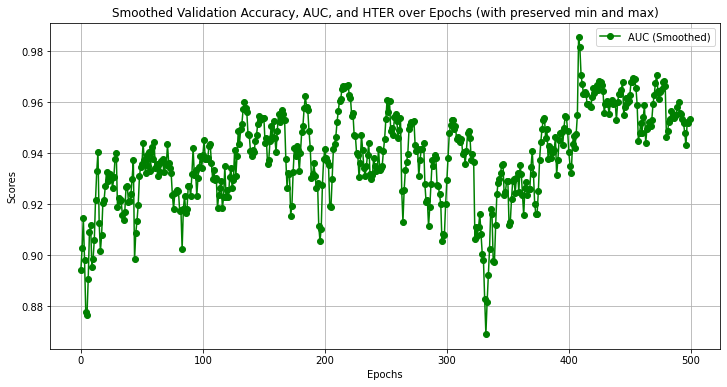

In [55]:
import re
import matplotlib.pyplot as plt
import numpy as np

# مسیر فایل متنی که داده‌ها در آن قرار دارد
smoothing = 0.3  # ضریب نرم‌کننده برای میانگین متحرک نمایی

# لیست برای ذخیره مقادیر دقت (Accuracy)، AUC و HTER
accuracy_scores = []
auc_scores = []
hter_scores = []
epochs = []

# باز کردن فایل و استخراج مقادیر Accuracy، AUC و HTER
with open(file_path, 'r') as file:
    content = file.readlines()
    for epoch, line in enumerate(content, 1):
        # استخراج Accuracy
        acc_match = re.search(r'val_ACC=([\d.]+)', line)
        # استخراج AUC
        auc_match = re.search(r'AUC=([\d.]+)', line)
        # استخراج HTER
        hter_match = re.search(r'HTER=([\d.]+)', line)
        
        # اضافه کردن مقادیر به لیست‌ها در صورتی که مقدار پیدا شد
        if acc_match and auc_match and hter_match:
            accuracy_scores.append(float(acc_match.group(1)))
            auc_scores.append(float(auc_match.group(1)))
            hter_scores.append(float(hter_match.group(1)))
            epochs.append(epoch)

# تابع برای اعمال میانگین متحرک نمایی با حفظ مقادیر حداقل و حداکثر
def exponential_moving_average(data, alpha, preserve_min_max=True):
    ema_data = data.copy()
    min_idx = np.argmin(data)
    max_idx = np.argmax(data)
    
    # اعمال میانگین متحرک نمایی برای هر مقدار، غیر از حداقل و حداکثر
    for i in range(1, len(data)):
        if not (preserve_min_max and (i == min_idx or i == max_idx)):
            ema_data[i] = alpha * data[i] + (1 - alpha) * ema_data[i - 1]
    
    return ema_data

# اعمال نرم‌کننده نمایی روی داده‌ها
smoothed_accuracy = exponential_moving_average(accuracy_scores, smoothing)
smoothed_auc = exponential_moving_average(auc_scores, smoothing)
smoothed_hter = exponential_moving_average(hter_scores, smoothing)

# رسم نمودارها
plt.figure(figsize=(12, 6))

# نمودار Accuracy
# plt.plot(epochs, smoothed_accuracy, label='Validation Accuracy (Smoothed)', marker='o', color='blue')
# # نمودار AUC
plt.plot(range(len(epochs[:500])), smoothed_auc[:500], label='AUC (Smoothed)', marker='o', color='green')
# نمودار HTER
#plt.plot(range(len(epochs[:500])), smoothed_hter[:500], label='HTER (Smoothed)', marker='o', color='orange')

# تنظیمات نمودار
plt.xlabel('Epochs')
plt.ylabel('Scores')
plt.title('Smoothed Validation Accuracy, AUC, and HTER over Epochs (with preserved min and max)')
plt.legend()
plt.grid(True)
plt.show()
